# DenoiSeg Example: DSB 2018
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use a refined version of the Kaggle 2018 Data Science Bowl (DSB 2018) dataset. We already split the data into train and test images. From the train images we then extracted 3800 training and 670 validation patches of size 128x128. The test set contains 50 images. 


In [1]:
# Here we are just importing some libraries which are needed to run this notebook.
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision

from csbdeep.utils import plot_history

import urllib
import os
import zipfile

Using TensorFlow backend.
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pr

## Downloading and  Data Loading
We created three versions of this dataset by adding Gaussian noise with zero mean and standard deviations 10 and 20. The dataset are marked with the suffixes n0, n10 and n20 accordingly.

In the next cell you can choose which `noise_level` you would like to investigate.

In [2]:
# Choose the noise level you would like to look at:
# Values: 'n0', 'n10', 'n20'
noise_level = 'n10'

In [3]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')
    
if noise_level == 'n0':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/1WXxLSqbK0ZIxF5/download'
elif noise_level == 'n10':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/dRc1AHcaH8mqeh7/download'
elif noise_level == 'n20':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/hy6xSq82kCoqqSH/download'
else:
    print('This noise level does not exist for this dataset.')

# check if data has been downloaded already
zipPath="data/DSB2018_{}.zip".format(noise_level)
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve(link, zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [4]:
# Loading of the training images
trainval_data =  np.load('data/DSB2018_{}/train/train_data.npz'.format(noise_level))
train_images = trainval_data['X_train'].astype(np.float32)
train_masks = trainval_data['Y_train']
val_images = trainval_data['X_val'].astype(np.float32)
val_masks = trainval_data['Y_val']

In [5]:
print("Shape of train_images: {}".format(train_images.shape))
print("Shape of train_masks:  {}".format(train_masks.shape))
print("Shape of val_images:   {}".format(val_images.shape))
print("Shape of val_masks:    {}".format(val_masks.shape))

Shape of train_images: (3800, 128, 128)
Shape of train_masks:  (3800, 128, 128)
Shape of val_images:   (670, 128, 128)
Shape of val_masks:    (670, 128, 128)


## Small Amounts of Annotated Training Data
With DenoiSeg we present a solution to train deep neural networks if only few annotated ground truth segmentations are available. We simulate such a scenary by zeroing out all but a fraction of the available training data. In the next cell you can specify the percentage of training images for which ground truth annotations are available.

In [6]:
# Set the percentage of annotated training images.
# Values: 0.0 (no annotated images) to 100.0 (all images get annotations)
percentage_of_annotated_training_images = 0.5
assert percentage_of_annotated_training_images >= 0.0 and percentage_of_annotated_training_images <=100.0

In [7]:
# Seed to shuffle training data (annotated GT and raw image pairs).
seed = 1 

# First we shuffle the training images to remove any bias.
X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed=seed)
# Here we zero out all training images which are not part of the 
# selected percentage.
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = percentage_of_annotated_training_images)

# Now we apply data augmentation to the training patches:
# Rotate four times by 90 degree and add flipped versions.
X, Y_train_masks = augment_data(X_frac, Y_frac)
X_val, Y_val_masks = val_images, val_masks

# Here we add the channel dimension to our input images.
# Dimensionality for training has to be 'SYXC' (Sample, Y-Dimension, X-Dimension, Channel)
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of X:     {}".format(X.shape))
print("Shape of Y:     {}".format(Y.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of Y_val: {}".format(Y_val.shape))

Raw image size after augmentation (30400, 128, 128)
Mask size after augmentation (30400, 128, 128)
Shape of X:     (30400, 128, 128, 1)
Shape of Y:     (30400, 128, 128, 3)
Shape of X_val: (670, 128, 128, 1)
Shape of Y_val: (670, 128, 128, 3)


Next we look at a single sample. In the first column we show the input image, in the second column the background segmentation, in the third column the foreground segmentation and in the last column the border segmentation.

With the parameter `sample` you can choose different training patches. You will notice that not all of them have a segmentation ground truth.

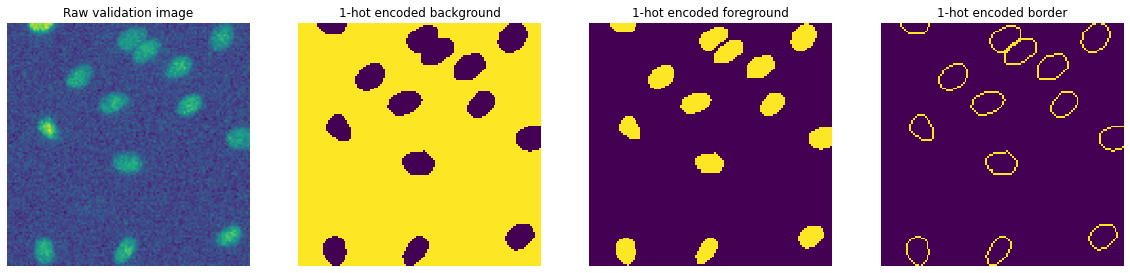

In [8]:
sample = 0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sample,...,0])
plt.axis('off')
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sample,...,0], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sample,...,1], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sample,...,2], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded border');

### Configure network parameters

In [9]:
train_batch_size = 128
train_steps_per_epoch = max(100, min(int(X.shape[0]/train_batch_size), 400))

In [ ]:
### In the next cell, you can choose how much relative importance (weight) to assign to denoising 
### and segmentation tasks by choosing appropriate value for denoiseg_alpha (between 0 and 1; with 0 being
### only segmentation and 1 being only denoising. Here we choose denoiseg_alpha = 0.5)

In [10]:
conf = DenoiSegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=200, 
                      batch_norm=True, train_batch_size=128, unet_n_first = 32, 
                      unet_n_depth=4, denoiseg_alpha=0.5, train_tensorboard=False)

vars(conf)

{'means': ['13.494209'],
 'stds': ['20.886541'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 200,
 'train_steps_per_epoch': 237,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5}

In [11]:
model_name = 'DenoiSeg_DSB18_n10'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

/home/prakash/Git-repos/DenoiSeg/denoiseg/models/denoiseg_standard.py:463: UserWarning: output path for model already exists, files may be overwritten: /home/prakash/Git-repos/DenoiSeg/examples/DenoiSeg_2D/models/DenoiSeg_DSB18_n10
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [12]:
history = model.train(X, Y, (X_val, Y_val))

/home/prakash/Git-repos/DenoiSeg/denoiseg/models/denoiseg_standard.py:146: UserWarning: small number of validation images (only 2.15642% of all images)
  warnings.warn("small number of validation images (only %.05f%% of all images)" % (100 * frac_val))
Preparing validation data:   1%|▏         | 10/670 [00:00<00:06, 94.85it/s]

61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 670/670 [00:07<00:00, 92.33it/s]


Epoch 1/200
  4/237 [..............................] - ETA: 8:21 - loss: 0.4367 - denoiseg: 0.4367 - seg_loss: 0.0046 - denoise_loss: 0.4321 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192682). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 4:39 - loss: 0.3342 - denoiseg: 0.3342 - seg_loss: 0.0079 - denoise_loss: 0.3263

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209954). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 3:17 - loss: 0.2727 - denoiseg: 0.2727 - seg_loss: 0.0058 - denoise_loss: 0.2669

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179879). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130971). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:18 - loss: 0.1726 - denoiseg: 0.1726 - seg_loss: 0.0043 - denoise_loss: 0.1683

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137187). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 1:06 - loss: 0.1634 - denoiseg: 0.1634 - seg_loss: 0.0046 - denoise_loss: 0.1588

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157969). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 1:05 - loss: 0.1627 - denoiseg: 0.1627 - seg_loss: 0.0045 - denoise_loss: 0.1581

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173271). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 1:04 - loss: 0.1622 - denoiseg: 0.1622 - seg_loss: 0.0045 - denoise_loss: 0.1577

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171326). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 46s - loss: 0.1537 - denoiseg: 0.1537 - seg_loss: 0.0039 - denoise_loss: 0.1498

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139883). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 44s - loss: 0.1525 - denoiseg: 0.1525 - seg_loss: 0.0038 - denoise_loss: 0.1487

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151108). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 38s - loss: 0.1503 - denoiseg: 0.1503 - seg_loss: 0.0037 - denoise_loss: 0.1466

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124301). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 37s - loss: 0.1500 - denoiseg: 0.1500 - seg_loss: 0.0036 - denoise_loss: 0.1463

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146117). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 28s - loss: 0.1477 - denoiseg: 0.1477 - seg_loss: 0.0034 - denoise_loss: 0.1443

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126230). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 26s - loss: 0.1474 - denoiseg: 0.1474 - seg_loss: 0.0036 - denoise_loss: 0.1439

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128147). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132257). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 24s - loss: 0.1470 - denoiseg: 0.1470 - seg_loss: 0.0036 - denoise_loss: 0.1435

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124594). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1442 - denoiseg: 0.1442 - seg_loss: 0.0035 - denoise_loss: 0.1407- ETA: 23s - loss: 0.1468 - denoiseg: 0.1468 - seg_los

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134465). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1440 - denoiseg: 0.1440 - seg_loss: 0.0035 - denoise_loss: 0.1405 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136942). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1438 - denoiseg: 0.1438 - seg_loss: 0.0035 - denoise_loss: 0.1403

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138207). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1429 - denoiseg: 0.1429 - seg_loss: 0.0034 - denoise_loss: 0.1395

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131086). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1428 - denoiseg: 0.1428 - seg_loss: 0.0034 - denoise_loss: 0.1393

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137433). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1424 - denoiseg: 0.1424 - seg_loss: 0.0034 - denoise_loss: 0.1390

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137483). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 97s 409ms/step - loss: 0.1423 - denoiseg: 0.1423 - seg_loss: 0.0034 - denoise_loss: 0.1390 - val_loss: 0.6032 - val_denoiseg: 0.6032 - val_seg_loss: 0.4761 - val_denoise_loss: 0.1270
Epoch 2/200
  4/237 [..............................] - ETA: 2:31 - loss: 0.1251 - denoiseg: 0.1251 - seg_loss: 7.5103e-04 - denoise_loss: 0.1244

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237552). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235818). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 2:21 - loss: 0.1256 - denoiseg: 0.1256 - seg_loss: 0.0014 - denoise_loss: 0.1243    

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234083). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 2:11 - loss: 0.1269 - denoiseg: 0.1269 - seg_loss: 0.0011 - denoise_loss: 0.1258

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200255). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:50 - loss: 0.1284 - denoiseg: 0.1284 - seg_loss: 0.0022 - denoise_loss: 0.1262

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180562). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:48 - loss: 0.1280 - denoiseg: 0.1280 - seg_loss: 0.0020 - denoise_loss: 0.1259

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207323). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:45 - loss: 0.1273 - denoiseg: 0.1273 - seg_loss: 0.0019 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230252). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227656). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:39 - loss: 0.1274 - denoiseg: 0.1274 - seg_loss: 0.0019 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232499). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236224). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:37 - loss: 0.1274 - denoiseg: 0.1274 - seg_loss: 0.0022 - denoise_loss: 0.1252

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237658). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:36 - loss: 0.1273 - denoiseg: 0.1273 - seg_loss: 0.0023 - denoise_loss: 0.1250

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239876). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:32 - loss: 0.1273 - denoiseg: 0.1273 - seg_loss: 0.0023 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209554). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:31 - loss: 0.1273 - denoiseg: 0.1273 - seg_loss: 0.0022 - denoise_loss: 0.1250

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182546). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:28 - loss: 0.1274 - denoiseg: 0.1274 - seg_loss: 0.0023 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181755). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176902). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:27 - loss: 0.1276 - denoiseg: 0.1276 - seg_loss: 0.0022 - denoise_loss: 0.1254

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177474). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:25 - loss: 0.1273 - denoiseg: 0.1273 - seg_loss: 0.0020 - denoise_loss: 0.1253

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188515). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:22 - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0021 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199900). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189305). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:19 - loss: 0.1269 - denoiseg: 0.1269 - seg_loss: 0.0021 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169585). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:18 - loss: 0.1269 - denoiseg: 0.1269 - seg_loss: 0.0021 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169596). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168254). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:17 - loss: 0.1269 - denoiseg: 0.1269 - seg_loss: 0.0021 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165961). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:17 - loss: 0.1269 - denoiseg: 0.1269 - seg_loss: 0.0020 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152274). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:14 - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0021 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129418). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:12 - loss: 0.1275 - denoiseg: 0.1275 - seg_loss: 0.0022 - denoise_loss: 0.1253

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166255). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:10 - loss: 0.1276 - denoiseg: 0.1276 - seg_loss: 0.0023 - denoise_loss: 0.1253

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133017). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141616). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:04 - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0023 - denoise_loss: 0.1254

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142048). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 1:01 - loss: 0.1276 - denoiseg: 0.1276 - seg_loss: 0.0022 - denoise_loss: 0.1254

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168457). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192202). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201709). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 1:01 - loss: 0.1275 - denoiseg: 0.1275 - seg_loss: 0.0022 - denoise_loss: 0.1253

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138075). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 1:00 - loss: 0.1273 - denoiseg: 0.1273 - seg_loss: 0.0021 - denoise_loss: 0.1252

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128500). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 59s - loss: 0.1273 - denoiseg: 0.1273 - seg_loss: 0.0021 - denoise_loss: 0.1251 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188749). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 59s - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0021 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146253). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 58s - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0021 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164674). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 56s - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0020 - denoise_loss: 0.1252- ETA: 57s - loss: 0.1271 - denoiseg: 0.1271 - seg_loss: 0.0020 - denoise_loss: 0.125

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131754). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 54s - loss: 0.1274 - denoiseg: 0.1274 - seg_loss: 0.0019 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163446). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 48s - loss: 0.1273 - denoiseg: 0.1273 - seg_loss: 0.0021 - denoise_loss: 0.1253

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172234). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 44s - loss: 0.1273 - denoiseg: 0.1273 - seg_loss: 0.0021 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168449). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 42s - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0020 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174839). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143628). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 41s - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0021 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133025). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0020 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145343). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 37s - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0020 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134875). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0020 - denoise_loss: 0.125

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172464). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 36s - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0020 - denoise_loss: 0.125

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178529). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1271 - denoiseg: 0.1271 - seg_loss: 0.0020 - denoise_loss: 0.1251- ETA: 34s - loss: 0.1271 - denoiseg: 0.1271 - seg_loss: 0.0020 - denoise_loss: 0.125

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205317). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206176). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1271 - denoiseg: 0.1271 - seg_loss: 0.0021 - denoise_loss: 0.1250

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231727). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1271 - denoiseg: 0.1271 - seg_loss: 0.0021 - denoise_loss: 0.1250

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201332). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1270 - denoiseg: 0.1270 - seg_loss: 0.0021 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164573). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147362). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1274 - denoiseg: 0.1274 - seg_loss: 0.0021 - denoise_loss: 0.125

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140327). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1273 - denoiseg: 0.1273 - seg_loss: 0.0021 - denoise_loss: 0.125

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162583). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1274 - denoiseg: 0.1274 - seg_loss: 0.0021 - denoise_loss: 0.1252

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175418). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1276 - denoiseg: 0.1276 - seg_loss: 0.0021 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163209). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0021 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177868). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1276 - denoiseg: 0.1276 - seg_loss: 0.0021 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159827). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 19s - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0022 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134250). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 18s - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0022 - denoise_loss: 0.125 - ETA: 17s - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0022 - denoise_loss: 0.1256

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182777). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0022 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178757). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0021 - denoise_loss: 0.1256

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136678). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0021 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165440). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0022 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186612). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144534). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0021 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192642). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0021 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192547). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1276 - denoiseg: 0.1276 - seg_loss: 0.0021 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210261). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165906). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1276 - denoiseg: 0.1276 - seg_loss: 0.0021 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208774). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1276 - denoiseg: 0.1276 - seg_loss: 0.0021 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176262). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1276 - denoiseg: 0.1276 - seg_loss: 0.0021 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132634). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1276 - denoiseg: 0.1276 - seg_loss: 0.0021 - denoise_loss: 0.1255 - val_loss: 0.5210 - val_denoiseg: 0.5210 - val_seg_loss: 0.3855 - val_denoise_loss: 0.1355
Epoch 3/200
 11/237 [>.............................] - ETA: 1:40 - loss: 0.1279 - denoiseg: 0.1279 - seg_loss: 0.0012 - denoise_loss: 0.1267

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163406). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:37 - loss: 0.1282 - denoiseg: 0.1282 - seg_loss: 0.0012 - denoise_loss: 0.1270

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213293). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:32 - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0019 - denoise_loss: 0.1259

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155489). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216022). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:31 - loss: 0.1275 - denoiseg: 0.1275 - seg_loss: 0.0018 - denoise_loss: 0.1258

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237694). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:31 - loss: 0.1274 - denoiseg: 0.1274 - seg_loss: 0.0018 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195736). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:27 - loss: 0.1277 - denoiseg: 0.1277 - seg_loss: 0.0019 - denoise_loss: 0.1258

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194884). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:25 - loss: 0.1274 - denoiseg: 0.1274 - seg_loss: 0.0017 - denoise_loss: 0.1257

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231528). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221444). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:23 - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0016 - denoise_loss: 0.1256

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214076). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:21 - loss: 0.1269 - denoiseg: 0.1269 - seg_loss: 0.0016 - denoise_loss: 0.1254

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198382). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:20 - loss: 0.1270 - denoiseg: 0.1270 - seg_loss: 0.0017 - denoise_loss: 0.1253

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225057). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:19 - loss: 0.1269 - denoiseg: 0.1269 - seg_loss: 0.0016 - denoise_loss: 0.1253

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231201). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222191). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231406). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:18 - loss: 0.1268 - denoiseg: 0.1268 - seg_loss: 0.0015 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234577). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:15 - loss: 0.1270 - denoiseg: 0.1270 - seg_loss: 0.0015 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220873). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:14 - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0017 - denoise_loss: 0.1254

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223068). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:14 - loss: 0.1272 - denoiseg: 0.1272 - seg_loss: 0.0017 - denoise_loss: 0.1255

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233701). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:13 - loss: 0.1271 - denoiseg: 0.1271 - seg_loss: 0.0017 - denoise_loss: 0.1254

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202879). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:13 - loss: 0.1270 - denoiseg: 0.1270 - seg_loss: 0.0017 - denoise_loss: 0.1253

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182868). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170924). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:12 - loss: 0.1269 - denoiseg: 0.1269 - seg_loss: 0.0017 - denoise_loss: 0.1252

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178102). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:09 - loss: 0.1266 - denoiseg: 0.1266 - seg_loss: 0.0016 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183166). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:08 - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199009). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.1263 - denoiseg: 0.1263 - seg_loss: 0.0015 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216681). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:05 - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0017 - denoise_loss: 0.1247

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158400). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:05 - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0017 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132294). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 58s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0018 - denoise_loss: 0.1246

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152238). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 52s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0017 - denoise_loss: 0.1248- ETA: 57s - loss: 0.1263 - denoiseg: 0.1263 - seg_loss: 0.0018 - denoise_

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128003). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 52s - loss: 0.1266 - denoiseg: 0.1266 - seg_loss: 0.0017 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152849). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 51s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0017 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177503). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 51s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0017 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185335). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 50s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0017 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205233). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 49s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0017 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203137). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164257). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 48s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0017 - denoise_loss: 0.1247

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184019). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 47s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0017 - denoise_loss: 0.1247

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141405). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0017 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223136). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224708). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 44s - loss: 0.1263 - denoiseg: 0.1263 - seg_loss: 0.0016 - denoise_loss: 0.1247

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224135). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 44s - loss: 0.1263 - denoiseg: 0.1263 - seg_loss: 0.0016 - denoise_loss: 0.124

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225332). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 43s - loss: 0.1263 - denoiseg: 0.1263 - seg_loss: 0.0016 - denoise_loss: 0.1247

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225754). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1263 - denoiseg: 0.1263 - seg_loss: 0.0017 - denoise_loss: 0.124

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225182). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0017 - denoise_loss: 0.1247

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215470). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205061). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0017 - denoise_loss: 0.1247

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214351). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 41s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0016 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214773). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 40s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0017 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226808). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0017 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182460). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1266 - denoiseg: 0.1266 - seg_loss: 0.0016 - denoise_loss: 0.1250

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196972). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 38s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214983). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 37s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1250

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210555). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150411). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187078). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1250

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147486). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1250

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193378). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209818). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169786). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0016 - denoise_loss: 0.1248

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192770). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194719). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0016 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211768). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0016 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217647). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170896). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0015 - denoise_loss: 0.125 - ETA: 24s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0015 - denoise_loss: 0.1250

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180781). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1266 - denoiseg: 0.1266 - seg_loss: 0.0015 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194533). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204814). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1266 - denoiseg: 0.1266 - seg_loss: 0.0015 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213462). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1266 - denoiseg: 0.1266 - seg_loss: 0.0015 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225756). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0015 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233931). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234781). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1266 - denoiseg: 0.1266 - seg_loss: 0.0015 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214339). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1266 - denoiseg: 0.1266 - seg_loss: 0.0015 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194352). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1266 - denoiseg: 0.1266 - seg_loss: 0.0015 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145528). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1265 - denoiseg: 0.1265 - seg_loss: 0.0015 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129464). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1266 - denoiseg: 0.1266 - seg_loss: 0.0015 - denoise_loss: 0.1251

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146589). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0015 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160031). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0015 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132567). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0015 - denoise_loss: 0.1249

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150393). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0015 - denoise_loss: 0.1250

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128411). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 394ms/step - loss: 0.1264 - denoiseg: 0.1264 - seg_loss: 0.0015 - denoise_loss: 0.1250 - val_loss: 0.4416 - val_denoiseg: 0.4416 - val_seg_loss: 0.3178 - val_denoise_loss: 0.1238
Epoch 4/200
 14/237 [>.............................] - ETA: 1:22 - loss: 0.1258 - denoiseg: 0.1258 - seg_loss: 0.0011 - denoise_loss: 0.1248     ETA: 1:22 - loss: 0.1259 - denoiseg: 0.1259 - seg_loss: 9.8971e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166726). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176888). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:20 - loss: 0.1252 - denoiseg: 0.1252 - seg_loss: 0.0010 - denoise_loss: 0.1241

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204528). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:19 - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0013 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182909). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:19 - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0014 - denoise_loss: 0.1235

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201406). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216557). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:16 - loss: 0.1254 - denoiseg: 0.1254 - seg_loss: 0.0014 - denoise_loss: 0.1239

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184259). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:15 - loss: 0.1253 - denoiseg: 0.1253 - seg_loss: 0.0015 - denoise_loss: 0.1239

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155470). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:14 - loss: 0.1252 - denoiseg: 0.1252 - seg_loss: 0.0014 - denoise_loss: 0.1238

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164526). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:14 - loss: 0.1255 - denoiseg: 0.1255 - seg_loss: 0.0014 - denoise_loss: 0.1241

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198186). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:13 - loss: 0.1254 - denoiseg: 0.1254 - seg_loss: 0.0014 - denoise_loss: 0.1240

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227829). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198907). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:12 - loss: 0.1252 - denoiseg: 0.1252 - seg_loss: 0.0013 - denoise_loss: 0.1238

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154919). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1253 - denoiseg: 0.1253 - seg_loss: 0.0015 - denoise_loss: 0.1238

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145004). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135266). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:05 - loss: 0.1254 - denoiseg: 0.1254 - seg_loss: 0.0014 - denoise_loss: 0.1240

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179650). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:05 - loss: 0.1254 - denoiseg: 0.1254 - seg_loss: 0.0014 - denoise_loss: 0.1240

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200737). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1253 - denoiseg: 0.1253 - seg_loss: 0.0014 - denoise_loss: 0.1239

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183574). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144631). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1252 - denoiseg: 0.1252 - seg_loss: 0.0013 - denoise_loss: 0.1239

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147921). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1251 - denoiseg: 0.1251 - seg_loss: 0.0013 - denoise_loss: 0.1238

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190467). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1250 - denoiseg: 0.1250 - seg_loss: 0.0013 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191963). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169280). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198112). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0013 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226913). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0013 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228855). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225806). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223569). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220682). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0013 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221016). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 0.0012 - denoise_loss: 0.1235

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221942). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180053). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 0.0012 - denoise_loss: 0.1235

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218375). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1246 - denoiseg: 0.1246 - seg_loss: 0.0012 - denoise_loss: 0.123

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192955). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193200). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220856). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 0.0012 - denoise_loss: 0.123 - ETA: 47s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0013 - denoise_loss: 0.123

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220045). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.123

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222281). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223654). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226519). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225708). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223009). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222011). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221877). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225917). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182933). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225344). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206256). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169327). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177871). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1236- ETA: 36s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.123

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159464). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128662). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175142). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201782). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226929). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 0.0012 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216630). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195367). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 0.0011 - denoise_loss: 0.1236- ETA: 31s - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 0.0011 - denoise_loss: 0.123

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170729). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129426). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 0.0011 - denoise_loss: 0.1236- ETA: 29s - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 0.0011 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188147). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 0.0011 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196707). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223579). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 0.0011 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196382). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202094). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 0.0011 - denoise_loss: 0.1236

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223947). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1246 - denoiseg: 0.1246 - seg_loss: 0.0011 - denoise_loss: 0.1235

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226219). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1246 - denoiseg: 0.1246 - seg_loss: 0.0011 - denoise_loss: 0.1235

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208490). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1246 - denoiseg: 0.1246 - seg_loss: 0.0011 - denoise_loss: 0.1235

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232365). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1246 - denoiseg: 0.1246 - seg_loss: 0.0011 - denoise_loss: 0.1235

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199911). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1246 - denoiseg: 0.1246 - seg_loss: 0.0011 - denoise_loss: 0.123 - ETA: 21s - loss: 0.1246 - denoiseg: 0.1246 - seg_loss: 0.0011 - denoise_loss: 0.123

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167267). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231166). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198962). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187970). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126715). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140820). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195940). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221727). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226922). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230500). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225340). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1246 - denoiseg: 0.1246 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226756). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218663). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198900). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178103). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1245 - denoiseg: 0.1245 - seg_loss: 0.0011 - denoise_loss: 0.1233 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195910). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1244 - denoiseg: 0.1244 - seg_loss: 0.0011 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222090). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1244 - denoiseg: 0.1244 - seg_loss: 0.0011 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224749). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1244 - denoiseg: 0.1244 - seg_loss: 0.0011 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226867). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1244 - denoiseg: 0.1244 - seg_loss: 0.0011 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229080). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1244 - denoiseg: 0.1244 - seg_loss: 0.0011 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228795). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1244 - denoiseg: 0.1244 - seg_loss: 0.0011 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208281). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1244 - denoiseg: 0.1244 - seg_loss: 0.0011 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179784). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1243 - denoiseg: 0.1243 - seg_loss: 0.0011 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167194). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1243 - denoiseg: 0.1243 - seg_loss: 0.0011 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184152). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1243 - denoiseg: 0.1243 - seg_loss: 0.0011 - denoise_loss: 0.1232

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154228). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1242 - denoiseg: 0.1242 - seg_loss: 0.0011 - denoise_loss: 0.1232

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154406). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1242 - denoiseg: 0.1242 - seg_loss: 0.0011 - denoise_loss: 0.1232

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184330). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199875). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 385ms/step - loss: 0.1242 - denoiseg: 0.1242 - seg_loss: 0.0011 - denoise_loss: 0.1232 - val_loss: 0.3796 - val_denoiseg: 0.3796 - val_seg_loss: 0.2602 - val_denoise_loss: 0.1194
Epoch 5/200
 11/237 [>.............................] - ETA: 1:31 - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 7.0773e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150119). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:28 - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 8.1851e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182259). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199485). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:27 - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 9.4061e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204087). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:26 - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 0.0012 - denoise_loss: 0.1206  

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213021). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:25 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 0.0011 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222064). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:24 - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 0.0012 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224688). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:23 - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 0.0012 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227605). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:20 - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 0.0010 - denoise_loss: 0.1207 ETA: 1:22 - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 0.0011 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228054). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230456). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:19 - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 9.6408e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230586). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:19 - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 9.6919e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228630). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:18 - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 9.8545e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230769). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:17 - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 9.5807e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228943). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:17 - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 9.8059e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226651). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:16 - loss: 0.1222 - denoiseg: 0.1222 - seg_loss: 9.7330e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223161). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:15 - loss: 0.1223 - denoiseg: 0.1223 - seg_loss: 9.8382e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226833). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222665). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:13 - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 0.0011 - denoise_loss: 0.1216

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194562). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:13 - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 0.0010 - denoise_loss: 0.1217

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228265). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:13 - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 0.0010 - denoise_loss: 0.1217

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211128). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:11 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 9.3864e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135041). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147500). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:10 - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 8.8744e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129431). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:08 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 9.2210e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145538). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132631). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:07 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 8.9773e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163099). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:05 - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 0.0011 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186242). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196994). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:05 - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 0.0011 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212014). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:04 - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 0.0011 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213973). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223607). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:03 - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 0.0011 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196430). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:01 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 0.0010 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162919). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 0.0010 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151048). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1234 - denoiseg: 0.1234 - seg_loss: 0.0010 - denoise_loss: 0.1224    

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187680). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 9.8660e-04 - denoise_loss: 0.1226

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188260). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1235 - denoiseg: 0.1235 - seg_loss: 9.9456e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152175). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 9.8599e-04 - denoise_loss: 0.1226

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161023). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 9.3750e-04 - denoise_loss: 0.1226

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160725). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 9.4300e-04 - denoise_loss: 0.1226

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145960). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 9.3540e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141376). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 9.2055e-04 - denoise_loss: 0.1226

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135982). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 9.1194e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123969). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 9.1863e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145730). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 9.0110e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131488). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.8795e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146206). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.8151e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156475). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.9401e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173816). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.8192e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122989). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.7209e-04 - denoise_loss: 0.123

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129314). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1240 - denoiseg: 0.1240 - seg_loss: 8.6132e-04 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162210). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.5082e-04 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203784). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.5930e-04 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165481). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1241 - denoiseg: 0.1241 - seg_loss: 8.7878e-04 - denoise_loss: 0.1232- ETA: 23s - loss: 0.1241 - denoiseg: 0.1241 - seg_loss: 8.8888e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135309). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1241 - denoiseg: 0.1241 - seg_loss: 8.8810e-04 - denoise_loss: 0.1232

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205568). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1241 - denoiseg: 0.1241 - seg_loss: 8.9105e-04 - denoise_loss: 0.1232

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206074). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1241 - denoiseg: 0.1241 - seg_loss: 8.8131e-04 - denoise_loss: 0.1232

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193061). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1241 - denoiseg: 0.1241 - seg_loss: 8.7652e-04 - denoise_loss: 0.1232

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176535). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1242 - denoiseg: 0.1242 - seg_loss: 8.9304e-04 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177041). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1241 - denoiseg: 0.1241 - seg_loss: 8.9238e-04 - denoise_loss: 0.1232

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152069). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1240 - denoiseg: 0.1240 - seg_loss: 9.1349e-04 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168425). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149122). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1240 - denoiseg: 0.1240 - seg_loss: 8.9784e-04 - denoise_loss: 0.1231 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176701). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1240 - denoiseg: 0.1240 - seg_loss: 9.0851e-04 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167087). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1240 - denoiseg: 0.1240 - seg_loss: 9.1180e-04 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146481). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1240 - denoiseg: 0.1240 - seg_loss: 9.0616e-04 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172576). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1240 - denoiseg: 0.1240 - seg_loss: 9.1718e-04 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165106). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 9.0295e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200053). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141701). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129786). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.9915e-04 - denoise_loss: 0.1230 - val_loss: 0.3409 - val_denoiseg: 0.3409 - val_seg_loss: 0.2204 - val_denoise_loss: 0.1205
Epoch 6/200
 15/237 [>.............................] - ETA: 1:22 - loss: 0.1248 - denoiseg: 0.1248 - seg_loss: 7.4717e-04 - denoise_loss: 0.1241 ETA: 1:22 - loss: 0.1254 - denoiseg: 0.1254 - seg_loss: 8.5454e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151618). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204419). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:22 - loss: 0.1247 - denoiseg: 0.1247 - seg_loss: 7.0047e-04 - denoise_loss: 0.1240

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230352). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:20 - loss: 0.1243 - denoiseg: 0.1243 - seg_loss: 0.0012 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212530). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:21 - loss: 0.1242 - denoiseg: 0.1242 - seg_loss: 0.0011 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201181). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:19 - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 0.0012 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156901). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:19 - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 0.0011 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170501). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:17 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 9.4536e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192282). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194222). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:16 - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 9.7664e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187233). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183054). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:16 - loss: 0.1235 - denoiseg: 0.1235 - seg_loss: 0.0011 - denoise_loss: 0.1224  

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129938). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:12 - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 9.7752e-04 - denoise_loss: 0.1226

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166376). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:12 - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 9.8711e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165536). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:11 - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 9.6737e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210917). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:10 - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 9.3887e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226186). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:09 - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 8.8269e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238418). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:08 - loss: 0.1234 - denoiseg: 0.1234 - seg_loss: 0.0010 - denoise_loss: 0.1224    

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235037). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:08 - loss: 0.1234 - denoiseg: 0.1234 - seg_loss: 0.0010 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237100). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:07 - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 9.9429e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231935). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:06 - loss: 0.1234 - denoiseg: 0.1234 - seg_loss: 9.8015e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233835). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:06 - loss: 0.1234 - denoiseg: 0.1234 - seg_loss: 9.4999e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231917). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195542). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:05 - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 9.5037e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180297). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:04 - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 9.4166e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138901). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 1:00 - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 9.1998e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148682). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167164). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 1:00 - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 9.0848e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198880). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 59s - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 9.4169e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224327). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 59s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 9.1927e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236281). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 58s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 9.0053e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241448). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 57s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.8208e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230120). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 55s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.5153e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213280). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.3361e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193469). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 54s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.2492e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176480). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 53s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.4379e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187132). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145357). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 53s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.4030e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206406). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 52s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.2974e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147642). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 51s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.5942e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220817). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 50s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.9977e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152689). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 9.1970e-04 - denoise_loss: 0.123

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203945). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 49s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 9.1320e-04 - denoise_loss: 0.123

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190143). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 47s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 9.3803e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224179). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 9.2994e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244153). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245070). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 9.1725e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247294). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 45s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 9.2040e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250654). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 44s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 9.0532e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247077). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 9.1222e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248134). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244316). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 43s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 9.1663e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243575). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 9.2766e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242538). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.9584e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240365). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.8266e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209835). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.7622e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240243). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.7756e-04 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153629). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 24s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.6020e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165182). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 24s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.5531e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185247). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 24s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.5048e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197380). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 23s - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.4865e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201638). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 23s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.5047e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230836). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 22s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.4578e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260380). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.5727e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.277227). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 20s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.4607e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219171). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 19s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.4157e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246823). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 19s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.5278e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226800). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 18s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.4390e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207031). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 17s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.3520e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193067). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239329). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 15s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.4316e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268234). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 14s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.3875e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.276043). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.271807). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 13s - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 8.2939e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230617). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.2825e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222092). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 12s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.2424e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188212). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 8.2028e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166211). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 8.4788e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134629). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 8s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.5703e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185431). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.5419e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201542). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 6s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.5034e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198241). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1237 - denoiseg: 0.1237 - seg_loss: 8.4652e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214353). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.3900e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216168). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.3529e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194915). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.2796e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190825). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178562). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1238 - denoiseg: 0.1238 - seg_loss: 8.2856e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126475). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 98s 413ms/step - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 8.3244e-04 - denoise_loss: 0.1230 - val_loss: 0.3397 - val_denoiseg: 0.3397 - val_seg_loss: 0.2151 - val_denoise_loss: 0.1246
Epoch 7/200
  2/237 [..............................] - ETA: 1:01 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 0.0000e+00 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198194). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166152). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:20 - loss: 0.1234 - denoiseg: 0.1234 - seg_loss: 4.1211e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158292). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:19 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.0106e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169729). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:18 - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 4.3147e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169819). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:18 - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 5.2741e-04 - denoise_loss: 0.12 - ETA: 1:17 - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 5.0788e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186749). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:17 - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 4.8974e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185289). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:15 - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 4.2852e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168650). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:15 - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 4.4131e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186877). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:14 - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 5.0284e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202517). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:12 - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.3554e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210713). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:11 - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.3844e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208979). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:11 - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.7688e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216174). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:11 - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 6.8533e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216120). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:10 - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.8419e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216623). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:10 - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 7.1826e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196038). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:09 - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 7.1102e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190925). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 6.9030e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156418). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 7.3037e-04 - denoise_loss: 0.12 - ETA: 1:04 - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 7.1914e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153558). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 7.1086e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163166). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 7.3120e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169558). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 7.2119e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177121). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 7.0195e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168974). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.9828e-04 - denoise_loss: 0.1221 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172864). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.8766e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157545). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.8215e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176728). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 7.0327e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201972). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 7.3278e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169555). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 7.2485e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206971). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228088). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 7.1662e-04 - denoise_loss: 0.122 - ETA: 55s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 7.4561e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229201). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 7.5969e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229109). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.5134e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203318). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.4739e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165455). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.2831e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150242). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.4385e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179427). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.2357e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197561). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.1705e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195852). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.1065e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202860). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 6.9309e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217520). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 7.4246e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222172). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.3632e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235473). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.6555e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185129). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.5377e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235628). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.4782e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239499). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.4056e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175546). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.3483e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138171). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.2969e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168397). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179749). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.3786e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184177). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.4007e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181393). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.2395e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179253). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.3043e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204657). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.2330e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215908). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 7.3534e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174796). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.3150e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190745). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.1877e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203515). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.1914e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223411). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.7406e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182686). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.7998e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185568). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 7.7228e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139302). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.7263e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204005). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 7.8370e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229661). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.7530e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159942). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.7351e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199793). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.6802e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178300). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 7.6048e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157417). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 7.6543e-04 - denoise_loss: 0.1226

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112377). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.9445e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167055). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 7.9540e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177307). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 390ms/step - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 7.5336e-04 - denoise_loss: 0.1224 - val_loss: 0.3046 - val_denoiseg: 0.3046 - val_seg_loss: 0.1852 - val_denoise_loss: 0.1194
Epoch 8/200
 16/237 [=>............................] - ETA: 1:23 - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 1.8530e-04 - denoise_loss: 0.1218

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164028). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:23 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 3.3936e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197390). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:22 - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 3.1862e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208609). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:20 - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 3.7327e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167794). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:19 - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 3.5994e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173374). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:19 - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 3.4753e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177722). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:19 - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 3.2511e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168492). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:17 - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 4.9460e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190617). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:15 - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 4.5179e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136931). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:14 - loss: 0.1224 - denoiseg: 0.1224 - seg_loss: 4.3125e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162527). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:13 - loss: 0.1222 - denoiseg: 0.1222 - seg_loss: 4.1250e-04 - denoise_loss: 0.1218

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190337). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:12 - loss: 0.1224 - denoiseg: 0.1224 - seg_loss: 4.0533e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185377). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:11 - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 4.7609e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213418). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:10 - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 5.5336e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200064). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:09 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 5.5436e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193734). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178814). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:08 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 5.5418e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164042). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:07 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 5.3630e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159433). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:05 - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 5.9858e-04 - denoise_loss: 0.1220 ETA: 1:06 - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 5.9849e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156841). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:02 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.2169e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181672). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.0934e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143655). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 1:00 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.0163e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213262). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.2101e-04 - denoise_loss: 0.1220 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175814). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.2606e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187531). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 57s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.3841e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221736). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184741). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 56s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.4357e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212535). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.3028e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202495). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.2378e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212450). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.2455e-04 - denoise_loss: 0.1218

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142080). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.2416e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209275). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.1550e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222443). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.6856e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142426). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.4468e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227469). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.3410e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227239). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144008). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.5996e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216153). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 6.7656e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155074). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 6.6192e-04 - denoise_loss: 0.1223- ETA: 45s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 6.6753e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229052). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 6.5640e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229577). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 6.7083e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228198). Check your callbacks.
  % delta_t_median)


 - ETA: 43s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 6.6592e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228777). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 6.5526e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230156). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.4342e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228028). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.8538e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227087). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.9110e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194104). Check your callbacks.
  % delta_t_median)


 - ETA: 38s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 6.8602e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220111). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.8458e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225350). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219769). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.7969e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219694). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 7.0327e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169439). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.9506e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151364). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.8194e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194978). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.7768e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217324). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172027). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.8330e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128057). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.7915e-04 - denoise_loss: 0.121

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171671). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.7421e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142580). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.6710e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186934). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.6313e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195387). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200796). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.5821e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163433). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.5455e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185778). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.4090e-04 - denoise_loss: 0.122

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174845). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.4223e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185075). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.4753e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174024). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.6959e-04 - denoise_loss: 0.121

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157976). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.6447e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159040). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.7167e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145604). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157153). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.6668e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223026). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.6792e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224859). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.9101e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224707). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207475). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.8464e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213709). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.8191e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215543). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.7879e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227091). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229839). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.8468e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231413). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228931). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.8294e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215808). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.8586e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229205). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.9203e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203402). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.8512e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203676). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.7633e-04 - denoise_loss: 0.1220 ETA: 1s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.7923e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229483). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218858). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.7368e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156103). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.7082e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185060). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 383ms/step - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.6797e-04 - denoise_loss: 0.1220 - val_loss: 0.2984 - val_denoiseg: 0.2984 - val_seg_loss: 0.1791 - val_denoise_loss: 0.1194
Epoch 9/200
 13/237 [>.............................] - ETA: 1:14 - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 8.1526e-04 - denoise_loss: 0.1222

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135547). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207330). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:14 - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 8.9378e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222367). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:14 - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 9.0872e-04 - denoise_loss: 0.12 - ETA: 1:14 - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 8.5526e-04 - denoise_loss: 0.1218

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222598). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227084). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:15 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 8.6512e-04 - denoise_loss: 0.1216

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227181). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227744). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:15 - loss: 0.1224 - denoiseg: 0.1224 - seg_loss: 7.8718e-04 - denoise_loss: 0.1217

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228534). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:14 - loss: 0.1223 - denoiseg: 0.1223 - seg_loss: 7.1873e-04 - denoise_loss: 0.1216

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227606). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:14 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.3580e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227044). Check your callbacks.
  % delta_t_median)


 - ETA: 1:14 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.1225e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228301). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:14 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 5.9039e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226183). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:14 - loss: 0.1224 - denoiseg: 0.1224 - seg_loss: 5.8121e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224593). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:13 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.2435e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223791). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:12 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 6.4755e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225981). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:12 - loss: 0.1224 - denoiseg: 0.1224 - seg_loss: 6.8243e-04 - denoise_loss: 0.1217

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232367). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236845). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:12 - loss: 0.1223 - denoiseg: 0.1223 - seg_loss: 6.6398e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236785). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.1223 - denoiseg: 0.1223 - seg_loss: 7.0773e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239227). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:10 - loss: 0.1223 - denoiseg: 0.1223 - seg_loss: 6.8394e-04 - denoise_loss: 0.1216

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239166). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:10 - loss: 0.1222 - denoiseg: 0.1222 - seg_loss: 6.7128e-04 - denoise_loss: 0.1216

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232541). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:10 - loss: 0.1222 - denoiseg: 0.1222 - seg_loss: 6.5636e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207875). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:08 - loss: 0.1222 - denoiseg: 0.1222 - seg_loss: 6.0278e-04 - denoise_loss: 0.1216

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135384). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:03 - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 6.0605e-04 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164366). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176215). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:02 - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 5.8364e-04 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203400). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:02 - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 5.7493e-04 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213400). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:01 - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 6.4303e-04 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231118). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 6.3384e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238158). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................]0.1220 - seg_loss: 6.2492e-04 - denoise_loss: 0.12 - ETA: 1:00 - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 6.2116e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234492). Check your callbacks.
  % delta_t_median)


 - ETA: 1:00 - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 6.3777e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233396). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.2970e-04 - denoise_loss: 0.1212 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230906). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216066). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 58s - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 6.5528e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231650). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 57s - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 6.3781e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229615). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229012). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 6.3282e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229332). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1222 - denoiseg: 0.1222 - seg_loss: 6.1966e-04 - denoise_loss: 0.1216

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197387). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 6.0574e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180664). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211896). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177438). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 6.1262e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190257). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209200). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 6.1148e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203911). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 6.1791e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224393). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 5.7499e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136649). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 5.6994e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172963). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 5.8544e-04 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204369). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222346). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 5.8599e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203160). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 5.9520e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210319). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193599). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 5.9052e-04 - denoise_loss: 0.1215

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180079). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 5.8136e-04 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171740). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 6.2365e-04 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215760). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 6.1441e-04 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192773). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 6.0989e-04 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197920). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 5.9056e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165839). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.9229e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163415). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.9987e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155861). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127613). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.9995e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134462). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.9199e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122972). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.9295e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165438). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.8927e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181810). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.8980e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185337). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185168). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.9997e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205676). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224611). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.9439e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145272). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 15s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.0613e-04 - denoise_loss: 0.1212- ETA: 20s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.1959e-04 - denoise_loss - ETA: 17s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.1302e-04 - denoise_loss: 0.121 - ETA: 17s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.1889e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177840). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.0049e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172085). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 5.9959e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220078). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154336). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 5.9499e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163386). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.0753e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140576). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.2330e-04 - denoise_loss: 0.1213 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171185). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.4075e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167521). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170206). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 5s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.5263e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134635). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.4678e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170001). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.3986e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201009). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.3732e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202091). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.3998e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183259). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.4510e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204305). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.4962e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191030). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 379ms/step - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.4688e-04 - denoise_loss: 0.1212 - val_loss: 0.3277 - val_denoiseg: 0.3277 - val_seg_loss: 0.2065 - val_denoise_loss: 0.1212
Epoch 10/200
 18/237 [=>............................] - ETA: 1:16 - loss: 0.1235 - denoiseg: 0.1235 - seg_loss: 4.7488e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205608). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214186). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:16 - loss: 0.1240 - denoiseg: 0.1240 - seg_loss: 6.4079e-04 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181094). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:16 - loss: 0.1242 - denoiseg: 0.1242 - seg_loss: 5.7706e-04 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146168). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:13 - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 5.7115e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179640). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:13 - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 5.6333e-04 - denoise_loss: 0.1233

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226003). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:11 - loss: 0.1242 - denoiseg: 0.1242 - seg_loss: 5.2342e-04 - denoise_loss: 0.1237

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225639). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:09 - loss: 0.1239 - denoiseg: 0.1239 - seg_loss: 5.0229e-04 - denoise_loss: 0.1234

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226111). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200856). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:08 - loss: 0.1236 - denoiseg: 0.1236 - seg_loss: 5.0733e-04 - denoise_loss: 0.1231

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204140). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1234 - denoiseg: 0.1234 - seg_loss: 4.8879e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230276). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228660). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196453). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:05 - loss: 0.1234 - denoiseg: 0.1234 - seg_loss: 4.7423e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192093). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1234 - denoiseg: 0.1234 - seg_loss: 5.0662e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223391). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220657). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.6876e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223827). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.7118e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224792). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.6049e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225959). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.5392e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226974). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.5384e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225206). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:00 - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 4.5626e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221414). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 4.3848e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166238). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1235 - denoiseg: 0.1235 - seg_loss: 4.4267e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136793). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1235 - denoiseg: 0.1235 - seg_loss: 4.4215e-04 - denoise_loss: 0.1230

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130600). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 4.4005e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173972). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 4.3313e-04 - denoise_loss: 0.1229

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215673). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 4.3494e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218678). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.2660e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222613). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.1762e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224389). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.1593e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228613). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 4.1168e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227223). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 4.0752e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223377). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 4.3511e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201733). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.5744e-04 - denoise_loss: 0.1228

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224489). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1232 - denoiseg: 0.1232 - seg_loss: 4.5482e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188166). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 4.6264e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181845). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 4.6135e-04 - denoise_loss: 0.1227

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202641). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 4.6232e-04 - denoise_loss: 0.1226

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216472). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 4.6644e-04 - denoise_loss: 0.1226

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186885). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 4.8616e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193028). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 4.8323e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176896). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 4.9267e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171837). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 4.8883e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197861). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1230 - denoiseg: 0.1230 - seg_loss: 4.9418e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196171). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 4.9041e-04 - denoise_loss: 0.1225

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205068). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 4.9147e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194565). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 4.8961e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141131). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127378). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 5.2138e-04 - denoise_loss: 0.1224

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200441). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 5.2172e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135923). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 5.1807e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150611). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 5.6061e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223082). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 5.7182e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237006). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 5.8882e-04 - denoise_loss: 0.1223

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158563). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1227 - denoiseg: 0.1227 - seg_loss: 6.0808e-04 - denoise_loss: 0.1221

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167281). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 6.0466e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168045). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 5.9881e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216820). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 5.9552e-04 - denoise_loss: 0.1220

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183172). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 5.8853e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213793). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224343). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 5.8325e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183699). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 5.7739e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190053). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 5.7825e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217418). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 5.7525e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220898). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1224 - denoiseg: 0.1224 - seg_loss: 5.6940e-04 - denoise_loss: 0.1219

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187323). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1224 - denoiseg: 0.1224 - seg_loss: 5.6188e-04 - denoise_loss: 0.1218

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202339). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172739). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1223 - denoiseg: 0.1223 - seg_loss: 5.5102e-04 - denoise_loss: 0.1218

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147079). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1223 - denoiseg: 0.1223 - seg_loss: 5.4832e-04 - denoise_loss: 0.1218

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128657). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 382ms/step - loss: 0.1223 - denoiseg: 0.1223 - seg_loss: 5.6368e-04 - denoise_loss: 0.1218 - val_loss: 0.2772 - val_denoiseg: 0.2772 - val_seg_loss: 0.1582 - val_denoise_loss: 0.1191
Epoch 11/200
 18/237 [=>............................] - ETA: 1:22 - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 9.3169e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213127). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:21 - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 9.6507e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219860). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223614). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:21 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 8.7733e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226521). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233234). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:20 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 8.8056e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229804). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:19 - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 8.5940e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222112). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:18 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 8.2871e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216616). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:18 - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 8.0013e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223534). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:17 - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 7.4851e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214248). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:16 - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 7.0555e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189984). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:15 - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 6.9203e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218079). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:12 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.2051e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174030). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:11 - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.1510e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174437). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:11 - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.0173e-04 - denoise_loss: 0.12 - ETA: 1:11 - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 5.8892e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165274). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:09 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.1658e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169132). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166308). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 7.0397e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166564). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:05 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.9224e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177318). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.8089e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191740). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 6.6100e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199732). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 6.2699e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176894). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 6.8163e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175995). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.6520e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180709). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 6.4770e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209347). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.0190e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138049). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 5.9558e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223967). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.1814e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225644). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.0484e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223197). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 6.1301e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221055). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.0062e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185934). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.2432e-04 - denoise_loss: 0.1212

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210784). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.5349e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194245). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.3624e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210475). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.3386e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221650). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 6.5534e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205763). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189533). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.4394e-04 - denoise_loss: 0.121

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219542). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.3293e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223389). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.2912e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207384). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 43s - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.2383e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193605). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.1170e-04 - denoise_loss: 0.121

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210500). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.1788e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226505). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.1785e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227026). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.3893e-04 - denoise_loss: 0.121

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179576). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.4291e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154760). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.4808e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129167). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.4213e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146247). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.2413e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142998). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 6.1622e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183979). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.2341e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202174). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.1499e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205881). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.1140e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216457). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.0927e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213752). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188555). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.0146e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144505). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.2135e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164644). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.1354e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141014). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.0560e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157157). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.0403e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168368). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 6.0081e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193145). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 5.9366e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182120). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 5.8667e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203477). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 5.8324e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186069). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 5.9487e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172316). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 5.9434e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147415). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 5.9336e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198197). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202872). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.9270e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210850). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.9902e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222127). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229867). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.9592e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231473). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 14s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.9987e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229227). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.8843e-04 - denoise_loss: 0.1208- ETA: 14s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.9435e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216343). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229877). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.8552e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229418). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206486). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.8728e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227951). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.7918e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225911). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.7629e-04 - denoise_loss: 0.1208 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194002). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 8s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.8108e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225787). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226856). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.8763e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227635). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.8558e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226360). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.9266e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226410). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146354). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.7337e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180770). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.7285e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196931). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 380ms/step - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.7044e-04 - denoise_loss: 0.1208 - val_loss: 0.2730 - val_denoiseg: 0.2730 - val_seg_loss: 0.1523 - val_denoise_loss: 0.1207
Epoch 12/200
  3/237 [..............................] - ETA: 59s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 8.2936e-04 - denoise_loss: 0.1207 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135234). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:05 - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 8.3391e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169799). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:04 - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.7768e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161813). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153828). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 57s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.7264e-04 - denoise_loss: 0.1206 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127249). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:23 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 6.6753e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176803). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:21 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 5.5088e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144265). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:19 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 4.6605e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155038). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:18 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.5193e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157071). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:17 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 4.2677e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180340). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:16 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 3.9308e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184927). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:15 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 3.8384e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188307). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:15 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 3.7916e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195250). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:14 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 3.6153e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184139). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:12 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 3.9410e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177196). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:10 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 4.3529e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181179). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214546). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:09 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 4.1154e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216437). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:06 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 3.8338e-04 - denoise_loss: 0.1208 ETA: 1:06 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 3.8966e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217228). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:05 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.0331e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216929). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.2370e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217942). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209813). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:04 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 4.1738e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197832). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 4.3854e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179569). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 4.9701e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159658). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 5.2487e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157866). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 5.3117e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140089). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188090). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 5.1933e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156951). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 5.1329e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195075). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 5.7638e-04 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208489). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 5.6997e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216050). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 5.7725e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204818). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 6.0563e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179102). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 6.1244e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202752). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 6.0682e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218621). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 5.9648e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218794). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225592). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 6.0269e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226959). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 6.0353e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225522). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1215 - denoiseg: 0.1215 - seg_loss: 5.9833e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225491). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.9179e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197669). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.8690e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162636). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.7735e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165892). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.8615e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202260). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.8171e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227109). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202542). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.9713e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202637). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 6.1474e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227790). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 6.2263e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218943). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170546). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 6.0510e-04 - denoise_loss: 0.1208- ETA: 37s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 6.0899e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189296). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.9223e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143676). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.9546e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143289). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.8731e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165190). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.9102e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165988). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.9034e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199437). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229134). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.8172e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229506). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.7553e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172293). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.7360e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161488). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.8528e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147869). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 6.1052e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218863). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 6.0419e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181033). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.9511e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213551). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 6.0508e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226240). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 6.0193e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225314). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224378). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.9057e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226811). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.8305e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223090). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.7675e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224588). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204907). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.7058e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204072). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.6454e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222464). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167177). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181373). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.5324e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102963). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.7846e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135372). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201279). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.7563e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228798). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 5.7194e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230643). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.6918e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233915). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.6776e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207893). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.6245e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209057). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.6025e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208643). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.5512e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166834). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.5504e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196825). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.5670e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186556). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.5760e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161794). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.6178e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162933). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.7048e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186427). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.8973e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152956). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.8223e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168646). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165208). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 383ms/step - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.7978e-04 - denoise_loss: 0.1207 - val_loss: 0.2574 - val_denoiseg: 0.2574 - val_seg_loss: 0.1381 - val_denoise_loss: 0.1192
Epoch 13/200
  1/237 [..............................] - ETA: 30s - loss: 0.1220 - denoiseg: 0.1220 - seg_loss: 0.0022 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233800). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 58s - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 0.0015 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237379). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:13 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 8.2083e-04 - denoise_loss: 0.12 - ETA: 1:09 - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 6.8434e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216381). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198961). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:03 - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.7849e-04 - denoise_loss: 0.1213

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160803). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:17 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 2.7361e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170029). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:17 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 3.3717e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191363). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:17 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 3.8069e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198533). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:16 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 3.9032e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209324). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:15 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 4.8334e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190628). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:14 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.0715e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127242). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:14 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 4.2149e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132744). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154698). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207787). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:14 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.2524e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241063). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.312230). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:13 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 3.9737e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.284310). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:13 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 3.9001e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257487). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:12 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 3.8938e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257264). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:12 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 3.8879e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253925). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:11 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 4.0901e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.274645). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.299272). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:10 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 4.3686e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.274828). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:09 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.1730e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.309889). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:09 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 4.3152e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.308533). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:08 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.2512e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.284089). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:08 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.1930e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221883). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:07 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.1363e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259994). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:07 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.0337e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257450). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:06 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.3018e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173451). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135339). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 1:00 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 4.6682e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142824). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 1:00 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 4.6293e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185213). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 1:00 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 4.6694e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212792). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 58s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 4.7600e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152157). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 43s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.1192e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149441). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 43s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.0818e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.266658). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 43s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.0822e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.302350). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 42s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.4820e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.312201). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 40s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5440e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264298). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 40s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5388e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220602). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 39s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.8288e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193454). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 38s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.6734e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198303). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 37s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.7961e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183914). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 36s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.7226e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184332). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 35s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.6857e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226587). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 35s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.6493e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268460). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 34s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.6615e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273799). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 34s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.7613e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248274). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 33s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.7253e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.285155). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 32s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.6199e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258340). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 31s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5518e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.275904). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265187). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 30s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4853e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239023). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 30s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4527e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264948). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 29s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4449e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273548). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 27s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.6172e-04 - denoise_loss: 0.1206- ETA: 28s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5692e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.285412). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.285174). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 26s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.6473e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264504). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 25s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5842e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220053). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132391). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 16s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.4670e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158743). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 16s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.5483e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206543). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 13s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.5225e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179692). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 12s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.7981e-04 - denoise_loss: 0.1205- ETA: 13s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.7614e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171097). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 8s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.6136e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154688). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 7s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5651e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201808). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 6s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5184e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181476). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5455e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212156). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191825). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 3s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5274e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188694). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5748e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192548). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 2s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5508e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206512). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5645e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233071). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5409e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180619). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 103s 436ms/step - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5365e-04 - denoise_loss: 0.1205 - val_loss: 0.2562 - val_denoiseg: 0.2562 - val_seg_loss: 0.1367 - val_denoise_loss: 0.1195
Epoch 14/200
  2/237 [..............................] - ETA: 58s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 0.0000e+00 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234207). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127481). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 58s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 0.0000e+00 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137432). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194480). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:09 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 2.8624e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168236). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:09 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 2.7261e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171058). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:10 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 2.6021e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182984). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:11 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 2.8439e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204312). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 2.8077e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215423). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238913). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:12 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 2.8143e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246890). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:11 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 2.9217e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208549). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:11 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.9099e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207726). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153779). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.0103e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161627). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:10 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.2120e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211089). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:10 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.1140e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223917). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:10 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.9312e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243826). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:09 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.9339e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237167). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219576). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.0891e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184904). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:06 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8921e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158362). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187963). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9602e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220801). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2096e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245504). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:05 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1394e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246430). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8807e-04 - denoise_loss: 0.1198 ETA: 1:05 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0059e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245101). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0580e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219697). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3367e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246744). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.2179e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245448). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195111). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.1609e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213723). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1054e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207775). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3009e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240164). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.6032e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206326). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214160). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4645e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214037). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3631e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199040). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2661e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213580). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.3538e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227322). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.1760e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151352). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.2519e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128000). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5329e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174914). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.8731e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181499). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.0546e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207583). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.9777e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229702). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.9379e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223101). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.8691e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221498). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213511). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9249e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200272). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182545). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.8200e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194757). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.0417e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131901). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.0248e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127105). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9921e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195011). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.0144e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209067). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.2664e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140568). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.2581e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162081). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.1929e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173210). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172239). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.1285e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189216). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215016). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.2203e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218657). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.1647e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215691). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.1374e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200732). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.0571e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218674). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.0050e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207356). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145120). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.0018e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154314). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.0228e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137315). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 386ms/step - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.0015e-04 - denoise_loss: 0.1198 - val_loss: 0.2577 - val_denoiseg: 0.2577 - val_seg_loss: 0.1384 - val_denoise_loss: 0.1193
Epoch 15/200
 20/237 [=>............................] - ETA: 1:18 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 6.6123e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178916). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:18 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 6.2975e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198726). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:17 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 6.3961e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213670). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:17 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 6.1678e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214102). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:15 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 6.7322e-04 - denoise_loss: 0.1197 ETA: 1:16 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 6.7223e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214059). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:15 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 7.2427e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198027). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:13 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 6.7345e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178177). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191583). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:12 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 6.0108e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207496). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:10 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 6.1739e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180988). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:10 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 6.0452e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202240). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:08 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 6.3148e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153919). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.7896e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127784). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.6915e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126210). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.3998e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129899). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.5090e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146957). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.3469e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164703). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.2721e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166927). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.1236e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195959). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9862e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193735). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:01 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9166e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142137). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.9903e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144607). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.6240e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164978). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.4501e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134036). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.3772e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162733). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.5163e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219624). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.4666e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209270). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 45s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.3063e-04 - denoise_loss: 0.120 - ETA: 44s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.2788e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194761). Check your callbacks.
  % delta_t_median)


 - ETA: 44s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.2880e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186829). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.3403e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175266). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.3463e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207751). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195085). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.3226e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229127). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.2828e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230546). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230107). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.2839e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229199). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.1382e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228092). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194868). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.1023e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126712). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.0630e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145125). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.9825e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153947). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.9926e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198985). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.9660e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226501). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.9397e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227311). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.9325e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232055). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234139). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.9067e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236558). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.8737e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237677). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.8863e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235325). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.0649e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226965). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222609). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.1362e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137164). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.1074e-04 - denoise_loss: 0.1199- ETA: 12s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.1478e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195161). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.0373e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227723). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195919). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9744e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196394). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.1156e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126749). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 384ms/step - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.0592e-04 - denoise_loss: 0.1198 - val_loss: 0.2530 - val_denoiseg: 0.2530 - val_seg_loss: 0.1342 - val_denoise_loss: 0.1188
Epoch 16/200
 22/237 [=>............................] - ETA: 1:18 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.7435e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148585). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:17 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 6.4589e-04 - denoise_loss: 0.1203 ETA: 1:17 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 6.6896e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186779). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:16 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.7267e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144480). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:16 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.4539e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186962). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:15 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 5.1809e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161507). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:14 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 4.8107e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180139). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:13 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 4.5870e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154684). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:12 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.4235e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187992). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:10 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.7724e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216789). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186981). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227199). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:08 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.8970e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235269). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:08 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 6.0846e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201684). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:07 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.9520e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242067). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:07 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.8596e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183993). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:06 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 5.7984e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225610). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177268). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:04 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 6.1040e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219946). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:04 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 6.0155e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239551). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:03 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.8461e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239317). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:03 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 6.1638e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240701). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:02 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 6.2115e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140249). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 55s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.8454e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176264). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.6044e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142462). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 52s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.3858e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156134). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.3540e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182440). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.2204e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200100). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 49s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.4819e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186093). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.4055e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194310). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185760). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 46s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.1853e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192909). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 45s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.1965e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203111). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202043). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 44s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.1114e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223601). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 44s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.0730e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235859). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.1313e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236519). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 42s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.0927e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233979). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.0144e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235584). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.9607e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229781). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223333). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 40s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.0246e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217368). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 39s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9192e-04 - denoise_loss: 0.119 - ETA: 38s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9706e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215030). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9346e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202132). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9499e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161245). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 37s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9499e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173745). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.8781e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174144). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.0199e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177606). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.9862e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224880). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228409). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.9529e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230184). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8303e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201833). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8061e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205362). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206135). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8013e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153500). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.9742e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177616). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.0661e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195368). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.0286e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213639). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2174e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218813). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.4513e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200789). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.3894e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208394). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.3589e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189079). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.3081e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180225). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2717e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198838). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2637e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218152). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2728e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222328). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2958e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213144). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.3285e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182752). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.3033e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146842). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2455e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158064). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2853e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145602). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2806e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169212). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2543e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160885). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.1771e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168116). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153374). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.1631e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160606). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.0651e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135112). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164385). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.9506e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172733). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.9048e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170164). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140891). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.8822e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135205). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.7938e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184981). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.8607e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159361). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.8175e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173326). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 393ms/step - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.6889e-04 - denoise_loss: 0.1201 - val_loss: 0.2498 - val_denoiseg: 0.2498 - val_seg_loss: 0.1313 - val_denoise_loss: 0.1185
Epoch 17/200
 20/237 [=>............................] - ETA: 1:17 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 6.2039e-04 - denoise_loss: 0.1200 ETA: 43s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 1.2062e-04 - denoise_lo - ETA: 1:01 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 5.6594e-04 - denoise_

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145393). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:17 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 6.5328e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126393). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:16 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.9560e-04 - denoise_loss: 0.1198 ETA: 1:16 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 6.1054e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134257). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:16 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.8262e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149454). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:15 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.9260e-04 - denoise_loss: 0.12 - ETA: 1:14 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.7744e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171918). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:14 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.6428e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173737). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:11 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 6.0755e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179226). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:11 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 6.3676e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183648). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:10 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 6.1116e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183726). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:09 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.7778e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182903). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:08 - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.4788e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137181). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:07 - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.3928e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140969). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:04 - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.0027e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145142). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:03 - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.1719e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145472). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:03 - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.1001e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172284). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:01 - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.5859e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177902). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.3101e-04 - denoise_loss: 0.1208 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205465). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169703). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 55s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 5.2773e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157034). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 48s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.3635e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147820). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.3160e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202912). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 46s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4083e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151285). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.3629e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196213). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.2742e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187681). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.1466e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175643). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.2789e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158254). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.3414e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166396). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4625e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179298). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5134e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203071). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4394e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218315). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226864). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4257e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231009). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5745e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235677). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5212e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236419). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231751). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4186e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218548). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4452e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221752). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203667). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 26s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.2923e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167181). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150198). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 25s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.2308e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211304). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.3503e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212391). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.2606e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185341). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.1868e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173018). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.0569e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202210). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.9847e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124621). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.9610e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151174). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.9508e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176344). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.0146e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148939). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175444). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.9458e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187512). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.9049e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162489). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.8605e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162811). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.8516e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155678). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.8254e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157894). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.8949e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164705). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.8300e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162339). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 397ms/step - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.7434e-04 - denoise_loss: 0.1205 - val_loss: 0.2606 - val_denoiseg: 0.2606 - val_seg_loss: 0.1400 - val_denoise_loss: 0.1205
Epoch 18/200
 22/237 [=>............................] - ETA: 1:15 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 2.7058e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161907). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:15 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 2.7450e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177795). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210811). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:15 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 3.1947e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232218). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:15 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 3.0892e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240907). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245251). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:14 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 3.0813e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220724). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215961). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:14 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 3.1049e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193414). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:13 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 2.8661e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190919). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:12 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 2.7139e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211101). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234323). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232375). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:11 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.3429e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225475). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:10 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.2036e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219507). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:09 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.2739e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212652). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:08 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.3686e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197088). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 3.7801e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193076). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209698). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 3.6479e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216636). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:06 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.6274e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216325). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234129). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 3.9032e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232431). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.8449e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232556). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.8223e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231169). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230994). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.9696e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230563). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:01 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.8108e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228678). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.7630e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209958). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.5508e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166832). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.5246e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168623). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.4074e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197120). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.4257e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225366). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.8153e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228285). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229336). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.7738e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230016). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.7332e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229849). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.7312e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230171). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.8491e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230461). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.8198e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232448). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.7860e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234680). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232797). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.7031e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230154). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.6675e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226725). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8265e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217726). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211466). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0359e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199336). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9638e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184871). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9288e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196722). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1851e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168255). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175656). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1208e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161089). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0875e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186119). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0644e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170716). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0504e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184342). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9040e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148514). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9694e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148329). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9395e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164603). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8946e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149636). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8749e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214224). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8634e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185387). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8556e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201562). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8377e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231414). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1959e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204770). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171767). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1614e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204382). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1348e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199473). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1278e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179238). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1112e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126009). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1884e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168370). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2021e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216828). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3327e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210005). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3758e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220432). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3501e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229538). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3246e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234271). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5404e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235429). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4634e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233861). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4481e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192816). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.6850e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159846). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.6669e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148660). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6421e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200462). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.7071e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204041). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225673). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6825e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210907). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.7574e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214003). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.7164e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192371). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.6751e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188501). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.6287e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177132). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5378e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181302). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183039). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4937e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186250). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6986e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196090). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6976e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184513). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.7146e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139245). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.7857e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137881). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134357). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.7192e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166489). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6978e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181706). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6968e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203764). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.7078e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200240). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6672e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228552). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229271). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6466e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234527). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6060e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233864). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6133e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235806). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5737e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228609). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5161e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204091). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 387ms/step - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5551e-04 - denoise_loss: 0.1198 - val_loss: 0.2457 - val_denoiseg: 0.2457 - val_seg_loss: 0.1273 - val_denoise_loss: 0.1184
Epoch 19/200
 18/237 [=>............................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9048e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144050). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:10 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5850e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178557). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:11 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1483e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214543). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:11 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.7554e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219928). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227453). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:11 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 7.4346e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217609). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:11 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 7.0759e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223708). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:11 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 6.8400e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233552). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:11 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 7.0726e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234532). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 6.6773e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238163). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:10 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 6.3164e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241036). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:10 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 5.8479e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210861). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 5.9899e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219644). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:09 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5815e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216549). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154195). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 5.4364e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199153). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:07 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 5.3298e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146714). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.5061e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139857). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.4042e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188724). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.2659e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196290). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:04 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.1246e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179644). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:03 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 4.9347e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207728). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:03 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 4.8576e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205505). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177114). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.7829e-04 - denoise_loss: 0.1207

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142838). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.1276e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146365). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.9575e-04 - denoise_loss: 0.1206 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193940). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186467). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.9147e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173276). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.5701e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147409). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.5176e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147281). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.6582e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149638). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.9283e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187217). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.7227e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198493). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.6321e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191248). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176342). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225196). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.5395e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157887). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.9612e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181216). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.9288e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126915). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 4.7632e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140105). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.9751e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161406). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 4.9228e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181726). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.9024e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219908). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 4.8641e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206724). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.0654e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233674). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220490). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.1050e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219281). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.6366e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197686). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5958e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192455). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5291e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183384). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5462e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185332). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4322e-04 - denoise_loss: 0.1206- ETA: 34s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4697e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212488). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.5585e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231348). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.5691e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181343). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.6130e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206534). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.6633e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191448). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.5181e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142914). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.4337e-04 - denoise_loss: 0.1205- ETA: 29s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.4436e-04 - denoise_loss: 0.120 - ETA: 29s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.4435e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168287). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.3690e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206977). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.3412e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196143). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 5.2997e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172283). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 5.4467e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153570). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.3166e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177696). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.1713e-04 - denoise_loss: 0.1203- ETA: 16s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.2512e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175267). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.1666e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224322). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.2193e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190688). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.3297e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162087). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.3066e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160112). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.2665e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180892). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.2229e-04 - denoise_loss: 0.1203 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178917). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.3310e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190886). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.2570e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162567). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.0190e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133740). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184744). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 4.9752e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195839). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 4.9108e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185267). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 4.8897e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199549). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 390ms/step - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 4.9497e-04 - denoise_loss: 0.1203 - val_loss: 0.2629 - val_denoiseg: 0.2629 - val_seg_loss: 0.1425 - val_denoise_loss: 0.1203
Epoch 20/200
  1/237 [..............................] - ETA: 32s - loss: 0.1167 - denoiseg: 0.1167 - seg_loss: 0.0000e+00 - denoise_loss: 0.1167

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219766). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 8.6321e-05 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230097). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:13 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.7547e-05 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240428). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:18 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.2542e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207742). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:16 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 3.8945e-04 - denoise_loss: 0.12011202 - seg_loss: 4.2840e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226512). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:16 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 4.1121e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216373). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197603). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:11 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 3.5246e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182240). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134805). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:09 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 3.5339e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135045). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:20 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 3.8128e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148212). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:20 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 3.6602e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165199). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:18 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 4.2533e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185391). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206116). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:17 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 3.9602e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225534). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:17 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 3.8402e-04 - denoise_loss: 0.12 - ETA: 1:16 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 3.9748e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228331). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223878). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:14 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.4004e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189292). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:13 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.2619e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171329). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:11 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.8992e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205815). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:11 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.8179e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214900). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:10 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.6652e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223260). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:07 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.7775e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172605). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:07 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.7856e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194663). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:05 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4362e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202942). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3994e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213573). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:04 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6979e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217597). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1012e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218501). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.9520e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218997). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:02 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0357e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229427). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.8872e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232842). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1615e-04 - denoise_loss: 0.1198 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234760). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232420). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1094e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216619). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1347e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233778). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231028). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0969e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232715). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0035e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231613). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.9971e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230478). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0614e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232298). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0173e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231658). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1153e-04 - denoise_loss: 0.119 - ETA: 54s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3034e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228755). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1278e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203004). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.2935e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183688). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.4160e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194615). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.6131e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161205). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5285e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176170). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.8351e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159886). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.0695e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167360). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.0279e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174606). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.1611e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176415). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.1873e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192195). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.4623e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198002). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.4206e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210984). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221034). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.6310e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229566). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219691). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.5890e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227539). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.5068e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219006). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.4679e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226674). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.3893e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227214). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.3070e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210715). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.2338e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227034). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.1636e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207569). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182016). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.1287e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173779). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.2068e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209352). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.1392e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203804). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.9633e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173003). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165080). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.0140e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179847). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2319e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219176). Check your callbacks.
  % delta_t_median)


 - ETA: 23s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.2018e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219234). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.1137e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179011). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.0849e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225474). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.1632e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238466). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.1061e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227716). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.0583e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171840). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.0045e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166777). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.9375e-04 - denoise_loss: 0.1201- ETA: 17s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.9892e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184170). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.8619e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203294). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8325e-04 - denoise_loss: 0.1200- ETA: 14s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8244e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229830). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200201). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.7844e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194443). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152759). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8244e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168162). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.7664e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194881). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8024e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214332). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.7803e-04 - denoise_loss: 0.120 - ETA: 9s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.7578e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226211). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.7820e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236699). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8219e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217321). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8198e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216996). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8256e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188584). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.7671e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189755). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.7459e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211452). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.7228e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193657). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.6820e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142016). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 391ms/step - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.5998e-04 - denoise_loss: 0.1199 - val_loss: 0.2462 - val_denoiseg: 0.2462 - val_seg_loss: 0.1278 - val_denoise_loss: 0.1184
Epoch 21/200
 27/237 [==>...........................] - ETA: 1:19 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.7546e-04 - denoise_loss: 0.1198: 40s - loss: 0.1207 - denoiseg: 0.1207 - 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197440). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:18 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.1328e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212638). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:18 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 6.0519e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221593). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:17 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.6284e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202989). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:16 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.7905e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199155). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:16 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.6340e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202130). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177672). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:15 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.9755e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174318). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:13 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.4265e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175225). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:13 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.5735e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191132). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209591). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:12 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.3364e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226955). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:11 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.1205e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242207). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:11 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.9766e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245192). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:09 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.7793e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243448). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247496). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:09 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.6954e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243331). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:07 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.7463e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171022). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236707). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:06 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.6741e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203419). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:02 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3516e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179417). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:01 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2385e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195178). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 1:01 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1901e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218568). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 59s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0368e-04 - denoise_loss: 0.1194 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220230). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 58s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3664e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215569). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 58s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3162e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239745). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 56s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4412e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236997). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 55s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2522e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232679). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207871). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 54s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.4096e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236627). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 47s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3856e-04 - denoise_loss: 0.1196- ETA: 47s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3877e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129149). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193873). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 46s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3623e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200973). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 46s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3253e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233574). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 45s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2952e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188775). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3318e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223487). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2319e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136690). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2217e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129641). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4294e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138869). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4687e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153380). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4389e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193586). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 33s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4095e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221261). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3236e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188742). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2957e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209394). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3800e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216497). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221340). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221887). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4158e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222006). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 28s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3889e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210883). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3623e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222351). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5179e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202997). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163968). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5611e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126158). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.5090e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162993). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4834e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163514). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4388e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193781). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175640). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.3709e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148323). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.3841e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163093). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.3327e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194986). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181643). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.2929e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190896). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.2705e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226301). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.2484e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227899). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.2048e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227155). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.2478e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226180). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.2263e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224919). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.3556e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219344). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4213e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212099). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.3782e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210446). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.3593e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208613). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204355). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4988e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188102). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5147e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172608). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4727e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191890). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167653). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5431e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156118). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6228e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164861). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5603e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178157). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5399e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184911). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5004e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194786). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4736e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189793). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4690e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181733). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5282e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191608). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5370e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204542). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214774). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.5097e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201841). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179862). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4853e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160653). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164338). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.4664e-04 - denoise_loss: 0.1199 - val_loss: 0.2479 - val_denoiseg: 0.2479 - val_seg_loss: 0.1294 - val_denoise_loss: 0.1185
Epoch 22/200
  2/237 [..............................] - ETA: 34s - loss: 0.1231 - denoiseg: 0.1231 - seg_loss: 0.0027 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235176). Check your callbacks.
  % delta_t_median)


 - ETA: 1:04 - loss: 0.1225 - denoiseg: 0.1225 - seg_loss: 0.0020 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231755). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:15 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 0.0010 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241323). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:17 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 8.9662e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245907). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246689). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:20 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 6.4044e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247470). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:21 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.9961e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248171). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:18 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6495e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248872). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2548e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247390). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198828). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:18 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.9186e-04 - denoise_loss: 0.1189 ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.8229e-04 - denoise_loss: 0. - ETA: 1:10 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 6.3218e-04 - denoise_

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146323). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:17 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.6994e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191097). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226132). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:17 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.3122e-04 - denoise_loss: 0.11 - ETA: 1:17 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.1351e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242381). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:17 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.8196e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245707). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:16 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4911e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249469). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:15 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.9687e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241603). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:15 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.7139e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236516). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233811). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:14 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.9564e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232784). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:13 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.5516e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227941). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:13 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.3042e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219834). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:12 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.2424e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210342). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:12 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.1307e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191851). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:11 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.0547e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153763). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:11 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.4359e-04 - denoise_loss: 0.11 - ETA: 1:10 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.3272e-04 - denoise_loss: 0.11 - ETA: 1:10 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.2228e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158125). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.0127e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133643). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.8752e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182922). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.7434e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177482). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215744). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.6278e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222780). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.6597e-04 - denoise_loss: 0.1196 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224477). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.5860e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224903). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222881). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.5761e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217766). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208496). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.4684e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209286). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3657e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227226). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209704). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177333). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3152e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176721). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3011e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191152). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.2103e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221755). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1655e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213388). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0381e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223559). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9969e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226742). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0619e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233503). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1970e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236466). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216571). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1571e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228906). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181836). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0794e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169649). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1410e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209957). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0531e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206693). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1829e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221473). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5151e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168353). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.6453e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173212). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.7145e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136877). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.6759e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152631). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.6005e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151757). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5240e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161441). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4895e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187855). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5107e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219249). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.6125e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192835). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5804e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169721). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5657e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161614). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4662e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180920). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185420). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4388e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201508). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4062e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214220). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3806e-04 - denoise_loss: 0.119 - ETA: 25s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5033e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229859). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4522e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230271). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4273e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228515). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3770e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226768). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4047e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187904). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.4276e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130034). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3178e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147995). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154199). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3299e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164334). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.2633e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165646). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3079e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196318). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163091). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.2875e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134195). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.2235e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135507). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3626e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181184). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3009e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217415). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137661). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3344e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123666). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2960e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188018). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3346e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171736). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 384ms/step - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3605e-04 - denoise_loss: 0.1196 - val_loss: 0.2467 - val_denoiseg: 0.2467 - val_seg_loss: 0.1276 - val_denoise_loss: 0.1191
Epoch 23/200
  2/237 [..............................] - ETA: 59s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 3.7337e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209338). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 59s - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 5.4004e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134463). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:03 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 6.0197e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170700). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:14 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6302e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163680). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:16 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 6.5543e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185533). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:15 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 6.5921e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191054). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198851). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:15 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 6.4895e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190031). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:14 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.1173e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201707). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:14 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.9474e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217295). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:13 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.8318e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231585). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:11 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.4961e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188327). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.1193e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222140). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.0227e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232393). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.1292e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233381). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.3337e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230651). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.4790e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189602). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230353). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224075). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.3022e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221830). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.5227e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197505). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.3553e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181483). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.1718e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202687). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184713). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.2503e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205808). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.1784e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208048). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.1287e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203650). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.1044e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225034). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.9735e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229267). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224870). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.1713e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191933). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.0413e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171643). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.0449e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166495). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.8836e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144118). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.7243e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146784). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.6735e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157457). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3903e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203394). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3464e-04 - denoise_loss: 0.119 - ETA: 50s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3305e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221138). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2566e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231267). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232841). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2922e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231504). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2573e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230596). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2183e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230482). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1799e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198839). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1061e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154338). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1937e-04 - denoise_loss: 0.1193- ETA: 40s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1485e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145270). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1301e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203678). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1185e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211498). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1426e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221265). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1308e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228158). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0874e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188772). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2327e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175930). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1632e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133830). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1069e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143766). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3720e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172297). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5635e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193486). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4807e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171991). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4273e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145165). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4671e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171797). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4273e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198235). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.5338e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227030). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4651e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185942). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4480e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176645). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.5319e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214726). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216119). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.5245e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213322). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3881e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158152). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4450e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126414). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143800). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4733e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147795). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4658e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130940). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4227e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143436). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3908e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156078). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3745e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188846). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3781e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130846). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 383ms/step - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3412e-04 - denoise_loss: 0.1195 - val_loss: 0.2396 - val_denoiseg: 0.2396 - val_seg_loss: 0.1210 - val_denoise_loss: 0.1187
Epoch 24/200
  3/237 [..............................] - ETA: 54s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 0.0000e+00 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230443). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:04 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 5.6083e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204797). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:05 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 5.4977e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230256). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:06 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 5.2228e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231779). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:07 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 5.2833e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233384). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:15 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.0373e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221514). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:15 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.8508e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209897). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227108). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:14 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.4570e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243756). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245435). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:13 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.3157e-04 - denoise_loss: 0.1200 ETA: 1:13 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.2481e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245983). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:11 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8265e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245561). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221856). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:11 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0127e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191644). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188910). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:11 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9255e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174509). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:10 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8056e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172660). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:10 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.7300e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156482). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144769). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:09 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.9440e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134988). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:07 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.7181e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178882). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172483). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8722e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157742). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:06 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8087e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211949). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:04 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1417e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155054). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0449e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180339). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181311). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.8809e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157193). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.7297e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169018). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 1:00 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6819e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195716). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5023e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187111). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 58s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5663e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182365). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 57s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.7154e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209063). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198753). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6174e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215079). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.4660e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152421). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.4299e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209514). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3945e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228548). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3591e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226258). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3255e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182861). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2836e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232779). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240143). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4580e-04 - denoise_loss: 0.1198- ETA: 50s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4906e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234040). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 49s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4500e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201452). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164675). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4736e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218873). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 48s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4426e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237332). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3822e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188402). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2744e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145232). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5341e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145253). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.6591e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178094). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186844). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.6447e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199161). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.6183e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192923). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 37s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5413e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181209). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155149). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6595e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161228). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.0065e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140272). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.9583e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164756). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.9334e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178621). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.8856e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170807). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7702e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140247). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137028). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175947). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8939e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207388). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8564e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189740). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9241e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161093). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9024e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153149). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8470e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145628). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9323e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128910). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9031e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152210). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175560). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0960e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168527). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.0604e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157086). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.1706e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149576). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9839e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168079). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.0087e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196242). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 395ms/step - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1362e-04 - denoise_loss: 0.1197 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1230 - val_denoise_loss: 0.1184
Epoch 25/200
 43/237 [====>.........................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.7208e-04 - denoise_loss: 0.1193 ETA: 42s - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 2.9854e-04 - denoise_loss: 0.12 - ETA: 47s - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 3.9856e-04 - denoise_loss: 0.120 - ETA: 47s - loss: 0.1209 - d

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130986). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154473). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180637). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.4665e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199715). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:08 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.6613e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229650). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.4962e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232382). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.3277e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227188). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:06 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.3166e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207858). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:06 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.2181e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186041). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:05 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.3213e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202764). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:04 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.8678e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199314). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:03 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.5112e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211831). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216986). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:02 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.8263e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222692). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:02 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 6.2506e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219243). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:01 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.9788e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228238). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:01 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.8934e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202090). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.6701e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154864). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 57s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.6576e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163010). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159515). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.4555e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173841). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.3885e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174166). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.3402e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190575). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.1081e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177212). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.1723e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160889). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.0667e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168843). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.0221e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148943). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.0754e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165424). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.2015e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186542). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 46s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.1137e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198484). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.0676e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196125). Check your callbacks.
  % delta_t_median)


 - ETA: 46s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.0244e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199593). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.1364e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193655). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.4603e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186393). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.2848e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167972). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.1482e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181300). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 39s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.1166e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199837). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.9752e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202539). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 36s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.1639e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178336). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.1228e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169455). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 33s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.0875e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157194). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 29s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.0358e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136814). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140769). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176672). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.0103e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210950). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 28s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.0161e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227218). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.2031e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226498). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207972). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 26s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.2299e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223496). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 25s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.1359e-04 - denoise_loss: 0.1196- ETA: 26s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.1669e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229475). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141837). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 20s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.2151e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185132). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.0409e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126859). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.0723e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142878). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 11s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.0255e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158949). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.0561e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141072). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.9602e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162624). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.9120e-04 - denoise_loss: 0.1196 ETA: 3s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.9507e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141896). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.8886e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154890). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.9119e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178851). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.8926e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227284). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 89s 376ms/step - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.9694e-04 - denoise_loss: 0.1196 - val_loss: 0.2511 - val_denoiseg: 0.2511 - val_seg_loss: 0.1315 - val_denoise_loss: 0.1196
Epoch 26/200
  2/237 [..............................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 0.0000e+00 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233993). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127646). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.7100e-06 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156538). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.1400e-06 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233874). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.5839e-05 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233933). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:12 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3393e-05 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235857). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0824e-05 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236006). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0677e-05 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238896). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3892e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218387). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.1377e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174862). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127493). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1325e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142781). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3640e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156883). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3575e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160212). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3042e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214278). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5033e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226114). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5441e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167712). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4378e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128325). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159582). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4206e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133222). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3172e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139521). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8718e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128882). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8189e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221175). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7671e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221106). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7722e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224475). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.9209e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224471). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8195e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224836). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7457e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225287). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224988). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6071e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217710). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216210). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8303e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223489). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.7852e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197210). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6974e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178839). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8075e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154797). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7228e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150735). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.7312e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155594). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.6953e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223321). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.7316e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194335). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.6620e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223003). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.5945e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222223). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.7182e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226402). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197734). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.8438e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190911). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.7883e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190331). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.7668e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179876). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.7019e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201520). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.5916e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176021). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.5063e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127467). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.4749e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150308). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157246). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3425e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192037). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2902e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223425). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2145e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171417). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.0471e-04 - denoise_loss: 0.1195- ETA: 22s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1308e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161271). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.0245e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139102). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 380ms/step - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9435e-04 - denoise_loss: 0.1194 - val_loss: 0.2482 - val_denoiseg: 0.2482 - val_seg_loss: 0.1284 - val_denoise_loss: 0.1198
Epoch 27/200
 14/237 [>.............................] - ETA: 1:07 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 6.0213e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179340). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:10 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.6497e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195058). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:10 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.6176e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126466). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:10 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.4034e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156761). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:19 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.2033e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188079). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187778). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:18 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.0717e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209437). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:15 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4915e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208773). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:14 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.5737e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212554). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:14 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.4593e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219947). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:13 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2401e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215802). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181940). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:10 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.7853e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207606). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:06 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6736e-04 - denoise_loss: 0.1197 ETA: 1:07 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.8429e-04 - denoise_loss - ETA: 1:05 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6152e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184182). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:05 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.8762e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218953). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0400e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224336). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:04 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9797e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233457). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.8650e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233664). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7885e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237924). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:02 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9961e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238511). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238197). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1116e-04 - denoise_loss: 0.1197 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174210). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3836e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145457). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2289e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160550). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2182e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167722). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1517e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154598). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9390e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161983). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0944e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199079). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0344e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203466). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0260e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199723). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9879e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202423). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9491e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218334). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.9404e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218045). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9043e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224213). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9955e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225633). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2859e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227110). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3049e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203480). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2587e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147848). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3446e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157282). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.2374e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172150). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181942). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200698). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1257e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212377). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1109e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215725). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0310e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210326). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1363e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213674). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0794e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182213). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.0551e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183275). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.1913e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194094). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.1080e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186799). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175980). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9946e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195210). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.1482e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162652). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2172e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129388). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.1937e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160264). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3076e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141023). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135111). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3727e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145569). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3260e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151126). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145215). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3731e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190212). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.4047e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230440). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3695e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230036). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3214e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232142). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3481e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227922). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197955). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2987e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196343). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3460e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197348). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 10s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3042e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152904). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2766e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152328). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2874e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198043). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3553e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224998). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3357e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224031). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3554e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228671). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3433e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225655). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3762e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223929). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3412e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225555). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212255). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 383ms/step - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3231e-04 - denoise_loss: 0.1195 - val_loss: 0.2411 - val_denoiseg: 0.2411 - val_seg_loss: 0.1222 - val_denoise_loss: 0.1189
Epoch 28/200
  1/237 [..............................] - ETA: 30s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 0.0000e+00 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231379). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 6.4947e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195946). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160514). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:14 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 8.5357e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191399). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:05 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 6.2866e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155806). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6661e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176328). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0191e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180723). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:06 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.1627e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148809). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199162). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.8363e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156080). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163472). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6619e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199233). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:08 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2225e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170100). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9838e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166325). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:16 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7825e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166878). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:14 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2360e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162372). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:12 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3982e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161135). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:11 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2231e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166414). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:11 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1351e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170504). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4727e-04 - denoise_loss: 0.11 - ETA: 1:08 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4488e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166350). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6054e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160669). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4731e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169511). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4053e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179332). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3018e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178524). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.7526e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177328). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.9008e-04 - denoise_loss: 0.11 - ETA: 59s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.8380e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146988). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6192e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166953). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4873e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152975). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3431e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169587). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3155e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169950). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2837e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186513). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1954e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205717). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2505e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187020). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1663e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176845). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.0519e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200226). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.9838e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167407). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.8802e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194575). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7496e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200794). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171830). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.8270e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178050). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2506e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130652). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2289e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195193). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159349). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.4257e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130532). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208946). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3478e-04 - denoise_loss: 0.1197- ETA: 39s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3591e-04 - denoise_loss: 0

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185350). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.2984e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191313). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2509e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168455). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3392e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126858). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3109e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196148). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2824e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198141). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2256e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195513). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183381). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224722). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2617e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210242). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2345e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171790). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2309e-04 - denoise_loss: 0.1198- ETA: 27s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1856e-04 - denoise_loss:

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141980). Check your callbacks.
  % delta_t_median)


 - ETA: 25s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2060e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135153). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1344e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183031). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0872e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196370). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2228e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218583). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232834). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1528e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210272). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2031e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181749). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1360e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205899). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215675). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1177e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199459). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1653e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181626). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2071e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191403). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1976e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191096). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2629e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156989). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1772e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184840). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1357e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196682). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1351e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193457). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1219e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225434). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226317). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1996e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227141). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2196e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194294). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162899). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1247e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176423). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1036e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222245). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195701). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1801e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223296). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 2s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.2165e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226390). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1800e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226699). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1620e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225979). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1441e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222576). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1458e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214466). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1226e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155417). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 380ms/step - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1052e-04 - denoise_loss: 0.1198 - val_loss: 0.2545 - val_denoiseg: 0.2545 - val_seg_loss: 0.1358 - val_denoise_loss: 0.1187
Epoch 29/200
  4/237 [..............................] - ETA: 1:15 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.4860e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167144). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:14 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.7221e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178218). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:15 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.2684e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199621). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:18 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0238e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221025). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:17 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.8690e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228443). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228718). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:17 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 2.7294e-04 - denoise_loss: 0.1197 ETA: 1:17 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 1.5186e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212330). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:14 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 2.5936e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168742). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:13 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 2.7063e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184431). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:13 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.4898e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169551). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:10 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 2.2250e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141937). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:17 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.9495e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181945). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211362). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:17 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.0167e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228162). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:16 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.4216e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237702). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240168). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:14 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.1963e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240441). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:14 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.1464e-04 - denoise_loss: 0.11 - ETA: 1:13 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.0987e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211184). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208239). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175865). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:12 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.1348e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195864). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................]0.1196 - seg_loss: 2.0929e-04 - denoise_loss: 0.11 - ETA: 1:11 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.0671e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220672). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:10 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.0093e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232689). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.5207e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233694). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.4540e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138929). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.5467e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166634). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.4737e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174879). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.3363e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180364). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.4574e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172119). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.4637e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139620). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 59s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.5480e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146688). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 58s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.7682e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201950). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 58s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.7364e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201208). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 56s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.6892e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225895). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.7687e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223656). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174253). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 53s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2476e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132771). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 52s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4345e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154384). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4515e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190997). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4577e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223025). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3948e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224526). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4708e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224833). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4401e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225672). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4099e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227065). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4579e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227002). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5222e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226954). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226468). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226320). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5470e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226869). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5196e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227403). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5681e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224054). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6539e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145641). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5100e-04 - denoise_loss: 0.1195- ETA: 37s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5354e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195765). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4849e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196060). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4602e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225188). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4358e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225538). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3937e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226594). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3691e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227040). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226305). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3295e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172359). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4983e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223234). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5814e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223592). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6218e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224292). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6286e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217833). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5852e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218143). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205195). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5427e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193628). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182849). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6066e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154361). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5156e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159182). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4929e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130793). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200832). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4177e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134204). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3957e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132334). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3925e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198963). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151737). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3872e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151838). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3698e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180946). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3993e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130911). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4265e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136787). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6858e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135510). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7706e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148236). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7404e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134055). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8053e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178805). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 385ms/step - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7735e-04 - denoise_loss: 0.1194 - val_loss: 0.2387 - val_denoiseg: 0.2387 - val_seg_loss: 0.1203 - val_denoise_loss: 0.1184
Epoch 30/200
 14/237 [>.............................] - ETA: 1:02 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 7.4154e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174280). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 7.1721e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183885). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:06 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 6.3283e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191395). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:06 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.9767e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199424). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.2289e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182585). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.7291e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131656). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:13 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0780e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165543). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:13 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9734e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175349). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:13 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7796e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183002). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5638e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173247). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:11 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8955e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192806). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:11 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8385e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187274). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.6929e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146910). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.2614e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146383). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.0529e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140052). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:02 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8453e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144793). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140227). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.7798e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149211). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:01 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6570e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179764). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198445). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6118e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207944). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5699e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216450). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 59s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5142e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206208). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 57s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6965e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144807). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 55s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.9491e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130190). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.0105e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156060). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8253e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162280). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163927). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 49s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.7256e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180188). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6748e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132478). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6345e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137356). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8095e-04 - denoise_loss: 0.1194- ETA: 42s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.9192e-04 - denoise_loss:

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137854). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8452e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186212). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.8095e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204642). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7728e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239232). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7384e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240276). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7194e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240686). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6212e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239528). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6693e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239319). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6387e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237583). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6627e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235328). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6010e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224215). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205511). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.5408e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204795). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4822e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191317). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178451). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4535e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183281). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3899e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191929). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3968e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215192). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219013). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3428e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225133). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3004e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231037). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2745e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226990). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3235e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213603). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200813). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3465e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203940). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3220e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198632). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2608e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205313). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193671). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3066e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176669). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2834e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163155). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2606e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129943). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1394e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163483). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1192e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216193). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1084e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244927). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0687e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242488). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0006e-04 - denoise_loss: 0.1194 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208151). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0478e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244861). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173891). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236998). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0960e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242333). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1649e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226618). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1568e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233062). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1379e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225211). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1192e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204629). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1579e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185384). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1442e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208753). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1187e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203646). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0834e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226437). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0638e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226554). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0674e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154337). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0499e-04 - denoise_loss: 0.1193 - val_loss: 0.2423 - val_denoiseg: 0.2423 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1188
Epoch 31/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3300e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227760). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8867e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226383). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 6.5404e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225006). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.6060e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220193). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3603e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215379). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.7850e-04 - denoise_loss: 0.1187 ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.1268e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168073). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222856). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.1799e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231027). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2982e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200575). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.4492e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201721). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2713e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200708). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9379e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154306). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9040e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200659). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:08 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6915e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201956). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:08 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5796e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200889). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:08 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3750e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176850). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1229e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178782). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.9757e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195224). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8461e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142508). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8125e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235785). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.9734e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273375). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6564e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.281539). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5922e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246789). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4710e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234535). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6339e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242699). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216639). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2334e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185809). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1525e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171393). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2449e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217956). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1270e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.293616). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3992e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.293126). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3406e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.295468). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 1:02 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.5194e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.300786). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4162e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.298648). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.3636e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.280046). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 1:01 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3854e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259264). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4016e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.293723). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3521e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.269921). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 59s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4294e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265204). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3818e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268225). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4221e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.308131). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 57s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4250e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.289065). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 57s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3848e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304673). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 57s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4781e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.315833). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 56s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.6563e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.296993). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 55s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.7830e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.280787). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 53s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.7467e-04 - denoise_loss: 0.1192- ETA: 54s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.7997e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.305867). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.286429). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 52s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.7483e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.303010). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.317287). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 52s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.7055e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304939). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 51s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6222e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.294598). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 51s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5418e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265365). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 50s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5581e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239809). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 49s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5227e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247771). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 48s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.6434e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235153). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215360). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 47s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5874e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198036). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 45s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.6292e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190030). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139892). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 44s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5233e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169502). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 43s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5985e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163484). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133874). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 42s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5304e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195705). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 40s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5443e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200729). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196166). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163942). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 39s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5644e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193931). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 37s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4699e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150015). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 35s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4037e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156255). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136634). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 33s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5097e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196741). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197793). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 33s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4522e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217580). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 32s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5534e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225360). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 31s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5192e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227384). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 31s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4909e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231962). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 29s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4164e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224453). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 27s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2917e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214252). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 26s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2743e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212379). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 26s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2508e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195330). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 26s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2262e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199788). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 24s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1959e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220079). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 23s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1206e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189124). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 22s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0753e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164256). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 15s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4474e-04 - denoise_loss: 0.1193- ETA: 16s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2077e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139616). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129051). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4494e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195585). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 14s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4388e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186057). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 13s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4301e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196030). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183497). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5091e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200521). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 10s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4582e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150639). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4309e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210245). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219215). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4935e-04 - denoise_loss: 0.1194 ETA: 8s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5143e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196225). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223478). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4527e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223659). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4325e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225747). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 6s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4126e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223533). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3928e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194191). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3893e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190279). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3938e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211785). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 4s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3551e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204504). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3363e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182155). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4049e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159341). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 2s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3669e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194578). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2929e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177676). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175352). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 96s 406ms/step - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2829e-04 - denoise_loss: 0.1194 - val_loss: 0.2455 - val_denoiseg: 0.2455 - val_seg_loss: 0.1262 - val_denoise_loss: 0.1194
Epoch 32/200
  3/237 [..............................] - ETA: 50s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 0.0000e+00 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225897). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124525). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.2948e-04 - denoise_loss: 0.1189 ETA: 48s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4382e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140271). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5204e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184666). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188514). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8016e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198469). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.5469e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145203). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:14 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.8753e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199917). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:13 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8309e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185788). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:12 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.7022e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183340). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:12 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.5847e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179707). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.5429e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174810). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174073). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175059). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:07 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.3083e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183857). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207225). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231380). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:05 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.6335e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235408). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.5564e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231526). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.4559e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228624). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226413). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.1486e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227235). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.1097e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219916). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3459e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220946). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3573e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143626). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3204e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144801). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4717e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179964). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3290e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134965). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4284e-04 - denoise_loss: 0.1198- ETA: 47s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3130e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160148). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4091e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214143). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3794e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243878). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247556). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3227e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246089). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2946e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249798). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5520e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242272). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246046). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5940e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241979). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.6045e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231794). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5756e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218942). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6293e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222688). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5387e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193680). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6514e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197426). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6316e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195554). Check your callbacks.
  % delta_t_median)


 - ETA: 38s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6051e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221740). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5790e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232619). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5114e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246208). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5643e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246340). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5804e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232751). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5320e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234806). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5276e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242962). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240702). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.6261e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243373). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5521e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242766). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4880e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244616). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242131). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4788e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239962). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241350). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6230e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239708). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5984e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238479). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.8073e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239827). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238733). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.8180e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232678). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230714). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.8224e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235421). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8312e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237533). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7884e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241716). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7673e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241739). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8738e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241631). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8319e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240744). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8495e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237482). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8088e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235781). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231500). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7498e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238132). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7111e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234897). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6613e-04 - denoise_loss: 0.119 - ETA: 14s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6428e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236624). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7262e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213571). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6660e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216831). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6306e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218759). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246006). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5604e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225055). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194184). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5304e-04 - denoise_loss: 0.1195 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182059). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4867e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173686). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5979e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181339). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198488). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226757). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5943e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230080). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5904e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238116). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238616). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6357e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240458). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6513e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238635). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7283e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237154). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7598e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238127). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7673e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236830). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7791e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233699). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.9647e-04 - denoise_loss: 0.1195 - val_loss: 0.2491 - val_denoiseg: 0.2491 - val_seg_loss: 0.1306 - val_denoise_loss: 0.1185
Epoch 33/200
  1/237 [..............................] - ETA: 30s - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 0.0000e+00 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251611). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:21 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 1.8930e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174614). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179458). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184302). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:23 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 2.0536e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196583). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:23 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 1.8263e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193078). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:20 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 2.7253e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188226). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173531). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:16 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 2.4657e-04 - denoise_loss: 0.1204

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153988). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137484). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:16 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 2.8024e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140363). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:15 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 2.7266e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163150). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:15 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 2.6549e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177865). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:14 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.0008e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187319). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:13 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 2.9276e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201773). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:13 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 2.8617e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223286). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:12 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 2.6709e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215173). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:11 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 2.6129e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192867). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:10 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.6066e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212187). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:10 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.5905e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206473). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.8357e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195174). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0793e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189880). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198520). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.0435e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205894). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.9984e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202640). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0540e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203682). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204495). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9367e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217299). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8782e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208352). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8719e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215639). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8064e-04 - denoise_loss: 0.1192 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215428). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.7704e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215361). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210495). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2407e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221925). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1626e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217303). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1240e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216743). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0175e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160760). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9505e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154560). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9731e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185685). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1483e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212611). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1148e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186596). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6253e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173862). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5588e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172751). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5252e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197667). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6302e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217232). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5860e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199168). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6117e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152646). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5539e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191993). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5469e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222035). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194553). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4378e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244436). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256869). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4786e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265261). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5731e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265349). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5467e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262077). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6184e-04 - denoise_loss: 0.1194- ETA: 38s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5124e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.269332). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6284e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268671). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6032e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.263452). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5538e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257582). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210869). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5221e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143623). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4984e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189120). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5448e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210891). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4858e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192784). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217749). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4201e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221575). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6779e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223888). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5887e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199642). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189464). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6628e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152771). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6534e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227350). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6565e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242074). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8252e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246499). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8195e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239533). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7991e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212142). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7789e-04 - denoise_loss: 0.119 - ETA: 18s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7595e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227634). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7116e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225198). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6860e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224769). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225574). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8356e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196666). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8525e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190568). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9078e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188780). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9512e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191759). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9323e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207941). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8497e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201907). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9195e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206561). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9052e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200133). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9583e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204189). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1003e-04 - denoise_loss: 0.1193 ETA: 5s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9228e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183593). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0644e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198039). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9950e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178676). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9608e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204025). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 391ms/step - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9626e-04 - denoise_loss: 0.1193 - val_loss: 0.2573 - val_denoiseg: 0.2573 - val_seg_loss: 0.1391 - val_denoise_loss: 0.1182
Epoch 34/200
  2/237 [..............................] - ETA: 57s - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 0.0013 - denoise_loss: 0.1168   

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169108). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 0.0015 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231693). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 5.1033e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139441). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.4493e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128575). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.4573e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163641). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.3627e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179947). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.9219e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187458). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.7520e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214414). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.5852e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214034). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.6051e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212038). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:12 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0413e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217116). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165027). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:12 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8359e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129103). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0143e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163282). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:06 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9664e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181433). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:04 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.7893e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148314). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.6703e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208640). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.5961e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227896). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:01 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.7539e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187636). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.7681e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218447). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 59s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8548e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157523). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188333). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 57s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.7995e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192819). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.9484e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221771). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.9569e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215935). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.8947e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225695). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.8639e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222048). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 53s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.7474e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199703). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.7742e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212555). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226434). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.7076e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224583). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.6818e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212923). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.8978e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214111). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.7924e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179251). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153824). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.8372e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155035). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.7880e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138284). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3725e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161805). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4732e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155091). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5710e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177085). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5152e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193513). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219926). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4879e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232123). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5825e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232790). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5342e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231015). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4820e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220592). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5620e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232538). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6232e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211815). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5888e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216313). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6705e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184462). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6454e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186649). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5961e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131054). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7004e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215890). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215374). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6857e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202791). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6251e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199751). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168126). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6005e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200144). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5779e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142835). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4740e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199345). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4921e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224636). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4297e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170336). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5196e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175985). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204742). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6466e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223585). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177436). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6493e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196027). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6748e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192122). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154084). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6145e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177484). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.6187e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129721). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5997e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165492). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5840e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213255). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5652e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215690). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.6099e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213423). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218203). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5706e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188088). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5347e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161863). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5168e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150993). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5056e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170801). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4933e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196210). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220667). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.5571e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204242). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5846e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166411). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5050e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170509). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5282e-04 - denoise_loss: 0.1196 ETA: 6s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5442e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193776). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5477e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219563). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.5318e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189475). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6819e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154667). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7537e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155260). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 390ms/step - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7379e-04 - denoise_loss: 0.1196 - val_loss: 0.3509 - val_denoiseg: 0.3509 - val_seg_loss: 0.2314 - val_denoise_loss: 0.1196
Epoch 35/200
  2/237 [..............................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 0.0000e+00 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240401). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 7.0010e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243472). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238271). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.9775e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230170). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 7.4183e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236827). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 5.9668e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233453). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:11 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 8.1912e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233262). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230361). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 7.1653e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179444). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.6519e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208116). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157199). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:09 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4608e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145892). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4041e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167808). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151015). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.4953e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205734). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:09 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.8517e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222526). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:09 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 5.7120e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178761). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:09 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 7.5282e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143518). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:14 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 6.4773e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170864). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:13 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 6.3245e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185547). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:13 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 6.2622e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202309). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:13 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 6.1199e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217655). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:12 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 6.2791e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210842). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224146). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:10 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 6.0387e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195497). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:09 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.8877e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204070). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:09 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.7810e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188841). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 6.1820e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194009). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:08 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.9689e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216280). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:07 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 6.5145e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230304). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:05 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 6.1106e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211883). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.9395e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187647). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 6.0718e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190019). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:01 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.7705e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189561). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.5063e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172226). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.4392e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192212). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.6350e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171993). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.4653e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180128). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.5576e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178698). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.5646e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194013). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.4498e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205771). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.4501e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208386). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.1638e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197916). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.1151e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180553). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.2679e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128129). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.1750e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134269). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.0025e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188214). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.1037e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195635). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.0568e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172112). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.0170e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200469). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.9965e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222971). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.9298e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176960). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8135e-04 - denoise_loss: 0.1193- ETA: 38s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8489e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228146). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180264). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7267e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180398). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.6932e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228604). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230332). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7753e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229847). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8098e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231822). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7699e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229934). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8517e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227374). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7906e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215412). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147466). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.7895e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211901). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7017e-04 - denoise_loss: 0.1194- ETA: 28s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.7308e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222410). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6867e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225658). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6869e-04 - denoise_loss: 0.1194- ETA: 25s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6392e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203162). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6900e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174886). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161856). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.9500e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132354). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.8963e-04 - denoise_loss: 0.1194- ETA: 19s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.9227e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167470). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.8701e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199176). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.8304e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225557). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.7801e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169501). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.7063e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163023). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6977e-04 - denoise_loss: 0.1195- ETA: 13s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.7394e-04 - denoise_loss: - ETA: 10s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6632e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131149). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.8899e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126411). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.8414e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163882). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.7991e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183177). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.8127e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144414). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 383ms/step - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.7972e-04 - denoise_loss: 0.1195 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1233 - val_denoise_loss: 0.1185
Epoch 36/200
  3/237 [..............................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.0840e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124260). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6723e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142303). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:01 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.3221e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166379). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:02 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2481e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229213). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3636e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231187). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1768e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233076). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0103e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233949). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:07 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5011e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234581). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.8278e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219651). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160407). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:09 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9551e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139440). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9950e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149903). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:14 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.2530e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169481). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:14 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.2807e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176953). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:13 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.1944e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205272). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:12 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.9158e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188608). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177703). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:11 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0730e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192833). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:10 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1609e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185253). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:10 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1042e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192685). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:08 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2720e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204938). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:08 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1294e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180891). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.0201e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160856). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153209). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.0431e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152180). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:06 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8470e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183694). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216650). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:05 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7896e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187734). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:05 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7659e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218112). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:04 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6182e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234002). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:03 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4716e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193580). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163201). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:01 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3644e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154411). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3616e-04 - denoise_loss: 0.11 - ETA: 59s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3208e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161016). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 59s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2808e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169369). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2036e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180308). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4310e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181058). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180104). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4210e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181260). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 55s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4049e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181784). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3271e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179794). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3418e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181294). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3073e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182224). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 53s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4056e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180234). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3075e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167435). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156519). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5011e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117317). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3424e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134667). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2029e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130894). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3305e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139927). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3040e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142248). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2571e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183930). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2073e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225174). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1830e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227112). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1588e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222361). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223987). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1516e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227059). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1112e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220597). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1410e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193520). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1363e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169871). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0992e-04 - denoise_loss: 0.1194- ETA: 35s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1207e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196947). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170071). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1286e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167017). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0462e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170900). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1670e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197215). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1261e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216234). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1598e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224623). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0646e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192592). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1322e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165957). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0947e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148124). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162866). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170272). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1557e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192500). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1856e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219409). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2421e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221500). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2085e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221915). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3147e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226331). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226460). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3271e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230987). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3327e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226373). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197219). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3637e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155196). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3126e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201236). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2954e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207675). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2614e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233539). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237538). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2774e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212952). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194272). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2614e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195236). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3679e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150819). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4966e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126182). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4812e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195964). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4124e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201262). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3974e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227093). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3676e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228643). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4522e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199178). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4743e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164268). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161030). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5130e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149571). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139297). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 390ms/step - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5876e-04 - denoise_loss: 0.1193 - val_loss: 0.2652 - val_denoiseg: 0.2652 - val_seg_loss: 0.1447 - val_denoise_loss: 0.1205
Epoch 37/200
  7/237 [..............................] - ETA: 1:04 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7745e-04 - denoise_loss: 0.1194 ETA: 57s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5748e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214706). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.9138e-04 - denoise_loss: 0.1192 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143376). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 57s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.6081e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147835). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:03 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.9259e-04 - denoise_loss: 0.1199 ETA: 55s - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 3.9498e-04 - denoise_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132756). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:04 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.8921e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172567). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:04 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.6964e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142168). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:08 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 4.0894e-04 - denoise_loss: 0.1203

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163002). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197451). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:08 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 4.2306e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156345). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:03 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.6068e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141407). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177443). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.3904e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198408). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226924). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.1409e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208876). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.0226e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176788). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8537e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149544). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.7558e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207687). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.6136e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166144). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.6685e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224383). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.6232e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224969). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.4527e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143605). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3735e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195054). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6812e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138799). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.8611e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209785). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216677). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9963e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175174). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 44s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9271e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193348). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210873). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.9797e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206235). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 43s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.9931e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192699). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1207e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224888). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 40s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.9728e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144618). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1238e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191214). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0930e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194872). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1417e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201401). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 36s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1115e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196196). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1861e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192539). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1566e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199699). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1304e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189935). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0796e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180782). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0459e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205021). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200427). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 31s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0191e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224767). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.9665e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224013). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0216e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216368). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 28s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.9710e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198152). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184727). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 26s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.8542e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173163). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7991e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162704). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7547e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162793). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 22s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7724e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152431). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8454e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140340). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8241e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150702). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180612). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 20s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8658e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207141). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8446e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217808). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8028e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221554). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7418e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220265). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7219e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219496). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7129e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193079). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.6936e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132834). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7578e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141119). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7435e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169992). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7006e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175890). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.8249e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194373). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7693e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218263). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 10s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7331e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229171). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7152e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230029). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6800e-04 - denoise_loss: 0.1195 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229232). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 8s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6970e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229211). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6797e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189256). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.6626e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190092). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 5s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.8165e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150560). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.7996e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170301). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9206e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135182). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 89s 377ms/step - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9820e-04 - denoise_loss: 0.1196 - val_loss: 0.2437 - val_denoiseg: 0.2437 - val_seg_loss: 0.1253 - val_denoise_loss: 0.1184
Epoch 38/200
  1/237 [..............................] - ETA: 31s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.5458e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238744). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:11 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.0512e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225832). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212919). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:16 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 3.0384e-04 - denoise_loss: 0.1173

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208652). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:14 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3146e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204385). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200233). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:11 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.8568e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178907). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7383e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158524). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9862e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137341). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0097e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158953). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:15 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9041e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173105). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:14 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2571e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220028). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:13 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2896e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190384). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:11 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0941e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161335). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9270e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157078). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.7877e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169952). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.6973e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198559). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6107e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215916). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.4461e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214806). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.9400e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138157). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.3911e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163549). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2727e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156221). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2348e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176782). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1798e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193062). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1313e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192754). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3434e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220374). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2245e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197892). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.3525e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192912). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.3847e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169739). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................].1195 - seg_loss: 4.4000e-04 - denoise_loss: 0.119 - ETA: 54s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.3770e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188725). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2193e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179074). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4673e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156544). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6530e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148260). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6104e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155130). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.5687e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155664). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4871e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179985). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.7670e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165214). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6277e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159992). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5505e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148090). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5126e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151406). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4457e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157613). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3563e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183437). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3260e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193966). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2349e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202946). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1947e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199439). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193184). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2584e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160416). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1745e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144828). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1149e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186411). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0896e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220381). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2058e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170845). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203738). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2527e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225642). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2194e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204418). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174801). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1865e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204258). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3388e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225961). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2903e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226163). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2887e-04 - denoise_loss: 0.1193- ETA: 21s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3601e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226788). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2426e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223778). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2455e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201448). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2764e-04 - denoise_loss: 0.1193 - ETA: 10s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4368e-04 - denoise_loss:  - ETA: 8s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141906). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2326e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207180). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2088e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177323). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 380ms/step - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1910e-04 - denoise_loss: 0.1193 - val_loss: 0.2408 - val_denoiseg: 0.2408 - val_seg_loss: 0.1227 - val_denoise_loss: 0.1181
Epoch 39/200
  2/237 [..............................] - ETA: 57s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 0.0000e+00 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227518). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 59s - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.0338e-04 - denoise_loss: 0.1179 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229222). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154783). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 5.2436e-05 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230926). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.6219e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231307). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.1237e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137843). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7352e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133379). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6924e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164380). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7536e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131076). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185416). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1036e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210215). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0225e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228655). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:10 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2853e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247050). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1709e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253530). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.9731e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256293). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258154). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6475e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241508). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4976e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243033). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4378e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249488). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.290555). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5694e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.316246). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6288e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.317748). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6869e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.314646). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6498e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279372). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5862e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253049). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.5611e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240810). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.5003e-04 - denoise_loss: 0.11 - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4411e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234456). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236126). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1434e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220495). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1044e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194168). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0572e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142444). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 51s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7528e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129461). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 51s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6946e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144214). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 50s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7634e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161087). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 50s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7635e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173205). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 49s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7113e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203531). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236941). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 48s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6973e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221181). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 47s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7093e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253845). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 46s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6864e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181883). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 45s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6578e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151199). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 45s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7157e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129852). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 31s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5815e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135733). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 30s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5599e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206662). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 30s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5386e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.287425). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 29s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5365e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.291137). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 27s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5920e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.288249). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.287338). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 26s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6090e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262265). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 26s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6220e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222036). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 26s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6021e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175715). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 25s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5778e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150009). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 24s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5841e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126455). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 23s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6804e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131540). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 21s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7263e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166101). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179143). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 21s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7065e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211874). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 20s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6908e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211992). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 19s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6405e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179262). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 18s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6218e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175271). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 16s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7183e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171009). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 16s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7551e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177605). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 14s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6901e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234923). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 13s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6546e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206616). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7062e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213487). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6884e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189405). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6710e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185477). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 10s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6191e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185114). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 8s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5363e-04 - denoise_loss: 0.1190 ETA: 9s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5527e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192347). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5868e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212218). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5543e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208914). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206639). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5295e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233589). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207099). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186483). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7129e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210544). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6647e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237911). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247698). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7832e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249907). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7921e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249411). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249454). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8828e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250141). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249778). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 103s 436ms/step - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8665e-04 - denoise_loss: 0.1190 - val_loss: 0.2410 - val_denoiseg: 0.2410 - val_seg_loss: 0.1227 - val_denoise_loss: 0.1183

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
Epoch 40/200
 16/237 [=>............................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8987e-04 - denoise_loss: 0.1191 ETA: 57s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6455e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224254). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 58s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4054e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164000). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161702). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 59s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1468e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162048). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7310e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165587). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:02 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4218e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161569). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1858e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186278). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.7286e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183027). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.7697e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152677). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7734e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170458). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7104e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220253). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210219). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0264e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169945). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8093e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200490). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209051). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6812e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189902). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8710e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198462). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218093). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8076e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224661). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8591e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229797). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8447e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232244). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8834e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232682). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232274). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7973e-04 - denoise_loss: 0.1188 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214758). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7804e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192537). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7010e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167610). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4978e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181535). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171412). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4654e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165194). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6134e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155032). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8888e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173746). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0182e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175335). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1294e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164706). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2963e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198229). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2619e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192608). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3507e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226380). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2983e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226451). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3080e-04 - denoise_loss: 0.1187- ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2336e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228241). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227921). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 47s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3379e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230471). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231558). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 46s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2452e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174672). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 46s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3100e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195365). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 45s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5628e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230010). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4831e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141058). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 43s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3813e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192175). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155556). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 42s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4396e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142239). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3832e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145898). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3880e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160625). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 39s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3379e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156966). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4192e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166850). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4069e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181602). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3556e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176564). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3436e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203623). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2896e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205618). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4225e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154550). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4338e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147523). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158901). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3872e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155321). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3012e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146680). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 20s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2647e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160364). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4279e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195175). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4540e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180936). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4479e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179696). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3594e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159166). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3652e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170175). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3355e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163345). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6859e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160422). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6936e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186604). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6489e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199130). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 384ms/step - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7977e-04 - denoise_loss: 0.1188 - val_loss: 0.2433 - val_denoiseg: 0.2433 - val_seg_loss: 0.1253 - val_denoise_loss: 0.1180
Epoch 41/200
  1/237 [..............................] - ETA: 34s - loss: 0.1233 - denoiseg: 0.1233 - seg_loss: 0.0031 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217477). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:08 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 0.0010 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232598). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:05 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 0.0010 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154352). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 8.9395e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155283). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 7.1059e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167397). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.1679e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136871). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8744e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125604). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3130e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159560). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162890). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9667e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163357). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2543e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143439). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1401e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175220). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0777e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209339). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9513e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229811). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8619e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207823). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215178). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9243e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183146). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181113). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9125e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214646). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7948e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213119). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7627e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192172). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9135e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225704). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1681e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210449). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1285e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190921). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8922e-04 - denoise_loss: 0.118 - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8601e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174880). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0566e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168100). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0292e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141717). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168874). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0362e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159975). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125674). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9526e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163697). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0370e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185937). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1623e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194889). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0805e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170538). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1334e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206800). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160156). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4053e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154697). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3989e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129945). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3277e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129256). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3214e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156304). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4656e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191310). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3961e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147593). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144404). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4259e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133603). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5730e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149927). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5056e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160749). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4676e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190405). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4757e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140984). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4029e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185914). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4412e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144173). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6567e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183490). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6816e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171515). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5890e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200738). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5730e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189092). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5414e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161688). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5258e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208277). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5031e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189219). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4738e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181370). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 391ms/step - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4445e-04 - denoise_loss: 0.1188 - val_loss: 0.2380 - val_denoiseg: 0.2380 - val_seg_loss: 0.1200 - val_denoise_loss: 0.1179
Epoch 42/200
  2/237 [..............................] - ETA: 1:02 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7017e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218068). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4678e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175596). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133123). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.4871e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134701). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.9356e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176385). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:16 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3645e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203000). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:13 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 6.0271e-04 - denoise_loss: 0.11 - ETA: 1:11 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 6.1839e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161317). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.2645e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135305). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:09 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1404e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153514). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6894e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154901). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0971e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148926). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6943e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166425). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.4117e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150911). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.8850e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151837). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170363). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.9533e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205966). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.8693e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206506). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220661). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.9579e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221636). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.8006e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224139). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5568e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214290). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193805). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4917e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186898). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.8400e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173877). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.7114e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200095). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.6911e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180167). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.9195e-04 - denoise_loss: 0.1190 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173867). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.0358e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167003). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.9150e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182680). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.8057e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190737). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.7505e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201725). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5417e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217568). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5373e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208675). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161828). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.6685e-04 - denoise_loss: 0.1189- ETA: 53s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.6576e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138232). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143124). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 44s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0507e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175304). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208700). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 43s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0109e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227756). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236248). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9781e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237060). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 40s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9742e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236755). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9153e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234773). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230583). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213500). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 39s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9096e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197729). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8813e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183492). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 36s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7436e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228143). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214080). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7178e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217758). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6923e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229059). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8569e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199038). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 33s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9724e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217389). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 32s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8773e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231247). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 31s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8279e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235482). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209633). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8258e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211778). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 29s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7957e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241376). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232333). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7396e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216242). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6735e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221009). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228448). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 26s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6308e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212357). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8397e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223331). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 24s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7967e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230959). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 23s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8227e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193944). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9399e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187878). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161887). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 22s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9181e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179000). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8918e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217265). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8707e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218686). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8498e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222687). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 20s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9683e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252445). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 19s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9265e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.277126). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 17s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8160e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232279). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 16s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8953e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202596). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 15s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8768e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253426). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8776e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.277786). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 13s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8106e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231665). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8977e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231428). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8832e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224162). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 11s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9233e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214153). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8803e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221419). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210290). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8447e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211335). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8269e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170551). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8401e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154964). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7983e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137904). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130004). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8957e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156978). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0537e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182043). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162702). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0189e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224910). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0498e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226377). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154385). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 96s 404ms/step - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0328e-04 - denoise_loss: 0.1188 - val_loss: 0.2357 - val_denoiseg: 0.2357 - val_seg_loss: 0.1175 - val_denoise_loss: 0.1182
Epoch 43/200
  3/237 [..............................] - ETA: 1:21 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.7980e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.277971). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:23 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5985e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.266024). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.289666). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:20 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7881e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233388). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200752). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180275). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:14 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1075e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162673). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:10 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.8169e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161235). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149719). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:16 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5906e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125003). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:17 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9995e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148396). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:16 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4319e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125811). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:15 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4023e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148269). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:15 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3405e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159542). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:12 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6236e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181186). Check your callbacks.
  % delta_t_median)


 - ETA: 1:12 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5642e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208139). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:11 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5067e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200703). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3798e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191478). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3996e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170318). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6181e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174344). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 1:02 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4324e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163079). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 59s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4504e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160734). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 59s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4706e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163512). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3198e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177750). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188824). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 57s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4654e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212867). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 55s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3228e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215445). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 52s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3877e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144228). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 52s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3985e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152910). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 51s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3661e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182834). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 50s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4662e-04 - denoise_loss: 0.1192- ETA: 51s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4986e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130401). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 49s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4032e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193016). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 49s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3579e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211683). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 48s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3380e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212851). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198144). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 47s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4539e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140583). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.6040e-04 - denoise_loss: 0.1193- ETA: 43s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4084e-04 - denoi

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145987). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6727e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164920). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7096e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168412). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6769e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145537). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108128). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7221e-04 - denoise_loss: 0.1194- ETA: 32s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7319e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192724). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217307). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6943e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223618). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6475e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222482). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8775e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211708). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8415e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224142). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8487e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191431). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9395e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214093). Check your callbacks.
  % delta_t_median)


 - ETA: 26s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9289e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200742). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8744e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226727). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 25s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9561e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212712). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8900e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226694). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8680e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222994). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9430e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193669). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9704e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198978). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9272e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166713). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9934e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141725). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9788e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133729). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8960e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147937). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8638e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206945). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8045e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145843). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7680e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194712). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7537e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133609). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7468e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195334). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7199e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231424). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7003e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122510). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7626e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188950). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 1s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7465e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227882). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7498e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226866). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228227). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7340e-04 - denoise_loss: 0.1192 - val_loss: 0.2366 - val_denoiseg: 0.2366 - val_seg_loss: 0.1185 - val_denoise_loss: 0.1181
Epoch 44/200
 20/237 [=>............................] - ETA: 58s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.7323e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128595). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 59s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6022e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188084). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.4839e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190141). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:01 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.8536e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216880). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228070). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1577e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226860). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0408e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226630). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5916e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201390). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7395e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183515). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6437e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173020). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6169e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180756). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5328e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137161). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5906e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154503). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7002e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160916). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6611e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176831). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5969e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192604). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209729). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:02 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3887e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178723). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3990e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188619). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167100). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4370e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192944). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4039e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220778). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2778e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219203). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2378e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215298). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3042e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188507). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2649e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178720). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2233e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199478). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 53s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2505e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198975). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5977e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205736). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6235e-04 - denoise_loss: 0.119 - ETA: 50s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5869e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164480). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165567). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 48s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5459e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181069). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5122e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202977). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 46s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3987e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181413). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3189e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194930). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2895e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186315). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 44s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3490e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173367). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 43s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3180e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195886). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 42s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3077e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194070). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2809e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197666). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 41s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2617e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202433). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 39s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2426e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189805). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204885). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1929e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191159). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2439e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208080). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1990e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217905). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 36s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3230e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213381). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 35s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4835e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203859). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 35s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4656e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204350). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4411e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195215). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3631e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160650). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3463e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156963). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5682e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158841). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5457e-04 - denoise_loss: 0.119 - ETA: 28s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5234e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166865). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 27s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4798e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181946). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5381e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189426). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5559e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206174). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5713e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211552). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5763e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232987). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8077e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229833). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225401). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7642e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195283). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8138e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176583). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 18s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8639e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202808). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8154e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222178). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 16s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7955e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209657). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7970e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175647). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7708e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148887). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6789e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126988). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5825e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151289). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5391e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194016). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5527e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163467). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5364e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198228). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228908). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227604). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5884e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229097). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228941). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 2s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6365e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229420). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228083). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6771e-04 - denoise_loss: 0.11 - ETA: 2s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6612e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229084). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6297e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225500). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6053e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224294). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218331). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5900e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224123). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219911). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 89s 377ms/step - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6496e-04 - denoise_loss: 0.1189 - val_loss: 0.2351 - val_denoiseg: 0.2351 - val_seg_loss: 0.1171 - val_denoise_loss: 0.1180
Epoch 45/200
  6/237 [..............................] - ETA: 1:17 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.5869e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171749). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:18 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.1902e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173700). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 7.9457e-05 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141552). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 9.5242e-05 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143503). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1269e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147714). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.1187e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211791). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.9826e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204047). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6378e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174528). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168239). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0147e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180690). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8947e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201097). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6842e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188257). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8656e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202375). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6771e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218398). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9475e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213931). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7759e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197908). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6956e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213583). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7242e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168738). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7392e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193108). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6009e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200410). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225966). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7432e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233723). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7952e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236381). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7118e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237930). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233706). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6519e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212267). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5940e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165632). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2046e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132057). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2016e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151262). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2372e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133861). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2248e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141319). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2249e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178833). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2281e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172032). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199838). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1932e-04 - denoise_loss: 0.118 - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1585e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210218). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1245e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217668). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1169e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223232). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0773e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227536). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0468e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230637). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9672e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229598). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1232e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230737). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0938e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230735). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0649e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231651). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 46s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0120e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228590). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9838e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229633). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9574e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229382). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8809e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228340). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 43s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9794e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227205). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224884). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9055e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204664). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225977). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9221e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224996). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0239e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223902). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0754e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205074). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9882e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168864). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1859e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189350). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1633e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200998). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3766e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219170). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3533e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227409). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4239e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229128). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3816e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229647). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3377e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228637). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3162e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227918). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3338e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196162). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3009e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141180). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194921). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4139e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170456). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3524e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160429). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3958e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214171). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219750). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212858). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5845e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220198). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6390e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217705). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5825e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215261). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222601). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6721e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211307). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6126e-04 - denoise_loss: 0.1187- ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6322e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205086). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 18s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6097e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201164). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6843e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173100). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6457e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166977). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196191). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6659e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154946). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 14s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6756e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184819). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6387e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230728). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6229e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163534). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6050e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151527). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6744e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170996). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6197e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151526). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6025e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195894). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5740e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217960). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6600e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226601). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6263e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217426). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6209e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180184). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5884e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178442). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5723e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224325). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5072e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138088). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5436e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163309). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 384ms/step - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5532e-04 - denoise_loss: 0.1189 - val_loss: 0.2404 - val_denoiseg: 0.2404 - val_seg_loss: 0.1221 - val_denoise_loss: 0.1183
Epoch 46/200
  3/237 [..............................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.9174e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192098). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.6249e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238814). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:16 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6428e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234707). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228948). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:17 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8075e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230600). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:13 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4956e-04 - denoise_loss: 0.11 - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.2460e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227296). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.7277e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227908). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:11 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0544e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229942). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:09 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.9121e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186392). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:09 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2103e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181609). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8442e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223737). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143746). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.0952e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136183). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:06 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.4057e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173431). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.0012e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200709). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173361). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.7458e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194110). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.5113e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207599). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.6754e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197493). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133783). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151025). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.2842e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185570). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.3395e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198967). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152590). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.2983e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131666). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.7535e-04 - denoise_loss: 0.1189- ETA: 56s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.7897e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163304). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6975e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196374). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218879). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6597e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220690). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6865e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223154). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6735e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225106). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5509e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223091). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224817). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.4645e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224484). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3081e-04 - denoise_loss: 0.1189- ETA: 51s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3952e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225007). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2700e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225442). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1887e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224737). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218629). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2796e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198793). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2314e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201514). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 46s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1552e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219371). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1063e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183847). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199932). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0781e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216903). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1555e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217669). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1203e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216087). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0448e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199534). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9512e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170113). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9201e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177636). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0521e-04 - denoise_loss: 0.119 - ETA: 38s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0216e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171218). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0202e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197422). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9836e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174854). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0143e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150522). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9863e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155998). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 32s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0663e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159948). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170096). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0121e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224968). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0663e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228587). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1458e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231871). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1282e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230216). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0760e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221608). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 28s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1197e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174826). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2956e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162845). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2739e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164326). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2274e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137330). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2046e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205675). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 18s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1821e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208497). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2003e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215904). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 17s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2322e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195600). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2568e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208886). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193360). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1918e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213665). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206491). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 14s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2415e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193205). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1990e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204605). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2739e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185430). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3471e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142784). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2509e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164762). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145003). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1992e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132636). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1803e-04 - denoise_loss: 0.11 - ETA: 5s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1820e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162290). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2048e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184320). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1576e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170998). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 2s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1394e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195376). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1077e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216302). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0905e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222836). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1648e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170888). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 380ms/step - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1477e-04 - denoise_loss: 0.1191 - val_loss: 0.2410 - val_denoiseg: 0.2410 - val_seg_loss: 0.1226 - val_denoise_loss: 0.1184
Epoch 47/200
 11/237 [>.............................] - ETA: 1:03 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.7969e-04 - denoise_loss: 0.1177 ETA: 48s - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 3.9879e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140711). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145108). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:00 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 5.1894e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150063). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.2164e-04 - denoise_loss: 0.1180- ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.4975e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165104). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:01 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.8272e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163118). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3105e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155781). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2539e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159651). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2198e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183215). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3867e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190186). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3415e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209759). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4943e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204960). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4218e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201284). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3365e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182261). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4503e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173598). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6182e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167398). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5648e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185104). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5618e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208144). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199480). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4465e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208904). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4106e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201934). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3755e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209599). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4614e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179105). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5265e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131009). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5924e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180286). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5225e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161439). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181330). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5648e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150069). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4786e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177749). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5091e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214138). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4538e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226251). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4532e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229836). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4054e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232412). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5916e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200209). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5652e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151673). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6294e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207413). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6074e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226172). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6271e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226711). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6203e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226306). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220901). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6924e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190566). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7353e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155950). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7331e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173464). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7093e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153575). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6974e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178516). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6924e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198404). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7261e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213252). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8281e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209906). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8463e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224612). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8236e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225728). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7644e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208096). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9252e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208503). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9033e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208951). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177947). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8602e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208706). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8996e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225670). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9497e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209772). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185990). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8985e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209405). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9391e-04 - denoise_loss: 0.1186- ETA: 14s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9508e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181619). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9195e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226659). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9159e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226895). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8969e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207738). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174945). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8599e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132333). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8014e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136819). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7566e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159285). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7394e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190451). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6726e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144397). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6477e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136058). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7074e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142281). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6915e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145583). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167378). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6600e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130079). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6445e-04 - denoise_loss: 0.11 - 90s 379ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6537e-04 - denoise_loss: 0.1185 - val_loss: 0.2350 - val_denoiseg: 0.2350 - val_seg_loss: 0.1170 - val_denoise_loss: 0.1181
Epoch 48/200
 51/237 [=====>........................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0467e-04 - denoise_loss: 0.1190 ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0896e-04 - denoise_loss:  - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173473). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5797e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177350). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3883e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190037). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3289e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211789). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5116e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235087). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4521e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243230). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4435e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234406). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4915e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243302). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6214e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247525). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246773). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4971e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217759). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4225e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184940). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4248e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156368). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 59s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3895e-04 - denoise_loss: 0.1190  ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4366e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144643). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2578e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175542). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0951e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123280). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0196e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123561). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.9130e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175823). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143065). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0555e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175076). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159121). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1582e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145999). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 46s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2470e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170798). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3431e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167822). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3298e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162686). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2465e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167041). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2552e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137811). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0320e-04 - denoise_loss: 0.1191- ETA: 40s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1527e-04 - denoise_los

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150199). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1070e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140216). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2922e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160243). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2884e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195928). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2465e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202348). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3159e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227924). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3097e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228199). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3060e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229440). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5107e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229249). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4899e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230759). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 24s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4694e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230990). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5174e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228920). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4973e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230940). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228603). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4393e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226105). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 21s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4205e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136993). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5204e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123458). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 11s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4860e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222211). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4691e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221203). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5319e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195056). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6222e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171464). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137120). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 89s 376ms/step - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5646e-04 - denoise_loss: 0.1192 - val_loss: 0.2412 - val_denoiseg: 0.2412 - val_seg_loss: 0.1228 - val_denoise_loss: 0.1184
Epoch 49/200
  2/237 [..............................] - ETA: 57s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 0.0000e+00 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209363). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 0.0000e+00 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220013). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:00 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 0.0000e+00 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170061). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130759). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:10 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.9561e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230663). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:11 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0234e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230927). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.5588e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231850). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:13 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.2176e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236011). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:11 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.4489e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231067). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230611). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:09 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.3200e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213121). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.0990e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203360). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:08 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4853e-04 - denoise_loss: 0.1188 ETA: 1:08 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4073e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198706). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139904). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2755e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163824). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5357e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125965). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4945e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167590). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6086e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184497). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3964e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195636). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1706e-04 - denoise_loss: 0.1184 ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3465e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188891). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196434). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1159e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227580). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9629e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232348). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9151e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233904). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9381e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242433). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.261761). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0012e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.294833). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3933e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211278). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5029e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208610). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7269e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244418). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6624e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252395). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5319e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205846). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.269678). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4903e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.276459). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210840). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6981e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238454). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6200e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254034). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7458e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.276767). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5892e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226689). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254484). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4870e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249423). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4342e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267003). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245081). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5223e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231358). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142948). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4546e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185506). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190177). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4807e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273915). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3772e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.296238). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.307920). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3177e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.309025). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3417e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.306870). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3822e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.296970). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5388e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.274175). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258382). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 45s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5844e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253264). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 45s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5966e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252267). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7051e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187826). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 43s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7993e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.261045). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173040). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 42s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7712e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202014). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 42s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7434e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.270448). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 42s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7161e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.291153). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7161e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304299). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 40s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7163e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.296182). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 40s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7068e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.302845). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.289700). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6550e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.301741). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 38s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6045e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.313400). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6041e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.295525). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8349e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.283639). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258664). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9387e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.298251). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0062e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.286405). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 32s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9564e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.286114). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 32s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0099e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.300726). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 31s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1000e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.270742). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0640e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259157). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 29s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0396e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238456). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 27s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9737e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213266). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201346). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 27s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9542e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193064). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162817). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 17s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9334e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138809). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 15s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9154e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152308). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 14s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8893e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137223). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 14s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8702e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159448). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138264). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 12s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8179e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146605). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8175e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203133). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7819e-04 - denoise_loss: 0.1188 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207696). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 9s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7792e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226629). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 8s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7525e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232212). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7353e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250849). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 7s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7183e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233675). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 6s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7353e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216228). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7020e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170469). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 4s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7551e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171659). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6356e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152031). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 103s 433ms/step - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6203e-04 - denoise_loss: 0.1188 - val_loss: 0.2372 - val_denoiseg: 0.2372 - val_seg_loss: 0.1191 - val_denoise_loss: 0.1181
Epoch 50/200
  6/237 [..............................] - ETA: 1:03 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 5.3460e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150754). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:00 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.9910e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128087). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:02 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.5118e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135140). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:03 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3079e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131399). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:04 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2397e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173908). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:04 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.6634e-04 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137929). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:06 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.7626e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156525). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1106e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148183). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2838e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160288). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2075e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196496). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203039). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1974e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169463). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.9996e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199484). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2282e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213794). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190316). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3325e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170578). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3100e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206483). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2288e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199056). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4053e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215043). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:04 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8742e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223401). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7955e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231029). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9155e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231939). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8543e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235563). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8503e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240224). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7920e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241847). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:01 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6578e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211630). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6055e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236966). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5547e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237186). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206077). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7652e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210292). Check your callbacks.
  % delta_t_median)


 - ETA: 59s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7150e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209949). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8255e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192502). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9864e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238821). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240391). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8880e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235799). Check your callbacks.
  % delta_t_median)


 - ETA: 56s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8406e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238802). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6200e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233148). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5789e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231653). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 53s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9134e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230900). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9031e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223220). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8194e-04 - denoise_loss: 0.1192- ETA: 51s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8682e-04 - denoise_loss: 0.119 - ETA: 50s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8291e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201191). Check your callbacks.
  % delta_t_median)


 - ETA: 50s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7816e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230655). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7083e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234194). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234595). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.6567e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238557). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 46s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7843e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241546). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 46s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7503e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230673). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7168e-04 - denoise_loss: 0.119 - ETA: 45s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7118e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231944). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.6445e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216273). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 43s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5526e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211667). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235831). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7591e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211115). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7664e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204579). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7365e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173723). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7071e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203286). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6651e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173403). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170211). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6096e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181242). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6793e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208608). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6252e-04 - denoise_loss: 0.119 - ETA: 37s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6530e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200879). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7388e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225588). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7121e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236780). Check your callbacks.
  % delta_t_median)


 - ETA: 35s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6857e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238302). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6362e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239086). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7028e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229722). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7192e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235371). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7314e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149764). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6845e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241392). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6615e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243649). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6674e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231246). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6704e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242044). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7474e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230585). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7323e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238751). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9064e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236563). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8608e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239195). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8164e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239622). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8514e-04 - denoise_loss: 0.1190- ETA: 22s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9012e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235663). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8482e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231137). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8957e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221712). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8626e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181802). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223942). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8418e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222121). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9559e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217698). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9687e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215757). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9284e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217181). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9122e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229438). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9571e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231758). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9542e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233331). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9349e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234482). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8707e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235770). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8160e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232912). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8673e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228713). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8315e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232240). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233812). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8252e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231977). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8213e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235258). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234210). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8610e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234590). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232357). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8690e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220286). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188041). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8646e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146274). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 383ms/step - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9702e-04 - denoise_loss: 0.1190 - val_loss: 0.2379 - val_denoiseg: 0.2379 - val_seg_loss: 0.1200 - val_denoise_loss: 0.1180
Epoch 51/200
  2/237 [..............................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.0416e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202354). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5208e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240987). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:16 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.0166e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241823). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:06 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 1.9215e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199536). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:08 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 1.6813e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229891). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193988). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 6.1037e-04 - denoise_loss: 0.11 - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.8189e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140472). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2469e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131751). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152097). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8410e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193332). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7274e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222887). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6225e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228633). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5254e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229391). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2728e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233325). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231401). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4403e-04 - denoise_loss: 0.1187 ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.1296e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226708). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3047e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204014). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2425e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205252). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.1275e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226713). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.1610e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207058). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4106e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190450). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179601). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5606e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170727). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4235e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189309). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7446e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184351). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201140). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6980e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210461). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8316e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130544). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0435e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170804). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1282e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179593). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0699e-04 - denoise_loss: 0.1187- ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1078e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196709). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2885e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195972). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4523e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199719). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6485e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155469). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7878e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160419). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7483e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171822). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5830e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166868). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6809e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158605). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6455e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165054). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6967e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160404). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8123e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182474). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145224). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7502e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215766). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174781). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7014e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149722). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7428e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159397). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171885). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7407e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169119). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7890e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229007). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219781). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7303e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201735). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8405e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146774). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7515e-04 - denoise_loss: 0.1187- ETA: 37s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7284e-04 - denoise_loss: 0 - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6324e-04 - denoise_loss: 0. - ETA: 34s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6789e-04 - denoise_loss - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6347e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214077). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7183e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225980). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228975). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7714e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228989). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7511e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224154). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7067e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227654). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227164). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6633e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226636). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6818e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175463). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6608e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178434). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6273e-04 - denoise_loss: 0.1187- ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6360e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177447). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6562e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174820). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4424e-04 - denoise_loss: 0.1187 - ETA: 11s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5254e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141020). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5210e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167505). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3864e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163302). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3595e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175238). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4057e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134067). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 382ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3914e-04 - denoise_loss: 0.1187 - val_loss: 0.2389 - val_denoiseg: 0.2389 - val_seg_loss: 0.1209 - val_denoise_loss: 0.1180
Epoch 52/200
  2/237 [..............................] - ETA: 59s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 0.0000e+00 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238359). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 0.0000e+00 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237022). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235684). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:00 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 0.0000e+00 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133644). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3478e-05 - denoise_loss: 0.1193 ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8261e-05 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182051). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:02 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1021e-05 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138446). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:04 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0419e-05 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215750). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172145). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:04 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 1.7226e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166890). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:05 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 1.6271e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139176). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:05 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 2.0214e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130507). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:05 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 1.8951e-04 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182694). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:05 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 1.7836e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177715). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:05 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.7327e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205428). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:05 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.6845e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212800). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:05 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.8956e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221278). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:04 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.8914e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189667). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:03 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.7941e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135131). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:03 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.6297e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161707). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.4387e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163250). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.6296e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170821). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.5842e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176310). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.5556e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183929). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199558). Check your callbacks.
  % delta_t_median)


 - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.7230e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211014). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9028e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200617). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 59s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1776e-04 - denoise_loss: 0.1193 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154267). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9615e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210494). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8894e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180992). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8326e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220361). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226746). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.7675e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218221). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.8536e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229897). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.9022e-04 - denoise_loss: 0.119 - ETA: 52s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8714e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227758). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8411e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223162). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8368e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233183). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.7392e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223300). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232484). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 47s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.7889e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230044). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.7631e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236259). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228126). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.6408e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226353). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.5799e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226117). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.5369e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225789). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.5159e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208302). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.4882e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188217). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.6778e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200236). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168302). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.6574e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183860). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.7879e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213394). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.8439e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189429). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.7875e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173034). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.8725e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133185). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8424e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154250). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.8740e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160935). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.9797e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170952). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.9605e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186919). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9855e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178609). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0115e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194092). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 28s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9926e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205285). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0269e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207222). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0828e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176797). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 25s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0459e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197704). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0385e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159292). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0225e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163651). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139681). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0004e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168480). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0347e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187937). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0361e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166687). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 18s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0540e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171017). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1173e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162779). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160453). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1127e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195862). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1087e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176203). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204694). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2610e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219387). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2448e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199991). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2128e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191840). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 11s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2812e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220211). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2653e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218878). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2694e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167524). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 8s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2233e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153377). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2083e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131709). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1174e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134571). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0774e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167149). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1653e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191981). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1519e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194629). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 89s 376ms/step - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1570e-04 - denoise_loss: 0.1191 - val_loss: 0.2329 - val_denoiseg: 0.2329 - val_seg_loss: 0.1148 - val_denoise_loss: 0.1181
Epoch 53/200
 23/237 [=>............................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6027e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216011). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6134e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225954). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180287). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3360e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186731). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2130e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205683). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8917e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166980). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8155e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190378). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184325). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3451e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209574). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3538e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209506). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2655e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224256). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2836e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225608). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2054e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227562). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8217e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225539). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5232e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204884). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6638e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170342). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4516e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154163). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:07 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2417e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153955). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.4667e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156535). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0727e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156371). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9493e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157883). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8904e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188427). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7776e-04 - denoise_loss: 0.11 - ETA: 1:01 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7586e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228890). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7667e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242469). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6409e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239866). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7798e-04 - denoise_loss: 0.1190 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233040). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6829e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218742). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6363e-04 - denoise_loss: 0.119 - ETA: 58s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5909e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220203). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5574e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233276). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5702e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240385). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233695). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243794). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9144e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248257). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8699e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246879). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7109e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235441). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225153). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 48s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3647e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127844). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 47s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5150e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173086). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164060). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 46s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8343e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165786). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 42s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8799e-04 - denoise_loss: 0.1189- ETA: 44s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9643e-04 - denoise_loss: 0

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166155). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8415e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209531). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218883). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 40s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7449e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208604). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7870e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198208). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182478). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 38s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7316e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141398). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 36s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6274e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169540). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5697e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185773). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5679e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205028). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7069e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218476). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6578e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199221). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203058). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7539e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230358). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205712). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7055e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150559). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144693). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7041e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154189). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6822e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165433). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6410e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180433). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195769). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214604). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5704e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205986). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184273). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5476e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203989). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5655e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167529). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7706e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204505). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7581e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187308). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7348e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173443). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6762e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210419). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7022e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130039). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6279e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154423). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170235). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6074e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156631). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5554e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161648). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5384e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174512). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6310e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171241). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5976e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179823). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5647e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145434). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5006e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142667). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4526e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190184). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 395ms/step - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4378e-04 - denoise_loss: 0.1189 - val_loss: 0.2407 - val_denoiseg: 0.2407 - val_seg_loss: 0.1219 - val_denoise_loss: 0.1187
Epoch 54/200
  3/237 [..............................] - ETA: 1:08 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 0.0015 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196827). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149333). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140189). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:03 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 0.0011 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161501). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201266). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:06 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 9.7752e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189437). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:08 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 0.0010 - denoise_loss: 0.1193  

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217035). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:10 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 8.4169e-04 - denoise_loss: 0.1191 ETA: 1:10 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 8.9019e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229983). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:11 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 7.9493e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234990). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:11 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 6.8557e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232899). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228120). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:10 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 6.7486e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229918). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 6.8691e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236788). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.9533e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225324). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205975). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173168). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 6.2924e-04 - denoise_loss: 0.11 - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 6.1073e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185478). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227529). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.9328e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195447). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.4644e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210335). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.8417e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185163). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165911). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.8747e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157218). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.7470e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176469). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.6247e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182934). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.5148e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216926). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.7144e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222322). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.3909e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208781). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.1951e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194825). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.2157e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149958). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.0447e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193992). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.5363e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207770). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.5059e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179798). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.4352e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132430). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 5.3130e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127912). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.1799e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147157). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.1851e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200968). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.1286e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203798). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0588e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201693). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197011). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0811e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184836). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0546e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145619). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8945e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154566). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8670e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221215). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9434e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132501). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8690e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153435). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8241e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146821). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7889e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156384). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8708e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169305). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8361e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193428). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8188e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155927). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 386ms/step - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0979e-04 - denoise_loss: 0.1189 - val_loss: 0.2429 - val_denoiseg: 0.2429 - val_seg_loss: 0.1247 - val_denoise_loss: 0.1182
Epoch 55/200
  2/237 [..............................] - ETA: 59s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.8279e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236310). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 59s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.5025e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149016). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 9.3909e-05 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232758). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234018). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:01 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.1863e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230743). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145225). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:00 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 1.0951e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153065). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.8615e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151235). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 1.9380e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175277). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 1.8228e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164111). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159911). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5486e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158436). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3713e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179611). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3160e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194397). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1807e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205625). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202707). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1339e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229338). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0197e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200975). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.9783e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225404). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8239e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237351). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3434e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236197). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4055e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243464). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3457e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248741). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3064e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250425). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2679e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249006). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2304e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249012). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4007e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251449). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2930e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247122). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2576e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246414). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1558e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246126). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237298). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1829e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218681). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1149e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212780). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1669e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228209). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4040e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241291). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4454e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240527). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4154e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214393). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4019e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214326). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240460). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4392e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186232). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4313e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190425). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7528e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187094). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8455e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184809). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8222e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180693). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153157). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7618e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181061). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7356e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188506). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7113e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199986). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217775). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6874e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232811). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6811e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238878). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5890e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239601). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5667e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238032). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5447e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241774). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6472e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238960). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7093e-04 - denoise_loss: 0.1190- ETA: 26s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7314e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239802). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7655e-04 - denoise_loss: 0.1189- ETA: 25s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7395e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238338). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234203). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9630e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227759). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9187e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225437). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8824e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210484). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9549e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219927). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9950e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217373). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9701e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221723). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0547e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235763). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1425e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239564). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242691). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0791e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239137). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0137e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227851). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211503). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1143e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194201). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1280e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180857). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0879e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179873). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0217e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179200). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0026e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190695). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9837e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202991). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9650e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214870). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9465e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207293). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9099e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231482). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8741e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232793). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8832e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235924). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8656e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239836). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9011e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240287). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8941e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213894). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213180). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9884e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189036). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9713e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232146). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9543e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234836). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9208e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227592). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 393ms/step - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9043e-04 - denoise_loss: 0.1189 - val_loss: 0.2336 - val_denoiseg: 0.2336 - val_seg_loss: 0.1154 - val_denoise_loss: 0.1182
Epoch 56/200
  1/237 [..............................] - ETA: 31s - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 3.3854e-04 - denoise_loss: 0.1173

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242193). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:10 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.7366e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228779). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227121). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:18 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 4.3024e-04 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221243). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:20 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0222e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196258). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:19 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5194e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205811). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:20 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2616e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215364). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:21 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1086e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215517). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:20 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.7235e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237030). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2921e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239395). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239930). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:15 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.6389e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243405). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:17 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.9736e-04 - denoise_loss: 0.11 - ETA: 1:15 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.7746e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172827). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:13 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2675e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139848). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8638e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174769). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1924e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187854). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9321e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188467). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:08 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8552e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191889). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6756e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176882). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7191e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166728). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:01 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5405e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181686). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:01 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4939e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206992). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5478e-04 - denoise_loss: 0.11 - ETA: 59s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5040e-04 - denoise_loss: 0.1193 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201081). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4196e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226293). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197114). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184687). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3706e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209877). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5329e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223171). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4553e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210744). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3070e-04 - denoise_loss: 0.1192- ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3809e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198412). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3566e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189177). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3001e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187315). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1805e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171380). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9743e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158074). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9850e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166299). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2348e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158944). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1465e-04 - denoise_loss: 0.119 - ETA: 42s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1131e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158117). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1274e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163737). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0961e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167629). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1577e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170039). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4304e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177921). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4395e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179966). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202540). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4225e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221456). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226061). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3781e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229909). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2893e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223031). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8826e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151529). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7588e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172910). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8342e-04 - denoise_loss: 0.1190- ETA: 17s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7195e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182071). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8935e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135532). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8336e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170133). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147184). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7910e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139534). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152444). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8928e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169564). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8846e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161913). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8657e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186639). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8458e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207774). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187457). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7876e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178872). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7543e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181100). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8243e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199580). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195986). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7330e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202690). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212464). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7164e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216058). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6999e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214216). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6673e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212192). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6314e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212587). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 2s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6157e-04 - denoise_loss: 0.11 - ETA: 1s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6001e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221086). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5633e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219729). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 387ms/step - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5550e-04 - denoise_loss: 0.1189 - val_loss: 0.2386 - val_denoiseg: 0.2386 - val_seg_loss: 0.1207 - val_denoise_loss: 0.1179
Epoch 57/200
  1/237 [..............................] - ETA: 31s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 0.0000e+00 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129707). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 0.0000e+00 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132286). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 0.0000e+00 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134865). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3614e-06 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183519). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:11 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.2497e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168046). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:11 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2830e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143977). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0485e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170862). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3157e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149021). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2186e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143418). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3167e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142794). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2180e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136703). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9580e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157472). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150563). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6921e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171809). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5835e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193396). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4728e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187243). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1700e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196384). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209491). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4579e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226091). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:08 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.9175e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218907). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.7268e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197608). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:07 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5068e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170833). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:06 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.8105e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133358). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:05 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.7632e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156478). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6036e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174640). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.9414e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188077). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4094e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146090). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5816e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199515). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226466). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.6962e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226242). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5871e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199374). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5221e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174596). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5318e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178178). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194179). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4758e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194722). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.7660e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221697). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6035e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216285). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5944e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227739). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216909). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6659e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195346). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.8603e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170000). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215756). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.8660e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177385). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.8498e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224015). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.6970e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218919). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6354e-04 - denoise_loss: 0.1191- ETA: 48s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.6141e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224733). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5933e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225219). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205543). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5113e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224397). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4713e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219439). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230887). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5683e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234558). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4369e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233461). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233020). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.5794e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233209). Check your callbacks.
  % delta_t_median)


 - ETA: 42s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.5428e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234652). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4363e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235336). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4019e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237614). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4539e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240886). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3683e-04 - denoise_loss: 0.1189- ETA: 39s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3864e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241064). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242827). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239002). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.7722e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237746). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.8310e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237193). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.9283e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235719). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.8652e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230364). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.8039e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230264). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210763). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6824e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188572). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6514e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130459). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6643e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153874). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5145e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216574). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4581e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241106). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4754e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227979). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182223). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.4059e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166591). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3839e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155765). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2434e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135442). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1920e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156346). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183755). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2379e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207639). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2655e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167492). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2827e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214106). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232561). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2409e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197842). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2203e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184707). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2224e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176546). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1822e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224120). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175913). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1043e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159780). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0853e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200793). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0478e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198037). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9362e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156273). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9862e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213480). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171716). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0290e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227720). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9840e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234645). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0127e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148322). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0116e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167279). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9777e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147461). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 385ms/step - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9606e-04 - denoise_loss: 0.1188 - val_loss: 0.2429 - val_denoiseg: 0.2429 - val_seg_loss: 0.1249 - val_denoise_loss: 0.1180
Epoch 58/200
  1/237 [..............................] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 0.0012 - denoise_loss: 0.1173

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186014). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 6.7224e-04 - denoise_loss: 0.1180 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138578). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3841e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161121). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2439e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191796). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0997e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217161). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166531). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9060e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196065). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8300e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220339). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7865e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172621). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123940). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5909e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185036). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5742e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221242). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5288e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233712). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4521e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242384). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4155e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245096). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3463e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245510). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4454e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245498). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3775e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245093). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243708). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3449e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241400). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3115e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231929). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3132e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212775). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178191). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4544e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185482). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3967e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197405). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3150e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186845). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2635e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179287). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2459e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169271). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1841e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177216). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2831e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190120). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3657e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145774). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206112). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6897e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170338). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6433e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213762). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196385). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7877e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210163). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228353). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6596e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224252). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7144e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235173). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8568e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236415). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8226e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229727). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8564e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239638). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9216e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223788). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9344e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216651). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1146e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203906). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1160e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199611). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192066). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1677e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140614). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0584e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158190). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0176e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159406). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0157e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225152). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0689e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230856). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0096e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233245). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233830). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9712e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234565). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9620e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234555). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233460). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9196e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221526). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220766). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9603e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160104). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9817e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168290). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1337e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192520). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1740e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205374). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1079e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217543). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0733e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229879). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1385e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231591). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1036e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231514). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1594e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231997). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1421e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230285). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228615). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1251e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190979). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1222e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143158). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0726e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190664). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0766e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178815). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1085e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175033). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135651). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1120e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141415). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1733e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124795). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1576e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170678). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2973e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201136). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2813e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211029). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208889). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2497e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215459). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2188e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225855). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2828e-04 - denoise_loss: 0.1187 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179221). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2678e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172552). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2226e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180575). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2105e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180383). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154330). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1998e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143720). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1690e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176421). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1370e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167559). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181628). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1874e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199350). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1737e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216094). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2100e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190488). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1828e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162647). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146453). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 396ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2360e-04 - denoise_loss: 0.1187 - val_loss: 0.2469 - val_denoiseg: 0.2469 - val_seg_loss: 0.1288 - val_denoise_loss: 0.1181
Epoch 59/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 0.0015 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245017). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 58s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 0.0013 - denoise_loss: 0.1202 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192639). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140261). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:02 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 0.0014 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163337). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 7.0675e-04 - denoise_loss: 0.1185: 58s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 9.7789e-04 - denoise_l

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143551). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:13 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 6.8068e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168219). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:15 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.4454e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168765). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.1861e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209742). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:15 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 5.0906e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232395). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.0444e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245779). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:15 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 5.5558e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242127). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228744). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:15 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.7878e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191419). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:15 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.8473e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179428). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:15 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.8093e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191153). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132269). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:14 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.6181e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238646). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:14 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.4663e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232097). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:13 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.1860e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212799). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.7549e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205728). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.8066e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197612). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.6217e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203775). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.6179e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234649). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.4529e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189284). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3748e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178008). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3331e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165696). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7807e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179679). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5679e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164452). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5196e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171553). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4727e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187334). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2827e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175675). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2422e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168574). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4001e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159517). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3635e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196146). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219212). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2584e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223925). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1919e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233791). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1281e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236037). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1838e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249458). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3588e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264855). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245945). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2993e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246021). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 51s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4691e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217722). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4733e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206157). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4426e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223890). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 49s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5559e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250679). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6983e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240070). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279610). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 47s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6908e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.295708). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.297862). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 47s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8271e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.300055). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 46s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8990e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255929). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 45s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8371e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216109). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210320). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 44s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8069e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174067). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6409e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142286). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7150e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153662). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7213e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189260). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 37s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6727e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205191). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 36s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6228e-04 - denoise_loss: 0.118 - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6097e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.261451). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6197e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.294107). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5929e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243806). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6501e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177751). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 33s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6265e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151732). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 33s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6031e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131064). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 28s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4577e-04 - denoise_loss: 0.1188- ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5490e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143969). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 20s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3441e-04 - denoise_loss: 0.1188- ETA: 21s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3765e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160276). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3618e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200210). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 18s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3331e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195920). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3565e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214792). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158380). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 7s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6798e-04 - denoise_loss: 0.1188 - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7001e-04 - denoise

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127004). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6827e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175203). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6527e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180990). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7390e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184390). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 101s 427ms/step - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7639e-04 - denoise_loss: 0.1188 - val_loss: 0.2427 - val_denoiseg: 0.2427 - val_seg_loss: 0.1245 - val_denoise_loss: 0.1182
Epoch 60/200
  2/237 [..............................] - ETA: 1:08 - loss: 0.1172 - denoiseg: 0.1172 - seg_loss: 8.1762e-05 - denoise_loss: 0.1171

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.323031). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179040). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:28 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 4.1127e-05 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279203). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.301117). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204611). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:27 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.4955e-05 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253268). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:29 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.1769e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.293562). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:29 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.0088e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267627). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214956). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:26 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 7.8546e-05 - denoise_loss: 0.1189 ETA: 1:24 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 8.8269e-05 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244440). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:26 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 9.3104e-05 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232062). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:27 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.3914e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201034). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:27 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.2704e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178948). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:27 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.8878e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189501). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:27 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.8123e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200277). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:27 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.0897e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209677). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:27 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.0775e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236594). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:26 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.9687e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198483). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:25 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6604e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197191). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:23 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6444e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182379). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:23 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.5882e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132139). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:21 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1129e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135823). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:19 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0783e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175824). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215433). Check your callbacks.
  % delta_t_median)


 - ETA: 1:19 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0294e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242688). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:18 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2159e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250054). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:16 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2302e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227273). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:15 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1834e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236131). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:14 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1381e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241619). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:13 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0615e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226802). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9790e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191602). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:11 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9006e-04 - denoise_loss: 0.11 - ETA: 1:10 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.8629e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173237). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:10 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8495e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181149). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0992e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174953). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2589e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197163). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4641e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172449). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5221e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165853). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 1:00 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5775e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188413). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6128e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187967). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 57s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6272e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205708). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 56s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5920e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222831). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 56s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7182e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220169). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 55s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6828e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219698). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209807). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 54s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8644e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208818). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217135). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 52s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6939e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218709). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 51s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6567e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220394). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 50s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5941e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209087). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 49s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5337e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206138). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200830). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 48s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4753e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200310). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 48s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4468e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191247). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190253). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 43s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5080e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192272). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 43s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5150e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210236). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 42s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6138e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174893). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 40s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6901e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191964). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204329). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 39s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7373e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199764). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 38s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7809e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180281). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 36s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7300e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194026). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186909). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 35s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7124e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181004). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 35s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7143e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161208). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6276e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178100). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6044e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154690). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 22s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7476e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181284). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 21s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7320e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213028). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170183). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 20s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6948e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155005). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190611). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6751e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191942). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 18s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7570e-04 - denoise_loss: 0.11881191 - seg_loss: 3.7139e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180626). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7534e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197790). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187894). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7474e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158914). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 14s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7287e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142588). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 13s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6739e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177073). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6349e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202802). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175966). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5493e-04 - denoise_loss: 0.1187 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177534). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5419e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170894). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161519). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5063e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198588). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4128e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123992). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4728e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139849). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4614e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179565). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 96s 404ms/step - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4176e-04 - denoise_loss: 0.1188 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1234 - val_denoise_loss: 0.1179
Epoch 61/200
  1/237 [..............................] - ETA: 31s - loss: 0.1165 - denoiseg: 0.1165 - seg_loss: 0.0000e+00 - denoise_loss: 0.1165

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230460). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 58s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 0.0000e+00 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236791). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:12 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 1.1972e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193642). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:17 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 6.8364e-05 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226047). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191435). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 6.0768e-05 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156824). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:11 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.9719e-05 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159632). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:12 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.9192e-05 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160758). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183713). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:13 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 6.5330e-05 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213851). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4586e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191664). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5982e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158855). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139970). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3417e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189796). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2859e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220951). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189981). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5183e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156435). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4993e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219988). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4934e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208245). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1815e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206807). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0614e-04 - denoise_loss: 0.11 - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6097e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219572). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3852e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212868). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174023). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2782e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152745). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4800e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171439). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191690). Check your callbacks.
  % delta_t_median)


 - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4929e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212069). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6193e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218313). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4886e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218486). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6734e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204156). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6902e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204896). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7863e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203064). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8299e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179796). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7457e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217866). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6651e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193494). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6840e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215616). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6235e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194754). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7907e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213801). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9467e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217920). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8309e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172632). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7572e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185529). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7215e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204576). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9551e-04 - denoise_loss: 0.118 - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9181e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209100). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213051). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8592e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229446). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7641e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228288). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7311e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211759). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6916e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183608). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6001e-04 - denoise_loss: 0.118 - ETA: 42s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6528e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178114). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6008e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169278). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5720e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181773). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5157e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199780). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4170e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176640). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4554e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167882). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6347e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159037). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5392e-04 - denoise_loss: 0.118 - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5161e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155011). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5079e-04 - denoise_loss: 0.118 - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4958e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160132). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165833). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3972e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194359). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3555e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220684). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3351e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193350). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3996e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225791). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3652e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224782). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234151). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4026e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211908). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3321e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174976). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3136e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150895). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2809e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133542). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2348e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170699). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165568). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2472e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188032). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2190e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138115). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2115e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147108). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2027e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138448). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2087e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160879). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1702e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191773). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152653). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3072e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154841). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5042e-04 - denoise_loss: 0.1186 ETA: 2s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3885e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178286). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4634e-04 - denoise_loss: 0.1187 ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4744e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189809). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230748). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 380ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4488e-04 - denoise_loss: 0.1186 - val_loss: 0.2419 - val_denoiseg: 0.2419 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1180
Epoch 62/200
 13/237 [>.............................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.5908e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170946). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9324e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200719). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204198). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7492e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204942). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6986e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210276). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3145e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193636). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2092e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206798). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8537e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220520). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7348e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226875). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5245e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222506). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208431). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.2633e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187761). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.1879e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193203). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.0140e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200555). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141832). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:10 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.9534e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186600). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:10 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.9006e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189361). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8426e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175921). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9361e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155615). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8257e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176769). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7148e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159297). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145629). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9570e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170966). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7957e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171581). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9979e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229749). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9445e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226031). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167863). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3999e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194681). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4411e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201992). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171754). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5860e-04 - denoise_loss: 0.11 - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6458e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149274). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4896e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154003). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4404e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177999). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201551). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203025). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3338e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230802). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2929e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230907). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4714e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234986). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204731). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4296e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231709). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3991e-04 - denoise_loss: 0.119 - ETA: 57s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3838e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237784). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3450e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234082). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3118e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170569). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0636e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208517). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217884). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0029e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220294). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9743e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237273). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.8909e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234556). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.8379e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238262). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.7868e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231645). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.6539e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235588). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234239). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6314e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230296). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230331). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9468e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193869). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155647). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9305e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152159). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0513e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166675). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0295e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178946). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0812e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199786). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0884e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217533). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0681e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227346). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212440). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0069e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179549). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9411e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160248). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9221e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176989). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9034e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193623). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9731e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209826). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9382e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223420). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2140e-04 - denoise_loss: 0.1190- ETA: 22s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2049e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154828). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2096e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168232). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207014). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226971). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1641e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220306). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1897e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225699). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1565e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218186). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210336). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0935e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225320). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226204). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0779e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227092). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0170e-04 - denoise_loss: 0.1189- ETA: 13s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0320e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227213). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0908e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222534). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0766e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214858). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183250). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0737e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154596). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0450e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181342). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141922). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9864e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151165). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9729e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168184). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2263e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148117). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1860e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199517). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1781e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179182). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 385ms/step - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2073e-04 - denoise_loss: 0.1190 - val_loss: 0.2404 - val_denoiseg: 0.2404 - val_seg_loss: 0.1225 - val_denoise_loss: 0.1179

Epoch 00062: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 63/200
 19/237 [=>............................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 5.1549e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127782). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163673). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:10 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.6640e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191632). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:11 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 5.0021e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184726). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:11 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.6174e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208888). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178653). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:11 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.8062e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158069). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:11 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.3933e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218240). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.1951e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231697). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.8533e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205960). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 5.2984e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223362). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199594). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 5.3190e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178530). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 5.1019e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189302). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150666). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.9998e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137517). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.4711e-04 - denoise_loss: 0.1184 ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.5776e-04 - denoise_

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183909). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.5686e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230301). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.3772e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162389). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.3055e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212383). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.0875e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211558). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.9665e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190763). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.1234e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173455). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.2034e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150801). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.3716e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155703). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.2845e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177916). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.1595e-04 - denoise_loss: 0.118 - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.1622e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198696). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.0236e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199389). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.0513e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199754). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.4122e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175522). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.0160e-04 - denoise_loss: 0.1183- ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.2876e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193571). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.0074e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172850). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.1511e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157765). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.9814e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143947). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.9441e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137889). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157495). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.9025e-04 - denoise_loss: 0.118 - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.9347e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203031). Check your callbacks.
  % delta_t_median)


 - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.8999e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217017). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.8657e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244490). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.9140e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247158). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.0032e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250318). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.9355e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251256). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.9880e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247990). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.9550e-04 - denoise_loss: 0.118 - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.9225e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206672). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200597). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.8641e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184683). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6920e-04 - denoise_loss: 0.1184- ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.7489e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178290). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6365e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182556). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5823e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210878). Check your callbacks.
  % delta_t_median)


 - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6274e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221406). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6006e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219647). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5393e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212241). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.5021e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221010). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5704e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221208). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5455e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221443). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5686e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169678). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5685e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163963). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5253e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165750). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3707e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177026). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190685). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217402). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2978e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238365). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2774e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243467). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2573e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245253). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2194e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245687). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2310e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244444). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2075e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242659). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2517e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215316). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2521e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181198). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2512e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210263). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2455e-04 - denoise_loss: 0.11 - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2269e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233100). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 388ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1711e-04 - denoise_loss: 0.1185 - val_loss: 0.2447 - val_denoiseg: 0.2447 - val_seg_loss: 0.1266 - val_denoise_loss: 0.1182
Epoch 64/200


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175066). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.4234e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194223). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:18 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0445e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167306). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:17 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8850e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173050). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128098). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:13 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3799e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157331). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7349e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170088). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:15 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3457e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190945). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:16 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2009e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219900). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8558e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195562). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:14 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5787e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214381). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229242). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:14 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4633e-04 - denoise_loss: 0.11 - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4984e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210663). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7937e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189508). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6883e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204609). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2584e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222413). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9548e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224654). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140394). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158754). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8139e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222976). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227211). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6213e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162428). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1163e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169838). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1340e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197483). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1396e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200671). Check your callbacks.
  % delta_t_median)


 - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1013e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217947). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0639e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218922). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0664e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217575). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0695e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215285). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198381). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9159e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194912). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8564e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192730). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8712e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193736). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9435e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181240). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0146e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161580). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0950e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166987). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1792e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164228). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158437). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1106e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165865). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175359). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0189e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192792). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9714e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208268). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221316). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9482e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226030). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8830e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229539). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8615e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237581). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8581e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207555). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8373e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194499). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223188). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7965e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191688). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8860e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219853). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9400e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199896). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9339e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160818). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9318e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209175). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9402e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180202). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9210e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199718). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9220e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201285). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190055). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9425e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164490). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9166e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153453). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0421e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223604). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0509e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239573). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243414). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0328e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246419). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9974e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247957). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9728e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244309). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245285). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9511e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240648). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9344e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232190). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203899). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9681e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227493). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0929e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224214). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0296e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225368). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230074). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1683e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226796). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2070e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208020). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1810e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184847). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214134). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1520e-04 - denoise_loss: 0.1186- ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2000e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201526). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227449). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2117e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227761). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1593e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230578). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1441e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234333). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0994e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229774). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0848e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224449). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0703e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222798). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0560e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193757). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1307e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157861). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1024e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199419). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0608e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180220). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162681). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0624e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204239). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0925e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211500). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232133). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1564e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233144). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1429e-04 - denoise_loss: 0.11 - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1296e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231334). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 383ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1200e-04 - denoise_loss: 0.1187 - val_loss: 0.2439 - val_denoiseg: 0.2439 - val_seg_loss: 0.1262 - val_denoise_loss: 0.1178
Epoch 65/200
  2/237 [..............................] - ETA: 58s - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 0.0011 - denoise_loss: 0.1194    

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224950). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145520). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:02 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 7.4685e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231765). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:08 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 7.3243e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238579). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:10 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 7.1512e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234856). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231133). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:10 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 8.9083e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228042). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:09 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 8.1660e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204912). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 7.5261e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230503). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204282). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 7.2336e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174783). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156677). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.9295e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138534). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.6832e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163821). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.4735e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205490). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.9262e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223350). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210913). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228804). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.8866e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228980). Check your callbacks.
  % delta_t_median)


 - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.7385e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229507). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.4677e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231812). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229362). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.4482e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231284). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.4129e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231059). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.3079e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221977). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.2843e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182818). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.5098e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180033). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.9745e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210731). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.8840e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211606). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.7725e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214727). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191871). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.7969e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210247). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.8119e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223497). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.6594e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196847). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.4478e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170627). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3155e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161677). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2564e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168208). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1989e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206797). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3369e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222405). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2799e-04 - denoise_loss: 0.1188 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227968). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221140). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2243e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212360). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.3830e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228700). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5423e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212012). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5054e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163289). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5171e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178369). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.6141e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139722). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.4619e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172188). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2741e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152493). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1432e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144307). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2570e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145410). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1783e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193357). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0877e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209620). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178685). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2471e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160992). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1466e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137025). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1639e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157463). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1488e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159173). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1384e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139182). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0607e-04 - denoise_loss: 0.1186- ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1054e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185299). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0292e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190151). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9568e-04 - denoise_loss: 0.1185- ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0460e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209557). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8922e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190774). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215968). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8644e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223864). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8787e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192485). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9553e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187653). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0246e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217746). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9967e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160400). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8705e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159525). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7872e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164396). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7626e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134743). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7778e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159891). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7567e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221988). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7850e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221527). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223428). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7644e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223997). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7860e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224664). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7330e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227728). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7010e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231904). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6628e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237401). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6440e-04 - denoise_loss: 0.118 - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6948e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233662). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7746e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235573). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7627e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232129). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7255e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172896). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6804e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126057). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7942e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143576). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8342e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160142). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8248e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194664). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7974e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228818). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 379ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7814e-04 - denoise_loss: 0.1185 - val_loss: 0.2401 - val_denoiseg: 0.2401 - val_seg_loss: 0.1224 - val_denoise_loss: 0.1178
Epoch 66/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2397e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233006). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171818). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:08 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4421e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135599). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7537e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160568). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5472e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198457). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165599). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0783e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157411). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9167e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162442). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148233). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2189e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155335). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144620). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175112). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8103e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170525). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2217e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174895). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4759e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176204). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8980e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146165). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9715e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227299). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2603e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225379). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3120e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207127). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2701e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215874). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198810). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.7858e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215860). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.4613e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176210). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.5177e-04 - denoise_loss: 0.1188 ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2455e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166710). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2480e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199987). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1248e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201250). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231829). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0659e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232696). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:00 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9152e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220598). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201157). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6679e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187626). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7723e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168633). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6814e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146946). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119843). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9562e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163399). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9329e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197914). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190767). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9159e-04 - denoise_loss: 0.118 - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8759e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196137). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7984e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195444). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7788e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183366). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7131e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201930). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7777e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221321). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7925e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222857). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7870e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224573). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7093e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143476). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9034e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143014). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0285e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224425). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2590e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142374). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1498e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149980). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1684e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159598). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192308). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0996e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206708). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0749e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217278). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0433e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185041). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0194e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191171). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9796e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174471). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0109e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170194). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9872e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152654). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9800e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137955). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9494e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130224). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0427e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153920). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0229e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157752). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0242e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183420). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0228e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207522). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9656e-04 - denoise_loss: 0.1185 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181854). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214218). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0864e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206557). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178518). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2676e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219343). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2547e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235329). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1607e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205171). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1341e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151721). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1475e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211995). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1332e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172991). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 387ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0822e-04 - denoise_loss: 0.1186 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1178
Epoch 67/200
  2/237 [..............................] - ETA: 59s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 7.3250e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239552). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:09 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.8833e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237270). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234987). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9121e-04 - denoise_loss: 0.1192 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151993). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7158e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157216). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5293e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233251). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2085e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234119). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157089). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8447e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194082). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:02 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4634e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175855). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:07 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5388e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134365). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.8978e-04 - denoise_loss: 0.11 - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.8320e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147135). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.7691e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196306). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.7911e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203807). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6202e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195109). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.5678e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182889). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6259e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174184). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6337e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169999). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5444e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170956). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.2745e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166372). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180025). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.4364e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134226). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3715e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209178). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5918e-04 - denoise_loss: 0.1188 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231803). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6159e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180405). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5205e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218664). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167265). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6403e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216051). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5735e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173125). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6908e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198815). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6316e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212837). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178884). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5586e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127102). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4795e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158379). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132287). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5187e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147732). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.4943e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161239). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.5911e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201621). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.5147e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141112). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.4918e-04 - denoise_loss: 0.118 - ETA: 47s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.4694e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181494). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6416e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207392). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6087e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213212). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176221). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.5109e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156913). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.4862e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155603). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.4266e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126939). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.4635e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138871). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.4252e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187063). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6574e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194805). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7168e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215221). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7783e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221320). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7589e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228995). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7397e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179022). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7264e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180358). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6896e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232198). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6597e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232583). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7135e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236503). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6956e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219851). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7351e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237447). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7175e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236102). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8371e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228559). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8384e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229785). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8503e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222861). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9522e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208003). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0027e-04 - denoise_loss: 0.1188- ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0208e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209229). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9849e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213443). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9497e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206926). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0104e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212051). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0389e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207660). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0049e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187306). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196918). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9881e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175081). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9069e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179362). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165505). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8836e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183061). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150694). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9422e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185933). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9267e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235000). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186581). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0506e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131596). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2383e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144315). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2860e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155732). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2701e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159278). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2358e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182040). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2374e-04 - denoise_loss: 0.1187 ETA: 9s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2432e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203982). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2234e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202907). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1938e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213634). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1963e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176655). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1606e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166457). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1778e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168812). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1638e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226191). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1499e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174102). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3039e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123252). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 385ms/step - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3901e-04 - denoise_loss: 0.1188 - val_loss: 0.2404 - val_denoiseg: 0.2404 - val_seg_loss: 0.1226 - val_denoise_loss: 0.1178
Epoch 68/200
  1/237 [..............................] - ETA: 32s - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 0.0000e+00 - denoise_loss: 0.117

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247341). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:01 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 0.0000e+00 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253817). Check your callbacks.
  % delta_t_median)


 - ETA: 1:11 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 1.6585e-05 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260292). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:19 - loss: 0.1173 - denoiseg: 0.1173 - seg_loss: 9.9508e-06 - denoise_loss: 0.1173

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262380). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:12 - loss: 0.1173 - denoiseg: 0.1173 - seg_loss: 1.2470e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251625). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:11 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 2.2591e-04 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252299). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249820). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:08 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 2.0708e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218651). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:11 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.7750e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182194). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.5531e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210790). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.3079e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187317). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.2593e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166307). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.1690e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148368). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.1590e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146406). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.5201e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144083). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.4379e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184712). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.4298e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199192). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150590). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.2782e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168038). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3004e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136385). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.4260e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165826). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.3598e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175891). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189164). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.5823e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157068). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1346e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189245). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2084e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192610). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221466). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1448e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227256). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1198e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198399). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1018e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223159). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0158e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189275). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0404e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135608). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0192e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172508). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9179e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180705). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9706e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129819). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8408e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161737). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7332e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159655). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7127e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183638). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7268e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191990). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7068e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206151). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6870e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204509). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180789). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8107e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172437). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8812e-04 - denoise_loss: 0.1188- ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9218e-04 - denoise_loss: 0.118 - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9013e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166808). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8473e-04 - denoise_loss: 0.1188- ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8417e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137754). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172368). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8284e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226657). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8381e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223889). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7910e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223058). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7208e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215634). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7370e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185466). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7223e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161155). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6733e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190171). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6418e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219476). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7228e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215619). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7072e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187518). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7149e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213306). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7091e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208337). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175243). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7653e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199600). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5739e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207325). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6290e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224977). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6165e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227103). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227781). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7223e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195930). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7242e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195869). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147794). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9883e-04 - denoise_loss: 0.1188 ETA: 6s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7200e-04 - denoise_loss - ETA: 4s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7425e-04 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148669). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9756e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188613). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 385ms/step - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9686e-04 - denoise_loss: 0.1188 - val_loss: 0.2408 - val_denoiseg: 0.2408 - val_seg_loss: 0.1229 - val_denoise_loss: 0.1178
Epoch 69/200
 29/237 [==>...........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1171e-04 - denoise_loss: 0.1184 ETA: 57s - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 3.528

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162709). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3442e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176315). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8934e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192263). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8014e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212405). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220838). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7595e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236534). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6856e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248138). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6104e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215080). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7856e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206118). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5316e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204216). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227875). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8624e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176501). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2289e-04 - denoise_loss: 0.1186  ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163625). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0816e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160729). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.1326e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171871). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0495e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175345). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181075). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0212e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215545). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9921e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225124). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9544e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225290). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8812e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211233). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0502e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228435). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9718e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200000). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9028e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182141). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9138e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199119). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8822e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216978). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8506e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220433). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8022e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196151). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180662). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0194e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204944). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211917). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0914e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205270). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9224e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153764). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9444e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143470). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146101). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8634e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187756). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8001e-04 - denoise_loss: 0.1186- ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8256e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192330). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7376e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213329). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6661e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196521). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6428e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199460). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6895e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197848). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6587e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212089). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6361e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197171). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5592e-04 - denoise_loss: 0.1186- ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6023e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198511). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5292e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195950). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5085e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194610). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5530e-04 - denoise_loss: 0.1187- ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5594e-04 - denoise_loss: 0.118 - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5392e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175221). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5733e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195263). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174827). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5637e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172247). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5720e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192700). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5058e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170078). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4150e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167212). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3547e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150136). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3548e-04 - denoise_loss: 0.1186- ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3724e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180523). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4551e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165817). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148417). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4390e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136205). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 390ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4232e-04 - denoise_loss: 0.1186 - val_loss: 0.2457 - val_denoiseg: 0.2457 - val_seg_loss: 0.1279 - val_denoise_loss: 0.1178loss: 3.3911e-04 - denoise_loss: 0.11
Epoch 70/200
  2/237 [..............................] - ETA: 50s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2316e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161428). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:06 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 2.2274e-04 - denoise_loss: 0.1174

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140376). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:08 - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 2.1290e-04 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173524). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:09 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 3.0685e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132302). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:09 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 3.2947e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183147). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:09 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 3.1875e-04 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141925). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 3.6318e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176062). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:09 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 3.7107e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165215). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141632). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.1742e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143563). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.9335e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194132). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146002). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8003e-04 - denoise_loss: 0.1183 ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7381e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175694). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8804e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146498). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125617). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9010e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144551). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8785e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189572). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7647e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188737). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6555e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219408). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5032e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219593). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4999e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194619). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4882e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196441). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4423e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208690). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3451e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175388). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3274e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164151). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3334e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167815). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2738e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166690). Check your callbacks.
  % delta_t_median)


 - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5514e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190970). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4210e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162830). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7169e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140023). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8030e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153603). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8558e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164186). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9622e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177168). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8647e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174670). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8024e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178860). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9038e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170435). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8772e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140274). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7898e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170712). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7790e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208564). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7514e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235610). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8419e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182493). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0357e-04 - denoise_loss: 0.1184- ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8646e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195349). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9441e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176532). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8915e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194827). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207324). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8403e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212249). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8155e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202021). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8006e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145518). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8446e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162009). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8216e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191031). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8513e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188121). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8286e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204315). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6985e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170498). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6777e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143585). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5631e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141349). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6189e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150234). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5641e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192800). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4821e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162938). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147829). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4549e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183809). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4380e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140537). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3881e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145239). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4396e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161408). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4234e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145247). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3876e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198318). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3776e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198960). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3376e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209886). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178581). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3223e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210427). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2507e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166301). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2141e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164809). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2000e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160187). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2882e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151810). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101983). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 383ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3198e-04 - denoise_loss: 0.1186 - val_loss: 0.2412 - val_denoiseg: 0.2412 - val_seg_loss: 0.1232 - val_denoise_loss: 0.1179
Epoch 71/200
  1/237 [..............................] - ETA: 30s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 0.0000e+00 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233648). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 1:05 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 0.0000e+00 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205524). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9790e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224928). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6521e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226772). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5367e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196873). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6820e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197106). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165443). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5970e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154999). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0228e-04 - denoise_loss: 0.1188  ETA: 1:07 - lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142280). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9682e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192166). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9899e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249601). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256171). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9559e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.282827). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4957e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.303049). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4650e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.316119). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.320003). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3974e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.318087). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3414e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.314203). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 53s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2411e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.315106). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258907). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0853e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157900). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0560e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183186). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9990e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148089). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8138e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165206). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175322). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7898e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202448). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7204e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148452). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6355e-04 - denoise_loss: 0.1186- ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7445e-04 - denoise_los

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128381). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5961e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182249). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5777e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197105). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5882e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185761). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5188e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183528). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5564e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170037). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5236e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185081). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206688). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6543e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195051). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8197e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217008). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8021e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217584). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250900). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7779e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.295153). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7610e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.306695). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7442e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.308856). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7114e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.310979). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8139e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.310761). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.308638). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7976e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304142). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7893e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273198). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7835e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.293241). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265231). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7526e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232896). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224227). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7373e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156924). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 97s 410ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1804e-04 - denoise_loss: 0.1187 - val_loss: 0.2505 - val_denoiseg: 0.2505 - val_seg_loss: 0.1323 - val_denoise_loss: 0.1182
Epoch 72/200
  1/237 [..............................] - ETA: 32s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0030e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.269277). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 1:13 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 1.5015e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217935). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:16 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 7.5075e-05 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251565). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209079). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.0050e-05 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166594). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.0038e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206978). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3669e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229272). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.5216e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197958). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.5980e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225415). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:13 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8965e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214088). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181427). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:14 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6548e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163211). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:15 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5879e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199430). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:14 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.7008e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136887). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.6654e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167466). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:13 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5458e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210886). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1369e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211696). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9531e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143674). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1900e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129412). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7435e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219437). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5533e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212878). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3814e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199027). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4768e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223731). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4026e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238503). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5391e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215819). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4421e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195723). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5893e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190870). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176853). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5421e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156348). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4961e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143838). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3682e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150447). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5897e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142548). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6553e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152179). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8329e-04 - denoise_loss: 0.1184- ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8750e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150573). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6062e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214899). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5726e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217886). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5405e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219448). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5083e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220960). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3958e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216104). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3098e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165753). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2277e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206210). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183096). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1752e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222834). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2541e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222642). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223361). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2448e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214142). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1717e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207248). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186448). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1008e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130639). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0837e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177846). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9955e-04 - denoise_loss: 0.1184- ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0478e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166224). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140484). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9484e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205298). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0488e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133055). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0942e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154011). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1512e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199724). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1899e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160216). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2138e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190577). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1736e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209908). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1563e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227367). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1383e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208036). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0998e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227802). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0853e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228527). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1555e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227463). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1228e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226737). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1826e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227286). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2020e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225028). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2496e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228079). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2021e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173427). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1408e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205390). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193833). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154457). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2330e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227516). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2031e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225050). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2321e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173964). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224657). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4478e-04 - denoise_loss: 0.1185 ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3664e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224616). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4337e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226358). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3895e-04 - denoise_loss: 0.1185 ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4041e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227937). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3750e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230062). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4225e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231251). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 386ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4081e-04 - denoise_loss: 0.1185 - val_loss: 0.2411 - val_denoiseg: 0.2411 - val_seg_loss: 0.1231 - val_denoise_loss: 0.1180

Epoch 00072: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 73/200
  2/237 [..............................] - ETA: 58s - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 0.0000e+00 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225477). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:07 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 0.0000e+00 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230118). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.2056e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206933). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:13 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5534e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203578). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216205). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:13 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.1606e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194749). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:13 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.0062e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221071). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:14 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.6522e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235175). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:14 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.1160e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222379). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201786). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2487e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221742). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:13 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1654e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206474). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:13 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0881e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218600). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3579e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230868). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.1369e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232605). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235594). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.8994e-04 - denoise_loss: 0.1187 ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.9537e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229605). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0270e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166028). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.9256e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167059). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4813e-04 - denoise_loss: 0.1186 ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3158e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129946). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9749e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230710). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124313). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0175e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148875). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1104e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177907). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:00 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4725e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162646). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5957e-04 - denoise_loss: 0.1188 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200092). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8958e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200042). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206667). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8368e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212723). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5173e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213134). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3620e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143811). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3806e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148563). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7233e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176697). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8426e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206829). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7590e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228690). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247266). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9443e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268602). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.287190). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9009e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.297394). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7626e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304762). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7364e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.296192). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6983e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.266331). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3662e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215818). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3506e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168525). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150445). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 38s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3067e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180985). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 38s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2602e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174813). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 37s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2788e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153998). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2564e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123741). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2695e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177007). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188108). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2300e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211432). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 32s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3132e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225413). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2797e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211535). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191263). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 30s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2392e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205848). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2161e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198968). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 27s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2722e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215523). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2409e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178454). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2036e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184005). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 24s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2990e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212168). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 24s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2803e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159488). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2619e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180389). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2437e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195116). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 21s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2439e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182182). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3553e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205798). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4233e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226423). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4052e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226422). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4523e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202653). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4169e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224446). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4521e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192524). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4463e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198656). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4139e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225284). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4607e-04 - denoise_loss: 0.1187 ETA: 8s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4929e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206775). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4291e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227170). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209264). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3981e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230318). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4100e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190818). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3356e-04 - denoise_loss: 0.1187 ETA: 3s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3503e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154494). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210685). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3304e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162826). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210646). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3060e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226102). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2777e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228563). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2859e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222424). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215394). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 400ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2807e-04 - denoise_loss: 0.1187 - val_loss: 0.2456 - val_denoiseg: 0.2456 - val_seg_loss: 0.1277 - val_denoise_loss: 0.1179
Epoch 74/200
  2/237 [..............................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6709e-05 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200365). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:14 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 6.8354e-05 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197539). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:16 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 8.5211e-05 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233300). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:17 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 7.3038e-05 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233455). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 59s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.8865e-04 - denoise_loss: 0.1183 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161779). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125121). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2195e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147712). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7660e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195342). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.8919e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212604). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6408e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156545). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.1864e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208145). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159505). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0818e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194679). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211941). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7970e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213194). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6282e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230022). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6206e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233346). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4758e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232786). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8262e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232470). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7094e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233368). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6703e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215273). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6059e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132807). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5007e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150342). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4423e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151853). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3859e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236231). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152254). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5448e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185518). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.9834e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239130). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.8680e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188016). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6230e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195035). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5121e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235961). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5578e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236436). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244834). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6191e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166739). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5788e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164029). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7408e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161786). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7046e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222879). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159990). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6234e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228065). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6214e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195565). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223556). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7406e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219695). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7075e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222168). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7510e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209054). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6388e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213258). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186566). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5793e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200023). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5688e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229049). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6406e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141588). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4114e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132419). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3653e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164510). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3204e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196386). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216352). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2767e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221267). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3524e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236694). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5343e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214826). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6252e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211026). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186559). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6096e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199140). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7548e-04 - denoise_loss: 0.118 - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7322e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229315). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6775e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233147). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6562e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233742). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7358e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231676). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8206e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231718). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229174). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7818e-04 - denoise_loss: 0.1185- ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8452e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209800). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7205e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193280). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6492e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213204). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6927e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199017). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6542e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216563). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6166e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188289). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6165e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160578). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5983e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189833). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6308e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200561). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8137e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202208). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8145e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132675). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8435e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177772). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8958e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148295). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8188e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127046). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7960e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145012). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 381ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7800e-04 - denoise_loss: 0.1185 - val_loss: 0.2427 - val_denoiseg: 0.2427 - val_seg_loss: 0.1249 - val_denoise_loss: 0.1178
Epoch 75/200
  2/237 [..............................] - ETA: 59s - loss: 0.1174 - denoiseg: 0.1174 - seg_loss: 0.0000e+00 - denoise_loss: 0.1174

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224811). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 7.8962e-05 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233230). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 59s - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.0087e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147226). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:04 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.2032e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194218). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:03 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.0161e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137813). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:05 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.7473e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203716). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.5852e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190878). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204115). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:10 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.5064e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220344). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:10 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.4347e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231562). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4429e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203768). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3557e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177149). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2744e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144727). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8788e-04 - denoise_loss: 0.1183 ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6805e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132044). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8994e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176883). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2687e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218306). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1908e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220206). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0699e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219821). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1967e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163393). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9969e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139142). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5625e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161874). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131380). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4945e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148288). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5143e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183005). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4738e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128409). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5028e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154642). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4622e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177967). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5852e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197246). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6808e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189541). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6886e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127308). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9070e-04 - denoise_loss: 0.1185- ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6496e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189318). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8652e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198600). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209066). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224386). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127621). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5472e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160683). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4751e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175013). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4295e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207706). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3458e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238289). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219885). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5811e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242240). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7225e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239596). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233015). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7093e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217946). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6670e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218802). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208104). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6605e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149339). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7456e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227300). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7334e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188717). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9023e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245937). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8496e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167574). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8487e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140915). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7918e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136281). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9056e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115850). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8875e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157200). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9287e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168088). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9113e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132381). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9162e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193031). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9039e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201675). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9523e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150622). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0427e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174685). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158077). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9928e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142220). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9834e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226853). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0993e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228949). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0906e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219570). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0750e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200814). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4249e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132701). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4253e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154874). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3946e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149612). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3495e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133157). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160922). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3096e-04 - denoise_loss: 0.1185 ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3116e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200421). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4034e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226615). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 391ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3811e-04 - denoise_loss: 0.1185 - val_loss: 0.2450 - val_denoiseg: 0.2450 - val_seg_loss: 0.1271 - val_denoise_loss: 0.1179
Epoch 76/200
 19/237 [=>............................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4307e-04 - denoise_loss: 0.1181 ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0810e-04 - deno - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3945e-04 - denoise_loss: 0. - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6559e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166274). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195220). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1040e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217245). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8359e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245176). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8309e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249637). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4265e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221216). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7099e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192483). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4496e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124163). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3927e-04 - denoise_loss: 0.11 - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3383e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131482). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2366e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163190). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5036e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137770). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206553). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7794e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205149). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8360e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237478). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6921e-04 - denoise_loss: 0.11 - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6667e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190153). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6486e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135643). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9147e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145367). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0673e-04 - denoise_loss: 0.118 - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0567e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175827). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0238e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194871). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9601e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214499). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9044e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235303). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9669e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235913). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2915e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240700). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2403e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237584). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2816e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242782). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2403e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230040). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4165e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227310). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221596). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3724e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235380). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2875e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206936). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2387e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195841). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221933). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1961e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193687). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181824). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0272e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135998). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1349e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166592). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1881e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179724). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2192e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156160). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1984e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167711). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3154e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160920). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2536e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207652). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2335e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204195). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234158). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2302e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237651). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1528e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200242). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1155e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229166). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1397e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231744). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1214e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221268). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0917e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214322). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2506e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126404). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2065e-04 - denoise_loss: 0.1185 ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2211e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159462). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2361e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133862). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2218e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170646). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1936e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151240). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1796e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148996). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1679e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168402). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172603). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2402e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160120). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3000e-04 - denoise_loss: 0.1185 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1179
Epoch 77/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.3210e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210936). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 6.5390e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229342). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:10 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.9043e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247747). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.8112e-04 - denoise_loss: 0.1178 ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 5.2486e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250486). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:08 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 4.1239e-04 - denoise_loss: 0.1173

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242359). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:12 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 3.3961e-04 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240631). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227540). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:13 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.7871e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236773). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:13 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.6604e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232819). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5912e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210876). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7965e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203406). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5298e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180769). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4757e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187253). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4942e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169462). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3195e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144274). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0341e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169243). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4293e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169662). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3379e-04 - denoise_loss: 0.1183 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175937). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4421e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131800). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2227e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146191). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3372e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133116). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2282e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152764). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3803e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193891). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3528e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158508). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5327e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177477). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6465e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160273). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6254e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191135). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6126e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142094). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6339e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147165). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6062e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161919). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9748e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170673). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9077e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167122). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172181). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8794e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178105). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8993e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189430). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8588e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162471). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8751e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152905). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5651e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168411). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5319e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212720). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5471e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210046). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5594e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216635). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5023e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158654). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5452e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189441). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5182e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161227). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154959). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4998e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136823). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4545e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172241). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4376e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225616). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4138e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231099). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3975e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236325). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4502e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237088). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5232e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230849). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218481). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5068e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171107). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4776e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152113). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4041e-04 - denoise_loss: 0.1185 ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4052e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165910). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3751e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143970). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3608e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125801). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 390ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3465e-04 - denoise_loss: 0.1185 - val_loss: 0.2468 - val_denoiseg: 0.2468 - val_seg_loss: 0.1290 - val_denoise_loss: 0.1178
Epoch 78/200
 13/237 [>.............................] - ETA: 1:05 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.3259e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175435). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:10 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 1.2735e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175630). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:13 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.6937e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127592). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:13 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.0237e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181899). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.9229e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238630). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181280). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:12 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.4380e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135390). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.3859e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132467). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:12 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.2918e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157407). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:10 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.7279e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156311). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:10 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.6673e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164659). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194589). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:08 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.4843e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183783). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.5722e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213713). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.6018e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203332). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5254e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182359). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171079). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5691e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186129). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5875e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192974). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5895e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158007). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5737e-04 - denoise_loss: 0.1182 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148543). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5946e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156247). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5640e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159688). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4863e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184304). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4471e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212305). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 55s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5510e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216519). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6427e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220953). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5819e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227355). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5467e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216738). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232373). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6602e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235405). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5885e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230597). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240776). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6464e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241421). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6861e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233913). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6516e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221601). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5925e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185799). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6249e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221111). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7333e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195591). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138559). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8004e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127900). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7682e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176439). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6800e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127573). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6944e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128143). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6953e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190671). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6368e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214586). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5523e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218602). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6823e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225250). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225746). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6847e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219012). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6052e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219098). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5794e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209672). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5541e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227142). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4431e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142450). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4817e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151603). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4597e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185280). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219483). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3743e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228705). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3494e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218337). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4949e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199224). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5141e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185458). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4660e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157810). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4417e-04 - denoise_loss: 0.118 - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4225e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147172). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3759e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129997). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3242e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125690). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3403e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158880). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201940). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3071e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227342). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3417e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227206). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3093e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210859). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2618e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207286). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2281e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214198). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193427). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1748e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194032). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1585e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201307). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185214). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1160e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208397). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1508e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175615). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1542e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162665). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1133e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131140). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1315e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135065). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 383ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1590e-04 - denoise_loss: 0.1185 - val_loss: 0.2412 - val_denoiseg: 0.2412 - val_seg_loss: 0.1234 - val_denoise_loss: 0.1178
Epoch 79/200
  1/237 [..............................] - ETA: 32s - loss: 0.1167 - denoiseg: 0.1167 - seg_loss: 0.0000e+00 - denoise_loss: 0.1167

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232108). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 58s - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 0.0000e+00 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237654). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 0.0000e+00 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174441). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.0808e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228909). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:10 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.8149e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230131). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:07 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5501e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231354). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172841). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7396e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131781). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132887). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5059e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198218). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6711e-04 - denoise_loss: 0.1186 ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7192e-04 - denois

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153468). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1428e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137616). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8076e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144445). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143051). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3118e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142826). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3097e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158509). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6001e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128355). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6478e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187660). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6321e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205168). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6153e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211687). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7140e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209143). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6862e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205104). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7084e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201913). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6968e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198001). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205367). Check your callbacks.
  % delta_t_median)


 - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6899e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200443). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6886e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207983). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6595e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216942). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6151e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215109). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5873e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217540). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6974e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217613). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6590e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226539). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6319e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231674). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7869e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222749). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8282e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227129). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220234). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7261e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221408). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134554). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7653e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195395). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7061e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221307). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224852). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6691e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224911). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6227e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224470). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224261). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6117e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192382). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6306e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154639). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6101e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192200). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5219e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223457). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4803e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223216). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5169e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224337). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4258e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216869). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4049e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185185). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5600e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152161). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5350e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145226). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4755e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194750). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4949e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206104). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176621). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4355e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206053). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4226e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203315). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5313e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221393). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194111). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5397e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198180). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150999). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5592e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157240). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5107e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200996). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4948e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220669). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4636e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175759). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4482e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134721). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4103e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166950). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3954e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185853). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3516e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173934). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3693e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189091). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176627). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 381ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3551e-04 - denoise_loss: 0.1187 - val_loss: 0.2410 - val_denoiseg: 0.2410 - val_seg_loss: 0.1232 - val_denoise_loss: 0.1178
Epoch 80/200
  1/237 [..............................] - ETA: 33s - loss: 0.1167 - denoiseg: 0.1167 - seg_loss: 1.2785e-04 - denoise_loss: 0.1166

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218031). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212666). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:03 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.2490e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207302). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:02 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.7722e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154883). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2418e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211451). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4036e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223905). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6793e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226001). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6647e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198086). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5764e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198721). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4034e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199283). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2912e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195996). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168108). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0301e-04 - denoise_loss: 0.1185 ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1192e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187092). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9459e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207563). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2812e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216404). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5208e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208998). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4426e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224473). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2961e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229259). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2274e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227336). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1616e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231611). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1059e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234909). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232986). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1708e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229441). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9090e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175223). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9176e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155716). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8520e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168144). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185376). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9728e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185497). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9922e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175505). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9544e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169352). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9130e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177069). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8366e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164286). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9500e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165914). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1339e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182819). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156109). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2238e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154658). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1988e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161486). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1742e-04 - denoise_loss: 0.118 - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3355e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159137). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3872e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187147). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5897e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163360). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177270). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5763e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164174). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6693e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171352). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6214e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189819). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5979e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216745). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6248e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210036). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6195e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234048). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5968e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242815). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249549). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5461e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224309). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5473e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208595). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5608e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215774). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5814e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209190). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5476e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208683). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4795e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203389). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4220e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218579). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4030e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221805). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4013e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251254). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4446e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226527). Check your callbacks.
  % delta_t_median)


 - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5025e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232425). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212743). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5919e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208597). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4998e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167823). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3707e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186933). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212783). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2902e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194651). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186996). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3550e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209964). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3233e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202134). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4094e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206160). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4203e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212216). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4048e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205843). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3590e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185591). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3365e-04 - denoise_loss: 0.1185 ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3298e-04 - denoise_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186924). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3349e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188338). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3206e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205912). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3096e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192365). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2956e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214272). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 386ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2819e-04 - denoise_loss: 0.1185 - val_loss: 0.2410 - val_denoiseg: 0.2410 - val_seg_loss: 0.1231 - val_denoise_loss: 0.1179
Epoch 81/200
  2/237 [..............................] - ETA: 1:06 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 7.1688e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220624). Check your callbacks.
  % delta_t_median)


  3/237 [..............................]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238930). Check your callbacks.
  % delta_t_median)


 - ETA: 1:14 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 8.1950e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257236). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:23 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 6.8743e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245528). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:26 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 6.4055e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233821). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:27 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.3379e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235096). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:27 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.7680e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236371). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:26 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3260e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240918). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:25 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9076e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232242). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:23 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1893e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222274). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235497). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228917). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:18 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1455e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239066). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:16 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2319e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240041). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:16 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4584e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249891). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254943). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256647). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:12 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9399e-04 - denoise_loss: 0.1183 ETA: 1:13 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1211e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228898). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202934). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0263e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130457). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0298e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153756). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1839e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167703). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0248e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201855). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8968e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223301). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8592e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231070). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232200). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8613e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240829). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9672e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199463). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8966e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202710). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9928e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164395). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1034e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143125). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0122e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136358). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0311e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162364). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9697e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183355). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183255). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1772e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224462). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161172). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0538e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166331). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8694e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170838). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8114e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138952). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7878e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191783). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8303e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194263). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8760e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162910). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8503e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194587). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9159e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223877). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8991e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201046). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8769e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222794). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8182e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180849). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8279e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157917). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9420e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170586). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9228e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185051). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9961e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209601). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0107e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194165). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2871e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197016). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2954e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220214). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2344e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147542). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3468e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142471). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2874e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175321). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2686e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190835). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2544e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187138). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2367e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170158). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1842e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140835). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 384ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9770e-04 - denoise_loss: 0.1185 - val_loss: 0.2429 - val_denoiseg: 0.2429 - val_seg_loss: 0.1251 - val_denoise_loss: 0.1178
Epoch 82/200


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240502). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:08 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0489e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243075). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:04 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4214e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219646). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144273). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.0726e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139806). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.9689e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216392). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.2995e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229973). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220331). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8947e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162276). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7244e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196599). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7145e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199565). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138290). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9748e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198807). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9037e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225417). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4129e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220413). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3436e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227431). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4267e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229136). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3595e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201801). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2327e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135197). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1447e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133152). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6884e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160627). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128813). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7722e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172976). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1717e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174270). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2693e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190487). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1456e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152978). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2909e-04 - denoise_loss: 0.1185- ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2634e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138161). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2294e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148746). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3611e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174331). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2126e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173654). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2340e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193233). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1232e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198184). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2393e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216941). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233150). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1951e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218667). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1527e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235111). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1251e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225624). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209414). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0839e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194853). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0440e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166938). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0267e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129652). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8926e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151774). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159602). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8124e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157363). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8048e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139323). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8926e-04 - denoise_loss: 0.1184- ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8931e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184180). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8633e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194326). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8549e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177493). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7807e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154364). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7718e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139242). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8363e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147601). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8054e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167601). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7821e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182710). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7362e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200379). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7142e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216928). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6703e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224197). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221012). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6273e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230933). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6086e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235215). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239488). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5884e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241480). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6693e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246187). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6290e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246458). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6335e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244629). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7512e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244998). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8035e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236331). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233983). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8269e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206580). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8069e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187988). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6973e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134455). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7164e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174155). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6548e-04 - denoise_loss: 0.1183 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180842). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6376e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197312). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6205e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204596). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6036e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212823). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5862e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164547). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6675e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158409). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6195e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134756). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6040e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184134). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5733e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203353). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5906e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210990). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 388ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5845e-04 - denoise_loss: 0.1183 - val_loss: 0.2371 - val_denoiseg: 0.2371 - val_seg_loss: 0.1193 - val_denoise_loss: 0.1178

Epoch 00082: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 83/200
  2/237 [..............................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 0.0000e+00 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163424). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.7636e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148769). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7640e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166168). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1755e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160713). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6798e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153421). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9202e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148307). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3264e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134092). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2168e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143558). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2116e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168858). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2389e-04 - denoise_loss: 0.11 - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1778e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186004). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200988). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2812e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176656). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1144e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170860). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2845e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214270). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3795e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191970). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194158). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2971e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173510). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2673e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159770). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8491e-04 - denoise_loss: 0.1185- ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6877e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151781). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8195e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220335). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154362). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0215e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223810). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223627). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8773e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207083). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9317e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207794). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8575e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224546). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8711e-04 - denoise_loss: 0.1185- ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9062e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131038). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8365e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192349). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7692e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192628). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142478). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9130e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165822). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8525e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174973). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7580e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213698). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7680e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221044). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7383e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222641). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6521e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220462). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7057e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169362). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6923e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178658). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6667e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150093). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5919e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198586). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5677e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201044). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214468). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5320e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215040). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4856e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221472). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4629e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221159). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4297e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223432). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222419). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3817e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217044). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3961e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195848). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4437e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223372). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4544e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224824). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4336e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220494). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3927e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226225). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4573e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227826). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4171e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222865). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4650e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182639). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4294e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183656). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3536e-04 - denoise_loss: 0.1185- ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3911e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224751). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3337e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235572). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3031e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237306). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2963e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245328). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2790e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240194). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236890). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2448e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162490). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2561e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207037). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2227e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185469). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2063e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187077). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2030e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172307). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1738e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153088). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1375e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154696). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134406). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2166e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156367). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1707e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182257). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2770e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193622). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2650e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190562). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2580e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199069). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2281e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204589). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2858e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216734). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3315e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140035). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3453e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156058). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3308e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179203). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3150e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188890). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 386ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3011e-04 - denoise_loss: 0.1185 - val_loss: 0.2382 - val_denoiseg: 0.2382 - val_seg_loss: 0.1205 - val_denoise_loss: 0.1178
Epoch 84/200
  1/237 [..............................] - ETA: 32s - loss: 0.1214 - denoiseg: 0.1214 - seg_loss: 0.0000e+00 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212352). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 59s - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 9.0398e-04 - denoise_loss: 0.1209

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225801). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:05 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.5199e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154469). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8085e-04 - denoise_loss: 0.1187 ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2031e-04 - denoise_loss: 0.11 - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9743e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138927). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5252e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174666). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7034e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151969). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3507e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180462). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0593e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194895). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.7875e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166565). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.7260e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141200). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1710e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185112). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2697e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204144). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2900e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233894). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2600e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247271). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2214e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248176). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1140e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234798). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0947e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249474). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0456e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216164). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169473). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0178e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197590). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9277e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135873). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2105e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156723). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2620e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200383). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2021e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199059). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1163e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229630). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0888e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230076). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2139e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219574). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151298). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2530e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130843). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1911e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182972). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1723e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196505). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1386e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208719). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2263e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178028). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2304e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194471). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1839e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134731). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1403e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178160). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1183e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199469). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1351e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227470). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1778e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228986). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1357e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216952). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0746e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192785). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0613e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151256). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1224e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181881). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1444e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223646). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0946e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224106). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224448). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0759e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225902). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0032e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224624). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9855e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200377). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9679e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141496). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9508e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141556). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8953e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145138). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8983e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146683). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8824e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201254). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9292e-04 - denoise_loss: 0.1187- ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9449e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202794). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0556e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129791). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1103e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143441). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2054e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142714). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1752e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168077). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1165e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196654). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1021e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224094). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1590e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221894). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2855e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224618). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2624e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217493). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 382ms/step - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4313e-04 - denoise_loss: 0.1187 - val_loss: 0.2378 - val_denoiseg: 0.2378 - val_seg_loss: 0.1201 - val_denoise_loss: 0.1177
Epoch 85/200
  2/237 [..............................] - ETA: 59s - loss: 0.1174 - denoiseg: 0.1174 - seg_loss: 0.0000e+00 - denoise_loss: 0.1174

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188928). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6933e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158910). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4835e-04 - denoise_loss: 0.1188 ETA: 1:07 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2924e-04 -  - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.8466e-04 - denoise_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193177). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3623e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181206). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6424e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164069). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7532e-04 - denoise_loss: 0.1188 ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5876e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164750). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9104e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168408). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193915). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8417e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223166). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9206e-04 - denoise_loss: 0.1187 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224417). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8419e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225570). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7798e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223277). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7228e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127623). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9656e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179996). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8941e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180856). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0790e-04 - denoise_loss: 0.1187- ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9211e-04 - denoise

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152212). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7700e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125457). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7347e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142700). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7231e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146445). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158750). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 397ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7115e-04 - denoise_loss: 0.1187 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1177
Epoch 86/200
  2/237 [..............................] - ETA: 58s - loss: 0.1160 - denoiseg: 0.1160 - seg_loss: 1.0468e-05 - denoise_loss: 0.1160

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229476). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191022). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.0116e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152567). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157597). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162627). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 54s - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 4.1340e-04 - denoise_loss: 0.117

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125940). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 58s - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 3.6317e-04 - denoise_loss: 0.1174

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130970). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:00 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 3.3524e-04 - denoise_loss: 0.1173

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166242). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:03 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 4.3105e-04 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195570). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224233). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:05 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.6586e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226502). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:06 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 4.5178e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227386). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 5.2138e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226993). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226312). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.6496e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224844). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.2924e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143759). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.0062e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143600). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8880e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159767). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1989e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185250). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2397e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185576). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2121e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145925). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.3264e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228351). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.4691e-04 - denoise_loss: 0.1183 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229990). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3432e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232238). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2821e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228035). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2250e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226472). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0333e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227275). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226043). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2125e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228960). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.4691e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229081). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227396). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3858e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204537). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2872e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204953). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2297e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228096). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1529e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195243). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1921e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183368). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1180e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182813). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1242e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168606). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178275). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0648e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191320). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9422e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202969). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9093e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216603). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8668e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187266). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8376e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189736). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8136e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203933). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6703e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187061). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188502). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6811e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163401). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0327e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156906). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0040e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158003). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9906e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153418). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9387e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166184). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8866e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198663). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7776e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204237). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7153e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201531). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7873e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227966). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7209e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229240). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6779e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227528). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6756e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203866). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6393e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149044). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5366e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173485). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5669e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203914). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5102e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209391). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5278e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191058). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4735e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178447). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5996e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198526). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5817e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221327). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5643e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219227). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5424e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186492). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5253e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190509). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216582). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4916e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206633). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4750e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180559). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5038e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156842). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6422e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123981). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7838e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176416). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7342e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180480). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6518e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190535). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139145). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 385ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6770e-04 - denoise_loss: 0.1184 - val_loss: 0.2395 - val_denoiseg: 0.2395 - val_seg_loss: 0.1218 - val_denoise_loss: 0.1177
Epoch 87/200
  2/237 [..............................] - ETA: 58s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 9.8188e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229279). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 6.5458e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235425). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.9094e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161885). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8054e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187744). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.4547e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208511). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 5.8572e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210939). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 5.3588e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201240). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 5.0015e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224435). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.9623e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228549). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.7015e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226371). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:10 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.6235e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195292). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150035). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.7481e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240183). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.0995e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181114). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.9684e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134398). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.7477e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184406). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.2747e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175053). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3329e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186583). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1001e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210571). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8325e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229429). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209072). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8269e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205131). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8625e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200977). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181354). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7080e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192277). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8679e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162667). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5606e-04 - denoise_loss: 0.1187- ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7798e-04 - denoise_loss: 0. - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6189e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172696). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4433e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150851). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5107e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200189). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7004e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205238). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6912e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207546). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6536e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194709). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183417). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8506e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175813). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8143e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188707). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7437e-04 - denoise_loss: 0.118 - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8001e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193013). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8206e-04 - denoise_loss: 0.118 - ETA: 46s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8043e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222427). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7809e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203261). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7470e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159198). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139240). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152207). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8946e-04 - denoise_loss: 0.1186- ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7787e-04 - denoise_loss:

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171828). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7159e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153073). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7093e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154057). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6872e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184596). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7486e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214813). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7277e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161531). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6911e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158311). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6572e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159578). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5982e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159585). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6170e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165384). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196341). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5901e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220900). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6444e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222066). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6174e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194945). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6593e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189193). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7625e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162582). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7620e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175094). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196655). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7379e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215347). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7393e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222592). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6856e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226351). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6681e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229090). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6598e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232185). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5770e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176981). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5445e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133544). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4726e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184157). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4431e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200478). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204803). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189622). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 384ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4286e-04 - denoise_loss: 0.1186 - val_loss: 0.2423 - val_denoiseg: 0.2423 - val_seg_loss: 0.1246 - val_denoise_loss: 0.1177
Epoch 88/200
  1/237 [..............................] - ETA: 30s - loss: 0.1160 - denoiseg: 0.1160 - seg_loss: 0.0000e+00 - denoise_loss: 0.1160

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238391). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:09 - loss: 0.1171 - denoiseg: 0.1171 - seg_loss: 0.0000e+00 - denoise_loss: 0.1171

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244344). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248611). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:17 - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 0.0000e+00 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249455). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:07 - loss: 0.1173 - denoiseg: 0.1173 - seg_loss: 2.8082e-05 - denoise_loss: 0.1173

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243501). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:02 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.5438e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171088). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3351e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234402). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237435). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.7124e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214057). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.6107e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225170). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.4411e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222499). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.6756e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208812). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.6027e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199349). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.3909e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213036). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4221e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214324). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4960e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229137). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:11 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4542e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228845). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3775e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220561). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3230e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223318). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3979e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219155). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:10 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5464e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222766). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6538e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216398). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6412e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219845). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5811e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219430). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4689e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198808). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139872). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4164e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183692). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6275e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202582). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5917e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199619). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5399e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191625). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4426e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188119). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3407e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196987). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4690e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202937). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7806e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216231). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7682e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203683). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7608e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229158). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8722e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157972). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151506). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8942e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194530). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8598e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168432). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8261e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171210). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8769e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197086). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 56s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7504e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177217). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6528e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187712). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6033e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179952). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5767e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164976). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6130e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133248). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5670e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175863). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5433e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177589). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 46s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5215e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166494). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154245). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5142e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179160). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 43s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5750e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135466). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 43s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5546e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170669). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5345e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160859). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 40s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5095e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180147). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5512e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177384). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5143e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131456). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5920e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168802). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9655e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186813). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9321e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203225). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173624). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8835e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181057). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9544e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150491). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0451e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201982). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0289e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235839). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0250e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243723). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0093e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248422). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9868e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245170). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9806e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241240). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9860e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221918). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9710e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207438). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198954). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9562e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181051). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9953e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194559). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160181). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9511e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160874). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 397ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9977e-04 - denoise_loss: 0.1185 - val_loss: 0.2411 - val_denoiseg: 0.2411 - val_seg_loss: 0.1233 - val_denoise_loss: 0.1178
Epoch 89/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1229 - denoiseg: 0.1229 - seg_loss: 0.0011 - denoise_loss: 0.1218   

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160824). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6999e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173472). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6539e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192804). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5307e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133720). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5083e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126607). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4238e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137945). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5694e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173659). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3261e-04 - denoise_loss: 0.118 - ETA: 55s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2903e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150405). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 54s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1912e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176840). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 53s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1268e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187166). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 52s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0754e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210438). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 52s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0672e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219079). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 52s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0374e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196684). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9515e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197935). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 49s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0351e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223019). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 48s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0078e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200513). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195755). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 48s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9935e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200739). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 46s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9214e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192105). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9943e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185099). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9697e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190082). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182938). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 43s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9964e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181135). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 42s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9497e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206985). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233613). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209428). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9404e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232441). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229056). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9179e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205813). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0903e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234049). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1297e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233732). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0662e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231356). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0549e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229074). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0433e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227618). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0189e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223762). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9985e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224002). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9784e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216340). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205656). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0644e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190287). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0251e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199215). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0062e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197350). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194783). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 28s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9523e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190536). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9350e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172369). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9388e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134400). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9215e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189252). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8875e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216026). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8569e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220869). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228882). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8768e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235461). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8442e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233267). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232369). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0683e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221299). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228429). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233070). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0852e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233602). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0878e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238102). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234367). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0408e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229334). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0032e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217360). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9884e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194954). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9593e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186925). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9431e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200786). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0051e-04 - denoise_loss: 0.1188 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224794). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234180). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9909e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223886). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9943e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232653). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1167e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214731). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0886e-04 - denoise_loss: 0.11 - ETA: 5s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0748e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223909). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0206e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176284). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0050e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201896). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9810e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151252). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9849e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169873). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153656). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 394ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9724e-04 - denoise_loss: 0.1187 - val_loss: 0.2399 - val_denoiseg: 0.2399 - val_seg_loss: 0.1222 - val_denoise_loss: 0.1178
Epoch 90/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6516e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185148). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:15 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2993e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246320). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:13 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.7861e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141509). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.7413e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149329). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.5479e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157149). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.3931e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189527). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:14 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.8680e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208407). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:14 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2909e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222356). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:14 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4801e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203909). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:14 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0908e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213226). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:12 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5935e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203086). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7607e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170397). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6475e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197521). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3743e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207110). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2920e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198503). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4923e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199475). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5861e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193438). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6747e-04 - denoise_loss: 0.11 - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6510e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190768). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6610e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174639). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5248e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141411). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4656e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185286). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2663e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197302). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3811e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170732). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165025). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2512e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171415). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2146e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214195). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1728e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219545). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224091). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2567e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231072). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4246e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232889). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228389). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3850e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206069). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162767). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3949e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141966). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4540e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209592). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4643e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128946). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2497e-04 - denoise_loss: 0.1182- ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4093e-04 - denoise_l - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4104e-04 - denoise_loss: 0.11 - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3603e-04 - denoise_los

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126793). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2424e-04 - denoise_loss: 0.1182- ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1743e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154956). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155817). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2290e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191768). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2077e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178357). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1661e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208301). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0267e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172854). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0146e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173987). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9790e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197975). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9615e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173645). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9443e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177296). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176929). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 22s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9169e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201260). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8572e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164519). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190346). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8342e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127903). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8174e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158507). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 17s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8230e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161771). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8368e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193610). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 16s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8220e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221641). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8410e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193593). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 14s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7937e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197522). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 13s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7516e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167727). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7242e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171452). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6842e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195692). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7147e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144597). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195759). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8105e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199358). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8028e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160597). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7898e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156016). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8402e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161521). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192627). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7641e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225993). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7397e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218008). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7157e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209323). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7064e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218253). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7301e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227871). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219886). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7692e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228034). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 89s 374ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7459e-04 - denoise_loss: 0.1183 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1177
Epoch 91/200
  3/237 [..............................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0910e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172545). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.7088e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155208). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.6083e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192606). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.5190e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220148). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.3671e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199937). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.2428e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162539). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0580e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207556). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5763e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176335). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9475e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195743). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208196). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0072e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208714). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8835e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181702). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9440e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209901). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7785e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207304). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5289e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187260). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3932e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191375). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8718e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215042). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0503e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236322). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213876). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191417). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9849e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193823). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0377e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182927). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9192e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186511). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6059e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209946). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5411e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210932). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.5562e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223208). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211653). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.6566e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161939). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5431e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165244). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3742e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163566). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162516). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3480e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183509). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9477e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146882). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9650e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163485). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8234e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161290). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161550). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8714e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166377). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9826e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197618). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9721e-04 - denoise_loss: 0.118 - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9395e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223278). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9241e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220522). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221353). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8191e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221317). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7779e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218719). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6447e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182209). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6055e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173574). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5487e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187644). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5795e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171591). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4865e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170557). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3832e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192705). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4214e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184958). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5156e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185407). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6048e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180440). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5840e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188316). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6200e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192743). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5976e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194943). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5778e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196462). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5959e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192764). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5574e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207504). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5881e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210526). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231899). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5820e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219733). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5511e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226804). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4818e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204708). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4316e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196660). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5128e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171734). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4963e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176610). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4345e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179426). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206522). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3876e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197347). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4322e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181846). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4169e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194958). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4689e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182678). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4392e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215185). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5323e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215310). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5825e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202223). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5674e-04 - denoise_loss: 0.1184 - val_loss: 0.2432 - val_denoiseg: 0.2432 - val_seg_loss: 0.1254 - val_denoise_loss: 0.1178
Epoch 92/200
  2/237 [..............................] - ETA: 1:05 - loss: 0.1218 - denoiseg: 0.1218 - seg_loss: 5.1158e-04 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193038). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:15 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 2.5579e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195018). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:17 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.4617e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171178). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:17 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.2790e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194080). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:19 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.5124e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216983). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217921). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:19 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.5988e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195212). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:18 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.9741e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220276). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:19 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.8606e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205810). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:18 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5865e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180747). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:18 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3402e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177067). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:18 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0198e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219520). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3294e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158315). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133959). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1825e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134422). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3863e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138422). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162565). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3259e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179503). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1568e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184168). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1138e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209157). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5511e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169766). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1723e-04 - denoise_loss: 0.1184  ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4366e-04 - denoise_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163327). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0933e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158177). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4361e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168167). Check your callbacks.
  % delta_t_median)


 - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4437e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199740). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4031e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230329). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2502e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231941). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3658e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197592). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2045e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171886). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1724e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210148). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1614e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231351). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1012e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236249). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0439e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242391). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223683). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9614e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245046). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183853). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1885e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180140). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1648e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224679). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222496). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1668e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194167). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1387e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168256). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131528). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0640e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150874). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0161e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180317). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9927e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224682). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9680e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226006). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9386e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191938). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9245e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180570). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0268e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136021). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0498e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133328). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1002e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153607). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161929). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1194e-04 - denoise_loss: 0.1186- ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0650e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170094). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0892e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134530). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0556e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160368). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0983e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146616). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0494e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156407). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0925e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161410). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0765e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166240). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1305e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184910). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1029e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165649). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0875e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184852). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1618e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163545). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2340e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195000). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2208e-04 - denoise_loss: 0.1187 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225084). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2015e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208811). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2551e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208458). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223619). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3238e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137195). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2712e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222033). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150770). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2376e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156961). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2092e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225619). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 2s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2624e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230498). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2341e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229349). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2660e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182607). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3202e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211800). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3128e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166147). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208779). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 89s 376ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2989e-04 - denoise_loss: 0.1187 - val_loss: 0.2448 - val_denoiseg: 0.2448 - val_seg_loss: 0.1271 - val_denoise_loss: 0.1177

Epoch 00092: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 93/200
  2/237 [..............................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.0369e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156104). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:17 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.8965e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165575). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:19 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1575e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177460). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189344). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6244e-04 - denoise_loss: 0.1182 ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8630e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208146). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.6405e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229714). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.2885e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233758). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231333). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:14 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5110e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230049). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:14 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3715e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230932). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:14 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2467e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232078). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.8927e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229192). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227150). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.8139e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197889). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8735e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135083). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7914e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187463). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7139e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203973). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5710e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228601). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5043e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159286). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230393). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5948e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198012). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3916e-04 - denoise_loss: 0.1184  ETA: 1:05 - loss: 0.1186 - denois

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177890). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2681e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182577). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1851e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176229). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0926e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182941). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1477e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196198). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1191e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214368). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9932e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210121). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9674e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203018). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9792e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195189). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9528e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192956). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190181). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0407e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198436). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0025e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209959). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0078e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202307). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1111e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220685). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0636e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226983). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230958). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1273e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219331). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0810e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209541). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184309). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9774e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152730). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9828e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139291). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9545e-04 - denoise_loss: 0.1185- ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9919e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215387). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0032e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217219). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1376e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196339). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1188e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221589). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0819e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204174). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0638e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175760). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0107e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205533). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9934e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226072). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9728e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225508). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224058). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9560e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206642). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9221e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228631). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0221e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216705). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9866e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219106). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0628e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192669). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0247e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218827). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0046e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193327). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9892e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177754). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9587e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174118). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9763e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196446). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9615e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195005). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9321e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213040). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220757). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9177e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227808). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8893e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228876). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229946). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9745e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232699). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9809e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229735). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9585e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218471). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9838e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187742). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9615e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205305). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9660e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199481). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9126e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209942). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8737e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206142). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8984e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224026). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160164). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9704e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224107). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9576e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230330). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232767). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9697e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234940). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9571e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233650). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 391ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9446e-04 - denoise_loss: 0.1185 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1178
Epoch 94/200
  3/237 [..............................] - ETA: 1:10 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 6.4039e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175516). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:14 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 5.1589e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207076). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:18 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.9471e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216488). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.3885e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143955). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 6.3413e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136036). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2867e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138982). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1218e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188741). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8558e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186044). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8197e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209739). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0518e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223639). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7075e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222067). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5984e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219370). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4960e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233270). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3077e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203987). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2206e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216316). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9818e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237411). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9124e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244205). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7830e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245848). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8189e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246165). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0306e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245533). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9700e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244144). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9117e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237826). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1973e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228747). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0584e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243939). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7148e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241464). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6394e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236289). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232586). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7185e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235530). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6585e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239168). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6005e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237341). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6682e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234451). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8165e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232576). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9384e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233672). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8259e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235493). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7196e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219541). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6191e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186817). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206172). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6326e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219407). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................].1188 - seg_loss: 3.5854e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232776). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6627e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235271). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7057e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141142). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6605e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200413). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6788e-04 - denoise_loss: 0.1184- ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7225e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167875). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8589e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167964). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7591e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134898). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7237e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164640). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6889e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180551). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147484). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6540e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179210). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148667). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6328e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143221). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5992e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161987). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5478e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186557). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171062). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3792e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152151). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4140e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157800). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3721e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214851). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3498e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233531). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3186e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220762). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204210). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3585e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234736). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3166e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236060). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2960e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221967). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3812e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235137). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3584e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236511). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2981e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237650). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2785e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234390). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2591e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236122). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2433e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209535). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3027e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163095). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2660e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155595). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196712). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2619e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209358). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2946e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184398). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2098e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215288). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1764e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172997). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1388e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176715). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1383e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206100). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1471e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209089). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1539e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166999). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1382e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168953). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1245e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201469). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1091e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231890). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1346e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235680). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1195e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245540). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0749e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247829). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0035e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240438). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0522e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239578). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234787). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0243e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242935). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9846e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243153). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0916e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242066). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236479). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1271e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201569). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201983). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1245e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206930). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172019). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 394ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1590e-04 - denoise_loss: 0.1185 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1178
Epoch 95/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2365e-07 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238834). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.1576e-07 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177554). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2363e-07 - denoise_loss: 0.1188 - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9675e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176395). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 5.1747e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184699). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0043e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193003). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5594e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202509). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7019e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148768). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.9305e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180376). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152749). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.1615e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141111). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7652e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165476). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5940e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201916). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:12 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3640e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228776). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:13 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2346e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214509). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1036e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205266). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1128e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190632). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0185e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204957). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3928e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232978). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2986e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246732). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3309e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247100). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2444e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245186). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241284). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2449e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174775). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3493e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128196). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2902e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156938). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2325e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183193). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1768e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212310). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0709e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239589). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0566e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238164). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1656e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239196). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0711e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243753). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9935e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242328). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9507e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247007). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8495e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247105). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246984). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9523e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247189). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0054e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243126). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181746). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2785e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158512). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174033). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3539e-04 - denoise_loss: 0.1182- ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2913e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163670). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1354e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141105). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1245e-04 - denoise_loss: 0.1183- ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1212e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173871). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0388e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178202). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183388). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190503). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9764e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216117). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232473). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9682e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239061). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0138e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240629). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240930). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1577e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241381). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1062e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240841). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0865e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231136). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0812e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210515). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0427e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182954). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187247). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0750e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239118). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0764e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237336). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1142e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230919). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1896e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227407). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2072e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211021). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174366). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2001e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146966). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2813e-04 - denoise_loss: 0.1183- ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2985e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194370). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2475e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228732). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1681e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229653). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2934e-04 - denoise_loss: 0.1184- ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3093e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232543). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2621e-04 - denoise_loss: 0.118 - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2466e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225076). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2011e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229493). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1667e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232995). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1378e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214575). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1094e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185866). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1334e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171755). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1261e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181043). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1635e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205290). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1314e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174247). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1375e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176178). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151510). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1243e-04 - denoise_loss: 0.1184 - val_loss: 0.2402 - val_denoiseg: 0.2402 - val_seg_loss: 0.1224 - val_denoise_loss: 0.1178
Epoch 96/200
  3/237 [..............................] - ETA: 53s - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 3.7031e-05 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209587). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:03 - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 1.8515e-05 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138345). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:06 - loss: 0.1171 - denoiseg: 0.1171 - seg_loss: 1.5934e-05 - denoise_loss: 0.1171

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173966). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:08 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.9818e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138810). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:08 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.0369e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158848). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.7001e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163579). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.6299e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153850). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3137e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145816). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3133e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146928). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2055e-04 - denoise_loss: 0.1183- ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2196e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151814). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193722). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1978e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232165). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1036e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229807). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0773e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227681). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0515e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232617). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0520e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227066). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1831e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229876). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1572e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230618). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0347e-04 - denoise_loss: 0.1184- ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0828e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233177). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230002). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0836e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231856). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0602e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228698). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0372e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227023). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228766). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0289e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224689). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0868e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201825). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183841). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2356e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170873). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202012). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2130e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217252). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2165e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214092). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1895e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216791). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1691e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203141). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2212e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202180). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2009e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203387). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2593e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204206). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3067e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196799). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3507e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217992). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220396). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3101e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236050). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223915). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2130e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237329). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1573e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232338). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1034e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235683). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1722e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202696). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2954e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189031). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173902). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3028e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165856). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3876e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166779). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4297e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166803). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3941e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194024). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3764e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212558). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3592e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216877). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3494e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232474). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3387e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235512). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3066e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235163). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2710e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191716). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2287e-04 - denoise_loss: 0.1183 - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2441e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147570). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1835e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160356). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2090e-04 - denoise_loss: 0.11 - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2692e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210227). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3455e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209967). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3154e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234439). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4233e-04 - denoise_loss: 0.1183 ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3437e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236875). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4338e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234851). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4159e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218767). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3868e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192535). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 382ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4522e-04 - denoise_loss: 0.1183 - val_loss: 0.2405 - val_denoiseg: 0.2405 - val_seg_loss: 0.1227 - val_denoise_loss: 0.1177
Epoch 97/200
  5/237 [..............................] - ETA: 1:17 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.5940e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206589). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:22 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7374e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226901). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211098). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................]0.1195 - seg_loss: 4.2041e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245480). Check your callbacks.
  % delta_t_median)


 - ETA: 1:21 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9038e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245569). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:22 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4158e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239996). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:20 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.8765e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205615). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:18 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2979e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233523). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:17 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0992e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245757). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:16 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8926e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244826). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244066). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:15 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7118e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233551). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:14 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6296e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238024). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:14 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4138e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244853). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:14 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5591e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248244). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:13 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0529e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253179). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6744e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249635). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238462). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227492). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9168e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204796). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9331e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164100). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7165e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177791). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6678e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218052). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5758e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212831). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191047). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5468e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194494). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4559e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197816). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4476e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183625). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3640e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182609). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3622e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185835). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3308e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221577). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2710e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256444). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253152). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.2772e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243351). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4582e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230718). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3765e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218977). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.2759e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236522). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.2779e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202583). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0593e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187803). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1803e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152441). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1608e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131937). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1044e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163794). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0863e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190542). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0685e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199589). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.0509e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220182). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.0855e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158858). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3874e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175305). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3863e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140577). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3684e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199005). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3633e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231991). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3885e-04 - denoise_loss: 0.118 - ETA: 37s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4164e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232588). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3819e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164716). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3483e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215838). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3389e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190783). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3644e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134565). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3973e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169864). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3926e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173736). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183829). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3701e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199467). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5562e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188125). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5383e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203763). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6324e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215913). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208749). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6001e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217387). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6555e-04 - denoise_loss: 0.1182- ETA: 13s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5570e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218342). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6327e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197756). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6075e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167935). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6384e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162140). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152775). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6522e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203993). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6476e-04 - denoise_loss: 0.1183 ETA: 5s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6531e-04 - denoise_loss: 0.11 - ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6412e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215530). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216188). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6359e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226207). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6150e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211328). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6053e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164555). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5830e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185331). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130655). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 390ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6219e-04 - denoise_loss: 0.1182 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1178
Epoch 98/200
 17/237 [=>............................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.4055e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164538). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 5.7869e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166862). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:11 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.6301e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152908). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:12 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.4520e-04 - denoise_loss: 0.11 - ETA: 1:12 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.3718e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160989). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1540e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152375). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3209e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134312). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7520e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176016). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6873e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187160). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6248e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202962). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8131e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204058). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7117e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201036). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5957e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185908). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9368e-04 - denoise_loss: 0.1183 - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0633e-

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135574). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8991e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142922). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167080). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8724e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205706). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8527e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241354). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242736). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8566e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243526). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9615e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245655). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247906). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9261e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248514). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8567e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245403). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7919e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240146). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7292e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226588). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7126e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225563). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216861). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 40s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5151e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181880). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206017). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5803e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209424). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174987). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5540e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203450). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5025e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240148). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7564e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236339). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6924e-04 - denoise_loss: 0.1183- ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7314e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238626). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6170e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244433). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7178e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240635). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235242). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5739e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234710). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233397). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5672e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236120). Check your callbacks.
  % delta_t_median)


 - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6051e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236505). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6087e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238819). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5809e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238631). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236802). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6432e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211022). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6064e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169138). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5657e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233819). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6090e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227972). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5893e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222206). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7057e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232463). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6350e-04 - denoise_loss: 0.118 - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6163e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241463). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240787). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6175e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224175). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5994e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231838). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217424). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6468e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216000). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225927). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6119e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233691). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5947e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241385). Check your callbacks.
  % delta_t_median)


 - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5777e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244578). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5608e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245965). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5441e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247381). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5481e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237165). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210364). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6109e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197735). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6159e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198344). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6024e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236928). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5818e-04 - denoise_loss: 0.1183 ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5739e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239206). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5665e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237976). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5913e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239157). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192946). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 397ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6298e-04 - denoise_loss: 0.1183 - val_loss: 0.2408 - val_denoiseg: 0.2408 - val_seg_loss: 0.1231 - val_denoise_loss: 0.1177
Epoch 99/200
  2/237 [..............................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 0.0011 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218649). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 7.3037e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246828). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:20 - loss: 0.1174 - denoiseg: 0.1174 - seg_loss: 4.3822e-04 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202358). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:24 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 2.3449e-04 - denoise_loss: 0.1173

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196414). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:24 - loss: 0.1174 - denoiseg: 0.1174 - seg_loss: 2.1330e-04 - denoise_loss: 0.1172

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219883). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:25 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 1.9552e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196082). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:23 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 1.5650e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217572). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211296). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:19 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.3959e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235097). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:17 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.9148e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235914). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:15 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.2169e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207657). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.5825e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205836). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4392e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238148). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:14 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3070e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205120). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4901e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246569). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247495). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.3729e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249629). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2683e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250363). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4077e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253165). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:12 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3439e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254898). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:12 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2620e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252203). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4034e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177854). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5533e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157274). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4777e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165946). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0842e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174281). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0068e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212048). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9724e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204994). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168329). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9550e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201906). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.8097e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226682). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229285). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:02 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3251e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229765). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1784e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228537). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0876e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209717). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0441e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159131). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7632e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160250). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7031e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181699). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6463e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209127). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6107e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195870). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192469). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7833e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167331). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9096e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164855). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9371e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137686). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0875e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184842). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0313e-04 - denoise_loss: 0.118 - ETA: 46s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0040e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220720). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9340e-04 - denoise_loss: 0.1182- ETA: 46s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9508e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205641). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8588e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226145). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9045e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201543). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8389e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218075). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8158e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232730). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7811e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233068). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7373e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232047). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8096e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243516). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8084e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244691). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8700e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241557). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230088). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9296e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228547). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9280e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212755). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8860e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200002). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189565). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7893e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212705). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241203). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7339e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240465). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240112). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6834e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240682). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7235e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241599). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6794e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162391). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6318e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168145). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183127). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6010e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197060). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6149e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141783). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5633e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194987). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5496e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232260). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239049). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5361e-04 - denoise_loss: 0.118 - ETA: 18s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5437e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245058). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5571e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245706). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7518e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244185). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243695). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7375e-04 - denoise_loss: 0.118 - ETA: 16s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7235e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240230). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7095e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234824). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6957e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211604). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7956e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234511). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7817e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191713). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8173e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155117). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8247e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141897). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7600e-04 - denoise_loss: 0.1182 ETA: 7s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7727e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193239). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7474e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220353). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7752e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225912). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235262). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7479e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225352). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7185e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221791). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219046). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7396e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220483). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7160e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226458). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6927e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208917). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6921e-04 - denoise_loss: 0.1182 - val_loss: 0.2419 - val_denoiseg: 0.2419 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1179
Epoch 100/200
  1/237 [..............................] - ETA: 38s - loss: 0.1165 - denoiseg: 0.1165 - seg_loss: 5.7134e-07 - denoise_loss: 0.1165

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211652). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 1:07 - loss: 0.1175 - denoiseg: 0.1175 - seg_loss: 2.8567e-07 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202738). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:19 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.4428e-05 - denoise_loss: 0.1181 ETA: 1:17 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 5.3314e-05 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222221). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:23 - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 2.9619e-05 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238157). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:22 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 6.8877e-05 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237881). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243248). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:22 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.7212e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244666). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:22 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3715e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242805). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:23 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2985e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220416). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:20 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.4269e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184323). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208217). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:17 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4283e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170015). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:13 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8747e-04 - denoise_loss: 0.1184 ETA: 1:13 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9997e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152911). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:13 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7573e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172037). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:13 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7073e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227391). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9217e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148797). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9357e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174858). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7487e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192704). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4079e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177188). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7752e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162317). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.8138e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173357). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0307e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174525). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189496). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.1845e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211502). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9739e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225547). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0734e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245001). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9538e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235212). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8142e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177537). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5242e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157261). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158505). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4350e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206617). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3502e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243147). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2749e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250438). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1978e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250885). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3642e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214210). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211377). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8956e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210018). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8537e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243253). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8127e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247594). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7029e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234408). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207882). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7251e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166133). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6915e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201680). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6519e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232171). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7865e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233253). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233003). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7708e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229337). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7396e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225016). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8715e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226098). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7786e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233088). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230504). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7891e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229693). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7769e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226198). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7354e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223670). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6526e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221627). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6451e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221497). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6185e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222002). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5401e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222807). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151974). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6290e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185437). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5545e-04 - denoise_loss: 0.1185- ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5790e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172337). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6177e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154554). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6059e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153146). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142123). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5828e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149084). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6122e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166171). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5671e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172900). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5450e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187889). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5510e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192729). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5292e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217943). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4684e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219397). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202069). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6451e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175500). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6510e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177362). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6002e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134621). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5671e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151493). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6479e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182910). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6097e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156738). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5723e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184156). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4928e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218778). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4758e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220737). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4092e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219902). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3930e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220377). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221212). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3213e-04 - denoise_loss: 0.11 - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3416e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221322). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3264e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222773). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200128). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3113e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205135). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2964e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235549). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3252e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199320). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3104e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232685). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2811e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236758). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3412e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233217). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4058e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232396). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3839e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233029). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3549e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225720). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3882e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222392). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213371). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3738e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156338). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 382ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3711e-04 - denoise_loss: 0.1185 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1178
Epoch 101/200
  4/237 [..............................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.0313e-04 - denoise_loss: 0.1183 ETA: 1:08 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 2.1520e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184953). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:02 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.3542e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139810). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:07 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.7290e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230754). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:09 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.5369e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231411). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:12 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 1.8519e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232656). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:13 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 1.7094e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233969). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:13 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 1.5873e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234278). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:13 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 1.4815e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234653). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:14 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.7595e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235637). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:10 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.4694e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234412). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:11 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1269e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232752). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:10 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.0275e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234886). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:10 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.3758e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233856). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232297). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0980e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203024). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8344e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187312). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7602e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172936). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5357e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175861). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2839e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206450). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6216e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221726). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9652e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231877). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7711e-04 - denoise_loss: 0.11 - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7364e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222589). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6751e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178116). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0238e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177603). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1312e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132797). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2247e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139184). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207822). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5888e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165806). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 47s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6971e-04 - denoise_loss: 0.1187- ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7320e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148458). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6791e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163085). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5796e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168161). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5477e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178554). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5873e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206034). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6708e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164730). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8712e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172536). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8097e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200168). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7502e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209475). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8391e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214112). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193221). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8459e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184639). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8335e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192631). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196292). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8941e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208047). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9123e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222255). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8932e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225734). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8069e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183469). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5548e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140907). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208874). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6053e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224096). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5652e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231316). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5455e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235762). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5310e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237275). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5117e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242580). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5781e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247203). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5589e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247913). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245153). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6807e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158429). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5340e-04 - denoise_loss: 0.1185 - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - se

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161299). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5182e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162225). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 388ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4324e-04 - denoise_loss: 0.1184 - val_loss: 0.2417 - val_denoiseg: 0.2417 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1178
Epoch 102/200
 29/237 [==>...........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7520e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134633). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0097e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148265). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9418e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160706). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6494e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179089). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2610e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194838). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169814). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1466e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134061). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5009e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134971). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3901e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181143). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2858e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190890). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240688). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1877e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246156). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2194e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235108). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167595). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1612e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217105). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151087). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9991e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164499). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2258e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162603). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1949e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187572). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1042e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133246). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9525e-04 - denoise_loss: 0.1184- ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0133e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141785). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9727e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167523). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188495). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9524e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146333). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0238e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155333). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0045e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202395). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2055e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222438). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235777). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3405e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218584). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3122e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217754). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3031e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231276). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1741e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217438). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162084). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1390e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159848). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1814e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202196). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1584e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145578). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1143e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147822). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185815). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1155e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194442). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0719e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226680). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1916e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200963). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1491e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178680). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145956). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3915e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133844). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178065). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3689e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190398). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4141e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190678). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4089e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194841). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210460). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3879e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223951). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3633e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205124). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4694e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222473). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190028). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4615e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157451). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4919e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198087). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4481e-04 - denoise_loss: 0.1184- ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4576e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197633). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5128e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189723). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4938e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219510). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4943e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228525). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4756e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230346). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4571e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231953). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4449e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230677). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4396e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228390). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4221e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223696). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3928e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203277). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184410). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3021e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191545). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2861e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140802). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2390e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168700). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3098e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139229). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3366e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137875). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3216e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168030). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3221e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178393). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162358). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2540e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148238). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2260e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165867). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2409e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190380). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2672e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224504). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 388ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2534e-04 - denoise_loss: 0.1184 - val_loss: 0.2405 - val_denoiseg: 0.2405 - val_seg_loss: 0.1228 - val_denoise_loss: 0.1177

Epoch 00102: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 103/200
 20/237 [=>............................] - ETA: 1:08 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.3034e-04 - denoise_loss: 0.1177 ETA: 47s - loss: 0.1169 - denoiseg: 0.1169 - seg_loss: 1.7547e-04 -

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129212). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:09 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.6546e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193185). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:09 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.5484e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158647). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:10 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.3717e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129865). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:10 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.5132e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196232). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:10 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.4414e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235151). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:10 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.2487e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234272). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195353). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:09 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.7077e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154559). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:09 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.4001e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151726). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0564e-04 - denoise_loss: 0.1181  ETA: 1:00 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.7867e-04 - denoise_los

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155023). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0977e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212560). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213365). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0594e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218121). Check your callbacks.
  % delta_t_median)


 - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1312e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222950). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0935e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218701). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0207e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227527). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9857e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229843). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9514e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225845). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9178e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223066). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0852e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191181). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0189e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182253). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9624e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190881). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8439e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179659). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8079e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190561). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176052). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8852e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180210). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169308). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 46s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8071e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146131). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6876e-04 - denoise_loss: 0.1183- ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7661e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146487). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8177e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154071). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7981e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169738). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216186). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7598e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178645). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9147e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188185). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9357e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153059). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150815). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8983e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176547). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8616e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198246). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8437e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204793). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9209e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235829). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8901e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234275). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224629). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8145e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134615). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7802e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204233). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8936e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179691). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8776e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213328). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8462e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169094). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8300e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209065). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9965e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157615). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9826e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180590). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9853e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191643). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180269). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9508e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163189). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9243e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174242). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8982e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150064). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8841e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136256). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8703e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143354). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8989e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159702). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8647e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202266). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9012e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185557). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8644e-04 - denoise_loss: 0.1182 - val_loss: 0.2417 - val_denoiseg: 0.2417 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1178
Epoch 104/200
  2/237 [..............................] - ETA: 1:03 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 0.0000e+00 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181270). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:15 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 1.0553e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235074). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:08 - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 1.2942e-04 - denoise_loss: 0.1169

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166386). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127465). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.1957e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146426). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.0463e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198154). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139275). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 9.8705e-05 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199410). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.2901e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166944). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5389e-04 - denoise_loss: 0.1186 ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6404e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192581). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3575e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126354). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2999e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174963). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.1139e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241190). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0723e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243041). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226123). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0303e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194554). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.8707e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145885). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.8203e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173016). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.7889e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185605). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.7783e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187205). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193912). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.2587e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206551). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3997e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188509). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5155e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169392). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6417e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187434). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5827e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156716). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182803). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6115e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194109). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5757e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217115). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5287e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195432). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178173). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4699e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234250). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167171). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4415e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231612). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5704e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199441). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5880e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143364). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4790e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182168). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4387e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159185). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3471e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166742). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3073e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183697). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4049e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189290). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201437). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5313e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203963). Check your callbacks.
  % delta_t_median)


 - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5109e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202502). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4908e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217542). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4711e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219059). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4136e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195977). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3981e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200475). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3691e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171346). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3658e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199434). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3159e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186395). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205079). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4026e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210086). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207123). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3746e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173996). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3714e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166602). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4088e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167310). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4650e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157162). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4884e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150183). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5526e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179745). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5202e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183153). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5060e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207282). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6296e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193043). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5865e-04 - denoise_loss: 0.1186- ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6007e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168914). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5725e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192379). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6078e-04 - denoise_loss: 0.118 - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5940e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210992). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6206e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209340). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5936e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203282). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187473). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5972e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170089). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5579e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162531). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5197e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184451). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5236e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185108). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4988e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216935). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5198e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225453). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5078e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217652). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4724e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152337). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5633e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161682). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5880e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190742). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5738e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154679). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155377). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5644e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136054). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5654e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152272). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5431e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140585). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 388ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5661e-04 - denoise_loss: 0.1186 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1178
Epoch 105/200
 12/237 [>.............................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.2351e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200335). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236926). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.8061e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240494). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9777e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239681). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236949). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0418e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159119). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.0689e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134995). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.3180e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126747). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2234e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142430). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7882e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150528). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6081e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148972). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6381e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155858). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5784e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225583). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:00 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5647e-04 - denoise_loss: 0.1189 ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6716e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156332). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5692e-04 - denoise_loss: 0.1188- ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5551e-04 - denoise_loss:

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145424). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7945e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227772). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7966e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178228). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7497e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199688). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7040e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175315). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4881e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164729). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4058e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162392). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4348e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174241). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6925e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146261). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6697e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152392). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7719e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180373). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6895e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175639). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8631e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165545). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7606e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162666). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169072). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6952e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182815). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6834e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191934). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200779). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7243e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199908). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6322e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207008). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6024e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208181). Check your callbacks.
  % delta_t_median)


 - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5731e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210976). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6457e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207310). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5842e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187341). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6185e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178844). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7969e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187739). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6786e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152551). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6299e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168803). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5005e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171246). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203536). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5369e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173422). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205886). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6286e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225387). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6067e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230910). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5638e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202825). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5206e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230734). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5652e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227673). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5407e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232580). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5623e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218662). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6057e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227464). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6147e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209879). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6216e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227167). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225696). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5848e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195219). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5597e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201688). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232219). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5367e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216254). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4939e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216309). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4851e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182032). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4722e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170596). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4396e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172057). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4253e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188834). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4540e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192745). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4226e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191727). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4071e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210235). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3918e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215661). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3780e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215362). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3334e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242553). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2846e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243206). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241331). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2536e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246014). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2512e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245145). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3025e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235660). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216511). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2888e-04 - denoise_loss: 0.1185 - val_loss: 0.2422 - val_denoiseg: 0.2422 - val_seg_loss: 0.1244 - val_denoise_loss: 0.1178
Epoch 106/200
  1/237 [..............................] - ETA: 31s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 1.0481e-04 - denoise_loss: 0.1201

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243719). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.6033e-04 - denoise_loss: 0.11 - ETA: 1:15 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.2025e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248238). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:20 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 3.9533e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252757). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:19 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3828e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223884). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:17 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.1995e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162538). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:14 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.7967e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148986). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189551). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:10 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.4957e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159163). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:11 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.3602e-04 - denoise_loss: 0.11 - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.4490e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201941). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.7843e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236205). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.7130e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205043). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.1115e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187353). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210193). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.0384e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234484). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.0029e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245583). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216794). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0154e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244254). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.9623e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251102). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255522). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218491). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0420e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205655). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2272e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223647). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1288e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227947). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207010). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3618e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195147). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2673e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214630). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2229e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215382). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.1896e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236010). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.1498e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252333). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.1114e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255307). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0391e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253500). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0141e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250526). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0807e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252396). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1598e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252206). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0864e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246646). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0562e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233721). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2124e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232038). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1227e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225990). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0875e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214953). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0084e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237721). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248473). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0696e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242427). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0552e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238059). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.9843e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241600). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2341e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235923). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225533). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5279e-04 - denoise_loss: 0.1185- ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3700e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236657). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6352e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233693). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222569). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6550e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210737). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133076). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5874e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148834). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6104e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166935). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132903). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5064e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169156). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4865e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203291). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4669e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230480). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5644e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200926). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208541). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6819e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221271). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201696). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6236e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215368). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5550e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188860). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142310). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4615e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139105). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5203e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165065). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5040e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168395). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6357e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177332). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175773). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6189e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204364). Check your callbacks.
  % delta_t_median)


 - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6023e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204986). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7511e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148256). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173550). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7345e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194390). Check your callbacks.
  % delta_t_median)


 - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7180e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228063). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7118e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230414). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6797e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232630). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8166e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184441). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7699e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164439). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154944). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7180e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166577). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8081e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179665). Check your callbacks.
  % delta_t_median)


 - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7928e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202685). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7557e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179769). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7333e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170230). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8081e-04 - denoise_loss: 0.118 - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7942e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182201). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8602e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206075). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174434). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8462e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200253). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8420e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214720). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8417e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223851). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9040e-04 - denoise_loss: 0.118 - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8971e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228136). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9287e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196733). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9150e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210782). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9236e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201237). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8965e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220995). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8569e-04 - denoise_loss: 0.1184 ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8700e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190714). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8332e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205597). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8783e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227845). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8664e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227419). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228560). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9090e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230603). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9759e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228889). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9632e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224464). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9507e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230510). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225331). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 385ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9383e-04 - denoise_loss: 0.1184 - val_loss: 0.2421 - val_denoiseg: 0.2421 - val_seg_loss: 0.1243 - val_denoise_loss: 0.1178
Epoch 107/200
  1/237 [..............................] - ETA: 31s - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 0.0000e+00 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247659). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:10 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 0.0000e+00 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241872). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.5104e-05 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236085). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8660e-05 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246028). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:12 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3828e-05 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241057). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.0702e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192086). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.9641e-04 - denoise_loss: 0.11881189 - seg_loss: 2.2662e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221800). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.7301e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144585). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.6436e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170008). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.4451e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161291). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.3849e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135620). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102303). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.1081e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145683). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.4504e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159782). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.4065e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211312). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.3682e-04 - denoise_loss: 0.1186 ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.4822e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220654). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.3014e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233504). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.5787e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232462). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231592). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.8460e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219612). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.8067e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205670). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.7330e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202642). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6009e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181943). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5560e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224518). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5422e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191084). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224872). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6331e-04 - denoise_loss: 0.1181- ETA: 59s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6687e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241368). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207581). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5977e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206334). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5524e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236142). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202108). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6719e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234928). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6325e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149598). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9733e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217630). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1775e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213520). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1422e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230818). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1502e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218193). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1160e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208017). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0647e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213335). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1870e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181399). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1213e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186072). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1260e-04 - denoise_loss: 0.118 - ETA: 47s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0983e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187941). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0712e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211075). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0182e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213663). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9636e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220041). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225296). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 43s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8213e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231683). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236535). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241718). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9364e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244775). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0059e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246531). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9600e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246996). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246493). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1012e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239593). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2897e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243304). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2420e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240354). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3051e-04 - denoise_loss: 0.1182- ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3510e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237481). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2878e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242062). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3608e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241921). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4317e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237308). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220784). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4089e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204230). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5297e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200275). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5750e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165333). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4944e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142746). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192674). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5957e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193334). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5518e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229976). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5718e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175455). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5641e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175350). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4671e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146201). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4339e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166368). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193119). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3922e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218233). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3737e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223729). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3668e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237655). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3943e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248143). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3716e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202715). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3338e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197532). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2496e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207608). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2941e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221662). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3056e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201320). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3130e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167061). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2969e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128113). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3644e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134956). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3328e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161994). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3172e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191071). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206119). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3846e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220194). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4477e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208665). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4096e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191008). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3943e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178128). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3853e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187124). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3573e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174151). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4026e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146548). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4401e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142756). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 396ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4467e-04 - denoise_loss: 0.1183 - val_loss: 0.2420 - val_denoiseg: 0.2420 - val_seg_loss: 0.1242 - val_denoise_loss: 0.1178
Epoch 108/200
  3/237 [..............................] - ETA: 58s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 0.0000e+00 - denoise_loss: 0.118 - ETA: 1:08 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.0654e-07 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198206). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:13 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 1.5491e-07 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245685). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245399). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:16 - loss: 0.1172 - denoiseg: 0.1172 - seg_loss: 2.2143e-04 - denoise_loss: 0.1169

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245113). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:11 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.2775e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242783). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4605e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240453). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8695e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238041). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173325). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2963e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187534). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:09 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4980e-04 - denoise_loss: 0.1189 ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5962e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232250). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:09 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8681e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165396). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195439). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7081e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192275). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8020e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174643). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2680e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167585). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1046e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184934). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147159). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2827e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151218). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133388). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2333e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161120). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1901e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154432). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2510e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163743). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144229). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4476e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154418). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4788e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186351). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3426e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142875). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1923e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134690). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3659e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131155). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3211e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136686). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3344e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158966). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2764e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176698). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3288e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157145). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3142e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144951). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1509e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149149). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2683e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216561). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2346e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173977). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1690e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189264). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1379e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204562). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0968e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165653). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0101e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189859). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9759e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163600). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8593e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128123). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0499e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176059). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211813). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9554e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212841). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0240e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175338). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186886). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8925e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154378). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8717e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221119). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7914e-04 - denoise_loss: 0.1184- ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8310e-04 - denoise_loss: 0.118 - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8110e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206629). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8899e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212222). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8083e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213561). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213159). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8305e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222420). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8161e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226622). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7985e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233285). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7964e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230895). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7621e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234950). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7422e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237560). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7438e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239136). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7273e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241223). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8413e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238581). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234395). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8057e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233717). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168822). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9233e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162273). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8938e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217131). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8793e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219090). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9418e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131938). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9197e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133812). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9125e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135974). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9426e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187045). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9294e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196881). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9979e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213610). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9856e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211731). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9776e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161982). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0243e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174600). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9950e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220829). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0592e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220932). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214455). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 394ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1199e-04 - denoise_loss: 0.1183 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1178
Epoch 109/200
 14/237 [>.............................] - ETA: 1:02 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 6.4794e-05 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178697). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.3420e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166871). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.2827e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213209). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.1288e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223314). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:10 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.0079e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211227). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.9522e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199563). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3274e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158323). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.2627e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207846). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4445e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221439). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2120e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183621). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2768e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125296). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3540e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181615). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3119e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215533). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4365e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173301). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3577e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162870). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5137e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147216). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4773e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164303). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4419e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165886). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3700e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220423). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5335e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233134). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5611e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236991). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6493e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232292). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6463e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218020). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216629). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9070e-04 - denoise_loss: 0.118 - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2075e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236189). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1706e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237133). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0994e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235555). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9981e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213800). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182562). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9363e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209442). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9385e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226964). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9002e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221378). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7894e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224509). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8503e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223102). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211910). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8384e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194252). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7882e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191319). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7637e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186240). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180537). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7485e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197192). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7255e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208711). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8176e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222253). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8893e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231843). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8280e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225119). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8081e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226071). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219516). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7973e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227825). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0579e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236766). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9946e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236720). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205847). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9929e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185464). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9524e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194911). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9131e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197137). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8880e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192708). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175721). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8321e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194926). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7870e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142533). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7660e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145826). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7561e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138650). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9402e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128556). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9089e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131571). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8919e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136507). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8793e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131011). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9313e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138186). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9146e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162065). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8770e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218495). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8539e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231916). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8233e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228103). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8182e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179540). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9153e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150056). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9211e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144322). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9064e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193756). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9089e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191882). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182416). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9064e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136805). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8933e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179222). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9188e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173722). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9744e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174219). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9376e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126509). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9764e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133503). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0068e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171959). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9964e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212829). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9704e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221359). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9515e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223396). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9608e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215723). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178886). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 386ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0535e-04 - denoise_loss: 0.1183 - val_loss: 0.2407 - val_denoiseg: 0.2407 - val_seg_loss: 0.1230 - val_denoise_loss: 0.1177
Epoch 110/200
  2/237 [..............................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 0.0000e+00 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139210). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.6911e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132563). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2517e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152941). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1306e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159112). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0667e-04 - denoise_loss: 0.11 - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0958e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188631). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1372e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197028). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1708e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174126). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1136e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220567). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0044e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240358). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8998e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181248). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1554e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133480). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0571e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165298). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1628e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172555). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3921e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194385). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3442e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214467). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5259e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138461). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4331e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129723). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1317e-04 - denoise_loss: 0.118 - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1040e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186888). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0685e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189731). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0160e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174956). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0904e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142979). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2331e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143823). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183261). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2078e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206087). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1344e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166649). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0980e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173244). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0544e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136464). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0119e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141655). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141148). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1455e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189328). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1661e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192820). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1624e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185615). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8961e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155708). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8796e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178674). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8740e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140846). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9437e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179578). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9629e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133790). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0047e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172523). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0384e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183984). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0225e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201846). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0449e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208483). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0379e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224434). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9930e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193894). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9741e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173913). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0122e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161735). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9976e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136038). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9829e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124250). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0949e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139524). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0810e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129387). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0588e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138503). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152300). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 387ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0459e-04 - denoise_loss: 0.1184 - val_loss: 0.2406 - val_denoiseg: 0.2406 - val_seg_loss: 0.1229 - val_denoise_loss: 0.1177
Epoch 111/200
  2/237 [..............................] - ETA: 33s - loss: 0.1174 - denoiseg: 0.1174 - seg_loss: 0.0000e+00 - denoise_loss: 0.117

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233980). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:00 - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 2.0145e-04 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226412). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218843). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174337). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.1964e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220541). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.7602e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130294). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.3203e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142698). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.3227e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170568). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199308). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 5.0751e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203386). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 5.2765e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224916). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.1592e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242952). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.5085e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184672). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174050). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.3416e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168964). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0783e-04 - denoise_loss: 0.1183 ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.3644e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170399). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0646e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193699). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8254e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161038). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7708e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187814). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7106e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175216). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6130e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182837). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5687e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198003). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6830e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156223). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6387e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188923). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205658). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6049e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206027). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8371e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225110). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6345e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158229). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5844e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145605). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5975e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177732). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5572e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131445). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5022e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217870). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4483e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204457). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5120e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159109). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4856e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142438). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5500e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138813). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5226e-04 - denoise_loss: 0.1184- ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5466e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178855). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4990e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193702). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5219e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216448). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4987e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230246). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5883e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232666). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6193e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234791). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5533e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168463). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5316e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190973). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4103e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204508). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216079). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3515e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180436). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225276). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3366e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228025). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3892e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225467). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3795e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196751). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3366e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228228). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194318). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3521e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224912). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4308e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192795). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3957e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157563). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3456e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162301). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4028e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185263). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158305). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3859e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168309). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3152e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190530). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2994e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167851). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2216e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181389). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2617e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209344). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2785e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210323). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191147). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148924). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3062e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200818). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2544e-04 - denoise_loss: 0.1184 ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2765e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160795). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2561e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207659). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2276e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232616). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2162e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226420). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1884e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230733). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1626e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225599). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1227e-04 - denoise_loss: 0.1184 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1178
Epoch 112/200
  2/237 [..............................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 6.2739e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209999). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198070). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:16 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8197e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186142). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173329). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.7100e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160516). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.5848e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232563). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:05 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.5427e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177642). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144679). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:07 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.2712e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142118). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:08 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 4.4306e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164666). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:08 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 4.2778e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195010). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223472). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:08 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.7634e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222686). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3567e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135383). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6529e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178458). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4905e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204966). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5421e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229623). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5627e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220938). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4053e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196281). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0121e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195023). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.1073e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226709). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9648e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165687). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0227e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188237). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9636e-04 - denoise_loss: 0.11 - ETA: 59s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.9061e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143578). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.7700e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218009). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.0839e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227201). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.0883e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217841). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.0345e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192614). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.9821e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205170). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 55s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.7431e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204947). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6970e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144932). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 53s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5695e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204007). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225648). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 52s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.4227e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149556). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 50s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4090e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209119). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 50s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5181e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207217). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 48s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5526e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183451). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173882). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.6746e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138891). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.6140e-04 - denoise_loss: 0.118 - ETA: 42s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5844e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157278). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4983e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183278). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4207e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155211). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3651e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189068). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5479e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151035). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5218e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171144). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4085e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152643). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4843e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167760). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4813e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189879). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4159e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173396). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3505e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170203). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5447e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185510). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5260e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206892). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4893e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213399). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4788e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222141). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5250e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206590). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4719e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200474). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4263e-04 - denoise_loss: 0.118 - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4094e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205089). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4022e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204253). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4767e-04 - denoise_loss: 0.1183 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181821). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5059e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178280). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4444e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181438). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3798e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173587). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3750e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168267). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4027e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167065). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156625). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 390ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3883e-04 - denoise_loss: 0.1184 - val_loss: 0.2404 - val_denoiseg: 0.2404 - val_seg_loss: 0.1227 - val_denoise_loss: 0.1178

Epoch 00112: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 113/200
  1/237 [..............................] - ETA: 37s - loss: 0.1145 - denoiseg: 0.1145 - seg_loss: 7.2726e-07 - denoise_loss: 0.1145

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225573). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 1:09 - loss: 0.1169 - denoiseg: 0.1169 - seg_loss: 3.6363e-07 - denoise_loss: 0.1169

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203894). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:23 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.8635e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183115). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:22 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1676e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178639). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187939). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:24 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6346e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205123). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:23 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.1541e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201694). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:19 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7782e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199412). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:18 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1970e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193750). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205091). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:17 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9550e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192405). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:16 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8354e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186299). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0480e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182377). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:14 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8135e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183435). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8544e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175117). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6253e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172906). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203198). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4958e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210454). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4344e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192744). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3752e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217436). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7139e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211971). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3947e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175102). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3419e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183907). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178802). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2155e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185623). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4635e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175762). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4409e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210505). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3538e-04 - denoise_loss: 0.1185 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206902). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2534e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235155). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2142e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243092). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241961). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0315e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240824). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1689e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245426). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1088e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178067). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1887e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246586). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1224e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246611). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250300). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1103e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252159). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0788e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248028). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0179e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242303). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246727). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0224e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246517). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9930e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248904). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0211e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250981). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9651e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244480). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1362e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153016). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166622). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2181e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154855). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2188e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190166). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2098e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202152). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211677). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1900e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207541). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2670e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174749). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3498e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184725). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143913). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3025e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132605). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2116e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167959). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1880e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184471). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1681e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187307). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1445e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200809). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1255e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206907). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1983e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215085). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1791e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217012). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1531e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187629). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2057e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206771). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1873e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209556). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1691e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206982). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2221e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159790). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2245e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180285). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3095e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186109). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3344e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213839). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3151e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205232). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3265e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196016). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3112e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191112). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2440e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183749). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1980e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195943). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2091e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215384). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1974e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217901). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1818e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220100). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1206e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217538). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1057e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192755). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1195e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220555). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1738e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213941). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188657). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1959e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206547). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2299e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209470). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216586). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2006e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221460). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216990). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2328e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209193). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1897e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221955). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1859e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207625). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1727e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169617). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1456e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182569). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0924e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124939). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 381ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1243e-04 - denoise_loss: 0.1183 - val_loss: 0.2402 - val_denoiseg: 0.2402 - val_seg_loss: 0.1225 - val_denoise_loss: 0.1178
Epoch 114/200
 12/237 [>.............................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6315e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129610). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9054e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168795). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0372e-04 - denoise_loss: 0.1189 ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1540e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200059). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2450e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218367). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3627e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224915). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204889). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2603e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135280). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1872e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162789). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1911e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143324). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150881). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0461e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156795). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9594e-04 - denoise_loss: 0.1184 ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9367e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155873). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8977e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183897). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7858e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173314). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6845e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174324). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6879e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167178). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5955e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160360). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4679e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132847). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5262e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130245). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3575e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172651). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.1450e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173597). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.1179e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194355). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.1674e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203706). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1342e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179735). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6759e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169060). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165136). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7417e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161909). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167245). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166363). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6857e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174244). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197212). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6752e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222103). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6673e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228839). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7740e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227595). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7557e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208273). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7065e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204408). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7067e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184514). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8552e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163115). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7660e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176903). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8899e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166467). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8259e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163497). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164493). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8011e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165821). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7621e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180940). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7426e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196992). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6860e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210693). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6781e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232534). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6373e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234161). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203620). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5905e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228173). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7389e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205248). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7531e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212161). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7226e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244173). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7953e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247993). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7836e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249272). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7440e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247357). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8250e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247134). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8917e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242713). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8750e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237860). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8422e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228942). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8260e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228441). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227363). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7943e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227961). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8359e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130797). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7879e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160030). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159856). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7710e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169153). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223322). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7355e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178493). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7115e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205310). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223252). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6993e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224382). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6752e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224349). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6696e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225861). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7295e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227267). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7790e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224055). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145350). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8455e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144712). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 381ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0056e-04 - denoise_loss: 0.1184 - val_loss: 0.2399 - val_denoiseg: 0.2399 - val_seg_loss: 0.1221 - val_denoise_loss: 0.1177
Epoch 115/200
  1/237 [..............................] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 0.0000e+00 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221282). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 0.0000e+00 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155020). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:07 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 1.7314e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152310). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:13 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.1098e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181335). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:13 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 1.8461e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226842). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.5546e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228335). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1207e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224646). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.9544e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224871). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193928). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.6488e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137970). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6032e-04 - denoise_loss: 0.1186 ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.450

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182718). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6132e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161219). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8554e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167556). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6432e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181119). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5838e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220659). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226018). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8360e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227325). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5904e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226201). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5376e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194427). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4863e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163210). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4102e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130731). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5383e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166098). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4533e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173651). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3721e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223971). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2738e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223594). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1614e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164944). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2973e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161424). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3272e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127379). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1957e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127466). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2531e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165004). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2086e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220107). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1784e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194396). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2333e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198760). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3496e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226714). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3499e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229122). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4650e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219696). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4549e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227959). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4948e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218698). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6472e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197436). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6800e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205699). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208075). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6511e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215978). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7590e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243897). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7299e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245670). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............].1188 - seg_loss: 3.8351e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246399). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7770e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245755). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7486e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236457). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7198e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240499). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231930). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6655e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176855). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6393e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167004). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6107e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218037). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6637e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226452). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6525e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227982). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5796e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226325). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5720e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194525). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163148). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5071e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223443). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4997e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224249). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4566e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224619). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4113e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225863). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4027e-04 - denoise_loss: 0.1183- ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3710e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217433). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4852e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224357). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4251e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224132). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5030e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186628). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4649e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188898). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4360e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189179). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4989e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151675). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4392e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169829). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4716e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165962). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4543e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200254). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4408e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224808). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3969e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163383). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3808e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163299). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3647e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127234). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3468e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187633). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2343e-04 - denoise_loss: 0.1184 ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146104). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2910e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190325). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 378ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2888e-04 - denoise_loss: 0.1184 - val_loss: 0.2404 - val_denoiseg: 0.2404 - val_seg_loss: 0.1227 - val_denoise_loss: 0.1178
Epoch 116/200
  2/237 [..............................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 8.0559e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178669). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:07 - loss: 0.1175 - denoiseg: 0.1175 - seg_loss: 5.3706e-04 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209745). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:12 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 5.1520e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240820). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.8644e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207780). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9140e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231417). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.4023e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225945). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230129). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.2435e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228681). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232866). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:14 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.7735e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227712). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.3962e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229767). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.9646e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227138). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200624). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.1519e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137563). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.8829e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165783). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.2237e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205702). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.8662e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206585). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7719e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189518). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5147e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181786). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4366e-04 - denoise_loss: 0.11 - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3619e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214921). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2218e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211345). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:03 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.2014e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194902). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:01 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1896e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224319). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172634). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6369e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224674). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5800e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225232). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 58s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.4857e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191526). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3217e-04 - denoise_loss: 0.1181- ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4368e-04 - denoise_loss: 0

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153974). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170260). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3945e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227579). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 53s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2873e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195088). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5773e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165297). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139718). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6534e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196147). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227571). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6879e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229083). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7412e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231001). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229699). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6857e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229979). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7354e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227866). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225964). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6491e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216133). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159644). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6372e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152688). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6991e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190130). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6692e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197266). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6606e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204037). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6792e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184443). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6507e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198350). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6226e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211190). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5678e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227353). Check your callbacks.
  % delta_t_median)


 - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6801e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239966). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7924e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219379). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7379e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183337). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4408e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179507). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3984e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212174). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3569e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200456). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3094e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201270). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2897e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214527). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3697e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176404). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3468e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171517). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4222e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194254). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4977e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170465). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5407e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147727). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5283e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151758). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4904e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162962). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4532e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204218). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4350e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210522). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3966e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191909). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3616e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186358). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3443e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190966). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2771e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170650). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2607e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154925). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2445e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170431). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2284e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180719). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3130e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185158). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2969e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153083). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3915e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196927). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3772e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185201). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3454e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201630). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3297e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167853). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3345e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147549). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2976e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147017). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3025e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149703). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2779e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171565). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2351e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165286). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151319). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 387ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2017e-04 - denoise_loss: 0.1183 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1177
Epoch 117/200
  5/237 [..............................] - ETA: 59s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.3002e-04 - denoise_loss: 0.1196

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128796). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.4376e-04 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166421). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.0181e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159874). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.0481e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178276). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5623e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151629). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2457e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149507). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:09 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.9366e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136524). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9327e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206635). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223882). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3860e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212842). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202876). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3107e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196669). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4357e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194857). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2925e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195038). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0403e-04 - denoise_loss: 0.1186 ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1620e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186625). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188438). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9830e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205432). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1557e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236669). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0450e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191911). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9925e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190823). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0087e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196580). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1112e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242796). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9760e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232835). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8921e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233279). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8976e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229321). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8579e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196249). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1884e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144708). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1067e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213234). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2607e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219238). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2339e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239072). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222986). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1198e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181770). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0916e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177778). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0289e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148609). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9607e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120089). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9152e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135609). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9085e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168677). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8874e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176054). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8589e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208318). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8790e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236022). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8513e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237613). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8830e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238392). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9413e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237972). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237850). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1429e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188197). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2273e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193762). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2746e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161848). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3551e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182286). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2359e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222154). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2065e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207889). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1572e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198466). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2424e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185457). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1823e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172600). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1493e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188165). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1269e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169909). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140243). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1247e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163912). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196761). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1043e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207698). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2051e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211082). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1442e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215062). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0666e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199265). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167729). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0478e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140493). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9801e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132346). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9626e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135700). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159799). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0401e-04 - denoise_loss: 0.118 - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0225e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164370). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189134). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9710e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183706). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9546e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179019). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184526). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0501e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208040). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0169e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193827). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0962e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215467). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0681e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223868). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0329e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217570). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0804e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218383). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212834). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2006e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207146). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2006e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204062). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2308e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167425). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2152e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167738). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2541e-04 - denoise_loss: 0.118 - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2384e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190863). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2076e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200890). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227183). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1773e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232475). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1624e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241469). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1070e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209884). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242554). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239848). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236556). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0705e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236437). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231659). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0957e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149794). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0855e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142483). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0282e-04 - denoise_loss: 0.1185 - val_loss: 0.2411 - val_denoiseg: 0.2411 - val_seg_loss: 0.1234 - val_denoise_loss: 0.1177
Epoch 118/200
 19/237 [=>............................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0309e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147876). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7426e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157061). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163039). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0859e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226153). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3406e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168339). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2121e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140072). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9826e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193612). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0773e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146234). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1152e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128835). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3936e-04 - denoise_loss: 0.1187  ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5993e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174763). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4379e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167114). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3908e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189089). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8476e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218551). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7970e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226138). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6860e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185865). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147057). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7118e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166901). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7637e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214908). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9498e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200388). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8446e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166597). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8937e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141586). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8275e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153342). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8224e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187786). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8728e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185414). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8024e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196201). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8098e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188453). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7823e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194123). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177381). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7176e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175739). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161661). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6814e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155034). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6510e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169112). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6929e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163328). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6348e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177952). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6474e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199910). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6830e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195265). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6557e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217120). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7330e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206612). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7585e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186437). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7324e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181539). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6968e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165734). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7106e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199100). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6855e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233840). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6364e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235116). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6125e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235011). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7866e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233120). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8071e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226787). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8575e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226194). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213785). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8402e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233282). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9053e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236093). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8585e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238263). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7628e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145612). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7201e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129331). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6684e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170922). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6483e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230303). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6927e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202264). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6728e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225035). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7562e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167801). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7244e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161893). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145810). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6665e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152766). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6959e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132288). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6670e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164004). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6948e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179844). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6768e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195487). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6065e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179935). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5554e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138286). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142055). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203101). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6240e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202449). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6216e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179995). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6269e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143056). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6103e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175163). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201603). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7191e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190070). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7255e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223067). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7091e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229333). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6741e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229589). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6583e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229708). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6426e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229162). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216711). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6194e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186094). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 385ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6140e-04 - denoise_loss: 0.1185 - val_loss: 0.2412 - val_denoiseg: 0.2412 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1177
Epoch 119/200
  2/237 [..............................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 0.0000e+00 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163493). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212253). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 0.0000e+00 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240049). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201771). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.1974e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185418). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.1453e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167517). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.7597e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150324). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.6456e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159200). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.5941e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164065). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.6751e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200734). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236326). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.9333e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247262). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.7447e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229151). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223145). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.8847e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230973). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.2379e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189609). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1607e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181238). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3559e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134041). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6998e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177509). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7961e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180292). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6974e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174493). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6663e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165379). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8331e-04 - denoise_loss: 0.1185- ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6468e-04 - denoise_loss:

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147254). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8960e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141908). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8965e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144699). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0474e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146341). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1191e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153560). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0998e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164397). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0760e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156299). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0889e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138769). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1754e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135405). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1350e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175501). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1157e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207797). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1566e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176584). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1272e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145322). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0724e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169978). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151703). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1833e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199205). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1467e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217492). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224631). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2996e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220113). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2829e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239705). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3193e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244061). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2643e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222389). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2464e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201461). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2121e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181585). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2005e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180071). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1818e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163527). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180490). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1500e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190455). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1266e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215956). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210553). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2265e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214959). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1641e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229379). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1491e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226169). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1283e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208240). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1138e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202761). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0964e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219110). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1500e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179016). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1902e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189886). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1617e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228431). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1474e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189581). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2016e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221656). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2427e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224143). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2146e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224463). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210003). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1807e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207196). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1658e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193039). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157915). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 398ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1605e-04 - denoise_loss: 0.1187 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1178
Epoch 120/200
  4/237 [..............................] - ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 0.0000e+00 - denoise_loss: 0.118 - ETA: 40s - loss: 0.1173 - denoiseg: 0.1173 - seg_loss: 9.2522e-05 - denoise_loss: 0.117 - ETA: 53s - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.1884e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174043). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 9.5073e-05 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196325). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.0546e-04 - denoise_loss: 0.1180 ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.5036e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222964). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.3789e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250618). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8962e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157804). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3657e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183854). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9917e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246090). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7106e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209991). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156451). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3113e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206989). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5868e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170973). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8140e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156790). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6774e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161776). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155785). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6163e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167088). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5049e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176298). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4868e-04 - denoise_loss: 0.1184 ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5375e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198058). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7532e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227876). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6493e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241219). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228258). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5530e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238146). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244860). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6219e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225357). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207669). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5360e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199029). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3031e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196187). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170880). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.2697e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174435). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.2068e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152534). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1464e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148979). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1938e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136003). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.2025e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137812). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1754e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161009). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3390e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173298). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145720). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6820e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134540). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6397e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178153). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9688e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187966). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1499e-04 - denoise_loss: 0.118 - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1181e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210305). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1987e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169102). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2117e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208754). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1506e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245796). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1384e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239307). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1251e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241501). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199655). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1018e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186662). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0195e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213983). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0297e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177862). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150541). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9754e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197849). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0992e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155804). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0913e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139500). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1450e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163217). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2239e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173154). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1982e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196780). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1773e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186776). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1560e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204783). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1466e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226941). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3132e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188091). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3167e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200343). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3003e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191559). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3380e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216507). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3171e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228179). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2881e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237189). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2785e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240760). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2193e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232607). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3258e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226865). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230243). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4074e-04 - denoise_loss: 0.1183- ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4183e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235376). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3884e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238932). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4157e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225316). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3603e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226610). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3634e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223966). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220038). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4880e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223822). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5008e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242745). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4300e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217059). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4012e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191225). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3841e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191827). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3619e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214645). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3459e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238324). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3301e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241112). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3239e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243831). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3168e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230234). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3017e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211153). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3162e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206344). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183988). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3014e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163101). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3127e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138466). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2565e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160165). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 400ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2594e-04 - denoise_loss: 0.1184 - val_loss: 0.2411 - val_denoiseg: 0.2411 - val_seg_loss: 0.1233 - val_denoise_loss: 0.1178
Epoch 121/200
 13/237 [>.............................] - ETA: 1:01 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.3764e-04 - denoise_loss: 0.1180 ETA: 52s - loss: 0.1174 - denoiseg: 0.1174 - seg_loss: 2.1129e-04 - denoise_loss: 0. - ETA: 57s - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 1.4790e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167922). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182704). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 59s - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.1197e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139611). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:00 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.6732e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129342). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:04 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.3039e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146294). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:04 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.5009e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168014). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:04 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.4779e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156982). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140622). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:04 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.5306e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143075). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:04 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.4941e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159435). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:03 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.4262e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166402). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:03 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.3642e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195478). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:03 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.4128e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168304). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:03 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.5213e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170047). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:01 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.4000e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151161). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5461e-04 - denoise_loss: 0.1182- ETA: 57s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2475e-04 - denoise_loss: 0.118 - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.2163e-04 - denoise_ - ETA: 53s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5158e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132422). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4265e-04 - denoise_loss: 0.1183- ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4089e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134989). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153202). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6026e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164922). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6690e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182637). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6420e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212123). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9494e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204026). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214358). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9221e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200055). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8268e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187509). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7772e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171796). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150960). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7530e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129907). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9265e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161054). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9037e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165425). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1007e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221286). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1199e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226642). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0739e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246768). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246769). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0513e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222308). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216715). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0092e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205601). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220135). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0600e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208661). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0237e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189479). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9475e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158277). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8276e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139737). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8312e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153330). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8740e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164951). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187103). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8539e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167669). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9036e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181170). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8877e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184766). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8565e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189214). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8552e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154605). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8176e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162600). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173476). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8710e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197368). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8180e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176123). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8090e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184299). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7954e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177042). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7088e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141722). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163693). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7079e-04 - denoise_loss: 0.1185 ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7263e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205752). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7320e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141572). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 381ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7101e-04 - denoise_loss: 0.1185 - val_loss: 0.2410 - val_denoiseg: 0.2410 - val_seg_loss: 0.1232 - val_denoise_loss: 0.1178
Epoch 122/200
  2/237 [..............................] - ETA: 58s - loss: 0.1224 - denoiseg: 0.1224 - seg_loss: 0.0013 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234734). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128374). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.8062e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229548). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126647). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.7217e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146735). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:02 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.0180e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210310). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:02 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.8977e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227542). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.7652e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196872). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5950e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127796). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1772e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151523). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9701e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128080). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138532). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1419e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172432). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3522e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166126). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:01 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2820e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153639). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9630e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173388). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9881e-04 - denoise_loss: 0.1187 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196538). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227180). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9303e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198661). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8196e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229183). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7103e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229896). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8155e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227893). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7713e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167587). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8484e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141765). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5789e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142795). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147521). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6247e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195002). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7366e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219840). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7502e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223129). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7138e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232558). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6781e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222283). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7486e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193300). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8583e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231304). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8025e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232684). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7951e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221238). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8154e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210979). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7159e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219588). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7100e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229244). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6281e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218984). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5405e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164638). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4568e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197570). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4111e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224923). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4188e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232792). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3456e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238013). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2964e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233017). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2959e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233116). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2729e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230863). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2502e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232857). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3457e-04 - denoise_loss: 0.118 - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4459e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235819). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237188). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3994e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234368). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3750e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229872). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3784e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235687). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3622e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236352). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3320e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234292). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227687). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3110e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232107). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2607e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231680). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230873). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2214e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235320). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1831e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236583). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238071). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1642e-04 - denoise_loss: 0.118 - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1558e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240120). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2123e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238584). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1875e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224874). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2823e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211894). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3410e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210766). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3366e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225568). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233278). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3206e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229777). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2886e-04 - denoise_loss: 0.1184- ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3255e-04 - denoise_loss: 0. - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2941e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228253). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234883). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2772e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239318). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2565e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240757). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2585e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172209). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2963e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165759). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2903e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192584). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2435e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200942). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2209e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217554). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215608). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2279e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220252). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2159e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203640). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1793e-04 - denoise_loss: 0.11 - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1648e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201107). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1218e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220886). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0973e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204463). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0996e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197286). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210135). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1435e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226558). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1599e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194893). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1889e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204386). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3542e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210530). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168277). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3400e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158599). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 382ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4116e-04 - denoise_loss: 0.1184 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1178

Epoch 00122: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 123/200
  4/237 [..............................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4208e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161298). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:06 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5923e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169107). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.1599e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109066). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.0618e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159890). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.0992e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185931). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.0300e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190290). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.1346e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231331). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.9283e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196943). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.2659e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193432). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.1401e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137058). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.2694e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132079). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.1613e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186079). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217466). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.2557e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183609). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6611e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215469). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6135e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232245). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234562). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5356e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235753). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4823e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236443). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3659e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234248). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3351e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233658). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4620e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232324). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4258e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229913). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5660e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229313). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5299e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228794). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5702e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229123). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7834e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229202). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7139e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225244). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179927). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8016e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224023). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7706e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219426). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176997). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7217e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217876). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6605e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220063). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6065e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216391). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177706). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5250e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220197). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8728e-04 - denoise_loss: 0.1184- ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7570e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225137). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0395e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174776). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2681e-04 - denoise_loss: 0.1184- ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0653e-04 - denoise_loss:  - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2392e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191509). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2150e-04 - denoise_loss: 0.1184- ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2425e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162831). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157923). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2368e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179137). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2105e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181771). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2219e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196724). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1715e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219041). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241621). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2516e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195583). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2270e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226846). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220835). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1553e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218300). Check your callbacks.
  % delta_t_median)


 - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1321e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203088). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0940e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193415). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0332e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184558). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9846e-04 - denoise_loss: 0.1184- ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0049e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178545). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9061e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167938). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176828). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9228e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183502). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8666e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191293). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8061e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189899). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7888e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182289). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161873). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8763e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185447). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8592e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215317). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195581). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8349e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216889). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8745e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212511). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8253e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191494). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9014e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162236). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8720e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171745). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191122). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7956e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196704). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7534e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162228). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8320e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163465). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8121e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175098). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8573e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195750). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176824). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8287e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170522). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8198e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176595). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8070e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179836). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8186e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181920). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9454e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194882). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0492e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192309). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183089). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1185e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145723). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 385ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1408e-04 - denoise_loss: 0.1185 - val_loss: 0.2410 - val_denoiseg: 0.2410 - val_seg_loss: 0.1232 - val_denoise_loss: 0.1177
Epoch 124/200
  2/237 [..............................] - ETA: 1:01 - loss: 0.1171 - denoiseg: 0.1171 - seg_loss: 5.9125e-04 - denoise_loss: 0.1165

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221926). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:12 - loss: 0.1169 - denoiseg: 0.1169 - seg_loss: 3.9417e-04 - denoise_loss: 0.1165

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243596). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:02 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.8959e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182906). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143885). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9374e-04 - denoise_loss: 0.1185 ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148715). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:08 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5798e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177593). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4745e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185609). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2815e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203240). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1401e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195225). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198525). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9414e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169549). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0516e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180442). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9759e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199068). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9198e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185953). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8096e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215290). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2388e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161165). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3618e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142387). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6650e-04 - denoise_loss: 0.1186- ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3775e-04 - denois

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129467). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144367). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6023e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177922). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5701e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187835). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194798). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5385e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208077). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5963e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151655). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4462e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169887). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4308e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171877). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4018e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219084). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4008e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236844). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3809e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238101). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239415). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4071e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241071). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233735). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233517). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3980e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231441). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4537e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205009). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5072e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232157). Check your callbacks.
  % delta_t_median)


 - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4841e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236268). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4388e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238791). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4167e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239623). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4688e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222034). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4844e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239524). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5670e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189232). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5142e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193370). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178499). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4644e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156056). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4446e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203953). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4057e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201434). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3634e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219092). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4493e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231167). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3936e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232823). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3575e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236315). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3143e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238003). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236611). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3423e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235027). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3489e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220005). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2370e-04 - denoise_loss: 0.1184- ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3009e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231986). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....].1187 - seg_loss: 3.2212e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234898). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2149e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237508). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1878e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236127). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1764e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238006). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2136e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241790). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1986e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244228). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2643e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236070). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3213e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233700). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3171e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230534). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227491). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4058e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230494). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4107e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227639). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4664e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232977). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4517e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235743). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 388ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5319e-04 - denoise_loss: 0.1184 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1178
Epoch 125/200
  2/237 [..............................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.6733e-05 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234657). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:00 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.8693e-05 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129691). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:15 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0668e-05 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144561). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181303). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:11 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.3842e-05 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211722). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165110). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.8971e-05 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153923). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.3347e-04 - denoise_loss: 0.1184 ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.3839e-05 - de

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188136). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.6189e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194213). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.5242e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189641). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169173). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.4652e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206156). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.9905e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171183). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.8910e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180096). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182883). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.9617e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161589). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1878e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197189). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178682). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.0786e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164827). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.0370e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179133). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.1007e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163702). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4914e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156958). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3375e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148897). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4656e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143978). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126060). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9526e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175978). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8769e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147035). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8436e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171651). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7087e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186160). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7377e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179475). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7069e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183802). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 53s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6474e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208449). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6360e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176914). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6872e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187740). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6360e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164997). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220793). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6492e-04 - denoise_loss: 0.1184- ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5812e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168654). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129222). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5221e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134106). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168934). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4842e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186985). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5961e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183521). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238155). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241753). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6232e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243185). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5857e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238728). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5494e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238139). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5502e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232770). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7118e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227377). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6935e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205450). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183424). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6590e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187691). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6103e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174674). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6006e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168380). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7967e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134561). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8875e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151081). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9617e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167095). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9453e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180201). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179661). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9360e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188761). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9123e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159641). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8607e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168659). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133208). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8590e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152021). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8863e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149802). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9220e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157759). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8793e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155161). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9016e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187218). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9634e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211691). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0066e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232085). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0354e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246146). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0188e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219788). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0871e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224552). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0455e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233304). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243402). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0412e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250936). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0740e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253751). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0344e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250364). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0214e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240869). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0696e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218234). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0566e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191887). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0437e-04 - denoise_loss: 0.1185 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1178
Epoch 126/200
  4/237 [..............................] - ETA: 42s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 0.0000e+00 - denoise_loss: 0.118 - ETA: 53s - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 0.0000e+00 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165449). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:09 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.1295e-04 - denoise_loss: 0.1179 ETA: 59s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.4436e-05 - denoise_l

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132230). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:10 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.1958e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164415). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:11 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 1.1293e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223605). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:12 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.0957e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185076). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:13 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.0704e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230104). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:13 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.0851e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228291). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:13 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 9.7663e-05 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169547). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:11 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.1896e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140012). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:10 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.9452e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156229). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.1330e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168828). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.0169e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206750). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.9809e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212219). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.0862e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226164). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.1676e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218925). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.1321e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180944). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0604e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183495). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3218e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150555). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.2621e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139333). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2184e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174836). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4157e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139683). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3867e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158068). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3612e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177297). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3328e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204665). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3358e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223611). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233711). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4676e-04 - denoise_loss: 0.1184- ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4063e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220350). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197168). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4881e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202129). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5749e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197078). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5594e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215650). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5701e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215294). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6270e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234970). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5851e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235609). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7095e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222768). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7363e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184771). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6903e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215994). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6679e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214482). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6459e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219557). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6029e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205341). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6807e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179193). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142843). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6689e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153830). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7002e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131247). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7392e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159240). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7672e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135468). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7856e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159225). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8019e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228324). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7582e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195020). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7270e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245493). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6951e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245298). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6837e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245545). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7617e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245906). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7215e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242749). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236531). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6711e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178090). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7034e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138510). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6764e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164149). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6664e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162423). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6327e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174782). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6189e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179389). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6983e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168789). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7061e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168273). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6790e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168543). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7443e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165872). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7071e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168061). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6949e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179017). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6695e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186719). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6460e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198911). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197498). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7050e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217309). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227714). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6816e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230965). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7410e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233902). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7468e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237828). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7352e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228180). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7236e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213875). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 396ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7121e-04 - denoise_loss: 0.1183 - val_loss: 0.2420 - val_denoiseg: 0.2420 - val_seg_loss: 0.1242 - val_denoise_loss: 0.1177
Epoch 127/200
 13/237 [>.............................] - ETA: 1:03 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.6468e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160670). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8973e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185193). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8436e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217694). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9396e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238754). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221110). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9809e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185305). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8605e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244059). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7725e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208254). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191191). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8939e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129173). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7312e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136151). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6637e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153359). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5995e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158676). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8607e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161275). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9429e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179740). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190193). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.8163e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183931). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8553e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188334). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168678). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2366e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157944). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1839e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166946). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1299e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181256). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1952e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177739). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1192e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133988). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9119e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159053). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1268e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169690). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0394e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188191). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1099e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191432). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0894e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159988). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2130e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169479). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1646e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184859). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1535e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194008). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9538e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139815). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170025). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9364e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187228). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9708e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212339). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235368). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1145e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213149). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0762e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138600). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2166e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150229). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3086e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173365). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186230). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2994e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213846). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3000e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241839). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2657e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240505). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225461). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2526e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224594). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2042e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203411). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2263e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161403). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2106e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197221). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1796e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223174). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1352e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245177). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1008e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247251). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1071e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246184). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227151). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0928e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221901). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2337e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184751). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2415e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152183). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 399ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2890e-04 - denoise_loss: 0.1185 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1177
Epoch 128/200
  1/237 [..............................] - ETA: 31s - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 0.0000e+00 - denoise_loss: 0.1226

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229454). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:12 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 8.8362e-05 - denoise_loss: 0.1200

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204675). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:17 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2799e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180168). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:19 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.4599e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210156). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:18 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4858e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215636). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:19 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.6143e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192161). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:16 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0915e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217400). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4671e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197641). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178285). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:10 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2847e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168631). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7134e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143285). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0802e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210498). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244792). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9591e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246536). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3533e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235775). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1508e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236163). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227865). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9707e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201457). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2198e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182775). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198630). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8494e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216147). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9510e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208351). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8651e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217351). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7043e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220316). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7271e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218653). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216755). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9865e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195034). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9924e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196304). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0417e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188433). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6288e-04 - denoise_loss: 0.1182 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162520). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182807). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6016e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189088). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5995e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221234). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5072e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200234). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5107e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200588). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 55s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5474e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228685). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5046e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200941). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3633e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228836). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3251e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233191). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 51s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3310e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232989). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 50s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2445e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237730). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 50s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2108e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213630). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 49s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1041e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186153). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201313). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 47s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1745e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203144). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 46s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2485e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219842). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 45s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1617e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212415). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 44s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1066e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195717). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 43s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0703e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166266). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 41s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0351e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163464). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180927). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0759e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157175). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 37s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1102e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160191). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0646e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179099). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 36s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0422e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195348). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 35s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9818e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180161). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9607e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172492). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 34s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9426e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161253). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9017e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178313). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153034). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8515e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149475). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7774e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172902). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7596e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186608). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184959). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192199). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7882e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203792). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8909e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202143). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8565e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158228). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6924e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183293). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6391e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195741). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 17s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6251e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211368). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 16s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6678e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187519). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 15s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7171e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135893). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8534e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150257). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204875). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8735e-04 - denoise_loss: 0.1183 ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8557e-04 - denoise_

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224841). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8885e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225786). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9086e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224724). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8963e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201491). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 89s 375ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9190e-04 - denoise_loss: 0.1183 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1241 - val_denoise_loss: 0.1178
Epoch 129/200
 33/237 [===>..........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.6002e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138110). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.7230e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193320). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5918e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222980). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.4401e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225556). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.6151e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226277). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3463e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164336). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4300e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135802). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4613e-04 - denoise_loss: 0.1184- ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9571e-04 - 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140373). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4084e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187271). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226462). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4199e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227653). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3536e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229835). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3614e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232231). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3228e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232075). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4831e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228488). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200722). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4204e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169334). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3918e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197024). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2489e-04 - denoise_loss: 0.1183- ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3328e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184239). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188155). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2322e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148755). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137716). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7808e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156874). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7523e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194198). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7243e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212485). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6696e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221849). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238056). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7044e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241014). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7569e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250656). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8207e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254538). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7665e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252952). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7400e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259425). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6626e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237800). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6555e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207530). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6307e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195684). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5200e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180741). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5431e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176341). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6965e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176946). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6737e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179591). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6512e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197807). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6344e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200027). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6125e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188842). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5303e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191412). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5097e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191360). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4785e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202500). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176158). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4778e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196267). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4530e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213864). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223628). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4348e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227659). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3990e-04 - denoise_loss: 0.118 - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4100e-04 - denoise_loss: 0.118 - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3925e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227476). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3751e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234385). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3578e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237765). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3225e-04 - denoise_loss: 0.1184- ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3239e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234057). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2783e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226775). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2306e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215950). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2150e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218362). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1581e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231252). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234704). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1831e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230841). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2275e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235131). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1991e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197654). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1849e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186303). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154786). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2385e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150425). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 390ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2248e-04 - denoise_loss: 0.1184 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1177
Epoch 130/200
  1/237 [..............................] - ETA: 31s - loss: 0.1163 - denoiseg: 0.1163 - seg_loss: 4.9314e-04 - denoise_loss: 0.1158

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153230). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248825). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:18 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 6.0058e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194892). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140959). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4285e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149478). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:14 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0856e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157998). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202810). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:15 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4498e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247675). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:18 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1304e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248122). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:18 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7934e-04 - denoise_loss: 0.1186 ETA: 1:18 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6713e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248070). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249043). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:19 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7339e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228686). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:18 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9026e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227165). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:18 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7916e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243272). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:14 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2993e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224962). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202442). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:14 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1458e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193970). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186257). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.6062e-04 - denoise_loss: 0.1186 ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.7025e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103459). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3503e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198732). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.2341e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231948). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9728e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248129). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7836e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249477). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6964e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248264). Check your callbacks.
  % delta_t_median)


 - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6368e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247170). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8582e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246820). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5620e-04 - denoise_loss: 0.1187 ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7007e-04 - denoise_loss: 0.11 - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6328e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242890). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6909e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246370). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244039). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7688e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244584). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8498e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248352). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7836e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247584). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7194e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250501). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7156e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250515). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5960e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252044). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253245). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4836e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253693). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4882e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251717). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252018). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4369e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250062). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5124e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236894). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4135e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237195). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3485e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223806). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2592e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216690). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1977e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208727). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1167e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206762). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0272e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213319). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9907e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227487). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9551e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236614). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9725e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242407). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9383e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250093). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0208e-04 - denoise_loss: 0.1184- ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8406e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253217). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249543). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9545e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254037). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9330e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250319). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9870e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246930). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248393). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9303e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246812). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0701e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247499). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1604e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250057). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1074e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252090). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248187). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2420e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249243). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2143e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252358). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1870e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248455). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1797e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245193). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1475e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249822). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1432e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249608). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1992e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228616). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1516e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182828). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4137e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127406). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4777e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163251). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4284e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211649). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215821). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4051e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218304). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3896e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216664). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3483e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229572). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205935). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3275e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205300). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3316e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201319). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5353e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186389). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5844e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206996). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6765e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148474). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6225e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210951). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6059e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210269). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5703e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149135). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5304e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165426). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4481e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151849). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4772e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185984). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4587e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196963). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4404e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204323). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4223e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208427). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3691e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215376). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3518e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217608). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3007e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227022). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226355). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4493e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226817). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223904). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4200e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195489). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4558e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198956). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4231e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201635). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227661). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229574). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5837e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228927). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5414e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231983). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5202e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230985). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5041e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198134). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4881e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198279). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4942e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233958). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4727e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238669). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4692e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201108). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4539e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213750). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4964e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207446). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178981). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4812e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143618). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 388ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4583e-04 - denoise_loss: 0.1183 - val_loss: 0.2421 - val_denoiseg: 0.2421 - val_seg_loss: 0.1244 - val_denoise_loss: 0.1177
Epoch 131/200
 11/237 [>.............................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2464e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164290). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:05 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0212e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213518). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229207). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.4170e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235625). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238533). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5695e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239459). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1882e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238592). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9276e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229450). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200173). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8056e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178098). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1825e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173671). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7673e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163274). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5457e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186229). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4444e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192303). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5769e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181054). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4828e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193009). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7512e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177540). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136253). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6581e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165041). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5864e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222650). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5174e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225471). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3606e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195284). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2449e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164766). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0862e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152851). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3215e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191821). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2674e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157250). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2214e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196220). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0846e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160980). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1312e-04 - denoise_loss: 0.1187- ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1703e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155234). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180380). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0450e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193168). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0100e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215962). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9758e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226550). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9097e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205093). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8464e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175406). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7859e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189896). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8031e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210192). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7826e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193144). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7544e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197727). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6734e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212355). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218717). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6221e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224051). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6959e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206252). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6711e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222772). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6466e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234208). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5989e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213672). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7704e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155955). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8365e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134535). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8366e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141188). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8150e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149933). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8104e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156531). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7983e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161117). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8337e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176444). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8716e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197651). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8178e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223689). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7629e-04 - denoise_loss: 0.118 - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7451e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204202). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8553e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205603). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8193e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206500). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8536e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205613). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9340e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210726). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8925e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212313). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9311e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237367). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239340). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9145e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239123). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9791e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231026). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9874e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231957). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9749e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211735). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9589e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207928). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9237e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198738). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9006e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208687). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8560e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211571). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8806e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196665). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9071e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190217). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8783e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213062). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8501e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179345). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8226e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159252). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7689e-04 - denoise_loss: 0.1186- ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7955e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209509). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203535). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7597e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236030). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7045e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198464). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161899). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6424e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134291). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6193e-04 - denoise_loss: 0.11 - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6140e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151019). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5912e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206889). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5757e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170691). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 390ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6431e-04 - denoise_loss: 0.1185 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1178
Epoch 132/200
  1/237 [..............................] - ETA: 31s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 0.0000e+00 - denoise_loss: 0.1211

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225668). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 57s - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 1.0071e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241776). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:16 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 7.6867e-05 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233724). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241781). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:22 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.0453e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222269). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:22 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 9.2121e-05 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232906). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:21 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 9.7195e-05 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198745). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:21 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.3654e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200899). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:20 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.8478e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205118). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:21 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.8393e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200961). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:20 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.7557e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218333). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234110). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:19 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.9040e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237084). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:17 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4427e-04 - denoise_loss: 0.11 - ETA: 1:15 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3585e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228499). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:15 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2804e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217898). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9002e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207721). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8093e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136772). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2322e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129558). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3481e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223422). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4315e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227324). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3447e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192124). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3029e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189585). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5815e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223832). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 53s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4972e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228829). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 53s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4169e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186737). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 53s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4130e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193375). Check your callbacks.
  % delta_t_median)


 - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4231e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228801). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206821). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 51s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8417e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171395). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 50s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8397e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158819). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9087e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203173). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9146e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231412). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3117e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223626). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3502e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230657). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3092e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230267). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2689e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231880). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1150e-04 - denoise_loss: 0.1185- ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1906e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228360). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221719). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0390e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225049). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1267e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181612). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1729e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171025). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1064e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191940). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0743e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193389). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0521e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180333). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9615e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193165). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8879e-04 - denoise_loss: 0.1185- ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9101e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175477). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8597e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198316). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9085e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208356). Check your callbacks.
  % delta_t_median)


141/237 [================>.............]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225829). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229407). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8630e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232228). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8094e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233610). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7832e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234506). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6578e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228996). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7911e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168493). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7385e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169198). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170856). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6923e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181677). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6697e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209567). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6146e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228881). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5930e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211391). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5504e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229667). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5247e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232805). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5585e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227234). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4979e-04 - denoise_loss: 0.1185- ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5179e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236955). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235722). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4703e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237759). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4510e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221865). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4737e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211497). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4474e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199198). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5043e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213999). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6205e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223100). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6017e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234234). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5648e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215987). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208600). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5747e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180874). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7061e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141025). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6673e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146093). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6495e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126570). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6085e-04 - denoise_loss: 0.1184 - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6845e-0

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126378). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6628e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153168). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6529e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191421). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7213e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202138). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6955e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211734). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7203e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234996). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7121e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217043). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197885). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6805e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170148). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6649e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175457). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 383ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6495e-04 - denoise_loss: 0.1184 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1178

Epoch 00132: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
Epoch 133/200
  1/237 [..............................] - ETA: 35s - loss: 0.1173 - denoiseg: 0.1173 - seg_loss: 0.0000e+00 - denoise_loss: 0.1173

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228640). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:14 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.6978e-05 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231769). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9564e-05 - denoise_loss: 0.11 - ETA: 1:02 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 6.9308e-05 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158160). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.7757e-05 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168619). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:13 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5295e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188162). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3523e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152492). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0944e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128141). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5539e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144879). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4273e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158298). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2571e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220676). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175212). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0241e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240195). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7237e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222238). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0897e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192268). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9392e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208565). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173317). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8665e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163398). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9734e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242047). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9105e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244519). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6762e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223687). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6041e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145387). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5348e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202994). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3487e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174439). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3329e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208172). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3557e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224937). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3958e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137467). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3465e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222627). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8743e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215131). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8213e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202793). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8025e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172089). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7556e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194420). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7753e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199508). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6865e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190559). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5449e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149332). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7713e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200362). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6961e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212753). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7406e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180746). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5672e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128574). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3216e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143200). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 37s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3323e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144705). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4374e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162041). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3668e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192718). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3439e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195037). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3063e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178420). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3571e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199261). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3378e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133485). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3722e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143484). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3107e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149552). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147178). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2505e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172817). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2309e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200019). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3727e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190549). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3417e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217633). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3813e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194660). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2905e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160618). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2725e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146705). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1688e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172412). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1943e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210906). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3416e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171378). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3017e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192641). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2855e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193630). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2341e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180907). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2033e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152156). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1763e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153145). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2157e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182260). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143175). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2519e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195266). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2673e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190859). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2794e-04 - denoise_loss: 0.1186 ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3073e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192812). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 400ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2655e-04 - denoise_loss: 0.1186 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1177
Epoch 134/200
 23/237 [=>............................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2857e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203335). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4643e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190644). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4436e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161989). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2388e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160081). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0335e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164843). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1936e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158871). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.3897e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167534). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1436e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196418). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0590e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221879). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3181e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201217). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2119e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159342). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1616e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196298). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0315e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174391). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9575e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184105). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9164e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206608). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8861e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210483). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7767e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189932). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7446e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193210). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6561e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178649). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6753e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173458). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195999). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6725e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216843). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5881e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224595). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5564e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222403). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4776e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218887). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3901e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192501). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3361e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169625). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2989e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143024). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140368). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2485e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135912). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1926e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168101). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1650e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195062). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2133e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223814). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1080e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224466). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0828e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230524). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0482e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218591). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0214e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203516). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9298e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188133). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9256e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135314). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1322e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169421). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0901e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182632). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1128e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179344). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0924e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189625). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205760). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0793e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220160). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0727e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196178). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9100e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159938). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9341e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174278). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9014e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190205). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8852e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168319). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9800e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126779). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0036e-04 - denoise_loss: 0.1186- ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0401e-04 - denoise_l

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145260). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0670e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175184). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0380e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178601). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9954e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187690). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199978). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9833e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208218). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9560e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221597). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9977e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204877). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210972). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0357e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219452). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0667e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218168). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189770). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1420e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187560). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1772e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162013). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1234e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155522). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 386ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1248e-04 - denoise_loss: 0.1186 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1178
Epoch 135/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.6805e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219562). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:14 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.3416e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246022). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:18 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 7.4883e-04 - denoise_loss: 0.1197

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247114). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.7787e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237890). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228726). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8539e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156079). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:10 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2249e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128447). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:09 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.8151e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172892). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.5805e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199405). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:09 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.7984e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231218). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:10 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.6118e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216431). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184618). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.6177e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211897). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1898e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166261). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4240e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156704). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:07 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.9696e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171747). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.7915e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183059). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9229e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196120). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9067e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169512). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8047e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163111). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0320e-04 - denoise_loss: 0.1189  ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6719e-04 - denoi

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157871). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0129e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179301). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131634). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0838e-04 - denoise_loss: 0.1187- ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9868e-04 - d

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145311). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0886e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180627). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0610e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210966). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2714e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228419). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2150e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197824). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1875e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223582). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1078e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223838). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0932e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158824). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9176e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143898). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9062e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149536). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8856e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160861). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8204e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182896). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219578). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9423e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238037). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9504e-04 - denoise_loss: 0.118 - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9924e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221049). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0199e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202590). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9419e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195187). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9521e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182555). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9216e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207813). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9079e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216138). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8723e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235402). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241492). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8664e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243791). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237878). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7797e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240929). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7159e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237465). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7042e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236422). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6523e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234695). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6987e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227522). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7093e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222561). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6975e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234733). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237588). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6926e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241335). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242379). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8326e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223342). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196939). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8079e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142052). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124245). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7945e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133952). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7548e-04 - denoise_loss: 0.1185 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155976). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143375). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8229e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145988). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184915). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8488e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207613). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8334e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228446). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9191e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229003). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9075e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235583). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225553). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8815e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214193). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225025). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8677e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207693). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8815e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192558). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8629e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163252). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8506e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181041). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8671e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200946). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8549e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208532). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184517). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8429e-04 - denoise_loss: 0.1185 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1178
Epoch 136/200
  2/237 [..............................] - ETA: 58s - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 0.0000e+00 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206586). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 57s - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 0.0000e+00 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145609). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:07 - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 1.6479e-04 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223918). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241237). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:11 - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 1.2827e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236974). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:13 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.1945e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241243). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:14 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.2655e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242633). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:16 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 8.9384e-05 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234969). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:12 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.8450e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195608). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.6706e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164819). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:10 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.6663e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134953). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.5384e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161118). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:09 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.3793e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167526). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167022). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:07 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.2505e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133645). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:07 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.4362e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200882). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.9754e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167497). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235418). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.4812e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237181). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6175e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241018). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243220). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4087e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214421). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190172). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3510e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145056). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1280e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165995). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5603e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184955). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6358e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189548). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5493e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188422). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8840e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184946). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8554e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150889). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8674e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170674). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1872e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174053). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3174e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180207). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4994e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163141). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4841e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167018). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7049e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182468). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6207e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187888). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5935e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191332). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6740e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209268). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6910e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216444). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6483e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198508). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6002e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198550). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5750e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162804). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6087e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156786). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5400e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144139). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5829e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193946). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5762e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132731). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5061e-04 - denoise_loss: 0.1183- ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5266e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162706). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4242e-04 - denoise_loss: 0.1184- ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4430e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214033). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5197e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164685). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5323e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206084). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5021e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230033). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5262e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184296). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5042e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181133). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202078). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4588e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228033). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4400e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206692). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4530e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202123). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5277e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147104). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5637e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191274). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5471e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221743). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6320e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206038). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225769). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6154e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225681). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5841e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202353). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5519e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220196). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5361e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225053). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5203e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219214). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4703e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214922). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4524e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138472). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4466e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151365). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 387ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5743e-04 - denoise_loss: 0.1183 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1177
Epoch 137/200
  1/237 [..............................] - ETA: 31s - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 0.0000e+00 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234102). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:15 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 6.0537e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238343). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242583). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:19 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7860e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240402). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237252). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9950e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202367). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7651e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152468). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2703e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137480). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7660e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201867). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210729). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2302e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169034). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7874e-04 - denoise_loss: 0.11 - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7877e-04 - denoise_loss: 0.1187 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152477). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1122e-04 - denoise_loss: 0.1185- ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1496e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140014). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3263e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126845). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2120e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175803). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1828e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208766). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2521e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173788). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2095e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222170). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1556e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209895). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1051e-04 - denoise_loss: 0.1185- ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1307e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221515). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0798e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225210). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0359e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224200). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1131e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226893). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1117e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227771). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226672). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0657e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223406). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0601e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202936). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182620). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8702e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131342). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8505e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179788). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8313e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207279). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7933e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228442). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7748e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243175). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7564e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250760). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7633e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249497). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246966). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8706e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248019). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9109e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245630). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8676e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245324). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8502e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244645). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8277e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242035). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7779e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240004). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7616e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221103). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8005e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153975). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9042e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205153). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9924e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208875). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247582). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1239e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220296). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1857e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191298). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1746e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215823). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1544e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204962). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1501e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133540). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1812e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130878). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1977e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160004). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150624). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1708e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144054). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 387ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0703e-04 - denoise_loss: 0.1185 - val_loss: 0.2412 - val_denoiseg: 0.2412 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1177
Epoch 138/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 0.0014 - denoise_loss: 0.1165   

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218060). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 58s - loss: 0.1171 - denoiseg: 0.1171 - seg_loss: 9.5229e-04 - denoise_loss: 0.1161

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142411). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1518e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161632). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:15 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.7894e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128114). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:15 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 2.6025e-04 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134443). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0761e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130482). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2433e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148173). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.2315e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156484). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1181e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181698). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1526e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227753). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1716e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230947). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192491). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1142e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199966). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:04 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0574e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224102). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0849e-04 - denoise_loss: 0.1180 ETA: 1:02 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.9778e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226762). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1196e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142420). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1282e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134802). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0896e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225849). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0048e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227380). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127329). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8977e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126610). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8361e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133451). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151804). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8062e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176548). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0753e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204602). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0369e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226182). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0069e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226857). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1205e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225907). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0770e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195981). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147258). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1114e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127953). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1243e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126302). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147675). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2093e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185939). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1678e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155807). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217598). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1923e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224395). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1666e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211695). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1163e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215389). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200125). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219942). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1940e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219384). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1651e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216351). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2813e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187812). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2113e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162169). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1254e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200466). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1041e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228884). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0626e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231066). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231537). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0640e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234220). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0485e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235387). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188142). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9805e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229924). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1457e-04 - denoise_loss: 0.118 - ETA: 26s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1724e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233621). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1534e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230445). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1461e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224663). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1422e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223007). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1365e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226950). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1005e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176150). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1908e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132046). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2000e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182231). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1484e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207346). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1076e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184532). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0631e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165651). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9922e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173498). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9769e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205372). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9618e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230400). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9417e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226784). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9168e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232113). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9754e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211862). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9609e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205833). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9898e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179748). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9704e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191427). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9494e-04 - denoise_loss: 0.1183 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170404). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9081e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202033). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219242). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8812e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204835). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8679e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160135). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9013e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181958). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8760e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148388). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8632e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195195). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8317e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192286). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151817). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8871e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182688). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8622e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196313). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8297e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207916). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 386ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8177e-04 - denoise_loss: 0.1183 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1177
Epoch 139/200
 19/237 [=>............................] - ETA: 1:02 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 1.7487e-04 - denoise_loss: 0.1193 ETA: 48s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.7266e-05 - denoi

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133126). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.7448e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136576). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.6617e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184763). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.0595e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203364). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.7848e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163661). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.6125e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151220). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.9086e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145791). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7475e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190962). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199871). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6135e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204126). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5222e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235596). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3734e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215876). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6262e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223786). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200920). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3582e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166360). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195678). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 59s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9596e-04 - denoise_loss: 0.1189  ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5810e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194262). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9318e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215202). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1300e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198177). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2756e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197877). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2214e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209562). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1687e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214902). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2002e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193141). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1692e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222916). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0919e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211002). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3350e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222503). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205107). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2888e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192119). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183879). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.3118e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182880). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2700e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180374). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2570e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199131). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1664e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209658). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9993e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201627). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9310e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228564). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194061). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8378e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167951). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129298). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9754e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157974). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9603e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165024). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8535e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173185). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191637). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8191e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189718). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8345e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197090). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7911e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192619). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8754e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187954). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197627). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8817e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207860). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8562e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222851). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8353e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238320). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7937e-04 - denoise_loss: 0.118 - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7766e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232016). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8026e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234196). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7789e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216308). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7326e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232067). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6651e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208636). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7875e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220930). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191243). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7436e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164261). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6839e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136441). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7238e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142639). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7319e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157447). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7695e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133866). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7405e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149542). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 401ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6424e-04 - denoise_loss: 0.1185 - val_loss: 0.2411 - val_denoiseg: 0.2411 - val_seg_loss: 0.1234 - val_denoise_loss: 0.1178
Epoch 140/200
 30/237 [==>...........................] - ETA: 1:14 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6267e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133606). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:14 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5420e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183510). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5328e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135261). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138561). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6999e-04 - denoise_loss: 0.1182 ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6441e-04 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134575). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138162). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6166e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176188). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7237e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195837). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6767e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201819). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9344e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183700). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8002e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143517). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7072e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181166). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8879e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222624). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8397e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195584). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3002e-04 - denoise_loss: 0.1182 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193784). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2590e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202018). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3924e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141798). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5046e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168218). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4505e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188688). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226816). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4891e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208737). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5004e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231687). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4690e-04 - denoise_loss: 0.1183- ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5023e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200593). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159783). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4363e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195381). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4041e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197560). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3417e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203643). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2686e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171880). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3298e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195410). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3906e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210237). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3928e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228182). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3268e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244062). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2723e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218364). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2198e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207857). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2190e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207054). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197012). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1370e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133202). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156618). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1361e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136756). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1255e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128921). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1039e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168568). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2300e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146600). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2510e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168877). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2672e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206127). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2436e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237769). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2392e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174939). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2895e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142350). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0894e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127626). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0399e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142995). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9932e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153944). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0643e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168819). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0335e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177792). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0183e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176556). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0033e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196966). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0563e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213982). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0548e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150818). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0259e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166204). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9973e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132890). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9509e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167923). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 394ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9888e-04 - denoise_loss: 0.1184 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1241 - val_denoise_loss: 0.1177
Epoch 141/200
  1/237 [..............................] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.4132e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265745). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:13 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 8.4677e-05 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.261190). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256635). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 58s - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 5.0806e-05 - denoise_loss: 0.1177 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144375). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.1630e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130295). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.5224e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210124). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3938e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217085). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0476e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174786). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.4678e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177826). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.5729e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182711). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3741e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182846). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2811e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178073). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3291e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215775). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3820e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129738). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3259e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150042). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134637). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4040e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163336). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3394e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219173). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2291e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202314). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1926e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146476). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9724e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131345). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9837e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166322). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8711e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153369). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8658e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163658). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7809e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165184). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152231). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0336e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174187). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2664e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195660). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2237e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195426). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173954). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1670e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161161). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1136e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179523). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0426e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172996). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144077). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8746e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132716). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8406e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160972). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133708). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7934e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212309). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7292e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199103). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8075e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219151). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7757e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207080). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8532e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220287). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7002e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177329). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6721e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162190). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5905e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189007). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5324e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211808). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4820e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226408). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5093e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187976). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6160e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239249). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6989e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249857). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6506e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223562). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6908e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169041). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6670e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148049). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7236e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134500). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7058e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158628). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6629e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141062). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5734e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229289). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5347e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209511). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4719e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221383). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5698e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230520). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5467e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230054). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5552e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239509). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5381e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237788). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228799). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5301e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191893). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6430e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199627). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6253e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222418). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5982e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185512). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5639e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160401). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5470e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147163). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5448e-04 - denoise_loss: 0.1183 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171694). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4953e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133610). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4493e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168830). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4229e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190349). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214181). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4796e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232522). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4941e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241869). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4795e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243690). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 399ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4649e-04 - denoise_loss: 0.1183 - val_loss: 0.2411 - val_denoiseg: 0.2411 - val_seg_loss: 0.1234 - val_denoise_loss: 0.1177
Epoch 142/200
  6/237 [..............................] - ETA: 1:04 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.0908e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181876). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208545). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.2545e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242368). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:13 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.1404e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241807). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:15 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.9051e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242895). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:11 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.9383e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240768). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239529). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:12 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.7750e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217229). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:12 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.3798e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216698). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182921). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:13 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.4131e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175649). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:15 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.0556e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210679). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:15 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.9344e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.271253). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:15 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.8835e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.277073). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:15 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.9222e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.280315). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:14 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7625e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254845). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7011e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235809). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:13 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5863e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224922). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4822e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201617). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:12 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3328e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241916). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6518e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267483). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8343e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.293020). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6593e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259953). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233996). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6691e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201087). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7834e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181710). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0726e-04 - denoise_loss: 0.1184 ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9358e-04 - denoise_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178597). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0118e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177575). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1209e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183237). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0858e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164126). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141280). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156921). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0090e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183619). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9519e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181809). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9631e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203862). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1416e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228155). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1114e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228811). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227424). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0812e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233019). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9432e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163147). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0557e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148125). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0214e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169536). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9711e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190735). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9730e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208509). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8104e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151679). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9028e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203726). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156932). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9404e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179939). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9452e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207645). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9025e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205080). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8895e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204250). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196436). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8491e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218624). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8311e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208216). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221828). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8199e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233950). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8016e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234256). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7835e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235431). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234605). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8298e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234493). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7541e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203251). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7382e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183440). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8478e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178272). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193036). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8362e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214284). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8206e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204758). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8051e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222758). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7897e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194357). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8687e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169003). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8453e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165062). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9035e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158092). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9053e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182754). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8906e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187413). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9366e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165463). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9168e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194773). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8741e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217166). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8372e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205363). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8972e-04 - denoise_loss: 0.1187 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186704). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0543e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172445). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0846e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160820). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0494e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184582). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1178e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165885). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0904e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189746). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0769e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205819). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1810e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216943). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200871). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1599e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225065). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1465e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230581). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 393ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2335e-04 - denoise_loss: 0.1186 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1177

Epoch 00142: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Epoch 143/200
  1/237 [..............................] - ETA: 31s - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 0.0000e+00 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230031). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:07 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 6.9291e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233085). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 59s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.1968e-04 - denoise_loss: 0.1188 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169106). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9696e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185909). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176628). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.9481e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195190). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 5.5979e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142404). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135057). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:11 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.5834e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198820). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.4682e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209198). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.2199e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182192). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3542e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204146). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1469e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242090). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2386e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239654). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0691e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220696). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9126e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142763). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7046e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204021). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4576e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200347). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2415e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200799). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3729e-04 - denoise_loss: 0.11 - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4740e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209816). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1326e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221598). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0523e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229863). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9034e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226663). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7533e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212545). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6386e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185555). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8316e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148549). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6604e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223754). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8126e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176465). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6696e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171134). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8767e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131299). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180263). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0591e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153642). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8198e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175034). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9758e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168259). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9745e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191605). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187837). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9002e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206067). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1425e-04 - denoise_loss: 0.1184- ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1804e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190420). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9575e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199529). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9262e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183072). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8856e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151340). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8808e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155121). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8368e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185672). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7916e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192829). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8438e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180466). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7570e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126482). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6806e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179028). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135268). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6405e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218270). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5786e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163130). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5587e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190907). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6509e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221841). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6308e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211694). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9162e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198272). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8612e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179533). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8343e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199270). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9440e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183107). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8944e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200364). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209345). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9576e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179180). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9076e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191495). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9194e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196034). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0577e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230034). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238425). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239498). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239414). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0100e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239580). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0990e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239647). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0807e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238974). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0095e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238409). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238113). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1424e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228582). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188145). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1085e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159267). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0211e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195227). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160965). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0056e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228827). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9865e-04 - denoise_loss: 0.1185- ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9608e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228919). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227280). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1170e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225327). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0909e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212010). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1128e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221331). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209874). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0974e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223873). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230370). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0545e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182769). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0266e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201622). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155840). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9857e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150135). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9990e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193057). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9864e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207256). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9733e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222555). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9957e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235286). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9699e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194504). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9482e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200034). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 387ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9358e-04 - denoise_loss: 0.1185 - val_loss: 0.2419 - val_denoiseg: 0.2419 - val_seg_loss: 0.1241 - val_denoise_loss: 0.1177
Epoch 144/200
  3/237 [..............................] - ETA: 1:10 - loss: 0.1164 - denoiseg: 0.1164 - seg_loss: 0.0000e+00 - denoise_loss: 0.1164

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189139). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:15 - loss: 0.1163 - denoiseg: 0.1163 - seg_loss: 0.0000e+00 - denoise_loss: 0.1163

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253468). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:17 - loss: 0.1165 - denoiseg: 0.1165 - seg_loss: 0.0000e+00 - denoise_loss: 0.1165

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251533). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:13 - loss: 0.1175 - denoiseg: 0.1175 - seg_loss: 2.8907e-05 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249597). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:16 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.6769e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245970). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:14 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.5924e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243154). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242972). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241988). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:10 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.2320e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245477). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176890). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.1450e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163042). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:08 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.0660e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230838). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242440). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:08 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.0880e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248947). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:08 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.1329e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246442). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:06 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.0028e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243502). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:06 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.0696e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239500). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:05 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.9606e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175409). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8775e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149809). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6577e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141450). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 57s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7576e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198955). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194006). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6132e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167619). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7201e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201667). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6752e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207433). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6667e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177590). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7446e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149043). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6952e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183668). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6711e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200249). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8428e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224231). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8183e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234852). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8301e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234053). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7596e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236284). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7445e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237083). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241061). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 40s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8177e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240664). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236686). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9792e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204874). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0795e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189983). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0366e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189679). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1566e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187950). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0895e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211399). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0699e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170027). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0678e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172744). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0635e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189591). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0428e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199416). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1644e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175391). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1434e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191075). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3116e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192400). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205275). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2689e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208516). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3236e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200282). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3070e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197516). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2860e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200864). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2039e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163674). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1676e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172570). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2667e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174474). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2595e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170233). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0746e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173007). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0523e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187227). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0433e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188492). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0136e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189517). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 390ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9835e-04 - denoise_loss: 0.1185 - val_loss: 0.2417 - val_denoiseg: 0.2417 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1177
Epoch 145/200
  1/237 [..............................] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5495e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244803). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 5.4713e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242877). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1055e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240951). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233689). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.7454e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226427). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:05 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.6472e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189199). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:07 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.4975e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173191). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143210). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1900e-04 - denoise_loss: 0.1181- ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.4193e-04 - denois

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136791). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215535). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9884e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131289). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1947e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195200). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218753). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.3408e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228037). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.2092e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204484). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0858e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226925). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0992e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235691). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2367e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204030). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0953e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192919). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7790e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172897). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5198e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173690). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3438e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157389). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5558e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175997). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5798e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182431). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6935e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134213). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7695e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177376). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204706). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6819e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212628). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6396e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213731). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7001e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210722). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8467e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199323). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7639e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184322). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7239e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184126). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7613e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167917). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7237e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177585). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7458e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188558). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7094e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168815). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6738e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162616). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7078e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141740). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7152e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156231). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175156). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7362e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185850). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8775e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139402). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8124e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175428). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6567e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175153). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175302). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5551e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185612). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170393). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5308e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180978). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6231e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200533). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5869e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241701). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5588e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245065). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238671). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5928e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238346). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6104e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231007). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6346e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200970). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6100e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150019). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5993e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215184). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5591e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195801). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5393e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225773). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5716e-04 - denoise_loss: 0.118 - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5580e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225472). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5370e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215264). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5181e-04 - denoise_loss: 0.118 - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4993e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233344). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4877e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234266). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4695e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239777). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4674e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235768). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4327e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210063). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3982e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232233). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4218e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239342). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243971). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3721e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244360). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3561e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243210). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3432e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243883). Check your callbacks.
  % delta_t_median)


 - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3275e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244272). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2968e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243371). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2733e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236098). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2584e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232323). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3503e-04 - denoise_loss: 0.1184 ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3782e-04 - denoise_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226125). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3304e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227671). Check your callbacks.
  % delta_t_median)


 - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3160e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231938). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2837e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205151). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3606e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152385). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 394ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3465e-04 - denoise_loss: 0.1184 - val_loss: 0.2412 - val_denoiseg: 0.2412 - val_seg_loss: 0.1234 - val_denoise_loss: 0.1178
Epoch 146/200
  8/237 [>.............................] - ETA: 58s - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.0633e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141195). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:03 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.6321e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179881). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.6588e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204578). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232426). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.7595e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200718). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:03 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.5666e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147449). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:05 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.8526e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137973). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5316e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162683). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4354e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196482). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3033e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230505). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0260e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230506). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210437). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9838e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174919). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1082e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191848). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0242e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154192). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7974e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186103). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171121). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5637e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137130). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175919). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5661e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188857). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175100). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7669e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162162). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8108e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194329). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181742). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9075e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171948). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8494e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191176). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2705e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200412). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2391e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223608). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2361e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146704). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1759e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168526). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4624e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194973). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4546e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228085). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4466e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236754). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200823). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5465e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233444). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5231e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200332). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4662e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232644). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177263). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3938e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177106). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4080e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199044). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3819e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152475). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5780e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138894). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5910e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136542). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5079e-04 - denoise_loss: 0.1184- ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5310e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129481). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5708e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177843). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5250e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204331). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4805e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227116). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4831e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225178). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5281e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177469). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4775e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192666). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4567e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172480). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4361e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176992). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3432e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184478). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3798e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147528). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5351e-04 - denoise_loss: 0.1185 - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5854e-04 - denoise_loss: 0

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171223). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4863e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164502). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135773). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4548e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234725). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149614). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5341e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171562). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4750e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155317). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5054e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190461). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5103e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170241). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4653e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146310). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 394ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4361e-04 - denoise_loss: 0.1185 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1177
Epoch 147/200
 27/237 [==>...........................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4699e-04 - denoise_loss: 0.1180 ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.1463e-04 - denoise_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146401). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177105). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2962e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221944). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164945). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7931e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221323). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6847e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176602). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2383e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136225). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0273e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212392). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190280). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9831e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214811). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8661e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202492). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8618e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187356). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9308e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211442). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6987e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156518). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6229e-04 - denoise_loss: 0.1184 ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6609e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152222). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175943). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7648e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240713). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6905e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228878). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7634e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244918). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7275e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247523). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6253e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250929). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6697e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254330). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7326e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254068). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6888e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249399). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6678e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246049). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6759e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242547). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6174e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244831). Check your callbacks.
  % delta_t_median)


 - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6081e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246574). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5888e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247027). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245809). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5860e-04 - denoise_loss: 0.1185- ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5105e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238606). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7086e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167839). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7822e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153853). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7322e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173591). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7950e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182433). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7221e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203938). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6694e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188270). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166539). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6039e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160076). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149208). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6966e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128710). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6554e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167068). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5585e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135134). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5398e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200433). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5366e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202092). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5184e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238091). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4830e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228491). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181386). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3360e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149112). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3362e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176539). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3216e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178560). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2745e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188964). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3405e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182384). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3141e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196092). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2874e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200704). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3110e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216585). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3333e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194552). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3075e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190738). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172187). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3636e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170264). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3501e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151765). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3247e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181564). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4339e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182334). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4546e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184938). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5518e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183317). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5420e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180714). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4903e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169091). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5352e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148995). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5439e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155784). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164903). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5314e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192753). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6323e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204464). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7184e-04 - denoise_loss: 0.11 - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7288e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125232). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7926e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149190). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7800e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156557). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7674e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165802). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7549e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177239). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7487e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179537). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7802e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186991). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7556e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201024). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7195e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215076). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7751e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146078). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 397ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8494e-04 - denoise_loss: 0.1184 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1178
Epoch 148/200
  6/237 [..............................] - ETA: 1:06 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 0.0000e+00 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150236). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 0.0000e+00 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197818). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:14 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.6447e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206008). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0193e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150434). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5219e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220572). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5553e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214315). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179043). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0862e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136949). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9326e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179738). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8333e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152125). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.7927e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169483). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5696e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181747). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4676e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197536). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3712e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189456). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:10 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4807e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194732). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0145e-04 - denoise_loss: 0.1180 ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2537e-04 - de

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177887). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.8588e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152291). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:04 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1665e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172658). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.3593e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179812). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1111e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131512). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3474e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131048). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2063e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127876). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2560e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161045). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2712e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132796). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2987e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159537). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9366e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176320). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9527e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181182). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0365e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188532). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204213). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0180e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213158). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9817e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185137). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9509e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182018). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9278e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217009). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8890e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180051). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8899e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184636). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8738e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151892). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1217e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154618). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183701). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1941e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206710). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2159e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216266). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2791e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177626). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129760). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2236e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142331). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2093e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164969). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2453e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210254). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3423e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214269). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4049e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243749). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3687e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189458). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 393ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3606e-04 - denoise_loss: 0.1183 - val_loss: 0.2417 - val_denoiseg: 0.2417 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1177
Epoch 149/200
  2/237 [..............................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2017e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239265). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134052). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 8.0027e-05 - denoise_loss: 0.1192 ETA: 50s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.3988e-04 - denoise_los

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129090). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 7.0081e-05 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148750). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 6.5940e-05 - denoise_loss: 0.1189 ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 6.9603e-05 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179404). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208899). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 6.2643e-05 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239228). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.0063e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196844). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 9.3917e-05 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172834). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.0756e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222248). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.4104e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231545). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.4879e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225385). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0536e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213666). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178335). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209691). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.8674e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212495). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3786e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210806). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5078e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215780). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4689e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210948). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6820e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182526). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6387e-04 - denoise_loss: 0.11 - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5968e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213412). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250608). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6387e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252040). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6337e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250203). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5976e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247891). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5284e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241914). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4951e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221108). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4226e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191007). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3061e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191459). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174008). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2519e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249053). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2851e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224576). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2343e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150882). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3213e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160787). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4988e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178617). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5032e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136048). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3458e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144110). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3089e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176440). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2731e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198010). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2493e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223751). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168415). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2684e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135908). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4393e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148066). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4044e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139461). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6189e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160084). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6018e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185691). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206446). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5232e-04 - denoise_loss: 0.1186- ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5553e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206795). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4919e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200218). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5115e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213519). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199564). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5420e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179544). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5165e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177102). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176540). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129848). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6200e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139958). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5819e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155619). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6569e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176051). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7154e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158603). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7464e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178024). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7228e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165311). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7185e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151312). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6990e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223001). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233184). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6976e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241505). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7299e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248735). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7085e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255033). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255900). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6829e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256033). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6579e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255797). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6979e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253031). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7072e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236239). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7481e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213959). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188008). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7069e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207994). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7551e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173704). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7430e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174994). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6959e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209283). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7851e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228520). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7905e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249632). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229263). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 400ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8714e-04 - denoise_loss: 0.1185 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1178
Epoch 150/200
  5/237 [..............................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.2743e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157824). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.0619e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250023). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185005). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.3730e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143762). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133702). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.8076e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166416). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206324). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.0539e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231835). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.7651e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242653). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.6328e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243818). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.8720e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244167). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.5121e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219549). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.4095e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157925). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7669e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127225). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7101e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139121). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5159e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198613). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4673e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210537). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4198e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232378). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4481e-04 - denoise_loss: 0.1184 ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3679e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216442). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6644e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234136). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5729e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246666). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6226e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182143). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241593). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4963e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245351). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4169e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248999). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245151). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4113e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243792). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3371e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247440). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3317e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238393). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3696e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232627). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 53s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3403e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224128). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3031e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225372). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3046e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213980). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2851e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236079). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2963e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217601). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2379e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240935). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3092e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204029). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2814e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185740). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2053e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179325). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1541e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151463). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1935e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132560). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2674e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173267). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1932e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186216). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3168e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186648). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2254e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168456). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2058e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193889). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4153e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172715). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4346e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184849). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4316e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192428). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4016e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188830). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172975). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4060e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148626). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3671e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162037). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3480e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194462). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3578e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133963). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3547e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178095). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2971e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149902). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3521e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146502). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3328e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161647). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4837e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176848). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4715e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163781). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5599e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165551). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5252e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131329). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4898e-04 - denoise_loss: 0.1183- ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4990e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135904). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4566e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171423). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4056e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153219). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3609e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128271). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186113). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3312e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226130). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3593e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137020). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 396ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3467e-04 - denoise_loss: 0.1184 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1177
Epoch 151/200
 17/237 [=>............................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6078e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141071). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.1921e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194484). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:11 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.4841e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151288). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1104e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185202). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9049e-04 - denoise_loss: 0.1183 ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7943e-04 - denoise_

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163553). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8896e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178190). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4962e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167762). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4999e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164041). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5070e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134900). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127651). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4624e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128687). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157558). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4433e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192579). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3519e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195032). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5361e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181195). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3377e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127890). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2645e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158057). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8517e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144325). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7398e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141691). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7182e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187421). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6556e-04 - denoise_loss: 0.118 - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7289e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180776). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7593e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145732). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6996e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147352). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6891e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154386). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6701e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179048). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6515e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210132). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8276e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190703). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8085e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173719). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205766). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7801e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216859). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8379e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198654). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8856e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202087). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8526e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183600). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9062e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173115). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8865e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153796). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8134e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148612). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7798e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170232). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182779). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7638e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187402). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7701e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193477). Check your callbacks.
  % delta_t_median)


 - ETA: 23s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7543e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206401). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230179). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7450e-04 - denoise_loss: 0.118 - ETA: 22s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7296e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232358). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7488e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225202). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204715). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7342e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131556). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7986e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189785). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8572e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193441). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162552). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0318e-04 - denoise_loss: 0.1182- ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0351e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225892). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0854e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226431). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232464). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0557e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227341). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9871e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221342). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216142). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0434e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138677). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0040e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159587). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9718e-04 - denoise_loss: 0.1183 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1178
Epoch 152/200
  8/237 [>.............................] - ETA: 1:10 - loss: 0.1169 - denoiseg: 0.1169 - seg_loss: 6.4033e-05 - denoise_loss: 0.1168

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142897). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3360e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192926). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5584e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168913). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131108). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2339e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139486). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.6326e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169372). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5371e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210187). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3621e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245882). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209513). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8675e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186655). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8880e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201591). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8166e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210398). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3335e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195307). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2610e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219282). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187863). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2471e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181848). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1174e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207739). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3269e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181292). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2685e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211650). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2772e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216092). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185735). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2602e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169822). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196614). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220314). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2525e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153090). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3345e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174881). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2895e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198581). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2029e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192264). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147269). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0765e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131942). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144402). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4120e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131822). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5025e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136087). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5344e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184898). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4334e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183561). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3692e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134318). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0440e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185320). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0211e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206019). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9763e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212207). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9382e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217577). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212000). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9424e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164662). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0544e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205553). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0351e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197635). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9971e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184813). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9373e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179887). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9200e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176367). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9329e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196929). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9159e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210497). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8992e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224819). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9601e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206386). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9643e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202866). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9315e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189070). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198527). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9061e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169888). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8826e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138886). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8690e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192477). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216592). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8708e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214728). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8496e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161436). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8357e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165823). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7498e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147599). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7915e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169791). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176189). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8145e-04 - denoise_loss: 0.11 - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8025e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177278). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7912e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157123). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 90s 381ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7797e-04 - denoise_loss: 0.1185 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1178

Epoch 00152: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
Epoch 153/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1217 - denoiseg: 0.1217 - seg_loss: 3.2854e-04 - denoise_loss: 0.1214

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143805). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:12 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 5.1921e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246471). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:19 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8538e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211148). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:20 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 7.2989e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239102). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:21 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 7.1156e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230892). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:21 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 8.0622e-04 - denoise_loss: 0.11 - ETA: 1:21 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 7.5837e-04 - denoise_loss: 0.11 - ETA: 1:21 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 7.1583e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230145). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233193). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:19 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 6.4980e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162908). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:07 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3772e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180274). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3380e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216680). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2523e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234728). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0590e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235306). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7392e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159742). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7691e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162004). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7837e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149783). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165013). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9616e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152809). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9025e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159728). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1726e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142357). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1218e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191767). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1241e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174609). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8989e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201500). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9456e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218700). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0658e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213891). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0221e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236959). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9793e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241768). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0163e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173665). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7414e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164908). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6872e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180821). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5958e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147267). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4940e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139290). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5667e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149051). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2985e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207971). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2370e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201873). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1780e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210882). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169236). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1948e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131357). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1903e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200037). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1962e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209269). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210071). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212208). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1982e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226256). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2927e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231431). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219246). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2689e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210145). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3134e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148754). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2204e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153666). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3673e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183837). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3490e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197871). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3309e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215468). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2953e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229360). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238026). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2777e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244493). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2717e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245682). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246656). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247500). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2560e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247179). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244131). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3260e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243511). Check your callbacks.
  % delta_t_median)


 - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3095e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244417). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3740e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241949). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3415e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243499). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245368). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3458e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241374). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3556e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235464). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234540). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3693e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236676). Check your callbacks.
  % delta_t_median)


 - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3539e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240991). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3388e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240941). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3759e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243432). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3218e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240407). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2786e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242581). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2504e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238770). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2314e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239831). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2227e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238912). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 391ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2091e-04 - denoise_loss: 0.1185 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1177
Epoch 154/200
  1/237 [..............................] - ETA: 31s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 0.0000e+00 - denoise_loss: 0.1202

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242077). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 1:00 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 0.0000e+00 - denoise_loss: 0.1199

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251281). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:11 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 8.3188e-05 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257793). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:18 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.9913e-05 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249935). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0123e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229095). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216114). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.7718e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163528). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0316e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187567). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2986e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234761). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0255e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214986). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1216e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155931). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0456e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161736). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142657). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8380e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191227). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9460e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213294). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9701e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185492). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9550e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203947). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8111e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238908). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8060e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230477). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208844). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0766e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233164). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4164e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224160). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3571e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234467). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244275). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2418e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234365). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2052e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239851). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4644e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245280). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6219e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247519). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7098e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248216). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6618e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243166). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5805e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233242). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5412e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243863). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4646e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244828). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4985e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250303). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4638e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247907). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217392). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5758e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188604). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170812). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5424e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171165). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4774e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181715). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4518e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174380). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4210e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181468). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3907e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160461). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4368e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193684). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4603e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179765). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5487e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205814). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5198e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231229). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4360e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226570). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3964e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220358). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3442e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192412). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171808). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2880e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126825). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2140e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164699). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1678e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131582). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1451e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167385). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0694e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189525). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180076). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0631e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186630). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0497e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160848). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0297e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131534). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9526e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152204). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8879e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172585). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9472e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154602). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0069e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206137). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9987e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191901). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9851e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212372). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9692e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228283). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0303e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193322). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0466e-04 - denoise_loss: 0.1186- ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0622e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215603). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0007e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212344). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209998). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0135e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199654). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1478e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228004). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1433e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155003). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0803e-04 - denoise_loss: 0.1187 - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1136e-04 - denoise_los

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141241). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0661e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153103). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0984e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177461). Check your callbacks.
  % delta_t_median)


 - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1038e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204673). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0762e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231937). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0626e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229825). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1321e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227898). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1185e-04 - denoise_loss: 0.11 - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1276e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229594). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230423). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0845e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229624). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0714e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229026). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227928). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 394ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1219e-04 - denoise_loss: 0.1186 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1177
Epoch 155/200
  9/237 [>.............................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 5.4609e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142182). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.3313e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143500). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3107e-04 - denoise_loss: 0.1184 ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9152e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137739). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2705e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199805). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199557). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0764e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204981). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.3919e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230009). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2162e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232676). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0541e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233781). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232983). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8346e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231362). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1059e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231114). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9912e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228151). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222311). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9638e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189706). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8887e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178052). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6295e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174231). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6155e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175387). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3941e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148054). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203890). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1992e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218361). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1755e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221332). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1525e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225439). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0508e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230058). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1178e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231960). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1341e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236745). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233087). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238971). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9259e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244651). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0131e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242169). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9868e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236285). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9122e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243012). Check your callbacks.
  % delta_t_median)


 - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8860e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240808). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8508e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239077). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8164e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222584). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7829e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195380). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7209e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210443). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 53s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6598e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211496). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224913). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6914e-04 - denoise_loss: 0.1184- ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7208e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218661). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7555e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234397). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6787e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234575). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6520e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238206). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239608). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6029e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237123). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5888e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234568). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0455e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235383). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0732e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219544). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0376e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194961). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9616e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206729). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9131e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219635). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232207). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8810e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232947). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8540e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219277). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8577e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167402). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207094). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228661). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9181e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234414). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9602e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208923). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9410e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177582). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159725). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0024e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175619). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9844e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182603). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0240e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166044). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0301e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188659). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202914). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0566e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213206). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0395e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221539). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0958e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228970). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0666e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200211). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164511). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1239e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160868). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0852e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147999). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0535e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175171). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0379e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158203). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0073e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164061). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138893). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9624e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159455). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8945e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180725). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9989e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151255). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0540e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183513). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0843e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188679). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0687e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191888). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0546e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239917). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0903e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179609). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0872e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132714). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 387ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1360e-04 - denoise_loss: 0.1184 - val_loss: 0.2419 - val_denoiseg: 0.2419 - val_seg_loss: 0.1241 - val_denoise_loss: 0.1177
Epoch 156/200
  3/237 [..............................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4198e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165040). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:04 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.3327e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164611). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235498). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8152e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236461). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206440). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3334e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239663). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0519e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237110). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9007e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235071). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206841). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5373e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234829). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158685). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5456e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197563). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190133). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6688e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129507). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5207e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207765). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4050e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160414). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4229e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185195). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3009e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219324). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1875e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187875). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5958e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198063). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4630e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229567). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3548e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229445). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4150e-04 - denoise_loss: 0.11 - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4608e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228269). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3103e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232562). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2630e-04 - denoise_loss: 0.1187 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235240). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232124). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3162e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218156). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2363e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184559). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1877e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150574). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0700e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152123). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2564e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197042). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3109e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156044). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4940e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198863). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3775e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192429). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3591e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218277). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3006e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224712). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4628e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222128). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4274e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231700). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4970e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236740). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4291e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239125). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3638e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237108). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3009e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240472). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2404e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238828). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1536e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237728). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1420e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238276). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3821e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155059). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2090e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175020). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1930e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208748). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3669e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225636). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3618e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234246). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3120e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240001). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3876e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243313). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5165e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240716). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5277e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227798). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4845e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216112). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4378e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211208). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3941e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205314). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200322). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4695e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200638). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4404e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179600). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151085). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4189e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188086). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4714e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200184). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4503e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216075). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5002e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188819). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4193e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199995). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2560e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156184). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1973e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165507). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2707e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149414). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2562e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200877). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2530e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182103). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218706). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3393e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225669). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3321e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194034). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3378e-04 - denoise_loss: 0.1185 - val_loss: 0.2417 - val_denoiseg: 0.2417 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1178
Epoch 157/200
  2/237 [..............................] - ETA: 59s - loss: 0.1163 - denoiseg: 0.1163 - seg_loss: 1.3960e-04 - denoise_loss: 0.1162

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184284). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:08 - loss: 0.1171 - denoiseg: 0.1171 - seg_loss: 1.1752e-04 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223514). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:15 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 8.8136e-05 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245236). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252030). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:20 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 7.4721e-05 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249330). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:22 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.9814e-05 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245790). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:22 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.4832e-05 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246629). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:18 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0587e-05 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244191). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:18 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 6.2479e-05 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243199). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:18 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.9076e-05 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240430). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:18 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.0083e-04 - denoise_loss: 0.1192 ETA: 1:18 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.9748e-05 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248434). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:18 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.3423e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248877). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:17 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.1488e-04 - denoise_loss: 0.11 - ETA: 1:17 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.6479e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250212). Check your callbacks.
  % delta_t_median)


 - ETA: 1:17 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.5537e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251772). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:17 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.4656e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252199). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:16 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3950e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252141). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:13 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.6669e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220233). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:13 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.5967e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217510). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:11 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.2950e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249098). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:11 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.2428e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252152). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.2490e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217938). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.2433e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180655). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147959). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 46s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6752e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171669). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 46s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8768e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166180). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8082e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148336). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7190e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145747). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7284e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155810). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7897e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169938). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5601e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141203). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2776e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171060). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2635e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213132). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2423e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218137). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2596e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208238). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1781e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165163). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1487e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185818). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1572e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196914). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0995e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226076). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1511e-04 - denoise_loss: 0.1185- ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0957e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246936). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244883). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1335e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243780). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0988e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244610). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0650e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223482). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0318e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241348). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9677e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206743). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9366e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190339). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190291). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9102e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199999). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8904e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168774). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8756e-04 - denoise_loss: 0.118 - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8699e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225337). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213917). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9068e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185981). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9975e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232285). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1197e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229613). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0374e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244910). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0237e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247867). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0224e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246757). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0183e-04 - denoise_loss: 0.1184 ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0391e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212533). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0165e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207891). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0190e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213765). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 395ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0163e-04 - denoise_loss: 0.1184 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1177
Epoch 158/200
  3/237 [..............................] - ETA: 1:10 - loss: 0.1168 - denoiseg: 0.1168 - seg_loss: 0.0011 - denoise_loss: 0.1157

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178450). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150232). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:17 - loss: 0.1162 - denoiseg: 0.1162 - seg_loss: 6.8858e-04 - denoise_loss: 0.1156

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197363). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:20 - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 4.9184e-04 - denoise_loss: 0.1165

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244495). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247082). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:21 - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 4.3036e-04 - denoise_loss: 0.1166

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243909). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:23 - loss: 0.1171 - denoiseg: 0.1171 - seg_loss: 3.8273e-04 - denoise_loss: 0.1167

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243323). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:23 - loss: 0.1174 - denoiseg: 0.1174 - seg_loss: 3.4446e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239635). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:16 - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 3.6980e-04 - denoise_loss: 0.1174

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237738). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:16 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 3.6496e-04 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234166). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235956). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:16 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.5205e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240011). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241787). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:11 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.8114e-04 - denoise_loss: 0.1179 ETA: 1:16 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.6184e-04 - denoise_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239553). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.5198e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241231). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220080). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.3373e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136950). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3657e-04 - denoise_loss: 0.1184 ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0796e-04 - denoise_loss - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1145e-04 - denoise_loss:  - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.5298e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169051). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2784e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222892). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1322e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233548). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0543e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240968). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9775e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173630). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9091e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132021). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7654e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153273). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7101e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178188). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7026e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184608). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9348e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179209). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172986). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2410e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179406). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.1336e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190140). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181381). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.1385e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197514). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 53s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.9171e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171966). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7431e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182820). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158261). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8096e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160105). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6537e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157485). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7363e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148960). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6383e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173089). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166678). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5797e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132188). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156936). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4581e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190306). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235790). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4280e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237211). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5141e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242521). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6221e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246787). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6821e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244382). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6419e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239614). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6294e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235406). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5797e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234838). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232707). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5421e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225701). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5266e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233865). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4808e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227833). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201425). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5807e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226050). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5699e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200428). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4210e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162188). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154957). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3646e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137948). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3215e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146514). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2444e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190971). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2265e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189017). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2206e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156812). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2042e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173667). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1873e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191617). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0780e-04 - denoise_loss: 0.1184- ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1256e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202224). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0689e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160020). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0252e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183844). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0103e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150967). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0655e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188653). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0586e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220360). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0147e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179831). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0003e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144305). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9861e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139075). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9585e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149210). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0464e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131699). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0189e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155342). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9918e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149545). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0080e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161960). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 384ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9953e-04 - denoise_loss: 0.1185 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1241 - val_denoise_loss: 0.1177
Epoch 159/200
  2/237 [..............................] - ETA: 58s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.8344e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224860). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:08 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2577e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246192). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:16 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8091e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247726). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:20 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2991e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240675). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:20 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.2795e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235159). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:20 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1071e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239406). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:20 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.2510e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241757). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238458). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:15 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3762e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234455). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:15 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1893e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210602). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:15 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.4296e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236154). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:16 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.9243e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240036). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224759). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:15 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 5.0414e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239935). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237734). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:15 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.2896e-04 - denoise_loss: 0.1185 ETA: 1:15 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.4930e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240059). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.7005e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245914). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.5102e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239437). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.1201e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239112). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154121). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.0900e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150482). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0472e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126394). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9961e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167639). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8606e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145267). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6973e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237322). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4766e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238410). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4501e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214831). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222852). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3195e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238184). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5175e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202039). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182548). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.4706e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152095). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6436e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171586). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5442e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153801). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4598e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177227). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4387e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183189). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3895e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208805). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2312e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231209). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1651e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225659). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4019e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224786). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3020e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165090). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202574). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2699e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191347). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1774e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210445). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1192e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211000). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2883e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207470). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2820e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219253). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2250e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164024). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1698e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195328). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2403e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221459). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3019e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143047). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2677e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137761). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2274e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169648). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2019e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181645). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1652e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140291). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2441e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167094). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1949e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169210). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1709e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184376). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1010e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188991). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1245e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214169). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224232). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1037e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228860). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0585e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201167). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0168e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159247). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1665e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172721). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1709e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152864). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151669). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1707e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153000). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2834e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174265). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3293e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134872). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2572e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167739). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2300e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195106). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1945e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170111). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2316e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188789). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2345e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189574). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1332e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177133). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1159e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191790). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1608e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176747). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169538). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1270e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199126). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1103e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212336). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1976e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212550). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1604e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186362). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196862). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1158e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197690). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1002e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217988). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1140e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232509). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0835e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208530). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0685e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232391). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236072). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0678e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237998). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1446e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237880). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1008e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227929). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0879e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208980). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0803e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228108). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1471e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242157). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1330e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244222). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1066e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241675). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0929e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241696). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1144e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240184). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0875e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208266). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0289e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173269). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0162e-04 - denoise_loss: 0.1183 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1178
Epoch 160/200
  1/237 [..............................] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4317e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222207). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 1:00 - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 1.7159e-04 - denoise_loss: 0.1168

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238713). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:20 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 5.3251e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237283). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:21 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 7.2451e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252359). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:22 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 6.3405e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241281). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:22 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.0724e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239419). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:24 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.3781e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208018). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:23 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.6107e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248170). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:22 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.3515e-04 - denoise_loss: 0.1191 ETA: 1:22 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0343e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244593). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:21 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.5827e-04 - denoise_loss: 0.11 - ETA: 1:20 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.3501e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211651). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:19 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.0757e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214703). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:20 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.8944e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219718). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:19 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.3678e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249273). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:15 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.4435e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221404). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:13 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.2136e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204107). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167914). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:12 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.1264e-04 - denoise_loss: 0.1189 ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.1838e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209102). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247368). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:11 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.8126e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250174). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.7163e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250523). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2112e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191118). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1374e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191797). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0643e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157621). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8527e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150054). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8583e-04 - denoise_loss: 0.1190 ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9752e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177098). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8500e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190296). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7973e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255362). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257085). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6916e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230598). Check your callbacks.
  % delta_t_median)


 - ETA: 57s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6643e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257568). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9741e-04 - denoise_loss: 0.1187- ETA: 57s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0244e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258717). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9251e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250130). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.1337e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232399). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0839e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209145). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8832e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219986). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7988e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187579). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.1149e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175508). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9701e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134791). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205775). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9565e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222453). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9444e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243811). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8718e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246296). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7181e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219864). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7450e-04 - denoise_loss: 0.1185- ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6624e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183587). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169570). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6478e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181493). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5885e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194301). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6323e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201663). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7507e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220362). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7923e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203177). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7353e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215816). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210562). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7782e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172619). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7506e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127495). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6660e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153137). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6194e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199326). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5752e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200096). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4880e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222217). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4846e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220763). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4745e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204012). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4542e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219776). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5538e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216825). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4944e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227780). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4832e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230956). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228008). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4460e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229871). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3925e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235842). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238665). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3140e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240187). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2973e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244381). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237818). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2646e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224666). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3245e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236032). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3081e-04 - denoise_loss: 0.118 - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3067e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227420). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218798). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2864e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212230). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2558e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191082). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2399e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214973). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2247e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228400). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1947e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221832). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2576e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237591). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2426e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207551). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2277e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241721). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2504e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245139). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2141e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220914). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217973). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2458e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192895). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2157e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237819). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2020e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241329). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1884e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241005). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2493e-04 - denoise_loss: 0.1183 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1177
Epoch 161/200
  3/237 [..............................] - ETA: 1:09 - loss: 0.1171 - denoiseg: 0.1171 - seg_loss: 1.1377e-04 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137872). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245015). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:18 - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 6.8445e-05 - denoise_loss: 0.1169

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252173). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:19 - loss: 0.1169 - denoiseg: 0.1169 - seg_loss: 5.7037e-05 - denoise_loss: 0.1168

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252618). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254417). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:18 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 1.5110e-04 - denoise_loss: 0.1174

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248817). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214163). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:15 - loss: 0.1175 - denoiseg: 0.1175 - seg_loss: 1.2604e-04 - denoise_loss: 0.1174

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215516). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219318). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:17 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 2.0415e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220154). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:17 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.3364e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248222). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:15 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.2134e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251682). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:16 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.0355e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245613). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:15 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.9692e-04 - denoise_loss: 0.1178 ETA: 1:15 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 1.8659e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203113). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236765). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:15 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.0187e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236915). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:15 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.0485e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248224). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:14 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.4707e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249913). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:14 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.3253e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251274). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1930e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248761). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.0805e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236221). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3936e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249585). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3895e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250502). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3339e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237139). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215552). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7365e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200573). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215045). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7962e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214201). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7403e-04 - denoise_loss: 0.11 - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7318e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204181). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6972e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237199). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6472e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249524). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252043). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1265e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249845). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4143e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247750). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3240e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250109). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2743e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238894). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3487e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248214). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250258). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5206e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245726). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4737e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245042). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244501). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4943e-04 - denoise_loss: 0.118 - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4879e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244427). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6234e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241998). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5792e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243038). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9053e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231804). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0406e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241850). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9946e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244004). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3576e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237025). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2224e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245729). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241866). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1225e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239184). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2010e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235619). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1205e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241934). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235986). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0435e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241156). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0062e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212830). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9694e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210688). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9075e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207782). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177806). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8047e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199340). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8021e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219693). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7063e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196971). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6610e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225374). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7993e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211095). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5631e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144003). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199799). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4171e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192593). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234079). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3709e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241856). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3701e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245895). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3715e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233657). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3569e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151300). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3605e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135334). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3205e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144612). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2673e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190154). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2483e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237151). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2846e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240344). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2935e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243063). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2504e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206031). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239435). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238865). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3275e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242057). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3007e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223540). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2830e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195159). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2702e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201949). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3511e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182268). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3683e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189057). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179092). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3530e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188339). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3598e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208861). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161895). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190838). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3292e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239674). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2812e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242280). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6008e-04 - denoise_loss: 0.1183 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244214). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5839e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244537). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5671e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248425). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5178e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245330). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5129e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246032). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4810e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252367). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4986e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240255). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5389e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237414). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6048e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236009). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5510e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233518). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 398ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5383e-04 - denoise_loss: 0.1183 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1177
Epoch 162/200
 17/237 [=>............................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.2571e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136867). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7655e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234786). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4376e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134619). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3772e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168058). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2445e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201748). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1587e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226936). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.0926e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229111). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228304). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6098e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229550). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7493e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229482). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7106e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225792). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6368e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195360). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4412e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171700). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3900e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206848). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3331e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236266). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3056e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243813). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 53s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6695e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219753). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6095e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140875). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5666e-04 - denoise_loss: 0.1185- ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6073e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135129). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4249e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131259). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4829e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167661). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139282). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4386e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189300). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4038e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208799). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4124e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152897). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4395e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185374). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196928). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5084e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207316). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7662e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201607). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8415e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202785). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199716). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9980e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205921). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9758e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224436). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9593e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246424). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248488). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9295e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250555). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8482e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248896). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8818e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251986). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241871). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9609e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211591). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9264e-04 - denoise_loss: 0.1187- ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9401e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237979). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216792). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8881e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182662). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144506). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8694e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148113). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8984e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203229). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9954e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223721). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0026e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209328). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183222). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8825e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203393). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0314e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242942). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9975e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250449). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1084e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249350). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248030). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1401e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247602). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1193e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219892). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1093e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219140). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1145e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190284). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0809e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218311). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1245e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230142). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0931e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202116). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0867e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199000). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0300e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158761). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9690e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158957). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9904e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148243). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9631e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203329). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9496e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214644). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9506e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243675). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9172e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211267). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8920e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227365). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201959). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8701e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195822). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211919). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9344e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135441). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 393ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9220e-04 - denoise_loss: 0.1186 - val_loss: 0.2422 - val_denoiseg: 0.2422 - val_seg_loss: 0.1245 - val_denoise_loss: 0.1177

Epoch 00162: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Epoch 163/200
  2/237 [..............................] - ETA: 31s - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 9.1378e-04 - denoise_loss: 0.120

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236653). Check your callbacks.
  % delta_t_median)


 - ETA: 59s - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.5715e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246651). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:15 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 2.2857e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179605). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1296e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194636). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3624e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208004). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248502). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5182e-04 - denoise_loss: 0.1185 ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9910e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145204). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2837e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225956). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1588e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220159). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4694e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241465). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4387e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210844). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4743e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135645). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0921e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235903). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1267e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133981). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1742e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130241). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130101). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1253e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144428). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2528e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136332). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2925e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160052). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2024e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185543). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2304e-04 - denoise_loss: 0.1185 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155639). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124993). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5937e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136207). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4053e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207292). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4511e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235458). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4394e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136617). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4240e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222548). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3781e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228659). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3556e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241129). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3351e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236382). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3685e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248852). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3472e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245350). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3178e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242822). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2769e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229100). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2568e-04 - denoise_loss: 0.118 - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2443e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232264). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2268e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218705). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1882e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210487). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2470e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209664). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154518). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179984). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2098e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212828). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1997e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220153). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2146e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239744). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227786). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2100e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230711). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230695). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1994e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242352). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1553e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219351). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1342e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126957). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1339e-04 - denoise_loss: 0.118 - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1175e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199710). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0852e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172859). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210912). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0358e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239889). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0468e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241642). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244054). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0209e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244313). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0063e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247041). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0053e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245339). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248438). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9848e-04 - denoise_loss: 0.1185 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247706). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9570e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243288). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9297e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229888). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9162e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211819). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9028e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200039). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8920e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230839). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9523e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244675). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9362e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224500). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9043e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189951). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 398ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8833e-04 - denoise_loss: 0.1185 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1177
Epoch 164/200
  1/237 [..............................] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 6.2180e-05 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216505). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:10 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.0727e-05 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234182). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:15 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.1046e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251860). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:12 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 5.8401e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248468). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:14 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 5.8798e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248882). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:16 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 5.2503e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248243). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.5593e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245490). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244982). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.1251e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243112). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244034). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.2818e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244426). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237939). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240291). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9421e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236066). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1527e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208103). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198397). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9860e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154370). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156796). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6713e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141482). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:03 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.5324e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152549). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:02 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1945e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175603). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:01 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.7912e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189903). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:01 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.7247e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193029). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:01 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.5489e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200622). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6514e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197678). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:00 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.6662e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215989). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 59s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.6240e-04 - denoise_loss: 0.1180 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174701). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 58s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.5372e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162299). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176748). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3898e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206974). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168491). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.2544e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223481). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 55s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5380e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146994). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 55s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4954e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209582). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4538e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197944). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3394e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230247). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2610e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238760). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3192e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221357). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211259). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2854e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164907). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2384e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183518). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4009e-04 - denoise_loss: 0.1182- ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3647e-04 - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4170e-04 - denoise_loss: 0. - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4115e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102991). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3451e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168870). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166064). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2684e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174390). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2469e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235014). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4841e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244618). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4397e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248623). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4178e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247651). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4007e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243673). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4747e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238188). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5935e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215996). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5715e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189336). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4916e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160377). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143078). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5953e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125709). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6278e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191988). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6758e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185057). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6378e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210201). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6191e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189372). Check your callbacks.
  % delta_t_median)


 - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6256e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219401). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5973e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243256). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5543e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211388). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5528e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195228). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6493e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189435). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7098e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172285). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6432e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177302). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 397ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6617e-04 - denoise_loss: 0.1183 - val_loss: 0.2412 - val_denoiseg: 0.2412 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1177
Epoch 165/200
  5/237 [..............................] - ETA: 1:20 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1393e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157337). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177913). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:24 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6161e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194206). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:25 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.5697e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170251). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:20 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.4270e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161168). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1634e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178590). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3440e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176908). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:02 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.5768e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177767). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:01 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6843e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190464). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.6403e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204614). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:00 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.6339e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184196). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:00 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.5940e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196913). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.7095e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184576). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 58s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.6343e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177874). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.6709e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185184). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 56s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.5357e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182405). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 55s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.4429e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170599). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 54s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.4928e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166221). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 52s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5700e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129739). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 52s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.5421e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153869). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 51s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6343e-04 - denoise_loss: 0.118 - ETA: 51s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6063e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155767). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 51s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5789e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168645). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 49s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.4752e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198996). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 49s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4504e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217853). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 48s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4024e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187322). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 48s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5717e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186908). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 46s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6994e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135801). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6289e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130073). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6529e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156853). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186284). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6280e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164501). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6079e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154371). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6508e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151747). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6090e-04 - denoise_loss: 0.118 - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5900e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132404). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6152e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172354). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 34s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5972e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138217). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6259e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217259). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6011e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234533). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8156e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133360). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0740e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154022). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0832e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159439). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0152e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131132). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181068). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0366e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211134). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0226e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201103). Check your callbacks.
  % delta_t_median)


 - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0212e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218426). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9732e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221421). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9551e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231876). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228880). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9295e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216113). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0123e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216253). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9117e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238705). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8951e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242089). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8676e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238233). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241475). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9143e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243353). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8746e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229904). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229966). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8233e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218279). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8147e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193262). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7729e-04 - denoise_loss: 0.1184 ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7954e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188649). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7609e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215939). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7490e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184546). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7257e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221621). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7142e-04 - denoise_loss: 0.1185 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1177
Epoch 166/200
  3/237 [..............................] - ETA: 1:16 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.9404e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250519). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252009). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:21 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 1.6749e-04 - denoise_loss: 0.1194

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240879). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:23 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.0829e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226052). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222354). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:14 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5740e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218547). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214739). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:13 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2177e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181921). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:10 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9003e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165458). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142073). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:11 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.6241e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145084). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:13 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1341e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174173). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9319e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234906). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241764). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7370e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246230). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5896e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241415). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8085e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239360). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238561). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7383e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213432). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6715e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186166). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6079e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144835). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1146e-04 - denoise_loss: 0.1186 ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6322e-04 - deno

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208292). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0579e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163879). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2110e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171071). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1283e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181207). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2154e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206870). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0870e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181556). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3329e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204950). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161506). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2923e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199298). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2140e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231712). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248907). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1762e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246161). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1685e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250604). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0939e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233409). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0485e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225088). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0154e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225005). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0904e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197268). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0582e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171820). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9835e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198601). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148942). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9399e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167109). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0112e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186276). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9546e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179421). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1717e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171431). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1641e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164226). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1361e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169340). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1609e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166149). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1336e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157796). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161810). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0986e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153630). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0757e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133958). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1685e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152041). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1454e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219262). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1002e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232290). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0173e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206495). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201308). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9757e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181903). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9290e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157017). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9819e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159016). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0259e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183496). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0462e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142225). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1659e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188313). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1906e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174333). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191949). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2103e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212229). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2663e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210377). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2119e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220299). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1941e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232741). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1592e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234965). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2054e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242684). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1882e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244452). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2272e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211829). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4259e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215430). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199789). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4082e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224632). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4100e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222725). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3628e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234064). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3459e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238366). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3043e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227372). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4740e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214471). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4572e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193380). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4130e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232975). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3968e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231813). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4753e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246144). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4432e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249656). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4621e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247412). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4969e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251722). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5377e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239489). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5218e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222870). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5060e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228483). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5107e-04 - denoise_loss: 0.1183 ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5262e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236374). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4606e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190923). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5738e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159935). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 399ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5437e-04 - denoise_loss: 0.1183 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1177
Epoch 167/200
  2/237 [..............................] - ETA: 32s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 0.0000e+00 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243152). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2925e-05 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254635). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:08 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 1.7194e-05 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171052). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:09 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 9.8250e-06 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251706). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1964e-04 - denoise_loss: 0.1183 ETA: 59s - loss: 0.1182 - denois

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154460). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165069). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1640e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183169). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3316e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197199). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202646). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5865e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169146). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5729e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147750). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4350e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131750). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3538e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174997). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2843e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178795). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2151e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225891). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1980e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231725). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0998e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239721). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0833e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236440). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0773e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240085). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0230e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240355). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.9967e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240876). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3173e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198059). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2883e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198580). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145507). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2325e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189621). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1920e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244141). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4137e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182124). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5392e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234349). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5106e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234392). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4828e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247744). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5602e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237952). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6429e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216397). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8785e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222946). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8158e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216167). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8105e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231309). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0515e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234190). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209777). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0382e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216709). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0120e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221537). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0170e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218529). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9921e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231568). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9932e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215219). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194430). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9231e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205339). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218680). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8782e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211450). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9431e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158783). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8469e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157574). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9578e-04 - denoise_loss: 0.1184- ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9652e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132412). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9241e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187708). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9083e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201802). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8849e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222759). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211753). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8691e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142650). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8235e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187482). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9486e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172636). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9338e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190146). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9223e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214605). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9078e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225698). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9649e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207021). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9424e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217736). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9090e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228561). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9281e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228169). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234042). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9144e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235507). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9009e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240710). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241657). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8156e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241084). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9006e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239310). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241920). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9554e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243992). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0058e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238596). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9799e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227514). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9544e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138300). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 397ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9259e-04 - denoise_loss: 0.1184 - val_loss: 0.2411 - val_denoiseg: 0.2411 - val_seg_loss: 0.1233 - val_denoise_loss: 0.1178
Epoch 168/200
 11/237 [>.............................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.8514e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174859). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231657). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6610e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234435). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8868e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238124). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1038e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236956). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236902). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:13 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6016e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173528). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9475e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213464). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2236e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216673). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0524e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154098). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9294e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238293). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198090). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1600e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165707). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9343e-04 - denoise_loss: 0.1182 ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0059e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176064). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200267). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:10 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0549e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195483). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0049e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193631). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8281e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216514). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8141e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207363). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3802e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220323). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229001). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6111e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228492). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5649e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228577). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5942e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227115). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5502e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222525). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5049e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217875). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7485e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224879). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214666). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6998e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207466). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5604e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217153). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214176). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5461e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166500). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1328e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168987). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5901e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210898). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4932e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215324). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4828e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201127). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5976e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189803). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5061e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133178). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6905e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169539). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6269e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128209). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4328e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132084). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3837e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164446). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3721e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197821). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3256e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138433). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216775). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3110e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224877). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2196e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234351). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2197e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231222). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224068). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1789e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236040). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215977). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1392e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195546). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1339e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197922). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1840e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207361). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191134). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1235e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150161). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0878e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182808). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1795e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187773). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1918e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173567). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1641e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143981). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164972). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1438e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179179). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0787e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190730). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0316e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191270). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0163e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207533). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0157e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209787). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0005e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228445). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0613e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237117). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1018e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221818). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0726e-04 - denoise_loss: 0.1182 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226730). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206351). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0582e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227020). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0875e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245306). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0316e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220663). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0179e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243560). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0044e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243083). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0576e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242576). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0445e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243836). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0908e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240019). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0776e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215094). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 396ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1036e-04 - denoise_loss: 0.1183 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1177
Epoch 169/200
 14/237 [>.............................] - ETA: 1:01 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.6935e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140058). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157158). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.5806e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152841). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2598e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137910). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160113). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1058e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179666). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209516). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2443e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226485). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0555e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233530). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9096e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232452). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8331e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207434). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8537e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230948). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8015e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228359). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204845). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6160e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239347). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9970e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228542). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9332e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218251). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2917e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224838). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3882e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235642). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2650e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204363). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0438e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244416). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247269). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235898). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2963e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248381). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2456e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248832). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2044e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246164). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1101e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240082). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238090). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8044e-04 - denoise_loss: 0.1185 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244294). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7923e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246849). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6266e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239883). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225679). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5957e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213861). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6867e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193260). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7432e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134037). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9261e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129514). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0121e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195039). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0113e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140398). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3461e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145926). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3810e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160136). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3546e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209277). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3285e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188621). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3028e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184257). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4240e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159393). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3712e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154741). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3732e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158071). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3641e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179728). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3414e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196623). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3341e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194772). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3801e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242915). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3110e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239921). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2694e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231775). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2489e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203508). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1891e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136318). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1528e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152305). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2044e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164476). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196611). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233753). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1611e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241069). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243479). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0893e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240027). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0561e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222508). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9920e-04 - denoise_loss: 0.1184- ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0076e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223564). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0630e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224599). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0536e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241922). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0224e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242933). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243079). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0804e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242864). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1536e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232501). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1379e-04 - denoise_loss: 0.118 - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1224e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221283). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1070e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217815). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0771e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205759). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0622e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213047). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0442e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189738). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9728e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178563). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9645e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184975). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9511e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207022). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9219e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192205). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9767e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188138). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9636e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214251). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216951). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9561e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219757). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9491e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220978). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9080e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189339). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8957e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164017). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156607). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 393ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8835e-04 - denoise_loss: 0.1184 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1177
Epoch 170/200
  2/237 [..............................] - ETA: 1:01 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 7.5383e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210785). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:12 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 8.7361e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241343). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256669). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:21 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 9.9516e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233727). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:22 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 8.5285e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253250). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:16 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 6.2476e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249830). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230308). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215813). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 6.9805e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150444). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:15 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 6.1106e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183831). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:16 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.8923e-04 - denoise_loss: 0.11 - ETA: 1:15 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.6892e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199034). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:14 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.1558e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171556). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:14 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.3368e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188107). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:13 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.8921e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129063). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1885e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175313). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1064e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158565). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8533e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181931). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191218). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7845e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211061). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4750e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194457). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4296e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206161). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3989e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206784). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4747e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214590). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6504e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239032). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6328e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236287). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5585e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212500). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5104e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187782). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6805e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137268). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7556e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183683). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137599). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6619e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133974). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8877e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183472). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8318e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185367). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9417e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162478). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8105e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181189). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7922e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160231). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7515e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183084). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7458e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204786). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7070e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231512). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7331e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217998). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6594e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239033). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218995). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5628e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249114). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6086e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227398). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5067e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186578). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4748e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184076). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3659e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135939). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3079e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132735). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0812e-04 - denoise_loss: 0.1187- ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2518e-04 - denoise_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161541). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141212). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0574e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170177). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2638e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208054). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2017e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229922). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187725). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1547e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226209). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1308e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201222). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1956e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201829). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1727e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196727). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2646e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164681). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3779e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224570). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3602e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178307). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176348). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3164e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185311). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4861e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230568). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4421e-04 - denoise_loss: 0.1187- ETA: 30s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4358e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233091). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4911e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229803). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186506). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4625e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236500). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243029). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5208e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245454). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6102e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168753). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6056e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239952). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5996e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213445). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6037e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208411). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6314e-04 - denoise_loss: 0.1187- ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6338e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180955). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5305e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187569). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4749e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214298). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4749e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221244). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191939). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4377e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132645). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2629e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188792). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 14s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2304e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200680). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2541e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167023). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2069e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162889). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2593e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159673). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3253e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250186). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2961e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194532). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3035e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247876). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2893e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232030). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214477). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2751e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175621). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 396ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2450e-04 - denoise_loss: 0.1186 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1177
Epoch 171/200
 14/237 [>.............................] - ETA: 1:11 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.6664e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225870). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:12 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.2081e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231471). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233219). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0194e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232232). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:14 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4449e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242987). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:14 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5279e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243782). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:14 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9001e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243694). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:14 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0080e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224087). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:14 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9077e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224590). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202030). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7289e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183754). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5741e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223704). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4454e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205322). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:11 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3291e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242797). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:11 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.2749e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237531). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6833e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153371). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235082). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8488e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238118). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238739). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7320e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239093). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5468e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240493). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6271e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241896). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240139). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5437e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240083). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4548e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240408). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5842e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196586). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5468e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197425). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4750e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150608). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4747e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234685). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5151e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188164). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5664e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169193). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9102e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241801). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228946). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8440e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201974). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7791e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220562). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6904e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196613). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204985). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8137e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186397). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7847e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184352). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7299e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155206). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1543e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199466). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0942e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220261). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0364e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240796). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224699). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0083e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202231). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1062e-04 - denoise_loss: 0.118 - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1379e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248072). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 47s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1829e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244076). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3785e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241289). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 46s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3873e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238209). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3587e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241271). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2756e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207624). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 43s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1710e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230917). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2641e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177900). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2670e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201193). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2506e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175241). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1672e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205085). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2013e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231415). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1690e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208371). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 28s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4715e-04 - denoise_loss: 0.1181- ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3717e-04 - denoi

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174865). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4297e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191115). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4207e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207320). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1334e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150501). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1168e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162818). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0103e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158852). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0570e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151802). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165579). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0118e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203003). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9972e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207572). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0150e-04 - denoise_loss: 0.1182 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129942). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0483e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189484). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208523). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0307e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171633). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0392e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169650). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0319e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172005). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0213e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178949). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176248). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9820e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165648). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149934). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9777e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132579). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9274e-04 - denoise_loss: 0.1183 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1177
Epoch 172/200


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147284). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.8952e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189166). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:02 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.9643e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146146). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.6837e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142109). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.4732e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144452). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.4083e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187934). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2996e-04 - denoise_loss: 0.1184 ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3714e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136350). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2972e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219021). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159264). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7533e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130013). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0754e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222132). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2240e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182017). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3540e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134227). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0823e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155631). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0802e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155531). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9743e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181417). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8574e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189103). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8718e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151947). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7796e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159734). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8546e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204762). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170897). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7566e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163188). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7153e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207884). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6750e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219475). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6354e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222705). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5218e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223132). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4500e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234448). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6906e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205479). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6808e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204997). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7071e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139615). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5731e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126530). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5298e-04 - denoise_loss: 0.1186- ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4954e-04 - denoise

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157445). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5335e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206047). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5122e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218118). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5535e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231050). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5112e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235238). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5827e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231016). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5021e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130674). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4419e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143530). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173549). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168718). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3138e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213598). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2796e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164109). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140113). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2579e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202568). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230693). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3577e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219760). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4883e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228596). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4714e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224992). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4930e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218078). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4735e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206196). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161214). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4246e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186352). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4776e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213110). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5109e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198572). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4927e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189108). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5420e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189082). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5109e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217046). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4830e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211834). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4682e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210462). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4536e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180672). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 396ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4390e-04 - denoise_loss: 0.1186 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1177

Epoch 00172: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 173/200
  4/237 [..............................] - ETA: 1:16 - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 3.1350e-04 - denoise_loss: 0.1208

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235935). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215110). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:21 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 1.7914e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236634). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.1985e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215810). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193293). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214817). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7415e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171087). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140444). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2078e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219785). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1507e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215448). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200122). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0007e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158555). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7398e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223271). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3665e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178784). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1260e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205621). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2601e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221102). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8711e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241325). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4553e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239430). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7131e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219458). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0115e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214416). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9540e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184343). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3852e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211796). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2356e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208285). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180832). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3277e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153215). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3202e-04 - denoise_loss: 0.1186 ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.4896e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146711). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.2110e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135064). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9516e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126178). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7014e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149282). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5934e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192973). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5678e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229540). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3506e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199936). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3644e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206287). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1455e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231560). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2933e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223790). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2159e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203941). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2221e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187024). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4060e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173337). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3499e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143331). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4757e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163522). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185245). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3338e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214187). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4091e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230883). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3348e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223818). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3730e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218050). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194617). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3498e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161094). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3093e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163481). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153004). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1872e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166048). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2387e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179671). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2119e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142223). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1598e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195865). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1343e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167834). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1985e-04 - denoise_loss: 0.118 - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2002e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182959). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1286e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223578). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242188). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0826e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242802). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0838e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238027). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0729e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189334). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2578e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154420). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2141e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204154). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144102). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2632e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147156). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2423e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169486). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2214e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219414). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2042e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169250). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1838e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221709). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2226e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172373). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1828e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167221). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1403e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129279). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0197e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155935). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138225). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0173e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190406). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0127e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175298). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9723e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134758). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9568e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153827). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9756e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201000). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236560). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9993e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243446). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0620e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175337). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0712e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130357). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9675e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134857). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9538e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192594). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164285). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9707e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202940). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0282e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225894). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208091). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0198e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166130). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0067e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136268). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0598e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133448). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0337e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150399). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 396ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0385e-04 - denoise_loss: 0.1185 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1177
Epoch 174/200


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239598). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242198). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:14 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 1.6260e-04 - denoise_loss: 0.1206

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223621). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:14 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 2.1219e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232110). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224622). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:12 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 1.8861e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216134). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:13 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.4328e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198225). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.2973e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231127). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:10 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9373e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172741). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0002e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174374). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5771e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241650). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.8198e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154002). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4497e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217260). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3313e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150233). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9121e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228226). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8703e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224934). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4613e-04 - denoise_loss: 0.1184 ETA: 1:12 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5602e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241365). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5002e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249105). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6832e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244789). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0488e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249081). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6968e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185065). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6219e-04 - denoise_loss: 0.1187 ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3343e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147428). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5548e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192301). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4784e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193147). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2909e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194654). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169320). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3763e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160577). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1883e-04 - denoise_loss: 0.1187 ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3282e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206578). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243005). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2629e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246169). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1723e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247622). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1338e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245135). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214036). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2528e-04 - denoise_loss: 0.1186- ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1121e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215490). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2590e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129563). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2306e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166574). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1615e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174673). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0975e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161115). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150514). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9860e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183704). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0764e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178990). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170146). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169047). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0447e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134647). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3936e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227849). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4218e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231189). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4338e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241638). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229443). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4050e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215654). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176253). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3351e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202567). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4738e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228055). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5167e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231084). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4632e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239668). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240632). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4362e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240067). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8410e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245340). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248322). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8766e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250806). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8304e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247824). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8175e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235918). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7898e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220081). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6994e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206481). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7097e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205100). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6609e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193999). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5797e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219597). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5344e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242279). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5121e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237638). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4685e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244658). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4567e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239167). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4563e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229556). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4309e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230740). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3860e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211249). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4370e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191832). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4605e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160420). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4417e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187548). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4047e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195009). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5263e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206623). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148792). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4537e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170123). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4571e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192276). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4396e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230101). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4223e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194423). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4052e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213990). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3549e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211824). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195258). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3114e-04 - denoise_loss: 0.1185- ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3221e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194338). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2645e-04 - denoise_loss: 0.1185 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198081). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176270). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3215e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147217). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2260e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199143). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2119e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247183). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1797e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246083). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1391e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246652). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1258e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246338). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245673). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 401ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1126e-04 - denoise_loss: 0.1185 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1177
Epoch 175/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1170 - denoiseg: 0.1170 - seg_loss: 0.0000e+00 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238989). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:11 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.9760e-05 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235100). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231211). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:06 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.3212e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226173). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1393e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221134). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7205e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168002). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9764e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177314). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6274e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182056). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4765e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136540). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9196e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171898). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206918). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1835e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191490). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9290e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200050). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0028e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227047). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9258e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239313). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8446e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211620). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124794). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7128e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151791). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:05 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1674e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196801). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:05 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1098e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217716). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1963e-04 - denoise_loss: 0.1182 ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0100e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239063). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6513e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240956). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5951e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242840). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9039e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218939). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9574e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194960). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8475e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222013). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7449e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229077). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8050e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217339). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4820e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166692). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1189e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140793). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0911e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244988). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0641e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245476). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0441e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233041). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0185e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214750). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9934e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131056). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2392e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127930). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3578e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198606). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3814e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191753). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3811e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147086). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4656e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166721). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5779e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212748). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5335e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242313). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5439e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224079). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5221e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205287). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4795e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232621). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5684e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223387). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5261e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236912). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4533e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220349). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147693). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4169e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126728). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4369e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167714). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3932e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197535). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151219). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3449e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182518). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4573e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187886). Check your callbacks.
  % delta_t_median)


 - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4905e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180035). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6088e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204270). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5981e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213063). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5714e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198465). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5398e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189864). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5259e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180639). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5124e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199474). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5471e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222139). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5006e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235318). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5112e-04 - denoise_loss: 0.11 - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4953e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242853). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5532e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240697). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5218e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243076). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4977e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244218). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4835e-04 - denoise_loss: 0.11 - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4686e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243122). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243307). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4539e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242491). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 398ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4969e-04 - denoise_loss: 0.1184 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1177
Epoch 176/200
  1/237 [..............................] - ETA: 42s - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 0.0000e+00 - denoise_loss: 0.121

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197093). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 1:00 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.3989e-05 - denoise_loss: 0.12

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222287). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9326e-05 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218534). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:19 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.4663e-05 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215952). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217243). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:22 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.2815e-04 - denoise_loss: 0.1185 ETA: 1:22 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 9.7364e-05 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232988). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:22 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.4566e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248807). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:22 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.2746e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250002). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253608). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257327). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:22 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5051e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257736). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:22 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6871e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254311). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:21 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4534e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250705). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249760). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:17 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1144e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227376). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:16 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3307e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191704). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174521). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138562). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:14 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2854e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143852). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:14 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0863e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216179). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:13 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0126e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258601). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8796e-04 - denoise_loss: 0.11 - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8193e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264694). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7488e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.269726). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8719e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262940). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6223e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165444). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5130e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218586). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147105). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7363e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138070). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5846e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203616). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6894e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212816). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7036e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206363). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201407). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6592e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196897). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5849e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181180). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136344). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6401e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206501). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152880). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6168e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240569). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5938e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236078). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6033e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242194). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5808e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239754). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5765e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246140). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5332e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208114). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8009e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187848). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7299e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141002). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8500e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165198). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7599e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178592). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9551e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169572). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9887e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173491). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9676e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182186). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9267e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197649). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9693e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181673). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9491e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198813). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9125e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168200). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8813e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170800). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9865e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154232). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8584e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149870). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8257e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191173). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145421). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7694e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203907). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7295e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219716). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7147e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220254). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6818e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218880). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6642e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216135). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6503e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214609). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6365e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195674). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6969e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195681). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196235). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6954e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215416). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6458e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215867). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6826e-04 - denoise_loss: 0.11841187 - seg_loss: 2.6888e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215623). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6441e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215948). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6315e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217820). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5853e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219634). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5921e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224892). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5807e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232184). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239839). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5746e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244423). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5945e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245739). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5829e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242903). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6054e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224193). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7009e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219832). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6666e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228994). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 393ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6678e-04 - denoise_loss: 0.1184 - val_loss: 0.2417 - val_denoiseg: 0.2417 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1177
Epoch 177/200
  1/237 [..............................] - ETA: 32s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 0.0000e+00 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225208). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 58s - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 1.1808e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228974). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:16 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.6946e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202848). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:16 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.2966e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226728). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:19 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 8.6439e-05 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206359). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:18 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 5.5568e-05 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170907). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:18 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 5.1863e-05 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189797). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:17 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 8.9319e-05 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143782). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:14 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.0214e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160344). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9808e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197803). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7142e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215852). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.261070). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3523e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259993). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7563e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168169). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4101e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190808). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203554). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222152). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1820e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224878). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3602e-04 - denoise_loss: 0.1184 ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4065e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233214). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6995e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234067). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232278). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5599e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235004). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4745e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232350). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3949e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230050). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2843e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231110). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232904). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4790e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229376). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4451e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218418). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4242e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207154). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5581e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211336). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5651e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226034). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4735e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233525). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4444e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229308). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4309e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218487). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5922e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207820). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5476e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185047). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5684e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135500). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8247e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140989). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7326e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164308). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6398e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149178). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6622e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144795). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8658e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180359). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8421e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220352). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236294). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7959e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244777). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7511e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228835). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7419e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223254). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7288e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238995). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6904e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162191). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6242e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154552). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0250e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163082). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0041e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227423). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1505e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238816). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3504e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240258). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3569e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201361). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3287e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173520). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3414e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137176). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3730e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167242). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178675). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3416e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132766). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3153e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239625). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2799e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232972). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2883e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236574). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2680e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234698). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2567e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240081). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3286e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231464). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3113e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227692). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2792e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234642). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235472). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2659e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236529). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239783). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2393e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216560). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2164e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216570). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151421). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2708e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205611). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2555e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229622). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3869e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239978). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4433e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239487). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4277e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240807). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4233e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241759). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4964e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241268). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5489e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240142). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6387e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241099). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6073e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207135). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6264e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199282). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227689). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6110e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181263). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 398ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5958e-04 - denoise_loss: 0.1185 - val_loss: 0.2411 - val_denoiseg: 0.2411 - val_seg_loss: 0.1233 - val_denoise_loss: 0.1178
Epoch 178/200
  1/237 [..............................] - ETA: 31s - loss: 0.1173 - denoiseg: 0.1173 - seg_loss: 2.1341e-04 - denoise_loss: 0.1171

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236851). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.9705e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145240). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131069). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:10 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 6.8366e-04 - denoise_loss: 0.1198

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153448). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:15 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.5510e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150915). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:16 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 6.1663e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182010). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:17 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.3442e-04 - denoise_loss: 0.11 - ETA: 1:16 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.1019e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161772). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:15 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3174e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176742). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:14 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8099e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160434). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:14 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5982e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173038). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:13 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3223e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177352). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0855e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179617). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186402). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9457e-04 - denoise_loss: 0.11 - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9346e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219286). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7932e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241277). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6814e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222380). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0252e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208859). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1021e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201792). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4800e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191485). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181481). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3659e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140982). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127559). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152727). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8548e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236899). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8865e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241671). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9556e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241962). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8501e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239846). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239210). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7838e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237190). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7518e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201681). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7188e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203992). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135977). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9505e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141094). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9312e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200905). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174909). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0345e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172687). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0029e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138872). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0611e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209928). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1533e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201282). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1174e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239592). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0880e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242726). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0623e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234834). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1308e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228436). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1783e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212445). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9706e-04 - denoise_loss: 0.1185- ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0740e-04 - denoise_loss: 0

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211311). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9223e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204436). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8674e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246660). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8470e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246723). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8270e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247656). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248056). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7907e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249990). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7718e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251990). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8589e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249590). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8827e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250996). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8639e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239586). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219223). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0074e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214751). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182027). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9713e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163017). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0248e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208764). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9695e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221812). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9688e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183358). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0026e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137587). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9970e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173580). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0096e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184199). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189374). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9567e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223284). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9689e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243419). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243259). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9696e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243002). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245072). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9384e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239154). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236927). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9244e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239599). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8822e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225330). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8554e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238562). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8161e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239431). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7870e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240758). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8226e-04 - denoise_loss: 0.1184 ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8350e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240621). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8199e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237265). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220974). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8107e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211724). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9746e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160247). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 399ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0626e-04 - denoise_loss: 0.1184 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1237 - val_denoise_loss: 0.1177
Epoch 179/200
  5/237 [..............................] - ETA: 1:15 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 7.9030e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164445). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150956). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:19 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.6450e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177933). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:21 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.0951e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214060). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246630). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:22 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1687e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212389). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:22 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5274e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248408). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:22 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0578e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248419). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:21 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9337e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247629). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242321). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:21 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7750e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209597). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:21 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3534e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234762). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:20 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4035e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236013). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:18 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7284e-04 - denoise_loss: 0.11 - ETA: 1:18 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5999e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241662). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:17 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4202e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242769). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:16 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4350e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226935). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:16 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3369e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222867). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:15 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0734e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233032). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232851). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:13 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9321e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205823). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160285). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5211e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195127). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5017e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216158). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4645e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246904). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.5016e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229415). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.4659e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193507). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.3965e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217068). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.3629e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231945). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.3631e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245379). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.5995e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243491). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231144). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.5505e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173604). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.4466e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164808). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.6900e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195080). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.7113e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243979). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.7009e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242118). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6709e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234935). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6154e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241818). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6726e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242874). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.7643e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242196). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7347e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242993). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6793e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242616). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6523e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242020). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5994e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233221). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5523e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233929). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5583e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234131). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4769e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233961). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4296e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215724). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3836e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175609). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3843e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200677). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3468e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212983). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3522e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235882). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3103e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235547). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2897e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235648). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2746e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178659). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3213e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192734). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3006e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199511). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3018e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199612). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2824e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231869). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236602). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3139e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241169). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244999). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2948e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246770). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2390e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242941). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1971e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225451). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1851e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203470). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2006e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185558). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174680). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1833e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164254). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1093e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132722). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0166e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160471). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1006e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177577). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0718e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209508). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0435e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216528). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0842e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207880). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1166e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225516). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1337e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222304). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1632e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214510). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2005e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222474). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233481). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1864e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231780). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1202e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214664). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1677e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212210). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 393ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1651e-04 - denoise_loss: 0.1183 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1178
Epoch 180/200
  2/237 [..............................] - ETA: 50s - loss: 0.1162 - denoiseg: 0.1162 - seg_loss: 7.0216e-05 - denoise_loss: 0.1161

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160354). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225778). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:09 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 1.0080e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201550). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:07 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.2108e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182321). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:11 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.5077e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149121). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:12 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.6564e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189125). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141472). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:12 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.5901e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174077). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.5470e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187717). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:12 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1778e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183149). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1166e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206331). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6043e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233878). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3724e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213902). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0664e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182376). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4352e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185069). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3079e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198896). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3768e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232445). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3640e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242335). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2501e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245383). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9969e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180970). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9515e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136807). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8322e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169718). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9577e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147071). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0714e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143580). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0361e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146655). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9349e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230543). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 55s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8710e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233519). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9976e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196576). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8765e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142946). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0018e-04 - denoise_loss: 0.1182- ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9257e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152430). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0199e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143057). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9714e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129771). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9646e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156612). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8747e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152936). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 47s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1040e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163461). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0772e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158517). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195588). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0199e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230685). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236731). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2432e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238542). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237578). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1976e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240193). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4606e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241895). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4469e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217498). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4003e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211943). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3775e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188373). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174438). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3928e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156651). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3875e-04 - denoise_loss: 0.1182- ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4048e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157863). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4373e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168930). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4513e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207005). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4764e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244726). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4846e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247697). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4642e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247723). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5174e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210028). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4550e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216646). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4242e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192357). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4043e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175301). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3179e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131891). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2809e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161399). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1917e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136627). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1574e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180113). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197711). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1864e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197158). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2868e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214963). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2375e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238598). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2976e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231310). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3631e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210016). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3309e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193550). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3034e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168004). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2203e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191877). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3507e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193972). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211932). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3360e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245512). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3693e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247355). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3545e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247301). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3253e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242218). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3109e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243619). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2966e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245389). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2825e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242094). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2409e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214970). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 397ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2273e-04 - denoise_loss: 0.1181 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1178
Epoch 181/200
 67/237 [=======>......................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2211e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128993). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1079e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199797). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1784e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233107). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0612e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227430). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0219e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150301). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9464e-04 - denoise_loss: 0.1186 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228251). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8899e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220006). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9785e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156543). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0406e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190366). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9600e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135313). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171999). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3869e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199191). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148106). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4243e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145875). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8424e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178234). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8058e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206010). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7700e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198604). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7001e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197121). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185548). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8279e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200783). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7941e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182093). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7506e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198265). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7118e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200989). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182299). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8110e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145309). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8421e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161650). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140833). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8024e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131406). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7890e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147746). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7270e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188880). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6806e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229629). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6533e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239901). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230858). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6000e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153550). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2517e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144496). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2130e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214061). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1996e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218525). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1855e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194327). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170638). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1832e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163949). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1279e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177501). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154815). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 18s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0702e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230602). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1285e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237969). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 17s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1123e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240989). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1455e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203080). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226717). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0989e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187635). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0836e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178216). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0732e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178695). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140152). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1049e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158809). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0791e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218393). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0676e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207139). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0475e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218894). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0136e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235983). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188263). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9876e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191770). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9592e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234955). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9828e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187023). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 398ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9703e-04 - denoise_loss: 0.1183 - val_loss: 0.2417 - val_denoiseg: 0.2417 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1177
Epoch 182/200
 12/237 [>.............................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8887e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134715). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197991). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7609e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240305). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5768e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239968). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3626e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240135). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1358e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238261). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192267). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1866e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161742). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4214e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137067). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0410e-04 - denoise_loss: 0.1184 ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2842e-04 - denois

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234539). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7220e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237893). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0056e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236087). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.8102e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233079). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.6052e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233034). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.5005e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232492). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.2132e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226972). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9609e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207515). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177810). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.9124e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159157). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6991e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130139). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.8182e-04 - denoise_loss: 0.1181 ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.8187e-04 - denoise_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153304). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6546e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205842). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6031e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171055). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5530e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224866). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172328). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4576e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222286). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2710e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149984). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2343e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175788). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1709e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215245). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2460e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244121). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2412e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243625). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241876). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2114e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240150). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4025e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236153). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4054e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205150). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6043e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236216). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6590e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171402). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144437). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5991e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207677). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4267e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232312). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5534e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236263). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5148e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233668). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4887e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239042). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4183e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235090). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5647e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241460). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6764e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242449). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7095e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218587). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5851e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191772). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5612e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219600). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5398e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245429). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5341e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247862). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4885e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250099). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5900e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250429). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6290e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251726). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251571). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6296e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250280). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6451e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251578). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250221). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247115). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6230e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241086). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6666e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246794). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237725). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6235e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242753). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237045). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6600e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235060). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6179e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235026). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5782e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198020). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5627e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132856). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5039e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143334). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3174e-04 - denoise_loss: 0.1182- ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3106e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196254). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4730e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169141). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152118). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4812e-04 - denoise_loss: 0.118 - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4650e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183659). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4549e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209214). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4388e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220814). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4196e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218998). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3502e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146412). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3711e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180266). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206615). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234259). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4444e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239399). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221658). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5037e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226435). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188271). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5026e-04 - denoise_loss: 0.1183 - val_loss: 0.2412 - val_denoiseg: 0.2412 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1178

Epoch 00182: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 183/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1216 - denoiseg: 0.1216 - seg_loss: 5.9972e-04 - denoise_loss: 0.1210

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245179). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244821). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:04 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.4736e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145377). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.5488e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185229). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.8552e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214846). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244463). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:05 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.9723e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128567). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:02 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0413e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149914). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:02 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3894e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175282). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1204e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211242). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.5794e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207357). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187578). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.4556e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130755). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9866e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156813). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7555e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152459). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9420e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176969). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9278e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196518). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8914e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158902). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8356e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161177). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0526e-04 - denoise_loss: 0.1185 ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9605e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198254). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8227e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230751). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6728e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234274). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200903). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4571e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214783). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3661e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169452). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3315e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183332). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3380e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138599). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136271). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1695e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159994). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1090e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167578). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9527e-04 - denoise_loss: 0.1183- ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9814e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222967). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173462). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0328e-04 - denoise_loss: 0.1184- ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1458e-04 - denoise_loss: 0

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135743). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9544e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225399). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9043e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169262). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8561e-04 - denoise_loss: 0.118 - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9515e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130262). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9441e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183329). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8354e-04 - denoise_loss: 0.1183- ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9009e-04 - denoise_loss: 0

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225480). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8377e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224427). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9732e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215801). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8845e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204905). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 35s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8233e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187544). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8137e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211988). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223282). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7944e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224184). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7754e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224458). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7469e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230201). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7693e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219571). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7514e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188324). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8279e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219899). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7928e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228064). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7779e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232736). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8596e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224053). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9222e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188471). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9397e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217744). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9057e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199251). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9474e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170760). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0481e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158937). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0310e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184373). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9802e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175928). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9686e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166741). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9415e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182522). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9309e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183016). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0492e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151429). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0588e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152489). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0298e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180056). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1900e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201281). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1605e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210357). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230094). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1459e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221686). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1940e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205076). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1504e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174728). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1103e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182854). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1717e-04 - denoise_loss: 0.1184 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1177
Epoch 184/200
  2/237 [..............................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 9.9090e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234537). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:17 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 3.9665e-04 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218809). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:18 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3068e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233529). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:22 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 6.0988e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237743). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223023). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:16 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 5.0834e-04 - denoise_loss: 0.11 - ETA: 1:16 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.6924e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239530). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:17 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.3948e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247982). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255932). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:18 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.9859e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249268). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:17 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 5.4613e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256655). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:18 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 5.1579e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248704). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245088). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:18 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.6426e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246142). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:17 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 5.1300e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249315). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:17 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 4.6466e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244656). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:17 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.7911e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247373). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:16 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1891e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213516). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:16 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9531e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214603). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:15 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1876e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175976). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6686e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189959). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:13 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8352e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224536). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3921e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224314). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3816e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248315). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2940e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248780). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3992e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249164). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1322e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211849). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3708e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207182). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3250e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159674). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1449e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134110). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0428e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127889). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1925e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229147). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1268e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229521). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1580e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222908). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0333e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201101). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177793). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8050e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144611). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8232e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164339). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7888e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172272). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6344e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159384). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5875e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179716). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5282e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204895). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5277e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179140). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149012). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4708e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144642). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2939e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144481). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3312e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179979). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3305e-04 - denoise_loss: 0.1184- ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3716e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190605). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3080e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207155). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2646e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210524). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2216e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210044). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1990e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216542). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2445e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213600). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2232e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200569). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2030e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213911). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1852e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170132). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1895e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212790). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1508e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201791). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1284e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194055). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204057). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1404e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191628). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2149e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175961). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0905e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212471). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221864). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2268e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215614). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2194e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217845). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2277e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225615). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4496e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198993). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4330e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196036). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4341e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209648). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5305e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193021). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4814e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200888). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4654e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204227). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4495e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215346). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4453e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204139). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4207e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219918). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222515). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..]1188 - seg_loss: 3.4054e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226807). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4846e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240598). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4577e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244158). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245934). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4687e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248033). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4617e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244871). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 388ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4325e-04 - denoise_loss: 0.1185 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1241 - val_denoise_loss: 0.1177
Epoch 185/200
  2/237 [..............................] - ETA: 1:01 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 5.9196e-07 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252621). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132831). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.8136e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160496). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6129e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174588). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3875e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209894). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2202e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235649). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243374). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7400e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241454). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236831). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9819e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209992). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171145). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7401e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144546). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143432). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5184e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138382). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134070). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5031e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209282). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5046e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195936). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181502). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3890e-04 - denoise_loss: 0.11 - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5416e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185653). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177934). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7103e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192368). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6317e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219004). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5221e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240933). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4875e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211285). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4539e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240006). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4738e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217900). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3801e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146359). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138428). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4594e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245773). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3905e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246115). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246446). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3678e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246715). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2945e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250219). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2739e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248255). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2218e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252461). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249692). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2656e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247988). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2094e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243873). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2025e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242422). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232963). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3904e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234699). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5441e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243237). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5058e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232824). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7406e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242668). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8728e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236995). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177285). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8573e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234443). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8430e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232916). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8238e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235937). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8085e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236690). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8073e-04 - denoise_loss: 0.118 - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7888e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235164). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7889e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228526). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8951e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214465). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9423e-04 - denoise_loss: 0.1184- ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9791e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223404). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0649e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236482). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0095e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169155). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1039e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213704). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0313e-04 - denoise_loss: 0.1184- ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0491e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222973). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1395e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205072). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1165e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226310). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0686e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178718). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137044). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0425e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183611). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0924e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160679). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0742e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189913). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1771e-04 - denoise_loss: 0.1184- ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1925e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215832). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2148e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223507). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2662e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230999). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2511e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233290). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2779e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238940). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2655e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179432). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2926e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246363). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174040). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2634e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175783). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2477e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174136). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2196e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188562). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1781e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241001). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214895). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2004e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238723). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 394ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1734e-04 - denoise_loss: 0.1184 - val_loss: 0.2412 - val_denoiseg: 0.2412 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1177
Epoch 186/200
  1/237 [..............................] - ETA: 32s - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 0.0010 - denoise_loss: 0.1171

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240307). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246102). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:21 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.9201e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247803). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:22 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 1.7048e-04 - denoise_loss: 0.1175

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249505). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252557). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:23 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.4319e-04 - denoise_loss: 0.1177

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255609). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:18 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 3.1565e-04 - denoise_loss: 0.1177 ETA: 1:22 - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 2.0266e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251689). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155365). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:15 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.8623e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182031). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0094e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179018). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.9302e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242851). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0024e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226393). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8958e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241441). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8182e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243241). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8145e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242670). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241881). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8149e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243805). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7268e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243891). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243196). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9890e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226555). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0693e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187521). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8295e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142928). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197655). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7860e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169631). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8967e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167759). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0714e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178770). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0688e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201060). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9694e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232922). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0949e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215142). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194724). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0913e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192852). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0110e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175666). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0744e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138694). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0399e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167769). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0796e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207500). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9500e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157208). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153308). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9128e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154700). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8540e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182383). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8748e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133757). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9015e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196691). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9978e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218821). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9453e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230406). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8945e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181077). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8697e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137764). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9775e-04 - denoise_loss: 0.1184- ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9975e-04 - denoise_loss: 0.11 - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0017e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218648). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1020e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242400). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0776e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243905). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1113e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244980). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0298e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245676). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246818). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0166e-04 - denoise_loss: 0.1184- ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0386e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247708). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9735e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247724). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9428e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244544). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9421e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241410). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9018e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248985). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8626e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251344). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8527e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249962). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8287e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243278). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8543e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236123). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8357e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176435). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9697e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174620). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160428). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9426e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150985). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9067e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184733). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8932e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219241). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0913e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198257). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0730e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184824). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237851). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0549e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245275). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0370e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247095). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0814e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247588). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0582e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247471). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0408e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247813). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0236e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248229). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0148e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248638). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9368e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246653). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238876). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8550e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154589). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8120e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162320). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7840e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183723). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7479e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188579). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204663). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7779e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201648). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7434e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185144). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6636e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212154). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222143). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6393e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222338). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6847e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221063). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6651e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219581). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7108e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213410). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6989e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194387). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6524e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179561). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6185e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168010). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159593). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6074e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157518). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 393ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5965e-04 - denoise_loss: 0.1184 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1177
Epoch 187/200
  3/237 [..............................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 8.7345e-05 - denoise_loss: 0.1185 ETA: 59s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.3102e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246040). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:01 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.3095e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196152). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150260). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:01 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.4434e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156356). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.5619e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162453). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183488). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:11 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5460e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133346). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:12 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.2282e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178259). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4802e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199294). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149153). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7802e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136314). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207853). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6902e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237959). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:09 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7303e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241912). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244659). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9095e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243422). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9131e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209631). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9222e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161059). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0101e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230811). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8481e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206244). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159936). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9285e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146052). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9171e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201091). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0233e-04 - denoise_loss: 0.1185 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207997). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9926e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169546). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0187e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205726). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0110e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228388). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187249). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2075e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143235). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.3217e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207753). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2828e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162270). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1549e-04 - denoise_loss: 0.1183- ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1904e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136117). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3190e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154319). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2482e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202098). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2116e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217410). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220009). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242158). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2759e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242715). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2091e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241841). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1443e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242168). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0997e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243051). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0686e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244437). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.0387e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244720). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1834e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244333). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2375e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241708). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2458e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232306). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2651e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217994). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2392e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222423). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2109e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148895). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0489e-04 - denoise_loss: 0.1184- ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2179e-04 - denoise_los

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139058). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1381e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193156). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1139e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207045). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1346e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213914). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1218e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227729). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0984e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238582). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1107e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236348). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1286e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221935). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232615). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1397e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227306). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0730e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203431). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0698e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152818). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0724e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174872). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0806e-04 - denoise_loss: 0.118 - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0596e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164430). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9978e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199645). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9345e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237466). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9750e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246776). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9559e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250287). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9370e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246830). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9987e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250861). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9800e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249607). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9431e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241654). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9213e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177473). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133240). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8316e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184353). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228586). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8279e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205349). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8630e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230767). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8461e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244015). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8127e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248935). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8399e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252106). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8312e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247015). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7825e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177206). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 398ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7724e-04 - denoise_loss: 0.1185 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1178
Epoch 188/200
  1/237 [..............................] - ETA: 31s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9855e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164455). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1525e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149099). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133744). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.4423e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158877). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143522). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.8714e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189373). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139707). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.3892e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153207). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:09 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.2897e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196679). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.1136e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163460). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:10 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.9626e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187017). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.9137e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212757). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5263e-04 - denoise_loss: 0.1189 ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.0150e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179341). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5052e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231239). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7092e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232175). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6229e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230457). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3254e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232385). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5990e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231125). Check your callbacks.
  % delta_t_median)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3547e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222175). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2958e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221760). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2338e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228896). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1742e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218106). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4922e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207114). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4003e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218136). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3577e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189191). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2652e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215013). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2253e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174330). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2333e-04 - denoise_loss: 0.118 - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1948e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200152). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4377e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161900). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3231e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202349). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2607e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166508). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1778e-04 - denoise_loss: 0.1185- ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1540e-04 -  - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0011e-04 - denoise_loss - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0439e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134951). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2079e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199867). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162619). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3823e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165289). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5131e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204727). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6266e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195778). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5795e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200338). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182349). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5596e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223688). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5375e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226060). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4727e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233058). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5373e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228566). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4879e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148061). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4918e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227913). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230011). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4497e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230888). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4067e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232164). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232364). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3507e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233534). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3342e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210069). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2652e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236609). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214443). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2260e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206776). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133083). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1934e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224032). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2803e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233316). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3266e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229854). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3575e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228237). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3572e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238678). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3923e-04 - denoise_loss: 0.1183 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212428). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200319). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3920e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206542). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5210e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226568). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4886e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244182). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5067e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224641). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5098e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238226). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4941e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237121). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4125e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190982). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5254e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231967). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 389ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5614e-04 - denoise_loss: 0.1183 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1177
Epoch 189/200


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250525). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:10 - loss: 0.1173 - denoiseg: 0.1173 - seg_loss: 3.1773e-04 - denoise_loss: 0.1169

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246900). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:19 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4159e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244855). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:20 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5420e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247690). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:17 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.3906e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243872). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237853). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:16 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.9655e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152356). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:15 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.7491e-04 - denoise_loss: 0.11 - ETA: 1:14 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.6116e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129682). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:14 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.3742e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194775). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:14 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.2712e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220359). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:14 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.0895e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234890). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:15 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.0091e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238049). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:15 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.9347e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254100). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:15 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 1.8656e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257878). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:14 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.8013e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260315). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:15 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.7412e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256503). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:14 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.7796e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255246). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257604). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:14 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.0247e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257991). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256814). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.6374e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220460). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186904). Check your callbacks.
  % delta_t_median)


 40/237 [====>.........................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.5715e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214056). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8523e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213720). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182065). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0085e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130031). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.9486e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137886). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166125). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.9707e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182926). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0695e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234132). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1785e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227992). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177161). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1504e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138808). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2367e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189835). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0686e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241520). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242829). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1601e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214665). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2710e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213048). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239609). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1945e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170974). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1634e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182746). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 56s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1279e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184574). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1271e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214876). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1672e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214448). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2174e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244022). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1948e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227675). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2371e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243769). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2338e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225978). Check your callbacks.
  % delta_t_median)


109/237 [============>.................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2537e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232528). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2278e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210304). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223089). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1990e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230760). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238907). Check your callbacks.
  % delta_t_median)


115/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1365e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231921). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230680). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1095e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205497). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0571e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204319). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0585e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191584). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0425e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214428). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0190e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226269). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9718e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232227). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0722e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213535). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0405e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150140). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2273e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166015). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2253e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198297). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2034e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225165). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217929). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1615e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130667). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1337e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158921). Check your callbacks.
  % delta_t_median)


166/237 [====================>.........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3059e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186065). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2663e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205837). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2475e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229809). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2284e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238715). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2095e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232667). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1843e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249179). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1480e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253671). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247296). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1663e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251930). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1261e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241248). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0917e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246908). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1451e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211928). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1222e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230173). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0890e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205962). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200705). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0007e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215244). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9595e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217036). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9446e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245371). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9034e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206969). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8748e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226260). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240335). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8882e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237014). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8742e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246058). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8628e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247975). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8396e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252486). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8513e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247247). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206574). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9341e-04 - denoise_loss: 0.11 - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9205e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194548). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9070e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183397). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8804e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165668). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8883e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161029). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8497e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178758). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8120e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191303). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8250e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180086). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8129e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207708). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 97s 407ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7943e-04 - denoise_loss: 0.1186 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1178
Epoch 190/200
  3/237 [..............................] - ETA: 1:08 - loss: 0.1175 - denoiseg: 0.1175 - seg_loss: 6.0288e-05 - denoise_loss: 0.1174

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145707). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1358e-05 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129885). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131270). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:08 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 3.0723e-04 - denoise_loss: 0.1178 ETA: 1:15 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 1.3827e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163851). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:09 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.8916e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246244). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:10 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.7310e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260327). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:11 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.6291e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244190). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229046). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:12 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.4174e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243128). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:07 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.2824e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233527). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173555). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155355). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:01 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.1097e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225922). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240806). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:01 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.1447e-04 - denoise_loss: 0.11 - ETA: 1:01 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.0970e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242195). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:01 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.0515e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217210). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.2425e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252628). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4141e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253764). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5956e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242528). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218933). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5476e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160183). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4753e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212724). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 57s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6605e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193241). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7653e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232929). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7089e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220501). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6685e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228374). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5918e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240706). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6333e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206861). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9630e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219267). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9235e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230317). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9054e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231719). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8568e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245541). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8777e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237470). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1125e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245049). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0776e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258776). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2731e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257177). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2069e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253057). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1724e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256197). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1558e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252285). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2105e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241945). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1729e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217049). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1085e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192049). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0510e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199378). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242677). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0123e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237009). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9585e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241379). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9438e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179582). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9110e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179476). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8876e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213055). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9130e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228819). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9820e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169598). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165362). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0597e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151599). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246172). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1127e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244673). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0712e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244567). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138096). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0307e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241521). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0109e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243876). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0302e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246311). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0394e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243265). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0688e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218029). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1647e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210613). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2347e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213565). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3629e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239826). Check your callbacks.
  % delta_t_median)


168/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3535e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181272). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3611e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161222). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3232e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212909). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4106e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213488). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5095e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234111). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207085). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5361e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221566). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200943). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4791e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202404). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4605e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187923). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4320e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171988). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4144e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192609). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3766e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150674). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3594e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180094). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3735e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186385). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3155e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214404). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2994e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209688). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3073e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189040). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2070e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141956). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1924e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151851). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2495e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182589). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2348e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208851). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2413e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212491). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2461e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215134). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2323e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169218). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3694e-04 - denoise_loss: 0.11 - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4557e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169219). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4410e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181790). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4264e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166894). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 91s 386ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4867e-04 - denoise_loss: 0.1185 - val_loss: 0.2417 - val_denoiseg: 0.2417 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1178
Epoch 191/200
  5/237 [..............................] - ETA: 1:15 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1508e-05 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151623). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:22 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 6.2897e-05 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175063). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195507). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.3745e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173967). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139388). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.0829e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217064). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................]0.1187 - seg_loss: 2.0111e-04 - denoise_loss: 0.11 - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.9440e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246750). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.8225e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257698). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.8447e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240771). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224046). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.7585e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225454). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0869e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219725). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.1405e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218317). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.9842e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172175). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1325e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229287). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.0604e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227927). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219672). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.0165e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221606). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.9862e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238617). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222734). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.9464e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203790). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.8716e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223140). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.7695e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149260). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:02 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.7074e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151194). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.0234e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163820). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1792e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189008). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1435e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235861). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1091e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239300). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.0756e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239434). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.0118e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243671). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1066e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245775). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2663e-04 - denoise_loss: 0.1183 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249660). Check your callbacks.
  % delta_t_median)


 72/237 [========>.....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4640e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247905). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4303e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246539). Check your callbacks.
  % delta_t_median)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3974e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244132). Check your callbacks.
  % delta_t_median)


 75/237 [========>.....................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3654e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237901). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3905e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240308). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3764e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221888). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3929e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242291). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3652e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232602). Check your callbacks.
  % delta_t_median)


 - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3380e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210723). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3898e-04 - denoise_loss: 0.1185- ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4435e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223231). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2191e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225470). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3976e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199678). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4329e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237685). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4351e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240562). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6170e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204077). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5963e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245619). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7279e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248007). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7064e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251175). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246743). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6806e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250175). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7729e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250209). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7669e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248839). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247842). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7868e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245147). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242543). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7283e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165944). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8282e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139725). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1760e-04 - denoise_loss: 0.1185- ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1106e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141419). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1879e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153738). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1731e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141989). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1384e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187993). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1908e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207811). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1430e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179356). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215366). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2337e-04 - denoise_loss: 0.11851189 - seg_loss: 3.2086e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213020). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2008e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225116). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2077e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220259). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210973). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2064e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208134). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1905e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197511). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1689e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190629). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3317e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171576). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2987e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165407). Check your callbacks.
  % delta_t_median)


215/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2221e-04 - denoise_loss: 0.1185- ETA: 9s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2523e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184415). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2160e-04 - denoise_loss: 0.11 - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2013e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202119). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2090e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184213). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176497). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3510e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192041). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3051e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161481). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2768e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146506). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 395ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2354e-04 - denoise_loss: 0.1185 - val_loss: 0.2414 - val_denoiseg: 0.2414 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1178
Epoch 192/200
  1/237 [..............................] - ETA: 31s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 0.0000e+00 - denoise_loss: 0.1195

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251073). Check your callbacks.
  % delta_t_median)


  2/237 [..............................] - ETA: 1:10 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.1924e-07 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232773). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8011e-04 - denoise_loss: 0.1193

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214473). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159722). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.1432e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181441). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.4377e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197957). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.0627e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143206). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.5849e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145111). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218219). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4857e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256295). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190200). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6900e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185194). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139651). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3335e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194465). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9556e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194058). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8676e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164255). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3681e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201818). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9375e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222842). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8365e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228427). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4578e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230431). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227217). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229916). Check your callbacks.
  % delta_t_median)


 50/237 [=====>........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4320e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217124). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3653e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226849). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4806e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219271). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4694e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223674). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4063e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218449). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5626e-04 - denoise_loss: 0.1183 ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6834e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210772). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5138e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196858). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4581e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183505). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3959e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193515). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180403). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2992e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193125). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2305e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231076). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1477e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233822). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2473e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136836). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1684e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209510). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229006). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0948e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219032). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9159e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236772). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8724e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222416). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0161e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234668). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200859). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9697e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180678). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213690). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8824e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173600). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8544e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186430). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9708e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201215). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9559e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194137). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0274e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176795). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9733e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191580). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8994e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184775). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212437). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9845e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143189). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9429e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201404). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1381e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146647). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1145e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201147). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0753e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240516). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0527e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248979). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0086e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253433). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9869e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239465). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9296e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245425). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9092e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236962). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8890e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226151). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8301e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182165). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8238e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244830). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8592e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228129). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8492e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244200). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8127e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243136). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7849e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232361). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7330e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216290). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165259). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7170e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172028). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8871e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202651). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8798e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200309). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8890e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239017). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1239e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241073). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0444e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239187). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0420e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229245). Check your callbacks.
  % delta_t_median)


191/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0102e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233236). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9781e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165901). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9334e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193870). Check your callbacks.
  % delta_t_median)


206/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0368e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182510). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148958). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9932e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198610). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9790e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226266). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0593e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185474). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0450e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232703). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0690e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238520). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241024). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0407e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244798). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0267e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244225). Check your callbacks.
  % delta_t_median)


225/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0215e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239606). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218298). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0190e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198336). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0126e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184884). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9995e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156524). Check your callbacks.
  % delta_t_median)


231/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9977e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185627). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9858e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205637). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9909e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225914). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9782e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242454). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 391ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9657e-04 - denoise_loss: 0.1183 - val_loss: 0.2421 - val_denoiseg: 0.2421 - val_seg_loss: 0.1243 - val_denoise_loss: 0.1177

Epoch 00192: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 193/200
  4/237 [..............................] - ETA: 55s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.8504e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186769). Check your callbacks.
  % delta_t_median)


  6/237 [..............................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.6881e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259079). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232466). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:12 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 4.8173e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208803). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0807e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218292). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6706e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160363). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.7641e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166506). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................]

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214975). Check your callbacks.
  % delta_t_median)


 - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0723e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218677). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:08 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.8041e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237087). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:08 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.7262e-04 - denoise_loss: 0.11 - ETA: 1:07 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.6525e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238793). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:07 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 2.7660e-04 - denoise_loss: 0.1178 ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.9078e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241172). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:07 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.7920e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236057). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:07 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.1308e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237403). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.4442e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234799). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:05 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.3949e-04 - denoise_loss: 0.1179 ETA: 1:06 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.2526e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231456). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.2647e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190967). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.2350e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235945). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:03 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.1253e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238150). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.0230e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237875). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.9281e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238835). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.7778e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233594). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.7310e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232658). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 1:00 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.6541e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230556). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202588). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.9895e-04 - denoise_loss: 0.1180- ETA: 58s - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.8267e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231707). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243763). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 58s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.9512e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248460). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 57s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1086e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251445). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0869e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246369). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0797e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241630). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1410e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243829). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1104e-04 - denoise_loss: 0.1179

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245897). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.0465e-04 - denoise_loss: 0.117

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242619). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.9909e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240165). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.9597e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230848). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1535e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220644). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213884). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 49s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.0753e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214114). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210937). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1711e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152391). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1509e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147215). Check your callbacks.
  % delta_t_median)


111/237 [=============>................] - ETA: 47s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0625e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146684). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9307e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246411). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9057e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209276). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8977e-04 - denoise_loss: 0.118 - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8943e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209780). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8835e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241733). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247979). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9560e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242606). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229794). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9848e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226736). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9877e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232335). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0979e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216754). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1629e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207503). Check your callbacks.
  % delta_t_median)


134/237 [===============>..............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2270e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220263). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2031e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190343). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1336e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165871). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1363e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170307). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 35s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1363e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165997). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0718e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152701). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0296e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224553). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1609e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224496). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0989e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238299). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0590e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239095). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1150e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237235). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226909). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2223e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141439). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2021e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191754). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1822e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213725). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1426e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211841). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1470e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193102). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1029e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232012). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0760e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233829). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1874e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198048). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1724e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202928). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2189e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205963). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3068e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130681). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2723e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134485). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2469e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186084). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3459e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166046). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165385). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.3067e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162314). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2752e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171224). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2443e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176611). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5302e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192513). Check your callbacks.
  % delta_t_median)


219/237 [==========================>...] - ETA: 6s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5141e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213688). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4823e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185309). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4666e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202938). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4851e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140477). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4513e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128401). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4751e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148426). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 388ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5153e-04 - denoise_loss: 0.1181 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1236 - val_denoise_loss: 0.1178
Epoch 194/200
 12/237 [>.............................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.0420e-04 - denoise_loss: 0.11 - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0518e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157641). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209024). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.7442e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211256). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222939). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.3235e-04 - denoise_loss: 0.1185 ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.5424e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257543). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239974). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.2634e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232535). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.4811e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252499). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251269). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:09 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.1860e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247841). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4552e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234364). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4908e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166000). Check your callbacks.
  % delta_t_median)


 42/237 [====>.........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6768e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222799). Check your callbacks.
  % delta_t_median)


 44/237 [====>.........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6493e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235654). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5714e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243085). Check your callbacks.
  % delta_t_median)


 52/237 [=====>........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6470e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205220). Check your callbacks.
  % delta_t_median)


 54/237 [=====>........................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5489e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237238). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5028e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246484). Check your callbacks.
  % delta_t_median)


 58/237 [======>.......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7025e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246765). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8512e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218283). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8052e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227435). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0239e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146796). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1804e-04 - denoise_loss: 0.1184- ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0040e-04 - denoise_loss: 0.1

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247405). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246792). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1531e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250901). Check your callbacks.
  % delta_t_median)


 81/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1660e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248217). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242473). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1274e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244676). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0592e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196812). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1881e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181318). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0916e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193315). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0576e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174708). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0099e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171375). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9573e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193133). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9268e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204063). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2323e-04 - denoise_loss: 0.1184- ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2976e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217805). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2006e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223854). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1695e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241082). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5418e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230920). Check your callbacks.
  % delta_t_median)


108/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5090e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182302). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5924e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178347). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0881e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166627). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0931e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221622). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147487). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1150e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245905). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1779e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252546). Check your callbacks.
  % delta_t_median)


149/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1566e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256198). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1355e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258465). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2054e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228263). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1846e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256601). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1237e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251135). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1129e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203122). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139092). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0779e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220902). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0416e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241075). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0938e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236975). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0757e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232406). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0561e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215113). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0671e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240954). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0332e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244363). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0001e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235061). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1127e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196130). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0799e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164156). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1120e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195403). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1001e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148565). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140167). Check your callbacks.
  % delta_t_median)


198/237 [========================>.....] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0477e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212960). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0324e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219608). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0738e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164093). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215778). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0595e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218745). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0311e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233287). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0462e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243710). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0188e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226027). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221352). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0604e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216401). Check your callbacks.
  % delta_t_median)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0956e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212202). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0996e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209219). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0860e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188983). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188648). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0934e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206329). Check your callbacks.
  % delta_t_median)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1330e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184971). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 402ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1320e-04 - denoise_loss: 0.1184 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1178
Epoch 195/200
  2/237 [..............................] - ETA: 1:14 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 0.0000e+00 - denoise_loss: 0.11 - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 8.7471e-04 - denoise_loss: 0.1178

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199649). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212787). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:27 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.1707e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.274714). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:31 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.4547e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218562). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:31 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0092e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246638). Check your callbacks.
  % delta_t_median)


 11/237 [>.............................] - ETA: 1:32 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8570e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267349). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:33 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5355e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242642). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:32 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3272e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254570). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233640). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:31 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.7640e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245568). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:31 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3146e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252126). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:24 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8622e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219034). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:23 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5651e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202970). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179897). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:21 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7713e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183095). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2043e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176009). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1389e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214905). Check your callbacks.
  % delta_t_median)


 51/237 [=====>........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2604e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222230). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1374e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222501). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3120e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161256). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2293e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177866). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2352e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170311). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159611). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1156e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188149). Check your callbacks.
  % delta_t_median)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0597e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141959). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7756e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140888). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7437e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147339). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7698e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191001). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7265e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218170). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6674e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230447). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 53s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6338e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226639). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6064e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204533). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6306e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187377). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6056e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200929). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5759e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223169). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7777e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193286). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7424e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206906). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7682e-04 - denoise_loss: 0.1183- ETA: 46s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8633e-04 - denoise_loss: 0

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207859). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8089e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232046). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8373e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233637). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8616e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242852). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8315e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245121). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7698e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248160). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7087e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244923). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7704e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166234). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7305e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160369). Check your callbacks.
  % delta_t_median)


142/237 [================>.............] - ETA: 36s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6825e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194005). Check your callbacks.
  % delta_t_median)


148/237 [=================>............] - ETA: 34s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7856e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220425). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7669e-04 - denoise_loss: 0.118 - ETA: 33s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7823e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243993). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8751e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247311). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8426e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238951). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8243e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235591). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242393). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9521e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244172). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1193e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223980). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1274e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218711). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 25s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1187e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204617). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180684). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1006e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154234). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0804e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155906). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1227e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188143). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1180e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240663). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1006e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244028). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1760e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251681). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246445). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243071). Check your callbacks.
  % delta_t_median)


194/237 [=======================>......] - ETA: 16s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1225e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227655). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2149e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201534). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1462e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179874). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1309e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209966). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1978e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220717). Check your callbacks.
  % delta_t_median)


207/237 [=========================>....] - ETA: 11s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1879e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224954). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1658e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185409). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1393e-04 - denoise_loss: 0.1181 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219149). Check your callbacks.
  % delta_t_median)


216/237 [==========================>...] - ETA: 8s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0991e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220731). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0859e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214085). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0815e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221911). Check your callbacks.
  % delta_t_median)


222/237 [===========================>..] - ETA: 5s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1095e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187844). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1039e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217026). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0641e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204601). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227694). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0507e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231571). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0471e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233422). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0413e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236565). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237445). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 94s 396ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0285e-04 - denoise_loss: 0.1182 - val_loss: 0.2416 - val_denoiseg: 0.2416 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1177
Epoch 196/200
  4/237 [..............................] - ETA: 1:09 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 8.1330e-08 - denoise_loss: 0.1176

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213118). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.3438e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226571). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240025). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3916e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204718). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9507e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149050). Check your callbacks.
  % delta_t_median)


 16/237 [=>............................] - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5819e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209176). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7671e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236726). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6134e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212571). Check your callbacks.
  % delta_t_median)


 19/237 [=>............................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4759e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232832). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1251e-04 - denoise_loss: 0.1183 ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2776e-04 - denoise_loss: 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220891). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:14 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0492e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219328). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:13 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.9126e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219094). Check your callbacks.
  % delta_t_median)


 31/237 [==>...........................] - ETA: 1:13 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.8509e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202007). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.7391e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215912). Check your callbacks.
  % delta_t_median)


 38/237 [===>..........................] - ETA: 1:12 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.9511e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216539). Check your callbacks.
  % delta_t_median)


 46/237 [====>.........................] - ETA: 1:10 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8846e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241154). Check your callbacks.
  % delta_t_median)


 47/237 [====>.........................] - ETA: 1:10 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8233e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237261). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7644e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237226). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.7080e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244128). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.6701e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241132). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240064). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.7171e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241964). Check your callbacks.
  % delta_t_median)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6725e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243642). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1103e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222949). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1907e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238350). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186377). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2975e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134486). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2152e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150789). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171501). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1966e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205337). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1580e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187850). Check your callbacks.
  % delta_t_median)


 85/237 [=========>....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1204e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191165). Check your callbacks.
  % delta_t_median)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0479e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209842). Check your callbacks.
  % delta_t_median)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0347e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234525). Check your callbacks.
  % delta_t_median)


 89/237 [==========>...................] - ETA: 56s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9915e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231959). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9919e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214472). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9956e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220868). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9947e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179706). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9638e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194015). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9174e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222408). Check your callbacks.
  % delta_t_median)


103/237 [============>.................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1622e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237454). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0440e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235864). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227321). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1344e-04 - denoise_loss: 0.1183- ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1624e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227881). Check your callbacks.
  % delta_t_median)


117/237 [=============>................] - ETA: 46s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1930e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210017). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1395e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236800). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1134e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218496). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 43s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0790e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184982). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0151e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184149). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9455e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191850). Check your callbacks.
  % delta_t_median)


132/237 [===============>..............] - ETA: 40s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9009e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247846). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 39s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8708e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250389). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 38s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8222e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250644). Check your callbacks.
  % delta_t_median)


139/237 [================>.............] - ETA: 37s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8019e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248101). Check your callbacks.
  % delta_t_median)


140/237 [================>.............] - ETA: 37s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7819e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246721). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243046). Check your callbacks.
  % delta_t_median)


143/237 [=================>............] - ETA: 36s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9228e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242577). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0818e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241262). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 35s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0605e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240448). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 35s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0396e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208570). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0722e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169433). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154300). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1230e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186711). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0625e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217842). Check your callbacks.
  % delta_t_median)


159/237 [===================>..........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9855e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158584). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9484e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164092). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0780e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196664). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208159). Check your callbacks.
  % delta_t_median)


183/237 [======================>.......] - ETA: 20s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0962e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233333). Check your callbacks.
  % delta_t_median)


188/237 [======================>.......] - ETA: 18s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1121e-04 - denoise_loss: 0.1182- ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1434e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142977). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2672e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144213). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3304e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163499). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2575e-04 - denoise_loss: 0.1182 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149835). Check your callbacks.
  % delta_t_median)


218/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2704e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140396). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2684e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150492). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3491e-04 - denoise_loss: 0.1183 ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3922e-04 - denoise_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132435). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3671e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159901). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201340). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4126e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199465). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154326). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 399ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3982e-04 - denoise_loss: 0.1183 - val_loss: 0.2415 - val_denoiseg: 0.2415 - val_seg_loss: 0.1238 - val_denoise_loss: 0.1177
Epoch 197/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1174 - denoiseg: 0.1174 - seg_loss: 8.7903e-04 - denoise_loss: 0.1165

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171186). Check your callbacks.
  % delta_t_median)


  4/237 [..............................] - ETA: 1:16 - loss: 0.1174 - denoiseg: 0.1174 - seg_loss: 4.3951e-04 - denoise_loss: 0.1170

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215848). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:23 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 5.1282e-04 - denoise_loss: 0.1173

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176496). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:23 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 3.9886e-04 - denoise_loss: 0.1174

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181358). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:23 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2741e-04 - denoise_loss: 0.1181

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194000). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:22 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8672e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219185). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238829). Check your callbacks.
  % delta_t_median)


 21/237 [=>............................] - ETA: 1:14 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4347e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213893). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:13 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2786e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156149). Check your callbacks.
  % delta_t_median)


 27/237 [==>...........................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1765e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217591). Check your callbacks.
  % delta_t_median)


 30/237 [==>...........................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9195e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245419). Check your callbacks.
  % delta_t_median)


 33/237 [===>..........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6543e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247593). Check your callbacks.
  % delta_t_median)


 35/237 [===>..........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8666e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209359). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172627). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0868e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165142). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159684). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:08 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1466e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156390). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5018e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148704). Check your callbacks.
  % delta_t_median)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.3096e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132100). Check your callbacks.
  % delta_t_median)


 64/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4708e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156748). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231689). Check your callbacks.
  % delta_t_median)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4369e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232849). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4365e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237297). Check your callbacks.
  % delta_t_median)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4014e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241093). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8644e-04 - denoise_loss: 0.1184 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238514). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7514e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208602). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6878e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190512). Check your callbacks.
  % delta_t_median)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5896e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192104). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5584e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241395). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241578). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7503e-04 - denoise_loss: 0.118 - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7191e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244439). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0095e-04 - denoise_loss: 0.118 - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9891e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248481). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249568). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1031e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249040). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248197). Check your callbacks.
  % delta_t_median)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0385e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234415). Check your callbacks.
  % delta_t_median)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1934e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209526). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194843). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1349e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205393). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229000). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1079e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200895). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0711e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179334). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0143e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217612). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9103e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180251). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177869). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9550e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188783). Check your callbacks.
  % delta_t_median)


118/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8793e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170756). Check your callbacks.
  % delta_t_median)


119/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9794e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171496). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9546e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196283). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224762). Check your callbacks.
  % delta_t_median)


121/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9650e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201895). Check your callbacks.
  % delta_t_median)


123/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0114e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217150). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0282e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193180). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9501e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191324). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168532). Check your callbacks.
  % delta_t_median)


135/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9520e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140538). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9190e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142547). Check your callbacks.
  % delta_t_median)


141/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8872e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166575). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8340e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209566). Check your callbacks.
  % delta_t_median)


145/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8144e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238683). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8302e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247616). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7330e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236983). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7041e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198790). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6366e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235162). Check your callbacks.
  % delta_t_median)


161/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6735e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185210). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7493e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156038). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169359). Check your callbacks.
  % delta_t_median)


182/237 [======================>.......] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7938e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190178). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7635e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135476). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7262e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165660). Check your callbacks.
  % delta_t_median)


190/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6938e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205705). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 16s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7532e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236904). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8281e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228197). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220300). Check your callbacks.
  % delta_t_median)


202/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7884e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174626). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7747e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211314). Check your callbacks.
  % delta_t_median)


212/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7608e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158897). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7552e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161212). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8197e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162312). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9584e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185727). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1010e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192415). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 392ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1601e-04 - denoise_loss: 0.1183 - val_loss: 0.2418 - val_denoiseg: 0.2418 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1178
Epoch 198/200
  2/237 [..............................] - ETA: 1:02 - loss: 0.1164 - denoiseg: 0.1164 - seg_loss: 6.2995e-05 - denoise_loss: 0.1163

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221114). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259116). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171194). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.0554e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244699). Check your callbacks.
  % delta_t_median)


  7/237 [..............................] - ETA: 1:10 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.3307e-04 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209139). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173579). Check your callbacks.
  % delta_t_median)


 14/237 [>.............................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4298e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131658). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3051e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220067). Check your callbacks.
  % delta_t_median)


 22/237 [=>............................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2704e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238469). Check your callbacks.
  % delta_t_median)


 29/237 [==>...........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6491e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144276). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3822e-04 - denoise_loss: 0.1181 ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170273). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3258e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219858). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2205e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218320). Check your callbacks.
  % delta_t_median)


 68/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2234e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206371). Check your callbacks.
  % delta_t_median)


 71/237 [=======>......................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3439e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196731). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3413e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204829). Check your callbacks.
  % delta_t_median)


 77/237 [========>.....................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3470e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200804). Check your callbacks.
  % delta_t_median)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2623e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130765). Check your callbacks.
  % delta_t_median)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2941e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136220). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4099e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214430). Check your callbacks.
  % delta_t_median)


100/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5785e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208236). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5431e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226579). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5083e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211470). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4743e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223528). Check your callbacks.
  % delta_t_median)


106/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3759e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208016). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4723e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197139). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4740e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210480). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3543e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198332). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3759e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196429). Check your callbacks.
  % delta_t_median)


124/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3809e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128333). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3539e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193819). Check your callbacks.
  % delta_t_median)


126/237 [==============>...............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3486e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207359). Check your callbacks.
  % delta_t_median)


128/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4119e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224966). Check your callbacks.
  % delta_t_median)


130/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4342e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220912). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3567e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186259). Check your callbacks.
  % delta_t_median)


136/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2827e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227309). Check your callbacks.
  % delta_t_median)


137/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2587e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202244). Check your callbacks.
  % delta_t_median)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2351e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176930). Check your callbacks.
  % delta_t_median)


144/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1988e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213700). Check your callbacks.
  % delta_t_median)


146/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1549e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224555). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1335e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242226). Check your callbacks.
  % delta_t_median)


150/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1016e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244839). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1423e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245865). Check your callbacks.
  % delta_t_median)


154/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1183e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246138). Check your callbacks.
  % delta_t_median)


155/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1767e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248869). Check your callbacks.
  % delta_t_median)


157/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2175e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251712). Check your callbacks.
  % delta_t_median)


163/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1250e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247851). Check your callbacks.
  % delta_t_median)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1061e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251616). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0504e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250980). Check your callbacks.
  % delta_t_median)


170/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0181e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249014). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9830e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247286). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0415e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245813). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231753). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0499e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219652). Check your callbacks.
  % delta_t_median)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0162e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180771). Check your callbacks.
  % delta_t_median)


192/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9476e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163232). Check your callbacks.
  % delta_t_median)


195/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9951e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202488). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9647e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169180). Check your callbacks.
  % delta_t_median)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9349e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202398). Check your callbacks.
  % delta_t_median)


200/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9428e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219566). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9398e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225750). Check your callbacks.
  % delta_t_median)


208/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9660e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235104). Check your callbacks.
  % delta_t_median)




/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232727). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239115). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9377e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237321). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9580e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238040). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237935). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9919e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237617). Check your callbacks.
  % delta_t_median)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1018e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239097). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0879e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241884). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1400e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240378). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1339e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239899). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1567e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235022). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2037e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203044). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169756). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1685e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141909). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 93s 394ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2057e-04 - denoise_loss: 0.1184 - val_loss: 0.2413 - val_denoiseg: 0.2413 - val_seg_loss: 0.1235 - val_denoise_loss: 0.1178
Epoch 199/200
  2/237 [..............................] - ETA: 59s - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 2.2806e-04 - denoise_loss: 0.1205

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240488). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205033). Check your callbacks.
  % delta_t_median)


  5/237 [..............................] - ETA: 1:18 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 1.0891e-04 - denoise_loss: 0.1199 ETA: 1:15 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.3550e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247949). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 8.5535e-05 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243999). Check your callbacks.
  % delta_t_median)


 12/237 [>.............................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.0023e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208543). Check your callbacks.
  % delta_t_median)


 23/237 [=>............................] - ETA: 1:12 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.5882e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195300). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147302). Check your callbacks.
  % delta_t_median)


 24/237 [==>...........................] - ETA: 1:12 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.5524e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191394). Check your callbacks.
  % delta_t_median)


 25/237 [==>...........................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.4503e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228984). Check your callbacks.
  % delta_t_median)


 26/237 [==>...........................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.3561e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233159). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2526e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242872). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7380e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228009). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221187). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7912e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227117). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5978e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230141). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223320). Check your callbacks.
  % delta_t_median)


 39/237 [===>..........................] - ETA: 1:11 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9493e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214531). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:10 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7805e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220461). Check your callbacks.
  % delta_t_median)


 45/237 [====>.........................] - ETA: 1:09 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4459e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191862). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2305e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219307). Check your callbacks.
  % delta_t_median)


 49/237 [=====>........................] - ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4169e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228404). Check your callbacks.
  % delta_t_median)


 53/237 [=====>........................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3924e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231559). Check your callbacks.
  % delta_t_median)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5136e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233571). Check your callbacks.
  % delta_t_median)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3479e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211038). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167374). Check your callbacks.
  % delta_t_median)


 67/237 [=======>......................] - ETA: 1:02 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0216e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219055). Check your callbacks.
  % delta_t_median)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0507e-04 - denoise_loss: 0.1191 ETA: 1:00 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.9866e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205056). Check your callbacks.
  % delta_t_median)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3054e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207985). Check your callbacks.
  % delta_t_median)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2046e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218833). Check your callbacks.
  % delta_t_median)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4338e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200351). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3929e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231179). Check your callbacks.
  % delta_t_median)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2518e-04 - denoise_loss: 0.1192

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217945). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2065e-04 - denoise_loss: 0.119

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184424). Check your callbacks.
  % delta_t_median)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2269e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216526). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1926e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178746). Check your callbacks.
  % delta_t_median)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1696e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163055). Check your callbacks.
  % delta_t_median)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1664e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154474). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 49s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2193e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173878). Check your callbacks.
  % delta_t_median)


105/237 [============>.................] - ETA: 49s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1886e-04 - denoise_loss: 0.1191

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186588). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 48s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1531e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211281). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 47s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0671e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181932). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210162). Check your callbacks.
  % delta_t_median)


116/237 [=============>................] - ETA: 45s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9247e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191179). Check your callbacks.
  % delta_t_median)


120/237 [==============>...............] - ETA: 43s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9982e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223542). Check your callbacks.
  % delta_t_median)


122/237 [==============>...............] - ETA: 42s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9564e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222581). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218465). Check your callbacks.
  % delta_t_median)


125/237 [==============>...............] - ETA: 41s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1432e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161307). Check your callbacks.
  % delta_t_median)


127/237 [===============>..............] - ETA: 41s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1069e-04 - denoise_loss: 0.1190

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136526). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193685). Check your callbacks.
  % delta_t_median)


147/237 [=================>............] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0507e-04 - denoise_loss: 0.1189- ETA: 37s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9669e-04 - denoise_l

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169120). Check your callbacks.
  % delta_t_median)


151/237 [==================>...........] - ETA: 32s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9802e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215547). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9632e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242058). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 30s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0022e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238154). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218545). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9642e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201120). Check your callbacks.
  % delta_t_median)


160/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9272e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202336). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0109e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155052). Check your callbacks.
  % delta_t_median)


169/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9926e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192889). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145264). Check your callbacks.
  % delta_t_median)


171/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9577e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200013). Check your callbacks.
  % delta_t_median)


173/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9235e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152943). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9067e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159937). Check your callbacks.
  % delta_t_median)


176/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8738e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185484). Check your callbacks.
  % delta_t_median)


178/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8415e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204351). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8257e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225313). Check your callbacks.
  % delta_t_median)


184/237 [======================>.......] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8668e-04 - denoise_loss: 0.118 - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8512e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230528). Check your callbacks.
  % delta_t_median)


187/237 [======================>.......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8846e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226049). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221481). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9504e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167305). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0106e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149945). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9954e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147309). Check your callbacks.
  % delta_t_median)


201/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0027e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131499). Check your callbacks.
  % delta_t_median)


203/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9831e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170657). Check your callbacks.
  % delta_t_median)


204/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9685e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179690). Check your callbacks.
  % delta_t_median)


205/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9540e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196788). Check your callbacks.
  % delta_t_median)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9099e-04 - denoise_loss: 0.1186- ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9255e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191946). Check your callbacks.
  % delta_t_median)


210/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8960e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209505). Check your callbacks.
  % delta_t_median)


213/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0042e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224456). Check your callbacks.
  % delta_t_median)


214/237 [==========================>...] - ETA: 8s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9995e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235901). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243457). Check your callbacks.
  % delta_t_median)


217/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9618e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245506). Check your callbacks.
  % delta_t_median)


220/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0821e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242247). Check your callbacks.
  % delta_t_median)


221/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0848e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226510). Check your callbacks.
  % delta_t_median)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0778e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142916). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205503). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0511e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209441). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0249e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235451). Check your callbacks.
  % delta_t_median)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0119e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151241). Check your callbacks.
  % delta_t_median)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0165e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182731). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 92s 388ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0038e-04 - denoise_loss: 0.1186 - val_loss: 0.2417 - val_denoiseg: 0.2417 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1177
Epoch 200/200
  1/237 [..............................] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.0650e-06 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245197). Check your callbacks.
  % delta_t_median)


  3/237 [..............................] - ETA: 1:12 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.8497e-05 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218105). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235714). Check your callbacks.
  % delta_t_median)


  8/237 [>.............................] - ETA: 1:22 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 7.5773e-05 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186782). Check your callbacks.
  % delta_t_median)


  9/237 [>.............................] - ETA: 1:24 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 8.9834e-05 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191013). Check your callbacks.
  % delta_t_median)


 10/237 [>.............................] - ETA: 1:23 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 8.0920e-05 - denoise_loss: 0.1180

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196368). Check your callbacks.
  % delta_t_median)


 13/237 [>.............................] - ETA: 1:23 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4246e-04 - denoise_loss: 0.1188

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195102). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185516). Check your callbacks.
  % delta_t_median)


 15/237 [>.............................] - ETA: 1:23 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.1013e-04 - denoise_loss: 0.1189

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228171). Check your callbacks.
  % delta_t_median)


 17/237 [=>............................] - ETA: 1:23 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.8541e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257484). Check your callbacks.
  % delta_t_median)


 18/237 [=>............................] - ETA: 1:24 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.7511e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237333). Check your callbacks.
  % delta_t_median)


 20/237 [=>............................] - ETA: 1:23 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.5760e-04 - denoise_loss: 0.1187

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213140). Check your callbacks.
  % delta_t_median)


 28/237 [==>...........................] - ETA: 1:20 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.7904e-04 - denoise_loss: 0.1184 ETA: 1:21 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.8567e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216040). Check your callbacks.
  % delta_t_median)


 32/237 [===>..........................] - ETA: 1:19 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.0681e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244095). Check your callbacks.
  % delta_t_median)


 34/237 [===>..........................] - ETA: 1:18 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4824e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246470). Check your callbacks.
  % delta_t_median)


 36/237 [===>..........................] - ETA: 1:15 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3445e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246987). Check your callbacks.
  % delta_t_median)


 37/237 [===>..........................] - ETA: 1:16 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2811e-04 - denoise_loss: 0.11

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246523). Check your callbacks.
  % delta_t_median)


 41/237 [====>.........................] - ETA: 1:14 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4370e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248281). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249740). Check your callbacks.
  % delta_t_median)


 43/237 [====>.........................] - ETA: 1:13 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7410e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219289). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164170). Check your callbacks.
  % delta_t_median)


 48/237 [=====>........................] - ETA: 1:11 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5404e-04 - denoise_loss: 0.11 - ETA: 1:10 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4874e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155093). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198531). Check your callbacks.
  % delta_t_median)


 57/237 [======>.......................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4570e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199495). Check your callbacks.
  % delta_t_median)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3613e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210519). Check your callbacks.
  % delta_t_median)


 62/237 [======>.......................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.2851e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216829). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207833). Check your callbacks.
  % delta_t_median)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5084e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179739). Check your callbacks.
  % delta_t_median)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9436e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175587). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201294). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233676). Check your callbacks.
  % delta_t_median)


 84/237 [=========>....................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9728e-04 - denoise_loss: 0.1182

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246181). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249853). Check your callbacks.
  % delta_t_median)


 90/237 [==========>...................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1145e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252711). Check your callbacks.
  % delta_t_median)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0803e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252976). Check your callbacks.
  % delta_t_median)


/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248991). Check your callbacks.
  % delta_t_median)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9958e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247048). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239764). Check your callbacks.
  % delta_t_median)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8782e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192742). Check your callbacks.
  % delta_t_median)


101/237 [===========>..................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8212e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246736). Check your callbacks.
  % delta_t_median)


102/237 [===========>..................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8980e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254444). Check your callbacks.
  % delta_t_median)


104/237 [============>.................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8422e-04 - denoise_loss: 0.1183

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256067). Check your callbacks.
  % delta_t_median)


107/237 [============>.................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8184e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253664). Check your callbacks.
  % delta_t_median)


110/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8232e-04 - denoise_loss: 0.1184- ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8281e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255419). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256199). Check your callbacks.
  % delta_t_median)


112/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7735e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241623). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226535). Check your callbacks.
  % delta_t_median)


113/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7937e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207319). Check your callbacks.
  % delta_t_median)


114/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7692e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134532). Check your callbacks.
  % delta_t_median)


129/237 [===============>..............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8297e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145513). Check your callbacks.
  % delta_t_median)


131/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7865e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213219). Check your callbacks.
  % delta_t_median)


133/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9546e-04 - denoise_loss: 0.1186

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138654). Check your callbacks.
  % delta_t_median)


152/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0100e-04 - denoise_loss: 0.1184- ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9367e-04 - denoise_loss: 0.

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203833). Check your callbacks.
  % delta_t_median)


153/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9903e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212648). Check your callbacks.
  % delta_t_median)


156/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0699e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247054). Check your callbacks.
  % delta_t_median)


158/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0311e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246291). Check your callbacks.
  % delta_t_median)


162/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9958e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246185). Check your callbacks.
  % delta_t_median)


165/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0483e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233231). Check your callbacks.
  % delta_t_median)


167/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0297e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227538). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238408). Check your callbacks.
  % delta_t_median)


172/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1130e-04 - denoise_loss: 0.118

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244090). Check your callbacks.
  % delta_t_median)


174/237 [=====================>........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1633e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247055). Check your callbacks.
  % delta_t_median)


175/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1452e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248501). Check your callbacks.
  % delta_t_median)


177/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1117e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249390). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250162). Check your callbacks.
  % delta_t_median)


179/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0906e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249792). Check your callbacks.
  % delta_t_median)


180/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2105e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250983). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250211). Check your callbacks.
  % delta_t_median)


185/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2882e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246943). Check your callbacks.
  % delta_t_median)


186/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2957e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218351). Check your callbacks.
  % delta_t_median)


189/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4082e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187662). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156333). Check your callbacks.
  % delta_t_median)


193/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4596e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161858). Check your callbacks.
  % delta_t_median)


196/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4296e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217896). Check your callbacks.
  % delta_t_median)


197/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4209e-04 - denoise_loss: 0.1185

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252839). Check your callbacks.
  % delta_t_median)


211/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3305e-04 - denoise_loss: 0.1184- ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3414e-04 - denoise_loss: 0

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139501). Check your callbacks.
  % delta_t_median)


224/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3104e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243319). Check your callbacks.
  % delta_t_median)


227/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2667e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245357). Check your callbacks.
  % delta_t_median)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2608e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241509). Check your callbacks.
  % delta_t_median)


230/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2466e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241234). Check your callbacks.
  % delta_t_median)


232/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2186e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239388). Check your callbacks.
  % delta_t_median)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2038e-04 - denoise_loss: 0.1184

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241892). Check your callbacks.
  % delta_t_median)


237/237 [==============================] - 95s 399ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1633e-04 - denoise_loss: 0.1184 - val_loss: 0.2417 - val_denoiseg: 0.2417 - val_seg_loss: 0.1240 - val_denoise_loss: 0.1177

Loading network weights from 'weights_best.h5'.


In [13]:
history.history.keys()

dict_keys(['val_loss', 'val_denoiseg', 'val_seg_loss', 'val_denoise_loss', 'loss', 'denoiseg', 'seg_loss', 'denoise_loss', 'lr'])

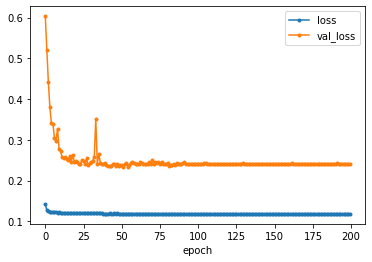

In [14]:
plot_history(history, ['loss', 'val_loss'])

## Computing Threshold Value
The network predicts 4 output channels:
1. The denoised input.
2. The foreground likelihoods.
3. The background likelihoods.
4. The border likelihoods.

We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [15]:
threshold, val_score = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision())

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

Computing best threshold: 


/home/prakash/Git-repos/DenoiSeg/denoiseg/utils/compute_precision_threshold.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "pixel_sharing_bipartite" failed type inference due to: Invalid use of Function(<built-in function zeros>) with argument(s) of type(s): (UniTuple(int64 x 2), dtype=Function(<class 'int'>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in function zeros>)
[2] During: typing of call at /home/prakash/Git-repos/DenoiSeg/denoiseg/utils/compute_precision_threshold.py (10)


File "../../denoiseg/utils/compute_precision_threshold.py", line 10:
def pixel_sharing_bipartite(lab1, lab2):
    <source elided>
    assert lab1.shape == lab2.shape
    psg = np.zeros((lab1.max() + 

Score for threshold = 0.10 is 0.6770
Score for threshold = 0.15 is 0.7034
Score for threshold = 0.20 is 0.7175
Score for threshold = 0.25 is 0.7242
Score for threshold = 0.30 is 0.7295
Score for threshold = 0.35 is 0.7309
Score for threshold = 0.40 is 0.7287
Score for threshold = 0.45 is 0.7219
Score for threshold = 0.50 is 0.7180
Score for threshold = 0.55 is 0.7137
Score for threshold = 0.60 is 0.6993
Score for threshold = 0.65 is 0.6834
Score for threshold = 0.70 is 0.6571
Score for threshold = 0.75 is 0.6338
Score for threshold = 0.80 is 0.6102
Score for threshold = 0.85 is 0.5715
Score for threshold = 0.90 is 0.5060
Score for threshold = 0.95 is 0.3820
Score for threshold = 1.00 is 0.0000

The higest score of 0.731 is achieved with threshold = 0.35.


## Test Data
Finally we load the test data and run the prediction.

In [16]:
test_data =  np.load('data/DSB2018_{}/test/test_data.npz'.format(noise_level), allow_pickle=True)
test_images = test_data['X_test']
test_masks = test_data['Y_test']

In [17]:
predicted_images, precision_result = model.predict_label_masks(test_images, test_masks, threshold, 
                                                                   measure=measure_precision())
print("Average precision over all test images with threshold = {} is {}.".format(threshold, np.round(precision_result, 3)))

Average precision over all test images with threshold = 0.35 is 0.697.
